# Dense Channel Aggregation and Reconstruction Network

In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Select the GPU index
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import namedtuple
import scipy.io as sio
import math
import thop

from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
from scipy.io import savemat
import dill as pickle
from torch.optim.lr_scheduler import _LRScheduler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Parameters
num_epochs=1000
patience=15
data_dir='../data/' 
scenario='out'
batch_size=200 
workers=5
reduction=64
expansion=50
seed=None
pin_memory=True
schedulertype = 'cosine'
weight_path=f'Experiments/table1/cr{reduction}/{expansion}x_{scenario}/epochs{num_epochs}/'
lr_init = 3e-3
val_freq=10
test_freq=10

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class PreFetcher:
    r""" Data pre-fetcher to accelerate the data loading
    """

    def __init__(self, loader):
        self.ori_loader = loader
        self.len = len(loader)
        self.stream = torch.cuda.Stream()
        self.next_input = None

    def preload(self):
        try:
            self.next_input = next(self.loader)
        except StopIteration:
            self.next_input = None
            return

        with torch.cuda.stream(self.stream):
            for idx, tensor in enumerate(self.next_input):
                self.next_input[idx] = tensor.cuda(non_blocking=True)

    def __len__(self):
        return self.len

    def __iter__(self):
        self.loader = iter(self.ori_loader)
        self.preload()
        return self

    def __next__(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        if input is None:
            raise StopIteration
        for tensor in input:
            tensor.record_stream(torch.cuda.current_stream())
        self.preload()
        return input


In [5]:


class Cost2100DataLoader(object):
    r""" PyTorch DataLoader for COST2100 dataset.
    """

    def __init__(self, root, batch_size, num_workers, pin_memory, scenario):
        
        assert scenario in {"in", "out"}
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

        dir_train = os.path.join(root, f"DATA_Htrain{scenario}.mat")
        dir_val = os.path.join(root, f"DATA_Hval{scenario}.mat")
        dir_test = os.path.join(root, f"DATA_Htest{scenario}.mat")
        dir_raw = os.path.join(root, f"DATA_HtestF{scenario}_all.mat")
        channel, nt, nc, nc_expand = 2, 32, 32, 125

        # Training data loading
        data_train = sio.loadmat(dir_train)['HT']
        data_train = torch.tensor(data_train, dtype=torch.float32).view(
            data_train.shape[0], channel, nt, nc)
        self.train_dataset = TensorDataset(data_train)

        # Validation data loading
        data_val = sio.loadmat(dir_val)['HT']
        data_val = torch.tensor(data_val, dtype=torch.float32).view(
            data_val.shape[0], channel, nt, nc)
        self.val_dataset = TensorDataset(data_val)

        # Test data loading, including the sparse data and the raw data
        data_test = sio.loadmat(dir_test)['HT']
        data_test = torch.tensor(data_test, dtype=torch.float32).view(
            data_test.shape[0], channel, nt, nc)

        raw_test = sio.loadmat(dir_raw)['HF_all']
        real = torch.tensor(np.real(raw_test), dtype=torch.float32)
        imag = torch.tensor(np.imag(raw_test), dtype=torch.float32)
        raw_test = torch.cat((real.view(raw_test.shape[0], nt, nc_expand, 1),
                              imag.view(raw_test.shape[0], nt, nc_expand, 1)), dim=3)
        self.test_dataset = TensorDataset(data_test, raw_test)

    def __call__(self):
        train_loader = DataLoader(self.train_dataset,
                                  batch_size=self.batch_size,
                                  num_workers=self.num_workers,
                                  pin_memory=self.pin_memory,
                                  shuffle=True)
        val_loader = DataLoader(self.val_dataset,
                                batch_size=self.batch_size,
                                num_workers=self.num_workers,
                                pin_memory=self.pin_memory,
                                shuffle=False)
        test_loader = DataLoader(self.test_dataset,
                                 batch_size=self.batch_size,
                                 num_workers=self.num_workers,
                                 pin_memory=self.pin_memory,
                                 shuffle=False)

        # Accelerate CUDA data loading with pre-fetcher if GPU is used.
        if self.pin_memory is True:
            train_loader = PreFetcher(train_loader)
            val_loader = PreFetcher(val_loader)
            test_loader = PreFetcher(test_loader)

        return train_loader, val_loader, test_loader


In [6]:
# Create the data loader
train_loader, val_loader, test_loader = Cost2100DataLoader(
        root=data_dir,
        batch_size=batch_size,
        num_workers=workers,
        pin_memory=pin_memory,
        scenario=scenario)()

In [7]:
train_iter=iter(train_loader)

In [8]:
x=next(train_iter)

In [9]:
len(x)

1

In [10]:
x[0].shape

torch.Size([200, 2, 32, 32])

In [11]:
len(train_loader)

500

In [12]:
len(test_loader)

100

In [13]:
len(val_loader)

150

In [14]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

In [15]:
def NMSE_cal(x_hat, x):
    x_real = torch.reshape(torch.real(x), (x.shape[0], -1))
    x_imag = torch.reshape(torch.imag(x), (x.shape[0], -1))
    x_hat_real = torch.reshape(torch.real(x_hat), (x.shape[0], -1))
    x_hat_imag = torch.reshape(torch.imag(x_hat), (x.shape[0], -1))
    power = torch.sum((x_real - 0.5) ** 2 + (x_imag - 0.5) ** 2, dim=1)
    mse = torch.sum((x_real - x_hat_real) ** 2 + (x_imag - x_hat_imag) ** 2, dim=1)
    nmse = torch.mean(mse / power)
    return nmse

In [16]:
class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_channels=in_planes,
                               out_channels=out_planes,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=groups,
                               bias=False)),
            ('bn', nn.BatchNorm2d(out_planes))
        ]))

In [17]:
class DCARNDecoderBlock(nn.Module):
  
    def __init__(self, expansion):
        super().__init__()
        width = 10 * expansion
        self.conv1 = ConvBN(2, width, [1, 11])
        self.prelu1 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv2 = ConvBN(2, width, [11, 1])
        self.prelu2 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv3 = ConvBN(2*width, 2, [1, 11])
        self.prelu3 = nn.PReLU(num_parameters=2, init=0.3)
        self.identity = nn.Identity()
    def forward(self, x):
        identity = self.identity(x)
        x1 = self.prelu1(self.conv1(x))

        x2 = self.prelu2(self.conv2(x))

        # Concat instead of add
        x3 = torch.cat([x1, x2], dim=1) 
        x3 = self.prelu3(self.conv3(x3)+identity)

        return x3

In [18]:
class DCARNEncoderBlock(nn.Module):
    def __init__(self):
        super(DCARNEncoderBlock, self).__init__()
        width = 2
        self.conv1 = ConvBN(2, width, [1, 11])
        self.prelu1 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv2 = ConvBN(2, width, [11, 1])
        self.prelu2 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv3 = ConvBN(2*width, 2, [1, 11])
        self.prelu3 = nn.PReLU(num_parameters=2, init=0.3)
        self.identity = nn.Identity()
    def forward(self, x):
        identity = self.identity(x)
        x1 = self.prelu1(self.conv1(x))

        x2 = self.prelu2(self.conv2(x))

        # Concat instead of add
        x3 = torch.cat([x1, x2], dim=1) 
        x3 = self.prelu3(self.conv3(x3)+identity)
        return x3

In [19]:
class DCARN(nn.Module):
    def __init__(self,
                 in_channels=2,
                 reduction=4,
                 expansion=1):
        super(DCARN, self).__init__()
        
        total_size, w, h = 2048, 32, 32

        self.encoder_feature = nn.Sequential(OrderedDict([
            ("conv1x11_bn", ConvBN(in_channels, 2, [1, 11])),
            ("prelu", nn.PReLU(num_parameters=2, init=0.3)),
            ("DCARNEncoderBlock", DCARNEncoderBlock()),
            
        ]))
        
        self.encoder_fc = nn.Linear(total_size, total_size // reduction)

        self.decoder_fc = nn.Linear(total_size // reduction, total_size)
        
        self.decoder_feature = nn.Sequential(OrderedDict([
            ("conv1x11_bn", ConvBN(2, in_channels, [1, 11])),
            ("prelu", nn.PReLU(num_parameters=2, init=0.3)),
            ("DCARNDecoderBlock1", DCARNDecoderBlock(expansion=expansion)),
            ("DCARNDecoderBlock2", DCARNDecoderBlock(expansion=expansion)),
            ("sigmoid", nn.Sigmoid())
        ]))

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        n, c, h, w = x.detach().size()
        out = self.encoder_feature(x)
        out = self.encoder_fc(out.view(n, -1))
        out = self.decoder_fc(out)
        out = self.decoder_feature(out.view(n, c, h, w))
        return out

In [20]:
model = DCARN(in_channels=2, reduction=reduction, expansion=expansion).to(device)

In [21]:
if seed is not None:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [22]:
cal_model_parameters(model)

227458

In [23]:
# Define loss function
criterion = nn.MSELoss().to(device)

In [24]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]


class FakeLR(_LRScheduler):
    def __init__(self, optimizer):
        super(FakeLR, self).__init__(optimizer=optimizer)

    def get_lr(self):
        return self.base_lrs


In [25]:
# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr_init, betas=(0.9, 0.999))
if schedulertype == 'const':
    scheduler = FakeLR(optimizer=optimizer)

else:
    scheduler = WarmUpCosineAnnealingLR(optimizer=optimizer,
                                        T_max=num_epochs * len(train_loader),
                                        T_warmup=100 * len(train_loader),
                                        eta_min=5e-7)

In [26]:
field = ('nmse', 'rho', 'epoch')
Result = namedtuple('Result', field, defaults=(None,) * len(field))


In [27]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self, name):
        self.reset()
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.name = name

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __repr__(self):
        return f"==> For {self.name}: sum={self.sum}; avg={self.avg}"




In [28]:
def evaluator(sparse_pred, sparse_gt, raw_gt):
    r""" Evaluation of decoding implemented in PyTorch Tensor
         Computes normalized mean square error (NMSE) and rho.
    """

    with torch.no_grad():
        # Basic params
        nt = 32
        nc = 32
        nc_expand = 257

        # De-centralize
        sparse_gt = sparse_gt - 0.5
        sparse_pred = sparse_pred - 0.5

        # Calculate the NMSE
        power_gt = sparse_gt[:, 0, :, :] ** 2 + sparse_gt[:, 1, :, :] ** 2
        difference = sparse_gt - sparse_pred
        mse = difference[:, 0, :, :] ** 2 + difference[:, 1, :, :] ** 2
        nmse = (mse.sum(dim=[1, 2]) / power_gt.sum(dim=[1, 2])).mean()

        # Calculate the Rho
        n = sparse_pred.size(0)
        sparse_pred = sparse_pred.permute(0, 2, 3, 1)  # Move the real/imaginary dim to the last
        zeros = sparse_pred.new_zeros((n, nt, nc_expand - nc, 2))
        sparse_pred = torch.cat((sparse_pred, zeros), dim=2)
        raw_pred = torch.fft.fft(sparse_pred, dim=1)[:, :, :125, :]

        norm_pred = raw_pred[..., 0] ** 2 + raw_pred[..., 1] ** 2
        norm_pred = torch.sqrt(norm_pred.sum(dim=1))

        norm_gt = raw_gt[..., 0] ** 2 + raw_gt[..., 1] ** 2
        norm_gt = torch.sqrt(norm_gt.sum(dim=1))

        real_cross = raw_pred[..., 0] * raw_gt[..., 0] + raw_pred[..., 1] * raw_gt[..., 1]
        real_cross = real_cross.sum(dim=1)
        imag_cross = raw_pred[..., 0] * raw_gt[..., 1] - raw_pred[..., 1] * raw_gt[..., 0]
        imag_cross = imag_cross.sum(dim=1)
        norm_cross = torch.sqrt(real_cross ** 2 + imag_cross ** 2)

        rho = (norm_cross / (norm_pred * norm_gt)).mean()

        return rho, nmse


In [29]:
class Tester:
    r""" The testing interface for classification
    """

    def __init__(self, model, device, criterion, print_freq=20):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.print_freq = print_freq

    def __call__(self, test_data, verbose=True):
        r""" Runs the testing procedure.

        Args:
            test_data (DataLoader): Data loader for validation data.
        """

        self.model.eval()
        with torch.no_grad():
            loss, rho, nmse = self._iteration(test_data)
        if verbose:
            print(f'\n=> Test result: \nloss: {loss:.3e}'
                  f'    rho: {rho:.3e}    NMSE: {nmse:.3e}\n')
        return loss, rho, nmse

    def _iteration(self, data_loader):
        r""" protected function which test the model on given data loader for one epoch.
        """

        iter_rho = AverageMeter('Iter rho')
        iter_nmse = AverageMeter('Iter nmse')
        iter_loss = AverageMeter('Iter loss')
        iter_time = AverageMeter('Iter time')
        time_tmp = time.time()

        for batch_idx, (sparse_gt, raw_gt) in enumerate(data_loader):
            sparse_gt = sparse_gt.to(self.device)
            sparse_pred = self.model(sparse_gt)
            loss = self.criterion(sparse_pred, sparse_gt)
            rho, nmse = evaluator(sparse_pred, sparse_gt, raw_gt)

            # Log and visdom update
            iter_loss.update(loss)
            iter_rho.update(rho)
            iter_nmse.update(nmse)
            iter_time.update(time.time() - time_tmp)
            time_tmp = time.time()

            # plot progress
            if (batch_idx + 1) % self.print_freq == 0:
                print(f'[{batch_idx + 1}/{len(data_loader)}] '
                            f'loss: {iter_loss.avg:.3e} | rho: {iter_rho.avg:.3e} | '
                            f'NMSE: {10 * torch.log10(iter_nmse.avg):.3e} | time: {iter_time.avg:.3f}')
        
        nmse = 10 * torch.log10(iter_nmse.avg)  # global NMSE in dB
        print(f'=> Test rho:{iter_rho.avg:.3e}  NMSE: {nmse:.3e}\n')
        return iter_loss.avg, iter_rho.avg, nmse


In [30]:
val_losses = torch.empty(num_epochs//val_freq)
train_losses = torch.empty(num_epochs)
test_losses = torch.empty(num_epochs//test_freq)
alphas = torch.zeros(num_epochs)
test_nmses = torch.zeros(num_epochs//test_freq)

if not os.path.exists(weight_path + "losses/"):
    os.makedirs(weight_path + "losses/")

In [31]:
class Trainer:
    r""" The training pipeline for encoder-decoder architecture
    """

    def __init__(self, model, device, optimizer, criterion, scheduler, resume=None,
                 save_path=weight_path, print_freq=10, val_freq = val_freq, test_freq = test_freq):

        # Basic arguments
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.device = device

        # Verbose arguments
        self.resume_file = resume
        self.save_path = save_path
        self.print_freq = print_freq
        self.val_freq = val_freq
        self.test_freq = test_freq
        

        # Pipeline arguments
        self.cur_epoch = 1
        self.all_epoch = None
        self.train_loss = None
        self.val_loss = None
        self.test_loss = None
        self.best_rho = Result()
        self.best_nmse = Result()
        
        self.tester = Tester(model, device, criterion, print_freq)
        self.test_loader = None

    def loop(self, epochs, train_loader, val_loader, test_loader):
        r""" The main loop function which runs training and validation iteratively.

        Args:
            epochs (int): The total epoch for training
            train_loader (DataLoader): Data loader for training data.
            val_loader (DataLoader): Data loader for validation data.
            test_loader (DataLoader): Data loader for test data.
        """

        self.all_epoch = epochs
        self._resume()
        vn=0
        tn=0
        for ep in range(self.cur_epoch, epochs + 1):
            self.cur_epoch = ep

            # conduct training, validation and test
            self.train_loss = self.train(train_loader)
            train_losses[ep-1] = self.train_loss.detach()
            if ep % self.val_freq == 0:
                self.val_loss = self.val(val_loader)
                val_losses[vn] = self.val_loss.detach()
                vn=vn+1
            # Save alpha 
            alphas_ep = []
            for m in self.model.modules():
                if isinstance(m, nn.PReLU):
                    alphas_ep.append(m.weight[0])
            alphas[ep-1] = torch.stack(alphas_ep).mean().detach()
            
            if ep % self.test_freq == 0:
                self.test_loss, rho, nmse = self.test(test_loader)
                test_losses[tn] = self.test_loss.detach()
                test_nmses[tn] = nmse.detach()
                tn=tn+1
            else:
                rho, nmse = None, None
            # conduct saving, visualization and log printing
            self._loop_postprocessing(rho, nmse)

    def train(self, train_loader):
        r""" train the model on the given data loader for one epoch.

        Args:
            train_loader (DataLoader): the training data loader
        """

        self.model.train()
        with torch.enable_grad():
            return self._iteration(train_loader)

    def val(self, val_loader):
        r""" exam the model with validation set.

        Args:
            val_loader: (DataLoader): the validation data loader
        """

        self.model.eval()
        with torch.no_grad():
            return self._iteration(val_loader)

    def test(self, test_loader):
        r""" Truly test the model on the test dataset for one epoch.

        Args:
            test_loader (DataLoader): the test data loader
        """

        self.model.eval()
        with torch.no_grad():
            return self.tester(test_loader, verbose=False)

    def _iteration(self, data_loader):
        iter_loss = AverageMeter('Iter loss')
        iter_time = AverageMeter('Iter time')
        time_tmp = time.time()

        for batch_idx, (sparse_gt, ) in enumerate(data_loader):
            sparse_gt = sparse_gt.to(self.device)
            sparse_pred = self.model(sparse_gt)
            loss = self.criterion(sparse_pred, sparse_gt)

            # Scheduler update, backward pass and optimization
            if self.model.training:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

            # Log and visdom update
            iter_loss.update(loss)
            iter_time.update(time.time() - time_tmp)
            time_tmp = time.time()

            # plot progress
            if (batch_idx + 1) % self.print_freq == 0:
                print(f'Epoch: [{self.cur_epoch}/{self.all_epoch}]'
                            f'[{batch_idx + 1}/{len(data_loader)}] '
                            f'lr: {self.scheduler.get_lr()[0]:.2e} | '
                            f'MSE loss: {iter_loss.avg:.3e} | '
                            f'time: {iter_time.avg:.3f}')
                

        mode = 'Train' if self.model.training else 'Val'
        print(f' {mode}  Loss: {iter_loss.avg:.3e}\n')

        return iter_loss.avg

    def _save(self, state, name):
        if self.save_path is None:
            print('No path to save checkpoints.')
            return
        
        os.makedirs(self.save_path, exist_ok=True)
        torch.save(state, os.path.join(self.save_path, name))

    def _resume(self):
        r""" protected function which resume from checkpoint at the beginning of training.
        """

        if self.resume_file is None:
            return None
        assert os.path.isfile(self.resume_file)
        print(f' loading checkpoint {self.resume_file}')
        checkpoint = torch.load(self.resume_file)
        self.cur_epoch = checkpoint['epoch']
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        self.best_rho = checkpoint['best_rho']
        self.best_nmse = checkpoint['best_nmse']
        self.cur_epoch += 1  # start from the next epoch

        print(f' successfully loaded checkpoint {self.resume_file} '
                    f'from epoch {checkpoint["epoch"]}.\n')

    def _loop_postprocessing(self, rho, nmse):
        r""" private function which makes loop() function neater.
        """

        # save state generate
        state = {
            'epoch': self.cur_epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict(),
            'best_rho': self.best_rho,
            'best_nmse': self.best_nmse
        }

        # save model with best rho and nmse
        if rho is not None:
            if self.best_rho.rho is None or abs(self.best_rho.rho) < abs(rho):
                self.best_rho = Result(rho=rho, nmse=nmse, epoch=self.cur_epoch)
                state['best_rho'] = self.best_rho
                self._save(state, name=f"best_rho.pth")
            if self.best_nmse.nmse is None or self.best_nmse.nmse > nmse:
                self.best_nmse = Result(rho=rho, nmse=nmse, epoch=self.cur_epoch)
                state['best_nmse'] = self.best_nmse
                self._save(state, name=f"best_nmse.pth")

        self._save(state, name='last.pth')

        # print current best results
        if self.best_rho.rho is not None:
            print(f'\n=! Best rho: {self.best_rho.rho:.3e} ('
                  f'Corresponding nmse={self.best_rho.nmse:.3e}; '
                  f'epoch={self.best_rho.epoch})'
                  f'\n   Best NMSE: {self.best_nmse.nmse:.3e} ('
                  f'Corresponding rho={self.best_nmse.rho:.3e};  '
                  f'epoch={self.best_nmse.epoch})\n')
            

In [32]:
# Define the training pipeline
trainer = Trainer(model=model,
                  device=device,
                  optimizer=optimizer,
                  criterion=criterion,
                  scheduler=scheduler)

# Start training
trainer.loop(num_epochs, train_loader, val_loader, test_loader)

Epoch: [1/1000][10/500] lr: 6.00e-07 | MSE loss: 5.322e-02 | time: 0.238
Epoch: [1/1000][20/500] lr: 1.20e-06 | MSE loss: 5.305e-02 | time: 0.207
Epoch: [1/1000][30/500] lr: 1.80e-06 | MSE loss: 5.274e-02 | time: 0.196
Epoch: [1/1000][40/500] lr: 2.40e-06 | MSE loss: 5.229e-02 | time: 0.191
Epoch: [1/1000][50/500] lr: 3.00e-06 | MSE loss: 5.170e-02 | time: 0.188
Epoch: [1/1000][60/500] lr: 3.60e-06 | MSE loss: 5.095e-02 | time: 0.186
Epoch: [1/1000][70/500] lr: 4.20e-06 | MSE loss: 5.005e-02 | time: 0.184
Epoch: [1/1000][80/500] lr: 4.80e-06 | MSE loss: 4.901e-02 | time: 0.183
Epoch: [1/1000][90/500] lr: 5.40e-06 | MSE loss: 4.784e-02 | time: 0.182
Epoch: [1/1000][100/500] lr: 6.00e-06 | MSE loss: 4.657e-02 | time: 0.181
Epoch: [1/1000][110/500] lr: 6.60e-06 | MSE loss: 4.525e-02 | time: 0.181
Epoch: [1/1000][120/500] lr: 7.20e-06 | MSE loss: 4.392e-02 | time: 0.181
Epoch: [1/1000][130/500] lr: 7.80e-06 | MSE loss: 4.260e-02 | time: 0.180
Epoch: [1/1000][140/500] lr: 8.40e-06 | MSE los

Epoch: [3/1000][120/500] lr: 6.72e-05 | MSE loss: 1.110e-03 | time: 0.179
Epoch: [3/1000][130/500] lr: 6.78e-05 | MSE loss: 1.105e-03 | time: 0.179
Epoch: [3/1000][140/500] lr: 6.84e-05 | MSE loss: 1.100e-03 | time: 0.178
Epoch: [3/1000][150/500] lr: 6.90e-05 | MSE loss: 1.096e-03 | time: 0.178
Epoch: [3/1000][160/500] lr: 6.96e-05 | MSE loss: 1.091e-03 | time: 0.178
Epoch: [3/1000][170/500] lr: 7.02e-05 | MSE loss: 1.086e-03 | time: 0.178
Epoch: [3/1000][180/500] lr: 7.08e-05 | MSE loss: 1.082e-03 | time: 0.178
Epoch: [3/1000][190/500] lr: 7.14e-05 | MSE loss: 1.077e-03 | time: 0.178
Epoch: [3/1000][200/500] lr: 7.20e-05 | MSE loss: 1.072e-03 | time: 0.178
Epoch: [3/1000][210/500] lr: 7.26e-05 | MSE loss: 1.069e-03 | time: 0.178
Epoch: [3/1000][220/500] lr: 7.32e-05 | MSE loss: 1.065e-03 | time: 0.178
Epoch: [3/1000][230/500] lr: 7.38e-05 | MSE loss: 1.062e-03 | time: 0.178
Epoch: [3/1000][240/500] lr: 7.44e-05 | MSE loss: 1.058e-03 | time: 0.178
Epoch: [3/1000][250/500] lr: 7.50e-05 

Epoch: [5/1000][230/500] lr: 1.34e-04 | MSE loss: 8.042e-04 | time: 0.178
Epoch: [5/1000][240/500] lr: 1.34e-04 | MSE loss: 8.039e-04 | time: 0.178
Epoch: [5/1000][250/500] lr: 1.35e-04 | MSE loss: 8.041e-04 | time: 0.178
Epoch: [5/1000][260/500] lr: 1.36e-04 | MSE loss: 8.044e-04 | time: 0.178
Epoch: [5/1000][270/500] lr: 1.36e-04 | MSE loss: 8.044e-04 | time: 0.178
Epoch: [5/1000][280/500] lr: 1.37e-04 | MSE loss: 8.052e-04 | time: 0.177
Epoch: [5/1000][290/500] lr: 1.37e-04 | MSE loss: 8.051e-04 | time: 0.177
Epoch: [5/1000][300/500] lr: 1.38e-04 | MSE loss: 8.054e-04 | time: 0.177
Epoch: [5/1000][310/500] lr: 1.39e-04 | MSE loss: 8.056e-04 | time: 0.177
Epoch: [5/1000][320/500] lr: 1.39e-04 | MSE loss: 8.046e-04 | time: 0.177
Epoch: [5/1000][330/500] lr: 1.40e-04 | MSE loss: 8.042e-04 | time: 0.177
Epoch: [5/1000][340/500] lr: 1.40e-04 | MSE loss: 8.042e-04 | time: 0.177
Epoch: [5/1000][350/500] lr: 1.41e-04 | MSE loss: 8.041e-04 | time: 0.177
Epoch: [5/1000][360/500] lr: 1.42e-04 

Epoch: [7/1000][340/500] lr: 2.00e-04 | MSE loss: 8.011e-04 | time: 0.178
Epoch: [7/1000][350/500] lr: 2.01e-04 | MSE loss: 8.010e-04 | time: 0.177
Epoch: [7/1000][360/500] lr: 2.02e-04 | MSE loss: 8.007e-04 | time: 0.177
Epoch: [7/1000][370/500] lr: 2.02e-04 | MSE loss: 8.008e-04 | time: 0.177
Epoch: [7/1000][380/500] lr: 2.03e-04 | MSE loss: 8.010e-04 | time: 0.177
Epoch: [7/1000][390/500] lr: 2.03e-04 | MSE loss: 8.007e-04 | time: 0.177
Epoch: [7/1000][400/500] lr: 2.04e-04 | MSE loss: 8.008e-04 | time: 0.177
Epoch: [7/1000][410/500] lr: 2.05e-04 | MSE loss: 8.009e-04 | time: 0.177
Epoch: [7/1000][420/500] lr: 2.05e-04 | MSE loss: 8.009e-04 | time: 0.177
Epoch: [7/1000][430/500] lr: 2.06e-04 | MSE loss: 8.008e-04 | time: 0.177
Epoch: [7/1000][440/500] lr: 2.06e-04 | MSE loss: 8.011e-04 | time: 0.177
Epoch: [7/1000][450/500] lr: 2.07e-04 | MSE loss: 8.011e-04 | time: 0.177
Epoch: [7/1000][460/500] lr: 2.08e-04 | MSE loss: 8.011e-04 | time: 0.177
Epoch: [7/1000][470/500] lr: 2.08e-04 

Epoch: [9/1000][450/500] lr: 2.67e-04 | MSE loss: 8.029e-04 | time: 0.177
Epoch: [9/1000][460/500] lr: 2.68e-04 | MSE loss: 8.027e-04 | time: 0.177
Epoch: [9/1000][470/500] lr: 2.68e-04 | MSE loss: 8.024e-04 | time: 0.177
Epoch: [9/1000][480/500] lr: 2.69e-04 | MSE loss: 8.024e-04 | time: 0.177
Epoch: [9/1000][490/500] lr: 2.69e-04 | MSE loss: 8.023e-04 | time: 0.177
Epoch: [9/1000][500/500] lr: 2.70e-04 | MSE loss: 8.024e-04 | time: 0.177
 Train  Loss: 8.024e-04

Epoch: [10/1000][10/500] lr: 2.71e-04 | MSE loss: 8.138e-04 | time: 0.200
Epoch: [10/1000][20/500] lr: 2.71e-04 | MSE loss: 8.046e-04 | time: 0.188
Epoch: [10/1000][30/500] lr: 2.72e-04 | MSE loss: 8.000e-04 | time: 0.184
Epoch: [10/1000][40/500] lr: 2.72e-04 | MSE loss: 7.966e-04 | time: 0.182
Epoch: [10/1000][50/500] lr: 2.73e-04 | MSE loss: 7.987e-04 | time: 0.181
Epoch: [10/1000][60/500] lr: 2.74e-04 | MSE loss: 7.989e-04 | time: 0.180
Epoch: [10/1000][70/500] lr: 2.74e-04 | MSE loss: 7.994e-04 | time: 0.180
Epoch: [10/10

Epoch: [11/1000][270/500] lr: 3.16e-04 | MSE loss: 7.995e-04 | time: 0.178
Epoch: [11/1000][280/500] lr: 3.17e-04 | MSE loss: 7.996e-04 | time: 0.178
Epoch: [11/1000][290/500] lr: 3.17e-04 | MSE loss: 7.993e-04 | time: 0.178
Epoch: [11/1000][300/500] lr: 3.18e-04 | MSE loss: 7.990e-04 | time: 0.178
Epoch: [11/1000][310/500] lr: 3.19e-04 | MSE loss: 7.986e-04 | time: 0.178
Epoch: [11/1000][320/500] lr: 3.19e-04 | MSE loss: 7.990e-04 | time: 0.178
Epoch: [11/1000][330/500] lr: 3.20e-04 | MSE loss: 7.990e-04 | time: 0.178
Epoch: [11/1000][340/500] lr: 3.20e-04 | MSE loss: 7.994e-04 | time: 0.177
Epoch: [11/1000][350/500] lr: 3.21e-04 | MSE loss: 7.991e-04 | time: 0.177
Epoch: [11/1000][360/500] lr: 3.22e-04 | MSE loss: 7.994e-04 | time: 0.177
Epoch: [11/1000][370/500] lr: 3.22e-04 | MSE loss: 7.990e-04 | time: 0.177
Epoch: [11/1000][380/500] lr: 3.23e-04 | MSE loss: 7.989e-04 | time: 0.177
Epoch: [11/1000][390/500] lr: 3.23e-04 | MSE loss: 7.989e-04 | time: 0.177
Epoch: [11/1000][400/500]

Epoch: [13/1000][330/500] lr: 3.80e-04 | MSE loss: 7.612e-04 | time: 0.177
Epoch: [13/1000][340/500] lr: 3.80e-04 | MSE loss: 7.607e-04 | time: 0.177
Epoch: [13/1000][350/500] lr: 3.81e-04 | MSE loss: 7.602e-04 | time: 0.177
Epoch: [13/1000][360/500] lr: 3.82e-04 | MSE loss: 7.598e-04 | time: 0.177
Epoch: [13/1000][370/500] lr: 3.82e-04 | MSE loss: 7.593e-04 | time: 0.177
Epoch: [13/1000][380/500] lr: 3.83e-04 | MSE loss: 7.588e-04 | time: 0.177
Epoch: [13/1000][390/500] lr: 3.83e-04 | MSE loss: 7.583e-04 | time: 0.177
Epoch: [13/1000][400/500] lr: 3.84e-04 | MSE loss: 7.581e-04 | time: 0.177
Epoch: [13/1000][410/500] lr: 3.85e-04 | MSE loss: 7.581e-04 | time: 0.177
Epoch: [13/1000][420/500] lr: 3.85e-04 | MSE loss: 7.580e-04 | time: 0.177
Epoch: [13/1000][430/500] lr: 3.86e-04 | MSE loss: 7.577e-04 | time: 0.177
Epoch: [13/1000][440/500] lr: 3.86e-04 | MSE loss: 7.571e-04 | time: 0.177
Epoch: [13/1000][450/500] lr: 3.87e-04 | MSE loss: 7.567e-04 | time: 0.177
Epoch: [13/1000][460/500]

Epoch: [15/1000][390/500] lr: 4.43e-04 | MSE loss: 6.797e-04 | time: 0.178
Epoch: [15/1000][400/500] lr: 4.44e-04 | MSE loss: 6.793e-04 | time: 0.177
Epoch: [15/1000][410/500] lr: 4.45e-04 | MSE loss: 6.789e-04 | time: 0.177
Epoch: [15/1000][420/500] lr: 4.45e-04 | MSE loss: 6.783e-04 | time: 0.177
Epoch: [15/1000][430/500] lr: 4.46e-04 | MSE loss: 6.781e-04 | time: 0.177
Epoch: [15/1000][440/500] lr: 4.46e-04 | MSE loss: 6.777e-04 | time: 0.177
Epoch: [15/1000][450/500] lr: 4.47e-04 | MSE loss: 6.769e-04 | time: 0.177
Epoch: [15/1000][460/500] lr: 4.48e-04 | MSE loss: 6.767e-04 | time: 0.177
Epoch: [15/1000][470/500] lr: 4.48e-04 | MSE loss: 6.764e-04 | time: 0.177
Epoch: [15/1000][480/500] lr: 4.49e-04 | MSE loss: 6.758e-04 | time: 0.177
Epoch: [15/1000][490/500] lr: 4.49e-04 | MSE loss: 6.753e-04 | time: 0.177
Epoch: [15/1000][500/500] lr: 4.50e-04 | MSE loss: 6.750e-04 | time: 0.177
 Train  Loss: 6.750e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMS

Epoch: [17/1000][450/500] lr: 5.07e-04 | MSE loss: 6.135e-04 | time: 0.177
Epoch: [17/1000][460/500] lr: 5.08e-04 | MSE loss: 6.131e-04 | time: 0.177
Epoch: [17/1000][470/500] lr: 5.08e-04 | MSE loss: 6.129e-04 | time: 0.177
Epoch: [17/1000][480/500] lr: 5.09e-04 | MSE loss: 6.126e-04 | time: 0.177
Epoch: [17/1000][490/500] lr: 5.09e-04 | MSE loss: 6.125e-04 | time: 0.177
Epoch: [17/1000][500/500] lr: 5.10e-04 | MSE loss: 6.124e-04 | time: 0.177
 Train  Loss: 6.124e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: 1.206e-02 (Corresponding rho=nan+nanj;  epoch=10)

Epoch: [18/1000][10/500] lr: 5.11e-04 | MSE loss: 5.955e-04 | time: 0.227
Epoch: [18/1000][20/500] lr: 5.11e-04 | MSE loss: 5.923e-04 | time: 0.202
Epoch: [18/1000][30/500] lr: 5.12e-04 | MSE loss: 5.949e-04 | time: 0.193
Epoch: [18/1000][40/500] lr: 5.12e-04 | MSE loss: 5.957e-04 | time: 0.189
Epoch: [18/1000][50/500] lr: 5.13e-04 | MSE loss: 5.964e-04 | time: 0.187
Epoch: [18/1000][60/500] l

Epoch: [20/1000][10/500] lr: 5.71e-04 | MSE loss: 5.590e-04 | time: 0.203
Epoch: [20/1000][20/500] lr: 5.71e-04 | MSE loss: 5.595e-04 | time: 0.190
Epoch: [20/1000][30/500] lr: 5.72e-04 | MSE loss: 5.598e-04 | time: 0.186
Epoch: [20/1000][40/500] lr: 5.72e-04 | MSE loss: 5.616e-04 | time: 0.183
Epoch: [20/1000][50/500] lr: 5.73e-04 | MSE loss: 5.641e-04 | time: 0.182
Epoch: [20/1000][60/500] lr: 5.74e-04 | MSE loss: 5.655e-04 | time: 0.181
Epoch: [20/1000][70/500] lr: 5.74e-04 | MSE loss: 5.669e-04 | time: 0.180
Epoch: [20/1000][80/500] lr: 5.75e-04 | MSE loss: 5.670e-04 | time: 0.180
Epoch: [20/1000][90/500] lr: 5.75e-04 | MSE loss: 5.670e-04 | time: 0.180
Epoch: [20/1000][100/500] lr: 5.76e-04 | MSE loss: 5.671e-04 | time: 0.179
Epoch: [20/1000][110/500] lr: 5.77e-04 | MSE loss: 5.668e-04 | time: 0.179
Epoch: [20/1000][120/500] lr: 5.77e-04 | MSE loss: 5.664e-04 | time: 0.179
Epoch: [20/1000][130/500] lr: 5.78e-04 | MSE loss: 5.677e-04 | time: 0.179
Epoch: [20/1000][140/500] lr: 5.78

Epoch: [21/1000][330/500] lr: 6.20e-04 | MSE loss: 5.619e-04 | time: 0.177
Epoch: [21/1000][340/500] lr: 6.20e-04 | MSE loss: 5.618e-04 | time: 0.177
Epoch: [21/1000][350/500] lr: 6.21e-04 | MSE loss: 5.618e-04 | time: 0.177
Epoch: [21/1000][360/500] lr: 6.22e-04 | MSE loss: 5.617e-04 | time: 0.177
Epoch: [21/1000][370/500] lr: 6.22e-04 | MSE loss: 5.615e-04 | time: 0.177
Epoch: [21/1000][380/500] lr: 6.23e-04 | MSE loss: 5.616e-04 | time: 0.177
Epoch: [21/1000][390/500] lr: 6.23e-04 | MSE loss: 5.612e-04 | time: 0.177
Epoch: [21/1000][400/500] lr: 6.24e-04 | MSE loss: 5.610e-04 | time: 0.177
Epoch: [21/1000][410/500] lr: 6.25e-04 | MSE loss: 5.606e-04 | time: 0.177
Epoch: [21/1000][420/500] lr: 6.25e-04 | MSE loss: 5.610e-04 | time: 0.177
Epoch: [21/1000][430/500] lr: 6.26e-04 | MSE loss: 5.606e-04 | time: 0.177
Epoch: [21/1000][440/500] lr: 6.26e-04 | MSE loss: 5.609e-04 | time: 0.177
Epoch: [21/1000][450/500] lr: 6.27e-04 | MSE loss: 5.605e-04 | time: 0.177
Epoch: [21/1000][460/500]

Epoch: [23/1000][390/500] lr: 6.83e-04 | MSE loss: 5.500e-04 | time: 0.177
Epoch: [23/1000][400/500] lr: 6.84e-04 | MSE loss: 5.503e-04 | time: 0.177
Epoch: [23/1000][410/500] lr: 6.85e-04 | MSE loss: 5.504e-04 | time: 0.177
Epoch: [23/1000][420/500] lr: 6.85e-04 | MSE loss: 5.503e-04 | time: 0.177
Epoch: [23/1000][430/500] lr: 6.86e-04 | MSE loss: 5.502e-04 | time: 0.177
Epoch: [23/1000][440/500] lr: 6.86e-04 | MSE loss: 5.501e-04 | time: 0.177
Epoch: [23/1000][450/500] lr: 6.87e-04 | MSE loss: 5.499e-04 | time: 0.177
Epoch: [23/1000][460/500] lr: 6.88e-04 | MSE loss: 5.497e-04 | time: 0.177
Epoch: [23/1000][470/500] lr: 6.88e-04 | MSE loss: 5.495e-04 | time: 0.177
Epoch: [23/1000][480/500] lr: 6.89e-04 | MSE loss: 5.496e-04 | time: 0.177
Epoch: [23/1000][490/500] lr: 6.89e-04 | MSE loss: 5.495e-04 | time: 0.177
Epoch: [23/1000][500/500] lr: 6.90e-04 | MSE loss: 5.495e-04 | time: 0.177
 Train  Loss: 5.495e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMS

Epoch: [25/1000][450/500] lr: 7.47e-04 | MSE loss: 5.421e-04 | time: 0.177
Epoch: [25/1000][460/500] lr: 7.48e-04 | MSE loss: 5.422e-04 | time: 0.177
Epoch: [25/1000][470/500] lr: 7.48e-04 | MSE loss: 5.421e-04 | time: 0.177
Epoch: [25/1000][480/500] lr: 7.49e-04 | MSE loss: 5.420e-04 | time: 0.177
Epoch: [25/1000][490/500] lr: 7.49e-04 | MSE loss: 5.421e-04 | time: 0.177
Epoch: [25/1000][500/500] lr: 7.50e-04 | MSE loss: 5.422e-04 | time: 0.177
 Train  Loss: 5.422e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -1.694e+00 (Corresponding rho=nan+nanj;  epoch=20)

Epoch: [26/1000][10/500] lr: 7.51e-04 | MSE loss: 5.402e-04 | time: 0.204
Epoch: [26/1000][20/500] lr: 7.51e-04 | MSE loss: 5.399e-04 | time: 0.190
Epoch: [26/1000][30/500] lr: 7.52e-04 | MSE loss: 5.412e-04 | time: 0.186
Epoch: [26/1000][40/500] lr: 7.52e-04 | MSE loss: 5.421e-04 | time: 0.183
Epoch: [26/1000][50/500] lr: 7.53e-04 | MSE loss: 5.422e-04 | time: 0.182
Epoch: [26/1000][60/500] 

Epoch: [28/1000][10/500] lr: 8.11e-04 | MSE loss: 5.307e-04 | time: 0.207
Epoch: [28/1000][20/500] lr: 8.11e-04 | MSE loss: 5.373e-04 | time: 0.192
Epoch: [28/1000][30/500] lr: 8.12e-04 | MSE loss: 5.389e-04 | time: 0.187
Epoch: [28/1000][40/500] lr: 8.12e-04 | MSE loss: 5.373e-04 | time: 0.185
Epoch: [28/1000][50/500] lr: 8.13e-04 | MSE loss: 5.358e-04 | time: 0.183
Epoch: [28/1000][60/500] lr: 8.14e-04 | MSE loss: 5.368e-04 | time: 0.182
Epoch: [28/1000][70/500] lr: 8.14e-04 | MSE loss: 5.381e-04 | time: 0.181
Epoch: [28/1000][80/500] lr: 8.15e-04 | MSE loss: 5.370e-04 | time: 0.181
Epoch: [28/1000][90/500] lr: 8.15e-04 | MSE loss: 5.380e-04 | time: 0.180
Epoch: [28/1000][100/500] lr: 8.16e-04 | MSE loss: 5.377e-04 | time: 0.180
Epoch: [28/1000][110/500] lr: 8.17e-04 | MSE loss: 5.375e-04 | time: 0.179
Epoch: [28/1000][120/500] lr: 8.17e-04 | MSE loss: 5.369e-04 | time: 0.179
Epoch: [28/1000][130/500] lr: 8.18e-04 | MSE loss: 5.367e-04 | time: 0.179
Epoch: [28/1000][140/500] lr: 8.18

Epoch: [30/1000][70/500] lr: 8.74e-04 | MSE loss: 5.341e-04 | time: 0.180
Epoch: [30/1000][80/500] lr: 8.75e-04 | MSE loss: 5.334e-04 | time: 0.180
Epoch: [30/1000][90/500] lr: 8.75e-04 | MSE loss: 5.324e-04 | time: 0.179
Epoch: [30/1000][100/500] lr: 8.76e-04 | MSE loss: 5.325e-04 | time: 0.179
Epoch: [30/1000][110/500] lr: 8.77e-04 | MSE loss: 5.318e-04 | time: 0.179
Epoch: [30/1000][120/500] lr: 8.77e-04 | MSE loss: 5.302e-04 | time: 0.179
Epoch: [30/1000][130/500] lr: 8.78e-04 | MSE loss: 5.300e-04 | time: 0.178
Epoch: [30/1000][140/500] lr: 8.78e-04 | MSE loss: 5.305e-04 | time: 0.178
Epoch: [30/1000][150/500] lr: 8.79e-04 | MSE loss: 5.309e-04 | time: 0.178
Epoch: [30/1000][160/500] lr: 8.80e-04 | MSE loss: 5.302e-04 | time: 0.178
Epoch: [30/1000][170/500] lr: 8.80e-04 | MSE loss: 5.302e-04 | time: 0.178
Epoch: [30/1000][180/500] lr: 8.81e-04 | MSE loss: 5.296e-04 | time: 0.178
Epoch: [30/1000][190/500] lr: 8.81e-04 | MSE loss: 5.294e-04 | time: 0.178
Epoch: [30/1000][200/500] lr

Epoch: [31/1000][390/500] lr: 9.23e-04 | MSE loss: 5.271e-04 | time: 0.177
Epoch: [31/1000][400/500] lr: 9.24e-04 | MSE loss: 5.270e-04 | time: 0.177
Epoch: [31/1000][410/500] lr: 9.25e-04 | MSE loss: 5.269e-04 | time: 0.177
Epoch: [31/1000][420/500] lr: 9.25e-04 | MSE loss: 5.266e-04 | time: 0.177
Epoch: [31/1000][430/500] lr: 9.26e-04 | MSE loss: 5.265e-04 | time: 0.177
Epoch: [31/1000][440/500] lr: 9.26e-04 | MSE loss: 5.267e-04 | time: 0.177
Epoch: [31/1000][450/500] lr: 9.27e-04 | MSE loss: 5.263e-04 | time: 0.177
Epoch: [31/1000][460/500] lr: 9.28e-04 | MSE loss: 5.262e-04 | time: 0.177
Epoch: [31/1000][470/500] lr: 9.28e-04 | MSE loss: 5.261e-04 | time: 0.177
Epoch: [31/1000][480/500] lr: 9.29e-04 | MSE loss: 5.262e-04 | time: 0.177
Epoch: [31/1000][490/500] lr: 9.29e-04 | MSE loss: 5.262e-04 | time: 0.177
Epoch: [31/1000][500/500] lr: 9.30e-04 | MSE loss: 5.262e-04 | time: 0.177
 Train  Loss: 5.262e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMS

Epoch: [33/1000][450/500] lr: 9.87e-04 | MSE loss: 5.221e-04 | time: 0.177
Epoch: [33/1000][460/500] lr: 9.88e-04 | MSE loss: 5.221e-04 | time: 0.177
Epoch: [33/1000][470/500] lr: 9.88e-04 | MSE loss: 5.220e-04 | time: 0.177
Epoch: [33/1000][480/500] lr: 9.89e-04 | MSE loss: 5.221e-04 | time: 0.177
Epoch: [33/1000][490/500] lr: 9.89e-04 | MSE loss: 5.220e-04 | time: 0.177
Epoch: [33/1000][500/500] lr: 9.90e-04 | MSE loss: 5.220e-04 | time: 0.177
 Train  Loss: 5.220e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.026e+00 (Corresponding rho=nan+nanj;  epoch=30)

Epoch: [34/1000][10/500] lr: 9.91e-04 | MSE loss: 5.162e-04 | time: 0.202
Epoch: [34/1000][20/500] lr: 9.91e-04 | MSE loss: 5.176e-04 | time: 0.189
Epoch: [34/1000][30/500] lr: 9.92e-04 | MSE loss: 5.191e-04 | time: 0.185
Epoch: [34/1000][40/500] lr: 9.92e-04 | MSE loss: 5.168e-04 | time: 0.183
Epoch: [34/1000][50/500] lr: 9.93e-04 | MSE loss: 5.171e-04 | time: 0.182
Epoch: [34/1000][60/500] 

Epoch: [36/1000][10/500] lr: 1.05e-03 | MSE loss: 5.116e-04 | time: 0.203
Epoch: [36/1000][20/500] lr: 1.05e-03 | MSE loss: 5.117e-04 | time: 0.190
Epoch: [36/1000][30/500] lr: 1.05e-03 | MSE loss: 5.144e-04 | time: 0.186
Epoch: [36/1000][40/500] lr: 1.05e-03 | MSE loss: 5.159e-04 | time: 0.183
Epoch: [36/1000][50/500] lr: 1.05e-03 | MSE loss: 5.135e-04 | time: 0.182
Epoch: [36/1000][60/500] lr: 1.05e-03 | MSE loss: 5.121e-04 | time: 0.181
Epoch: [36/1000][70/500] lr: 1.05e-03 | MSE loss: 5.129e-04 | time: 0.180
Epoch: [36/1000][80/500] lr: 1.05e-03 | MSE loss: 5.125e-04 | time: 0.180
Epoch: [36/1000][90/500] lr: 1.06e-03 | MSE loss: 5.129e-04 | time: 0.180
Epoch: [36/1000][100/500] lr: 1.06e-03 | MSE loss: 5.131e-04 | time: 0.179
Epoch: [36/1000][110/500] lr: 1.06e-03 | MSE loss: 5.135e-04 | time: 0.179
Epoch: [36/1000][120/500] lr: 1.06e-03 | MSE loss: 5.137e-04 | time: 0.179
Epoch: [36/1000][130/500] lr: 1.06e-03 | MSE loss: 5.147e-04 | time: 0.179
Epoch: [36/1000][140/500] lr: 1.06

Epoch: [38/1000][70/500] lr: 1.11e-03 | MSE loss: 5.103e-04 | time: 0.180
Epoch: [38/1000][80/500] lr: 1.11e-03 | MSE loss: 5.108e-04 | time: 0.180
Epoch: [38/1000][90/500] lr: 1.12e-03 | MSE loss: 5.114e-04 | time: 0.179
Epoch: [38/1000][100/500] lr: 1.12e-03 | MSE loss: 5.112e-04 | time: 0.179
Epoch: [38/1000][110/500] lr: 1.12e-03 | MSE loss: 5.117e-04 | time: 0.179
Epoch: [38/1000][120/500] lr: 1.12e-03 | MSE loss: 5.108e-04 | time: 0.179
Epoch: [38/1000][130/500] lr: 1.12e-03 | MSE loss: 5.113e-04 | time: 0.178
Epoch: [38/1000][140/500] lr: 1.12e-03 | MSE loss: 5.117e-04 | time: 0.178
Epoch: [38/1000][150/500] lr: 1.12e-03 | MSE loss: 5.112e-04 | time: 0.178
Epoch: [38/1000][160/500] lr: 1.12e-03 | MSE loss: 5.105e-04 | time: 0.178
Epoch: [38/1000][170/500] lr: 1.12e-03 | MSE loss: 5.113e-04 | time: 0.178
Epoch: [38/1000][180/500] lr: 1.12e-03 | MSE loss: 5.112e-04 | time: 0.178
Epoch: [38/1000][190/500] lr: 1.12e-03 | MSE loss: 5.113e-04 | time: 0.178
Epoch: [38/1000][200/500] lr

Epoch: [40/1000][130/500] lr: 1.18e-03 | MSE loss: 5.093e-04 | time: 0.178
Epoch: [40/1000][140/500] lr: 1.18e-03 | MSE loss: 5.091e-04 | time: 0.178
Epoch: [40/1000][150/500] lr: 1.18e-03 | MSE loss: 5.081e-04 | time: 0.178
Epoch: [40/1000][160/500] lr: 1.18e-03 | MSE loss: 5.078e-04 | time: 0.178
Epoch: [40/1000][170/500] lr: 1.18e-03 | MSE loss: 5.076e-04 | time: 0.178
Epoch: [40/1000][180/500] lr: 1.18e-03 | MSE loss: 5.081e-04 | time: 0.178
Epoch: [40/1000][190/500] lr: 1.18e-03 | MSE loss: 5.080e-04 | time: 0.178
Epoch: [40/1000][200/500] lr: 1.18e-03 | MSE loss: 5.076e-04 | time: 0.178
Epoch: [40/1000][210/500] lr: 1.18e-03 | MSE loss: 5.080e-04 | time: 0.178
Epoch: [40/1000][220/500] lr: 1.18e-03 | MSE loss: 5.084e-04 | time: 0.178
Epoch: [40/1000][230/500] lr: 1.18e-03 | MSE loss: 5.091e-04 | time: 0.178
Epoch: [40/1000][240/500] lr: 1.18e-03 | MSE loss: 5.092e-04 | time: 0.178
Epoch: [40/1000][250/500] lr: 1.19e-03 | MSE loss: 5.095e-04 | time: 0.178
Epoch: [40/1000][260/500]

Epoch: [41/1000][450/500] lr: 1.23e-03 | MSE loss: 5.085e-04 | time: 0.177
Epoch: [41/1000][460/500] lr: 1.23e-03 | MSE loss: 5.083e-04 | time: 0.177
Epoch: [41/1000][470/500] lr: 1.23e-03 | MSE loss: 5.083e-04 | time: 0.177
Epoch: [41/1000][480/500] lr: 1.23e-03 | MSE loss: 5.085e-04 | time: 0.177
Epoch: [41/1000][490/500] lr: 1.23e-03 | MSE loss: 5.085e-04 | time: 0.177
Epoch: [41/1000][500/500] lr: 1.23e-03 | MSE loss: 5.082e-04 | time: 0.177
 Train  Loss: 5.082e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.136e+00 (Corresponding rho=nan+nanj;  epoch=40)

Epoch: [42/1000][10/500] lr: 1.23e-03 | MSE loss: 5.184e-04 | time: 0.205
Epoch: [42/1000][20/500] lr: 1.23e-03 | MSE loss: 5.153e-04 | time: 0.191
Epoch: [42/1000][30/500] lr: 1.23e-03 | MSE loss: 5.140e-04 | time: 0.186
Epoch: [42/1000][40/500] lr: 1.23e-03 | MSE loss: 5.119e-04 | time: 0.184
Epoch: [42/1000][50/500] lr: 1.23e-03 | MSE loss: 5.091e-04 | time: 0.182
Epoch: [42/1000][60/500] 

Epoch: [44/1000][10/500] lr: 1.29e-03 | MSE loss: 4.953e-04 | time: 0.202
Epoch: [44/1000][20/500] lr: 1.29e-03 | MSE loss: 5.030e-04 | time: 0.189
Epoch: [44/1000][30/500] lr: 1.29e-03 | MSE loss: 5.064e-04 | time: 0.185
Epoch: [44/1000][40/500] lr: 1.29e-03 | MSE loss: 5.041e-04 | time: 0.183
Epoch: [44/1000][50/500] lr: 1.29e-03 | MSE loss: 5.048e-04 | time: 0.182
Epoch: [44/1000][60/500] lr: 1.29e-03 | MSE loss: 5.046e-04 | time: 0.181
Epoch: [44/1000][70/500] lr: 1.29e-03 | MSE loss: 5.045e-04 | time: 0.180
Epoch: [44/1000][80/500] lr: 1.29e-03 | MSE loss: 5.033e-04 | time: 0.180
Epoch: [44/1000][90/500] lr: 1.30e-03 | MSE loss: 5.038e-04 | time: 0.179
Epoch: [44/1000][100/500] lr: 1.30e-03 | MSE loss: 5.044e-04 | time: 0.179
Epoch: [44/1000][110/500] lr: 1.30e-03 | MSE loss: 5.042e-04 | time: 0.179
Epoch: [44/1000][120/500] lr: 1.30e-03 | MSE loss: 5.029e-04 | time: 0.179
Epoch: [44/1000][130/500] lr: 1.30e-03 | MSE loss: 5.032e-04 | time: 0.178
Epoch: [44/1000][140/500] lr: 1.30

Epoch: [46/1000][70/500] lr: 1.35e-03 | MSE loss: 4.983e-04 | time: 0.180
Epoch: [46/1000][80/500] lr: 1.35e-03 | MSE loss: 4.992e-04 | time: 0.179
Epoch: [46/1000][90/500] lr: 1.36e-03 | MSE loss: 5.004e-04 | time: 0.179
Epoch: [46/1000][100/500] lr: 1.36e-03 | MSE loss: 5.014e-04 | time: 0.179
Epoch: [46/1000][110/500] lr: 1.36e-03 | MSE loss: 5.013e-04 | time: 0.179
Epoch: [46/1000][120/500] lr: 1.36e-03 | MSE loss: 5.019e-04 | time: 0.178
Epoch: [46/1000][130/500] lr: 1.36e-03 | MSE loss: 5.022e-04 | time: 0.178
Epoch: [46/1000][140/500] lr: 1.36e-03 | MSE loss: 5.024e-04 | time: 0.178
Epoch: [46/1000][150/500] lr: 1.36e-03 | MSE loss: 5.020e-04 | time: 0.178
Epoch: [46/1000][160/500] lr: 1.36e-03 | MSE loss: 5.015e-04 | time: 0.178
Epoch: [46/1000][170/500] lr: 1.36e-03 | MSE loss: 5.018e-04 | time: 0.178
Epoch: [46/1000][180/500] lr: 1.36e-03 | MSE loss: 5.014e-04 | time: 0.178
Epoch: [46/1000][190/500] lr: 1.36e-03 | MSE loss: 5.016e-04 | time: 0.178
Epoch: [46/1000][200/500] lr

Epoch: [48/1000][130/500] lr: 1.42e-03 | MSE loss: 4.988e-04 | time: 0.178
Epoch: [48/1000][140/500] lr: 1.42e-03 | MSE loss: 4.986e-04 | time: 0.178
Epoch: [48/1000][150/500] lr: 1.42e-03 | MSE loss: 4.984e-04 | time: 0.178
Epoch: [48/1000][160/500] lr: 1.42e-03 | MSE loss: 4.985e-04 | time: 0.178
Epoch: [48/1000][170/500] lr: 1.42e-03 | MSE loss: 4.979e-04 | time: 0.178
Epoch: [48/1000][180/500] lr: 1.42e-03 | MSE loss: 4.980e-04 | time: 0.178
Epoch: [48/1000][190/500] lr: 1.42e-03 | MSE loss: 4.975e-04 | time: 0.178
Epoch: [48/1000][200/500] lr: 1.42e-03 | MSE loss: 4.974e-04 | time: 0.178
Epoch: [48/1000][210/500] lr: 1.42e-03 | MSE loss: 4.972e-04 | time: 0.178
Epoch: [48/1000][220/500] lr: 1.42e-03 | MSE loss: 4.967e-04 | time: 0.178
Epoch: [48/1000][230/500] lr: 1.42e-03 | MSE loss: 4.963e-04 | time: 0.178
Epoch: [48/1000][240/500] lr: 1.42e-03 | MSE loss: 4.961e-04 | time: 0.178
Epoch: [48/1000][250/500] lr: 1.43e-03 | MSE loss: 4.961e-04 | time: 0.177
Epoch: [48/1000][260/500]

Epoch: [50/1000][190/500] lr: 1.48e-03 | MSE loss: 4.978e-04 | time: 0.178
Epoch: [50/1000][200/500] lr: 1.48e-03 | MSE loss: 4.980e-04 | time: 0.178
Epoch: [50/1000][210/500] lr: 1.48e-03 | MSE loss: 4.986e-04 | time: 0.178
Epoch: [50/1000][220/500] lr: 1.48e-03 | MSE loss: 4.983e-04 | time: 0.178
Epoch: [50/1000][230/500] lr: 1.48e-03 | MSE loss: 4.985e-04 | time: 0.178
Epoch: [50/1000][240/500] lr: 1.48e-03 | MSE loss: 4.981e-04 | time: 0.177
Epoch: [50/1000][250/500] lr: 1.48e-03 | MSE loss: 4.981e-04 | time: 0.177
Epoch: [50/1000][260/500] lr: 1.49e-03 | MSE loss: 4.982e-04 | time: 0.177
Epoch: [50/1000][270/500] lr: 1.49e-03 | MSE loss: 4.979e-04 | time: 0.177
Epoch: [50/1000][280/500] lr: 1.49e-03 | MSE loss: 4.977e-04 | time: 0.177
Epoch: [50/1000][290/500] lr: 1.49e-03 | MSE loss: 4.978e-04 | time: 0.177
Epoch: [50/1000][300/500] lr: 1.49e-03 | MSE loss: 4.976e-04 | time: 0.177
Epoch: [50/1000][310/500] lr: 1.49e-03 | MSE loss: 4.978e-04 | time: 0.177
Epoch: [50/1000][320/500]

Epoch: [52/1000][10/500] lr: 1.53e-03 | MSE loss: 4.888e-04 | time: 0.201
Epoch: [52/1000][20/500] lr: 1.53e-03 | MSE loss: 4.866e-04 | time: 0.189
Epoch: [52/1000][30/500] lr: 1.53e-03 | MSE loss: 4.894e-04 | time: 0.185
Epoch: [52/1000][40/500] lr: 1.53e-03 | MSE loss: 4.953e-04 | time: 0.183
Epoch: [52/1000][50/500] lr: 1.53e-03 | MSE loss: 4.952e-04 | time: 0.181
Epoch: [52/1000][60/500] lr: 1.53e-03 | MSE loss: 4.959e-04 | time: 0.181
Epoch: [52/1000][70/500] lr: 1.53e-03 | MSE loss: 4.949e-04 | time: 0.180
Epoch: [52/1000][80/500] lr: 1.53e-03 | MSE loss: 4.959e-04 | time: 0.180
Epoch: [52/1000][90/500] lr: 1.54e-03 | MSE loss: 4.963e-04 | time: 0.179
Epoch: [52/1000][100/500] lr: 1.54e-03 | MSE loss: 4.961e-04 | time: 0.179
Epoch: [52/1000][110/500] lr: 1.54e-03 | MSE loss: 4.948e-04 | time: 0.179
Epoch: [52/1000][120/500] lr: 1.54e-03 | MSE loss: 4.949e-04 | time: 0.179
Epoch: [52/1000][130/500] lr: 1.54e-03 | MSE loss: 4.944e-04 | time: 0.178
Epoch: [52/1000][140/500] lr: 1.54

Epoch: [54/1000][70/500] lr: 1.59e-03 | MSE loss: 4.886e-04 | time: 0.180
Epoch: [54/1000][80/500] lr: 1.59e-03 | MSE loss: 4.888e-04 | time: 0.179
Epoch: [54/1000][90/500] lr: 1.60e-03 | MSE loss: 4.891e-04 | time: 0.179
Epoch: [54/1000][100/500] lr: 1.60e-03 | MSE loss: 4.884e-04 | time: 0.179
Epoch: [54/1000][110/500] lr: 1.60e-03 | MSE loss: 4.882e-04 | time: 0.179
Epoch: [54/1000][120/500] lr: 1.60e-03 | MSE loss: 4.883e-04 | time: 0.178
Epoch: [54/1000][130/500] lr: 1.60e-03 | MSE loss: 4.881e-04 | time: 0.178
Epoch: [54/1000][140/500] lr: 1.60e-03 | MSE loss: 4.888e-04 | time: 0.178
Epoch: [54/1000][150/500] lr: 1.60e-03 | MSE loss: 4.890e-04 | time: 0.178
Epoch: [54/1000][160/500] lr: 1.60e-03 | MSE loss: 4.889e-04 | time: 0.178
Epoch: [54/1000][170/500] lr: 1.60e-03 | MSE loss: 4.892e-04 | time: 0.178
Epoch: [54/1000][180/500] lr: 1.60e-03 | MSE loss: 4.895e-04 | time: 0.178
Epoch: [54/1000][190/500] lr: 1.60e-03 | MSE loss: 4.898e-04 | time: 0.178
Epoch: [54/1000][200/500] lr

Epoch: [56/1000][130/500] lr: 1.66e-03 | MSE loss: 4.914e-04 | time: 0.178
Epoch: [56/1000][140/500] lr: 1.66e-03 | MSE loss: 4.925e-04 | time: 0.178
Epoch: [56/1000][150/500] lr: 1.66e-03 | MSE loss: 4.929e-04 | time: 0.178
Epoch: [56/1000][160/500] lr: 1.66e-03 | MSE loss: 4.922e-04 | time: 0.178
Epoch: [56/1000][170/500] lr: 1.66e-03 | MSE loss: 4.920e-04 | time: 0.178
Epoch: [56/1000][180/500] lr: 1.66e-03 | MSE loss: 4.919e-04 | time: 0.178
Epoch: [56/1000][190/500] lr: 1.66e-03 | MSE loss: 4.918e-04 | time: 0.178
Epoch: [56/1000][200/500] lr: 1.66e-03 | MSE loss: 4.914e-04 | time: 0.178
Epoch: [56/1000][210/500] lr: 1.66e-03 | MSE loss: 4.913e-04 | time: 0.178
Epoch: [56/1000][220/500] lr: 1.66e-03 | MSE loss: 4.912e-04 | time: 0.178
Epoch: [56/1000][230/500] lr: 1.66e-03 | MSE loss: 4.906e-04 | time: 0.178
Epoch: [56/1000][240/500] lr: 1.66e-03 | MSE loss: 4.911e-04 | time: 0.178
Epoch: [56/1000][250/500] lr: 1.67e-03 | MSE loss: 4.906e-04 | time: 0.177
Epoch: [56/1000][260/500]

Epoch: [58/1000][190/500] lr: 1.72e-03 | MSE loss: 4.882e-04 | time: 0.178
Epoch: [58/1000][200/500] lr: 1.72e-03 | MSE loss: 4.882e-04 | time: 0.178
Epoch: [58/1000][210/500] lr: 1.72e-03 | MSE loss: 4.883e-04 | time: 0.178
Epoch: [58/1000][220/500] lr: 1.72e-03 | MSE loss: 4.890e-04 | time: 0.178
Epoch: [58/1000][230/500] lr: 1.72e-03 | MSE loss: 4.891e-04 | time: 0.178
Epoch: [58/1000][240/500] lr: 1.72e-03 | MSE loss: 4.887e-04 | time: 0.178
Epoch: [58/1000][250/500] lr: 1.72e-03 | MSE loss: 4.892e-04 | time: 0.178
Epoch: [58/1000][260/500] lr: 1.73e-03 | MSE loss: 4.892e-04 | time: 0.178
Epoch: [58/1000][270/500] lr: 1.73e-03 | MSE loss: 4.891e-04 | time: 0.178
Epoch: [58/1000][280/500] lr: 1.73e-03 | MSE loss: 4.893e-04 | time: 0.178
Epoch: [58/1000][290/500] lr: 1.73e-03 | MSE loss: 4.890e-04 | time: 0.178
Epoch: [58/1000][300/500] lr: 1.73e-03 | MSE loss: 4.892e-04 | time: 0.178
Epoch: [58/1000][310/500] lr: 1.73e-03 | MSE loss: 4.886e-04 | time: 0.177
Epoch: [58/1000][320/500]

Epoch: [60/1000][250/500] lr: 1.78e-03 | MSE loss: 4.869e-04 | time: 0.178
Epoch: [60/1000][260/500] lr: 1.79e-03 | MSE loss: 4.869e-04 | time: 0.178
Epoch: [60/1000][270/500] lr: 1.79e-03 | MSE loss: 4.869e-04 | time: 0.178
Epoch: [60/1000][280/500] lr: 1.79e-03 | MSE loss: 4.865e-04 | time: 0.178
Epoch: [60/1000][290/500] lr: 1.79e-03 | MSE loss: 4.864e-04 | time: 0.177
Epoch: [60/1000][300/500] lr: 1.79e-03 | MSE loss: 4.861e-04 | time: 0.177
Epoch: [60/1000][310/500] lr: 1.79e-03 | MSE loss: 4.862e-04 | time: 0.177
Epoch: [60/1000][320/500] lr: 1.79e-03 | MSE loss: 4.867e-04 | time: 0.177
Epoch: [60/1000][330/500] lr: 1.79e-03 | MSE loss: 4.866e-04 | time: 0.177
Epoch: [60/1000][340/500] lr: 1.79e-03 | MSE loss: 4.865e-04 | time: 0.177
Epoch: [60/1000][350/500] lr: 1.79e-03 | MSE loss: 4.868e-04 | time: 0.177
Epoch: [60/1000][360/500] lr: 1.79e-03 | MSE loss: 4.865e-04 | time: 0.177
Epoch: [60/1000][370/500] lr: 1.79e-03 | MSE loss: 4.865e-04 | time: 0.177
Epoch: [60/1000][380/500]

Epoch: [62/1000][50/500] lr: 1.83e-03 | MSE loss: 4.836e-04 | time: 0.182
Epoch: [62/1000][60/500] lr: 1.83e-03 | MSE loss: 4.838e-04 | time: 0.181
Epoch: [62/1000][70/500] lr: 1.83e-03 | MSE loss: 4.841e-04 | time: 0.180
Epoch: [62/1000][80/500] lr: 1.83e-03 | MSE loss: 4.844e-04 | time: 0.180
Epoch: [62/1000][90/500] lr: 1.84e-03 | MSE loss: 4.838e-04 | time: 0.180
Epoch: [62/1000][100/500] lr: 1.84e-03 | MSE loss: 4.840e-04 | time: 0.179
Epoch: [62/1000][110/500] lr: 1.84e-03 | MSE loss: 4.840e-04 | time: 0.179
Epoch: [62/1000][120/500] lr: 1.84e-03 | MSE loss: 4.834e-04 | time: 0.179
Epoch: [62/1000][130/500] lr: 1.84e-03 | MSE loss: 4.828e-04 | time: 0.179
Epoch: [62/1000][140/500] lr: 1.84e-03 | MSE loss: 4.834e-04 | time: 0.179
Epoch: [62/1000][150/500] lr: 1.84e-03 | MSE loss: 4.842e-04 | time: 0.178
Epoch: [62/1000][160/500] lr: 1.84e-03 | MSE loss: 4.840e-04 | time: 0.178
Epoch: [62/1000][170/500] lr: 1.84e-03 | MSE loss: 4.841e-04 | time: 0.178
Epoch: [62/1000][180/500] lr: 

Epoch: [64/1000][110/500] lr: 1.90e-03 | MSE loss: 4.832e-04 | time: 0.179
Epoch: [64/1000][120/500] lr: 1.90e-03 | MSE loss: 4.827e-04 | time: 0.178
Epoch: [64/1000][130/500] lr: 1.90e-03 | MSE loss: 4.833e-04 | time: 0.178
Epoch: [64/1000][140/500] lr: 1.90e-03 | MSE loss: 4.828e-04 | time: 0.178
Epoch: [64/1000][150/500] lr: 1.90e-03 | MSE loss: 4.819e-04 | time: 0.178
Epoch: [64/1000][160/500] lr: 1.90e-03 | MSE loss: 4.821e-04 | time: 0.178
Epoch: [64/1000][170/500] lr: 1.90e-03 | MSE loss: 4.821e-04 | time: 0.178
Epoch: [64/1000][180/500] lr: 1.90e-03 | MSE loss: 4.816e-04 | time: 0.178
Epoch: [64/1000][190/500] lr: 1.90e-03 | MSE loss: 4.815e-04 | time: 0.178
Epoch: [64/1000][200/500] lr: 1.90e-03 | MSE loss: 4.816e-04 | time: 0.178
Epoch: [64/1000][210/500] lr: 1.90e-03 | MSE loss: 4.823e-04 | time: 0.178
Epoch: [64/1000][220/500] lr: 1.90e-03 | MSE loss: 4.822e-04 | time: 0.178
Epoch: [64/1000][230/500] lr: 1.90e-03 | MSE loss: 4.829e-04 | time: 0.178
Epoch: [64/1000][240/500]

Epoch: [66/1000][170/500] lr: 1.96e-03 | MSE loss: 4.771e-04 | time: 0.178
Epoch: [66/1000][180/500] lr: 1.96e-03 | MSE loss: 4.768e-04 | time: 0.178
Epoch: [66/1000][190/500] lr: 1.96e-03 | MSE loss: 4.770e-04 | time: 0.178
Epoch: [66/1000][200/500] lr: 1.96e-03 | MSE loss: 4.778e-04 | time: 0.178
Epoch: [66/1000][210/500] lr: 1.96e-03 | MSE loss: 4.787e-04 | time: 0.178
Epoch: [66/1000][220/500] lr: 1.96e-03 | MSE loss: 4.790e-04 | time: 0.178
Epoch: [66/1000][230/500] lr: 1.96e-03 | MSE loss: 4.793e-04 | time: 0.178
Epoch: [66/1000][240/500] lr: 1.96e-03 | MSE loss: 4.792e-04 | time: 0.177
Epoch: [66/1000][250/500] lr: 1.97e-03 | MSE loss: 4.796e-04 | time: 0.177
Epoch: [66/1000][260/500] lr: 1.97e-03 | MSE loss: 4.800e-04 | time: 0.177
Epoch: [66/1000][270/500] lr: 1.97e-03 | MSE loss: 4.807e-04 | time: 0.177
Epoch: [66/1000][280/500] lr: 1.97e-03 | MSE loss: 4.808e-04 | time: 0.177
Epoch: [66/1000][290/500] lr: 1.97e-03 | MSE loss: 4.811e-04 | time: 0.177
Epoch: [66/1000][300/500]

Epoch: [68/1000][230/500] lr: 2.02e-03 | MSE loss: 4.807e-04 | time: 0.178
Epoch: [68/1000][240/500] lr: 2.02e-03 | MSE loss: 4.808e-04 | time: 0.178
Epoch: [68/1000][250/500] lr: 2.02e-03 | MSE loss: 4.812e-04 | time: 0.178
Epoch: [68/1000][260/500] lr: 2.03e-03 | MSE loss: 4.813e-04 | time: 0.178
Epoch: [68/1000][270/500] lr: 2.03e-03 | MSE loss: 4.817e-04 | time: 0.177
Epoch: [68/1000][280/500] lr: 2.03e-03 | MSE loss: 4.822e-04 | time: 0.177
Epoch: [68/1000][290/500] lr: 2.03e-03 | MSE loss: 4.823e-04 | time: 0.177
Epoch: [68/1000][300/500] lr: 2.03e-03 | MSE loss: 4.822e-04 | time: 0.177
Epoch: [68/1000][310/500] lr: 2.03e-03 | MSE loss: 4.821e-04 | time: 0.177
Epoch: [68/1000][320/500] lr: 2.03e-03 | MSE loss: 4.821e-04 | time: 0.177
Epoch: [68/1000][330/500] lr: 2.03e-03 | MSE loss: 4.818e-04 | time: 0.177
Epoch: [68/1000][340/500] lr: 2.03e-03 | MSE loss: 4.815e-04 | time: 0.177
Epoch: [68/1000][350/500] lr: 2.03e-03 | MSE loss: 4.812e-04 | time: 0.177
Epoch: [68/1000][360/500]

Epoch: [70/1000][290/500] lr: 2.09e-03 | MSE loss: 4.784e-04 | time: 0.177
Epoch: [70/1000][300/500] lr: 2.09e-03 | MSE loss: 4.787e-04 | time: 0.177
Epoch: [70/1000][310/500] lr: 2.09e-03 | MSE loss: 4.787e-04 | time: 0.177
Epoch: [70/1000][320/500] lr: 2.09e-03 | MSE loss: 4.791e-04 | time: 0.177
Epoch: [70/1000][330/500] lr: 2.09e-03 | MSE loss: 4.789e-04 | time: 0.177
Epoch: [70/1000][340/500] lr: 2.09e-03 | MSE loss: 4.790e-04 | time: 0.177
Epoch: [70/1000][350/500] lr: 2.09e-03 | MSE loss: 4.794e-04 | time: 0.177
Epoch: [70/1000][360/500] lr: 2.09e-03 | MSE loss: 4.794e-04 | time: 0.177
Epoch: [70/1000][370/500] lr: 2.09e-03 | MSE loss: 4.796e-04 | time: 0.177
Epoch: [70/1000][380/500] lr: 2.09e-03 | MSE loss: 4.794e-04 | time: 0.177
Epoch: [70/1000][390/500] lr: 2.09e-03 | MSE loss: 4.790e-04 | time: 0.177
Epoch: [70/1000][400/500] lr: 2.09e-03 | MSE loss: 4.789e-04 | time: 0.177
Epoch: [70/1000][410/500] lr: 2.09e-03 | MSE loss: 4.792e-04 | time: 0.177
Epoch: [70/1000][420/500]

Epoch: [72/1000][90/500] lr: 2.14e-03 | MSE loss: 4.819e-04 | time: 0.179
Epoch: [72/1000][100/500] lr: 2.14e-03 | MSE loss: 4.798e-04 | time: 0.179
Epoch: [72/1000][110/500] lr: 2.14e-03 | MSE loss: 4.806e-04 | time: 0.179
Epoch: [72/1000][120/500] lr: 2.14e-03 | MSE loss: 4.807e-04 | time: 0.179
Epoch: [72/1000][130/500] lr: 2.14e-03 | MSE loss: 4.794e-04 | time: 0.178
Epoch: [72/1000][140/500] lr: 2.14e-03 | MSE loss: 4.790e-04 | time: 0.178
Epoch: [72/1000][150/500] lr: 2.14e-03 | MSE loss: 4.790e-04 | time: 0.178
Epoch: [72/1000][160/500] lr: 2.14e-03 | MSE loss: 4.790e-04 | time: 0.178
Epoch: [72/1000][170/500] lr: 2.14e-03 | MSE loss: 4.786e-04 | time: 0.178
Epoch: [72/1000][180/500] lr: 2.14e-03 | MSE loss: 4.786e-04 | time: 0.178
Epoch: [72/1000][190/500] lr: 2.14e-03 | MSE loss: 4.783e-04 | time: 0.178
Epoch: [72/1000][200/500] lr: 2.14e-03 | MSE loss: 4.782e-04 | time: 0.178
Epoch: [72/1000][210/500] lr: 2.14e-03 | MSE loss: 4.782e-04 | time: 0.178
Epoch: [72/1000][220/500] 

Epoch: [74/1000][150/500] lr: 2.20e-03 | MSE loss: 4.769e-04 | time: 0.178
Epoch: [74/1000][160/500] lr: 2.20e-03 | MSE loss: 4.770e-04 | time: 0.178
Epoch: [74/1000][170/500] lr: 2.20e-03 | MSE loss: 4.769e-04 | time: 0.178
Epoch: [74/1000][180/500] lr: 2.20e-03 | MSE loss: 4.772e-04 | time: 0.178
Epoch: [74/1000][190/500] lr: 2.20e-03 | MSE loss: 4.771e-04 | time: 0.178
Epoch: [74/1000][200/500] lr: 2.20e-03 | MSE loss: 4.769e-04 | time: 0.178
Epoch: [74/1000][210/500] lr: 2.20e-03 | MSE loss: 4.774e-04 | time: 0.178
Epoch: [74/1000][220/500] lr: 2.20e-03 | MSE loss: 4.770e-04 | time: 0.178
Epoch: [74/1000][230/500] lr: 2.20e-03 | MSE loss: 4.772e-04 | time: 0.178
Epoch: [74/1000][240/500] lr: 2.20e-03 | MSE loss: 4.773e-04 | time: 0.178
Epoch: [74/1000][250/500] lr: 2.20e-03 | MSE loss: 4.772e-04 | time: 0.178
Epoch: [74/1000][260/500] lr: 2.21e-03 | MSE loss: 4.772e-04 | time: 0.178
Epoch: [74/1000][270/500] lr: 2.21e-03 | MSE loss: 4.773e-04 | time: 0.177
Epoch: [74/1000][280/500]

Epoch: [76/1000][210/500] lr: 2.26e-03 | MSE loss: 4.763e-04 | time: 0.178
Epoch: [76/1000][220/500] lr: 2.26e-03 | MSE loss: 4.761e-04 | time: 0.178
Epoch: [76/1000][230/500] lr: 2.26e-03 | MSE loss: 4.757e-04 | time: 0.177
Epoch: [76/1000][240/500] lr: 2.26e-03 | MSE loss: 4.762e-04 | time: 0.177
Epoch: [76/1000][250/500] lr: 2.27e-03 | MSE loss: 4.764e-04 | time: 0.177
Epoch: [76/1000][260/500] lr: 2.27e-03 | MSE loss: 4.763e-04 | time: 0.177
Epoch: [76/1000][270/500] lr: 2.27e-03 | MSE loss: 4.762e-04 | time: 0.177
Epoch: [76/1000][280/500] lr: 2.27e-03 | MSE loss: 4.760e-04 | time: 0.177
Epoch: [76/1000][290/500] lr: 2.27e-03 | MSE loss: 4.760e-04 | time: 0.177
Epoch: [76/1000][300/500] lr: 2.27e-03 | MSE loss: 4.761e-04 | time: 0.177
Epoch: [76/1000][310/500] lr: 2.27e-03 | MSE loss: 4.761e-04 | time: 0.177
Epoch: [76/1000][320/500] lr: 2.27e-03 | MSE loss: 4.763e-04 | time: 0.177
Epoch: [76/1000][330/500] lr: 2.27e-03 | MSE loss: 4.764e-04 | time: 0.177
Epoch: [76/1000][340/500]

Epoch: [78/1000][270/500] lr: 2.33e-03 | MSE loss: 4.754e-04 | time: 0.177
Epoch: [78/1000][280/500] lr: 2.33e-03 | MSE loss: 4.755e-04 | time: 0.177
Epoch: [78/1000][290/500] lr: 2.33e-03 | MSE loss: 4.759e-04 | time: 0.177
Epoch: [78/1000][300/500] lr: 2.33e-03 | MSE loss: 4.760e-04 | time: 0.177
Epoch: [78/1000][310/500] lr: 2.33e-03 | MSE loss: 4.762e-04 | time: 0.177
Epoch: [78/1000][320/500] lr: 2.33e-03 | MSE loss: 4.762e-04 | time: 0.177
Epoch: [78/1000][330/500] lr: 2.33e-03 | MSE loss: 4.762e-04 | time: 0.177
Epoch: [78/1000][340/500] lr: 2.33e-03 | MSE loss: 4.761e-04 | time: 0.177
Epoch: [78/1000][350/500] lr: 2.33e-03 | MSE loss: 4.761e-04 | time: 0.177
Epoch: [78/1000][360/500] lr: 2.33e-03 | MSE loss: 4.762e-04 | time: 0.177
Epoch: [78/1000][370/500] lr: 2.33e-03 | MSE loss: 4.759e-04 | time: 0.177
Epoch: [78/1000][380/500] lr: 2.33e-03 | MSE loss: 4.758e-04 | time: 0.177
Epoch: [78/1000][390/500] lr: 2.33e-03 | MSE loss: 4.759e-04 | time: 0.177
Epoch: [78/1000][400/500]

Epoch: [80/1000][330/500] lr: 2.39e-03 | MSE loss: 4.751e-04 | time: 0.177
Epoch: [80/1000][340/500] lr: 2.39e-03 | MSE loss: 4.752e-04 | time: 0.177
Epoch: [80/1000][350/500] lr: 2.39e-03 | MSE loss: 4.751e-04 | time: 0.177
Epoch: [80/1000][360/500] lr: 2.39e-03 | MSE loss: 4.750e-04 | time: 0.177
Epoch: [80/1000][370/500] lr: 2.39e-03 | MSE loss: 4.751e-04 | time: 0.177
Epoch: [80/1000][380/500] lr: 2.39e-03 | MSE loss: 4.750e-04 | time: 0.177
Epoch: [80/1000][390/500] lr: 2.39e-03 | MSE loss: 4.748e-04 | time: 0.177
Epoch: [80/1000][400/500] lr: 2.39e-03 | MSE loss: 4.748e-04 | time: 0.177
Epoch: [80/1000][410/500] lr: 2.39e-03 | MSE loss: 4.747e-04 | time: 0.177
Epoch: [80/1000][420/500] lr: 2.40e-03 | MSE loss: 4.747e-04 | time: 0.177
Epoch: [80/1000][430/500] lr: 2.40e-03 | MSE loss: 4.747e-04 | time: 0.177
Epoch: [80/1000][440/500] lr: 2.40e-03 | MSE loss: 4.748e-04 | time: 0.177
Epoch: [80/1000][450/500] lr: 2.40e-03 | MSE loss: 4.748e-04 | time: 0.177
Epoch: [80/1000][460/500]

Epoch: [82/1000][130/500] lr: 2.44e-03 | MSE loss: 4.729e-04 | time: 0.178
Epoch: [82/1000][140/500] lr: 2.44e-03 | MSE loss: 4.727e-04 | time: 0.178
Epoch: [82/1000][150/500] lr: 2.44e-03 | MSE loss: 4.734e-04 | time: 0.178
Epoch: [82/1000][160/500] lr: 2.44e-03 | MSE loss: 4.735e-04 | time: 0.178
Epoch: [82/1000][170/500] lr: 2.44e-03 | MSE loss: 4.738e-04 | time: 0.178
Epoch: [82/1000][180/500] lr: 2.44e-03 | MSE loss: 4.743e-04 | time: 0.178
Epoch: [82/1000][190/500] lr: 2.44e-03 | MSE loss: 4.745e-04 | time: 0.178
Epoch: [82/1000][200/500] lr: 2.44e-03 | MSE loss: 4.742e-04 | time: 0.178
Epoch: [82/1000][210/500] lr: 2.44e-03 | MSE loss: 4.740e-04 | time: 0.178
Epoch: [82/1000][220/500] lr: 2.44e-03 | MSE loss: 4.742e-04 | time: 0.178
Epoch: [82/1000][230/500] lr: 2.44e-03 | MSE loss: 4.744e-04 | time: 0.178
Epoch: [82/1000][240/500] lr: 2.44e-03 | MSE loss: 4.745e-04 | time: 0.177
Epoch: [82/1000][250/500] lr: 2.45e-03 | MSE loss: 4.745e-04 | time: 0.177
Epoch: [82/1000][260/500]

Epoch: [84/1000][190/500] lr: 2.50e-03 | MSE loss: 4.730e-04 | time: 0.178
Epoch: [84/1000][200/500] lr: 2.50e-03 | MSE loss: 4.730e-04 | time: 0.178
Epoch: [84/1000][210/500] lr: 2.50e-03 | MSE loss: 4.722e-04 | time: 0.178
Epoch: [84/1000][220/500] lr: 2.50e-03 | MSE loss: 4.722e-04 | time: 0.178
Epoch: [84/1000][230/500] lr: 2.50e-03 | MSE loss: 4.723e-04 | time: 0.178
Epoch: [84/1000][240/500] lr: 2.50e-03 | MSE loss: 4.724e-04 | time: 0.178
Epoch: [84/1000][250/500] lr: 2.50e-03 | MSE loss: 4.722e-04 | time: 0.178
Epoch: [84/1000][260/500] lr: 2.51e-03 | MSE loss: 4.723e-04 | time: 0.177
Epoch: [84/1000][270/500] lr: 2.51e-03 | MSE loss: 4.724e-04 | time: 0.177
Epoch: [84/1000][280/500] lr: 2.51e-03 | MSE loss: 4.725e-04 | time: 0.177
Epoch: [84/1000][290/500] lr: 2.51e-03 | MSE loss: 4.728e-04 | time: 0.177
Epoch: [84/1000][300/500] lr: 2.51e-03 | MSE loss: 4.727e-04 | time: 0.177
Epoch: [84/1000][310/500] lr: 2.51e-03 | MSE loss: 4.730e-04 | time: 0.177
Epoch: [84/1000][320/500]

Epoch: [86/1000][250/500] lr: 2.57e-03 | MSE loss: 4.705e-04 | time: 0.177
Epoch: [86/1000][260/500] lr: 2.57e-03 | MSE loss: 4.704e-04 | time: 0.177
Epoch: [86/1000][270/500] lr: 2.57e-03 | MSE loss: 4.705e-04 | time: 0.177
Epoch: [86/1000][280/500] lr: 2.57e-03 | MSE loss: 4.708e-04 | time: 0.177
Epoch: [86/1000][290/500] lr: 2.57e-03 | MSE loss: 4.706e-04 | time: 0.177
Epoch: [86/1000][300/500] lr: 2.57e-03 | MSE loss: 4.704e-04 | time: 0.177
Epoch: [86/1000][310/500] lr: 2.57e-03 | MSE loss: 4.705e-04 | time: 0.177
Epoch: [86/1000][320/500] lr: 2.57e-03 | MSE loss: 4.707e-04 | time: 0.177
Epoch: [86/1000][330/500] lr: 2.57e-03 | MSE loss: 4.709e-04 | time: 0.177
Epoch: [86/1000][340/500] lr: 2.57e-03 | MSE loss: 4.709e-04 | time: 0.177
Epoch: [86/1000][350/500] lr: 2.57e-03 | MSE loss: 4.712e-04 | time: 0.177
Epoch: [86/1000][360/500] lr: 2.57e-03 | MSE loss: 4.711e-04 | time: 0.177
Epoch: [86/1000][370/500] lr: 2.57e-03 | MSE loss: 4.711e-04 | time: 0.177
Epoch: [86/1000][380/500]

Epoch: [88/1000][310/500] lr: 2.63e-03 | MSE loss: 4.711e-04 | time: 0.177
Epoch: [88/1000][320/500] lr: 2.63e-03 | MSE loss: 4.714e-04 | time: 0.177
Epoch: [88/1000][330/500] lr: 2.63e-03 | MSE loss: 4.714e-04 | time: 0.177
Epoch: [88/1000][340/500] lr: 2.63e-03 | MSE loss: 4.712e-04 | time: 0.177
Epoch: [88/1000][350/500] lr: 2.63e-03 | MSE loss: 4.714e-04 | time: 0.177
Epoch: [88/1000][360/500] lr: 2.63e-03 | MSE loss: 4.713e-04 | time: 0.177
Epoch: [88/1000][370/500] lr: 2.63e-03 | MSE loss: 4.714e-04 | time: 0.177
Epoch: [88/1000][380/500] lr: 2.63e-03 | MSE loss: 4.714e-04 | time: 0.177
Epoch: [88/1000][390/500] lr: 2.63e-03 | MSE loss: 4.714e-04 | time: 0.177
Epoch: [88/1000][400/500] lr: 2.63e-03 | MSE loss: 4.714e-04 | time: 0.177
Epoch: [88/1000][410/500] lr: 2.63e-03 | MSE loss: 4.714e-04 | time: 0.177
Epoch: [88/1000][420/500] lr: 2.64e-03 | MSE loss: 4.717e-04 | time: 0.177
Epoch: [88/1000][430/500] lr: 2.64e-03 | MSE loss: 4.716e-04 | time: 0.177
Epoch: [88/1000][440/500]

Epoch: [90/1000][370/500] lr: 2.69e-03 | MSE loss: 4.704e-04 | time: 0.177
Epoch: [90/1000][380/500] lr: 2.69e-03 | MSE loss: 4.702e-04 | time: 0.177
Epoch: [90/1000][390/500] lr: 2.69e-03 | MSE loss: 4.702e-04 | time: 0.177
Epoch: [90/1000][400/500] lr: 2.69e-03 | MSE loss: 4.703e-04 | time: 0.177
Epoch: [90/1000][410/500] lr: 2.69e-03 | MSE loss: 4.703e-04 | time: 0.177
Epoch: [90/1000][420/500] lr: 2.70e-03 | MSE loss: 4.705e-04 | time: 0.177
Epoch: [90/1000][430/500] lr: 2.70e-03 | MSE loss: 4.704e-04 | time: 0.177
Epoch: [90/1000][440/500] lr: 2.70e-03 | MSE loss: 4.703e-04 | time: 0.177
Epoch: [90/1000][450/500] lr: 2.70e-03 | MSE loss: 4.707e-04 | time: 0.177
Epoch: [90/1000][460/500] lr: 2.70e-03 | MSE loss: 4.708e-04 | time: 0.177
Epoch: [90/1000][470/500] lr: 2.70e-03 | MSE loss: 4.709e-04 | time: 0.177
Epoch: [90/1000][480/500] lr: 2.70e-03 | MSE loss: 4.707e-04 | time: 0.177
Epoch: [90/1000][490/500] lr: 2.70e-03 | MSE loss: 4.705e-04 | time: 0.177
Epoch: [90/1000][500/500]

Epoch: [92/1000][170/500] lr: 2.74e-03 | MSE loss: 4.705e-04 | time: 0.178
Epoch: [92/1000][180/500] lr: 2.74e-03 | MSE loss: 4.698e-04 | time: 0.178
Epoch: [92/1000][190/500] lr: 2.74e-03 | MSE loss: 4.695e-04 | time: 0.178
Epoch: [92/1000][200/500] lr: 2.74e-03 | MSE loss: 4.698e-04 | time: 0.178
Epoch: [92/1000][210/500] lr: 2.74e-03 | MSE loss: 4.698e-04 | time: 0.178
Epoch: [92/1000][220/500] lr: 2.74e-03 | MSE loss: 4.696e-04 | time: 0.178
Epoch: [92/1000][230/500] lr: 2.74e-03 | MSE loss: 4.693e-04 | time: 0.178
Epoch: [92/1000][240/500] lr: 2.74e-03 | MSE loss: 4.695e-04 | time: 0.178
Epoch: [92/1000][250/500] lr: 2.75e-03 | MSE loss: 4.695e-04 | time: 0.178
Epoch: [92/1000][260/500] lr: 2.75e-03 | MSE loss: 4.694e-04 | time: 0.178
Epoch: [92/1000][270/500] lr: 2.75e-03 | MSE loss: 4.695e-04 | time: 0.178
Epoch: [92/1000][280/500] lr: 2.75e-03 | MSE loss: 4.695e-04 | time: 0.178
Epoch: [92/1000][290/500] lr: 2.75e-03 | MSE loss: 4.696e-04 | time: 0.177
Epoch: [92/1000][300/500]

Epoch: [94/1000][230/500] lr: 2.80e-03 | MSE loss: 4.679e-04 | time: 0.178
Epoch: [94/1000][240/500] lr: 2.80e-03 | MSE loss: 4.682e-04 | time: 0.178
Epoch: [94/1000][250/500] lr: 2.81e-03 | MSE loss: 4.687e-04 | time: 0.178
Epoch: [94/1000][260/500] lr: 2.81e-03 | MSE loss: 4.687e-04 | time: 0.178
Epoch: [94/1000][270/500] lr: 2.81e-03 | MSE loss: 4.693e-04 | time: 0.178
Epoch: [94/1000][280/500] lr: 2.81e-03 | MSE loss: 4.693e-04 | time: 0.177
Epoch: [94/1000][290/500] lr: 2.81e-03 | MSE loss: 4.695e-04 | time: 0.177
Epoch: [94/1000][300/500] lr: 2.81e-03 | MSE loss: 4.694e-04 | time: 0.177
Epoch: [94/1000][310/500] lr: 2.81e-03 | MSE loss: 4.688e-04 | time: 0.177
Epoch: [94/1000][320/500] lr: 2.81e-03 | MSE loss: 4.692e-04 | time: 0.177
Epoch: [94/1000][330/500] lr: 2.81e-03 | MSE loss: 4.692e-04 | time: 0.177
Epoch: [94/1000][340/500] lr: 2.81e-03 | MSE loss: 4.692e-04 | time: 0.177
Epoch: [94/1000][350/500] lr: 2.81e-03 | MSE loss: 4.692e-04 | time: 0.177
Epoch: [94/1000][360/500]

Epoch: [96/1000][290/500] lr: 2.87e-03 | MSE loss: 4.683e-04 | time: 0.177
Epoch: [96/1000][300/500] lr: 2.87e-03 | MSE loss: 4.684e-04 | time: 0.177
Epoch: [96/1000][310/500] lr: 2.87e-03 | MSE loss: 4.687e-04 | time: 0.177
Epoch: [96/1000][320/500] lr: 2.87e-03 | MSE loss: 4.684e-04 | time: 0.177
Epoch: [96/1000][330/500] lr: 2.87e-03 | MSE loss: 4.684e-04 | time: 0.177
Epoch: [96/1000][340/500] lr: 2.87e-03 | MSE loss: 4.683e-04 | time: 0.177
Epoch: [96/1000][350/500] lr: 2.87e-03 | MSE loss: 4.680e-04 | time: 0.177
Epoch: [96/1000][360/500] lr: 2.87e-03 | MSE loss: 4.680e-04 | time: 0.177
Epoch: [96/1000][370/500] lr: 2.87e-03 | MSE loss: 4.681e-04 | time: 0.177
Epoch: [96/1000][380/500] lr: 2.87e-03 | MSE loss: 4.681e-04 | time: 0.177
Epoch: [96/1000][390/500] lr: 2.87e-03 | MSE loss: 4.683e-04 | time: 0.177
Epoch: [96/1000][400/500] lr: 2.87e-03 | MSE loss: 4.680e-04 | time: 0.177
Epoch: [96/1000][410/500] lr: 2.87e-03 | MSE loss: 4.682e-04 | time: 0.177
Epoch: [96/1000][420/500]

Epoch: [98/1000][350/500] lr: 2.93e-03 | MSE loss: 4.674e-04 | time: 0.178
Epoch: [98/1000][360/500] lr: 2.93e-03 | MSE loss: 4.676e-04 | time: 0.178
Epoch: [98/1000][370/500] lr: 2.93e-03 | MSE loss: 4.677e-04 | time: 0.177
Epoch: [98/1000][380/500] lr: 2.93e-03 | MSE loss: 4.679e-04 | time: 0.177
Epoch: [98/1000][390/500] lr: 2.93e-03 | MSE loss: 4.679e-04 | time: 0.177
Epoch: [98/1000][400/500] lr: 2.93e-03 | MSE loss: 4.679e-04 | time: 0.177
Epoch: [98/1000][410/500] lr: 2.93e-03 | MSE loss: 4.682e-04 | time: 0.177
Epoch: [98/1000][420/500] lr: 2.94e-03 | MSE loss: 4.680e-04 | time: 0.177
Epoch: [98/1000][430/500] lr: 2.94e-03 | MSE loss: 4.681e-04 | time: 0.177
Epoch: [98/1000][440/500] lr: 2.94e-03 | MSE loss: 4.680e-04 | time: 0.177
Epoch: [98/1000][450/500] lr: 2.94e-03 | MSE loss: 4.679e-04 | time: 0.177
Epoch: [98/1000][460/500] lr: 2.94e-03 | MSE loss: 4.679e-04 | time: 0.177
Epoch: [98/1000][470/500] lr: 2.94e-03 | MSE loss: 4.679e-04 | time: 0.177
Epoch: [98/1000][480/500]

Epoch: [100/1000][400/500] lr: 2.99e-03 | MSE loss: 4.666e-04 | time: 0.177
Epoch: [100/1000][410/500] lr: 2.99e-03 | MSE loss: 4.669e-04 | time: 0.177
Epoch: [100/1000][420/500] lr: 3.00e-03 | MSE loss: 4.672e-04 | time: 0.177
Epoch: [100/1000][430/500] lr: 3.00e-03 | MSE loss: 4.671e-04 | time: 0.177
Epoch: [100/1000][440/500] lr: 3.00e-03 | MSE loss: 4.671e-04 | time: 0.177
Epoch: [100/1000][450/500] lr: 3.00e-03 | MSE loss: 4.668e-04 | time: 0.177
Epoch: [100/1000][460/500] lr: 3.00e-03 | MSE loss: 4.667e-04 | time: 0.177
Epoch: [100/1000][470/500] lr: 3.00e-03 | MSE loss: 4.670e-04 | time: 0.177
Epoch: [100/1000][480/500] lr: 3.00e-03 | MSE loss: 4.671e-04 | time: 0.177
Epoch: [100/1000][490/500] lr: 3.00e-03 | MSE loss: 4.671e-04 | time: 0.177
Epoch: [100/1000][500/500] lr: 3.00e-03 | MSE loss: 4.672e-04 | time: 0.177
 Train  Loss: 4.672e-04

Epoch: [100/1000][10/150] lr: 3.00e-03 | MSE loss: 4.802e-04 | time: 0.045
Epoch: [100/1000][20/150] lr: 3.00e-03 | MSE loss: 4.804e-04 | t

Epoch: [102/1000][190/500] lr: 3.00e-03 | MSE loss: 4.656e-04 | time: 0.178
Epoch: [102/1000][200/500] lr: 3.00e-03 | MSE loss: 4.659e-04 | time: 0.178
Epoch: [102/1000][210/500] lr: 3.00e-03 | MSE loss: 4.659e-04 | time: 0.178
Epoch: [102/1000][220/500] lr: 3.00e-03 | MSE loss: 4.659e-04 | time: 0.178
Epoch: [102/1000][230/500] lr: 3.00e-03 | MSE loss: 4.661e-04 | time: 0.178
Epoch: [102/1000][240/500] lr: 3.00e-03 | MSE loss: 4.661e-04 | time: 0.178
Epoch: [102/1000][250/500] lr: 3.00e-03 | MSE loss: 4.668e-04 | time: 0.178
Epoch: [102/1000][260/500] lr: 3.00e-03 | MSE loss: 4.667e-04 | time: 0.178
Epoch: [102/1000][270/500] lr: 3.00e-03 | MSE loss: 4.664e-04 | time: 0.178
Epoch: [102/1000][280/500] lr: 3.00e-03 | MSE loss: 4.667e-04 | time: 0.177
Epoch: [102/1000][290/500] lr: 3.00e-03 | MSE loss: 4.670e-04 | time: 0.177
Epoch: [102/1000][300/500] lr: 3.00e-03 | MSE loss: 4.671e-04 | time: 0.177
Epoch: [102/1000][310/500] lr: 3.00e-03 | MSE loss: 4.669e-04 | time: 0.177
Epoch: [102/

Epoch: [104/1000][230/500] lr: 3.00e-03 | MSE loss: 4.653e-04 | time: 0.178
Epoch: [104/1000][240/500] lr: 3.00e-03 | MSE loss: 4.651e-04 | time: 0.178
Epoch: [104/1000][250/500] lr: 3.00e-03 | MSE loss: 4.658e-04 | time: 0.178
Epoch: [104/1000][260/500] lr: 3.00e-03 | MSE loss: 4.655e-04 | time: 0.177
Epoch: [104/1000][270/500] lr: 3.00e-03 | MSE loss: 4.653e-04 | time: 0.177
Epoch: [104/1000][280/500] lr: 3.00e-03 | MSE loss: 4.656e-04 | time: 0.177
Epoch: [104/1000][290/500] lr: 3.00e-03 | MSE loss: 4.655e-04 | time: 0.177
Epoch: [104/1000][300/500] lr: 3.00e-03 | MSE loss: 4.652e-04 | time: 0.177
Epoch: [104/1000][310/500] lr: 3.00e-03 | MSE loss: 4.656e-04 | time: 0.177
Epoch: [104/1000][320/500] lr: 3.00e-03 | MSE loss: 4.655e-04 | time: 0.177
Epoch: [104/1000][330/500] lr: 3.00e-03 | MSE loss: 4.654e-04 | time: 0.177
Epoch: [104/1000][340/500] lr: 3.00e-03 | MSE loss: 4.653e-04 | time: 0.177
Epoch: [104/1000][350/500] lr: 3.00e-03 | MSE loss: 4.655e-04 | time: 0.177
Epoch: [104/

Epoch: [106/1000][270/500] lr: 3.00e-03 | MSE loss: 4.649e-04 | time: 0.178
Epoch: [106/1000][280/500] lr: 3.00e-03 | MSE loss: 4.646e-04 | time: 0.178
Epoch: [106/1000][290/500] lr: 3.00e-03 | MSE loss: 4.646e-04 | time: 0.178
Epoch: [106/1000][300/500] lr: 3.00e-03 | MSE loss: 4.644e-04 | time: 0.178
Epoch: [106/1000][310/500] lr: 3.00e-03 | MSE loss: 4.644e-04 | time: 0.178
Epoch: [106/1000][320/500] lr: 3.00e-03 | MSE loss: 4.643e-04 | time: 0.178
Epoch: [106/1000][330/500] lr: 3.00e-03 | MSE loss: 4.645e-04 | time: 0.178
Epoch: [106/1000][340/500] lr: 3.00e-03 | MSE loss: 4.644e-04 | time: 0.178
Epoch: [106/1000][350/500] lr: 3.00e-03 | MSE loss: 4.643e-04 | time: 0.177
Epoch: [106/1000][360/500] lr: 3.00e-03 | MSE loss: 4.641e-04 | time: 0.177
Epoch: [106/1000][370/500] lr: 3.00e-03 | MSE loss: 4.640e-04 | time: 0.177
Epoch: [106/1000][380/500] lr: 3.00e-03 | MSE loss: 4.638e-04 | time: 0.177
Epoch: [106/1000][390/500] lr: 3.00e-03 | MSE loss: 4.642e-04 | time: 0.177
Epoch: [106/

Epoch: [108/1000][310/500] lr: 3.00e-03 | MSE loss: 4.636e-04 | time: 0.177
Epoch: [108/1000][320/500] lr: 3.00e-03 | MSE loss: 4.635e-04 | time: 0.177
Epoch: [108/1000][330/500] lr: 3.00e-03 | MSE loss: 4.634e-04 | time: 0.177
Epoch: [108/1000][340/500] lr: 3.00e-03 | MSE loss: 4.631e-04 | time: 0.177
Epoch: [108/1000][350/500] lr: 3.00e-03 | MSE loss: 4.634e-04 | time: 0.177
Epoch: [108/1000][360/500] lr: 3.00e-03 | MSE loss: 4.636e-04 | time: 0.177
Epoch: [108/1000][370/500] lr: 3.00e-03 | MSE loss: 4.638e-04 | time: 0.177
Epoch: [108/1000][380/500] lr: 3.00e-03 | MSE loss: 4.639e-04 | time: 0.177
Epoch: [108/1000][390/500] lr: 3.00e-03 | MSE loss: 4.642e-04 | time: 0.177
Epoch: [108/1000][400/500] lr: 3.00e-03 | MSE loss: 4.638e-04 | time: 0.177
Epoch: [108/1000][410/500] lr: 3.00e-03 | MSE loss: 4.639e-04 | time: 0.177
Epoch: [108/1000][420/500] lr: 3.00e-03 | MSE loss: 4.640e-04 | time: 0.177
Epoch: [108/1000][430/500] lr: 3.00e-03 | MSE loss: 4.642e-04 | time: 0.177
Epoch: [108/

Epoch: [110/1000][350/500] lr: 3.00e-03 | MSE loss: 4.625e-04 | time: 0.177
Epoch: [110/1000][360/500] lr: 3.00e-03 | MSE loss: 4.627e-04 | time: 0.177
Epoch: [110/1000][370/500] lr: 3.00e-03 | MSE loss: 4.628e-04 | time: 0.177
Epoch: [110/1000][380/500] lr: 3.00e-03 | MSE loss: 4.626e-04 | time: 0.177
Epoch: [110/1000][390/500] lr: 3.00e-03 | MSE loss: 4.626e-04 | time: 0.177
Epoch: [110/1000][400/500] lr: 3.00e-03 | MSE loss: 4.628e-04 | time: 0.177
Epoch: [110/1000][410/500] lr: 3.00e-03 | MSE loss: 4.624e-04 | time: 0.177
Epoch: [110/1000][420/500] lr: 3.00e-03 | MSE loss: 4.622e-04 | time: 0.177
Epoch: [110/1000][430/500] lr: 3.00e-03 | MSE loss: 4.624e-04 | time: 0.177
Epoch: [110/1000][440/500] lr: 3.00e-03 | MSE loss: 4.626e-04 | time: 0.177
Epoch: [110/1000][450/500] lr: 3.00e-03 | MSE loss: 4.629e-04 | time: 0.177
Epoch: [110/1000][460/500] lr: 3.00e-03 | MSE loss: 4.632e-04 | time: 0.177
Epoch: [110/1000][470/500] lr: 3.00e-03 | MSE loss: 4.630e-04 | time: 0.177
Epoch: [110/

Epoch: [112/1000][140/500] lr: 3.00e-03 | MSE loss: 4.589e-04 | time: 0.178
Epoch: [112/1000][150/500] lr: 3.00e-03 | MSE loss: 4.589e-04 | time: 0.178
Epoch: [112/1000][160/500] lr: 3.00e-03 | MSE loss: 4.591e-04 | time: 0.178
Epoch: [112/1000][170/500] lr: 3.00e-03 | MSE loss: 4.598e-04 | time: 0.178
Epoch: [112/1000][180/500] lr: 3.00e-03 | MSE loss: 4.596e-04 | time: 0.178
Epoch: [112/1000][190/500] lr: 3.00e-03 | MSE loss: 4.596e-04 | time: 0.178
Epoch: [112/1000][200/500] lr: 3.00e-03 | MSE loss: 4.600e-04 | time: 0.178
Epoch: [112/1000][210/500] lr: 3.00e-03 | MSE loss: 4.604e-04 | time: 0.178
Epoch: [112/1000][220/500] lr: 3.00e-03 | MSE loss: 4.604e-04 | time: 0.178
Epoch: [112/1000][230/500] lr: 3.00e-03 | MSE loss: 4.603e-04 | time: 0.177
Epoch: [112/1000][240/500] lr: 3.00e-03 | MSE loss: 4.612e-04 | time: 0.177
Epoch: [112/1000][250/500] lr: 3.00e-03 | MSE loss: 4.610e-04 | time: 0.177
Epoch: [112/1000][260/500] lr: 3.00e-03 | MSE loss: 4.611e-04 | time: 0.177
Epoch: [112/

Epoch: [114/1000][180/500] lr: 3.00e-03 | MSE loss: 4.577e-04 | time: 0.178
Epoch: [114/1000][190/500] lr: 3.00e-03 | MSE loss: 4.579e-04 | time: 0.178
Epoch: [114/1000][200/500] lr: 3.00e-03 | MSE loss: 4.583e-04 | time: 0.178
Epoch: [114/1000][210/500] lr: 3.00e-03 | MSE loss: 4.588e-04 | time: 0.178
Epoch: [114/1000][220/500] lr: 3.00e-03 | MSE loss: 4.589e-04 | time: 0.178
Epoch: [114/1000][230/500] lr: 3.00e-03 | MSE loss: 4.594e-04 | time: 0.178
Epoch: [114/1000][240/500] lr: 3.00e-03 | MSE loss: 4.601e-04 | time: 0.178
Epoch: [114/1000][250/500] lr: 3.00e-03 | MSE loss: 4.600e-04 | time: 0.178
Epoch: [114/1000][260/500] lr: 3.00e-03 | MSE loss: 4.607e-04 | time: 0.178
Epoch: [114/1000][270/500] lr: 3.00e-03 | MSE loss: 4.610e-04 | time: 0.177
Epoch: [114/1000][280/500] lr: 3.00e-03 | MSE loss: 4.609e-04 | time: 0.177
Epoch: [114/1000][290/500] lr: 3.00e-03 | MSE loss: 4.605e-04 | time: 0.177
Epoch: [114/1000][300/500] lr: 3.00e-03 | MSE loss: 4.603e-04 | time: 0.177
Epoch: [114/

Epoch: [116/1000][220/500] lr: 3.00e-03 | MSE loss: 4.597e-04 | time: 0.178
Epoch: [116/1000][230/500] lr: 3.00e-03 | MSE loss: 4.598e-04 | time: 0.177
Epoch: [116/1000][240/500] lr: 3.00e-03 | MSE loss: 4.594e-04 | time: 0.177
Epoch: [116/1000][250/500] lr: 3.00e-03 | MSE loss: 4.591e-04 | time: 0.177
Epoch: [116/1000][260/500] lr: 3.00e-03 | MSE loss: 4.591e-04 | time: 0.177
Epoch: [116/1000][270/500] lr: 3.00e-03 | MSE loss: 4.593e-04 | time: 0.177
Epoch: [116/1000][280/500] lr: 3.00e-03 | MSE loss: 4.592e-04 | time: 0.177
Epoch: [116/1000][290/500] lr: 3.00e-03 | MSE loss: 4.593e-04 | time: 0.177
Epoch: [116/1000][300/500] lr: 3.00e-03 | MSE loss: 4.594e-04 | time: 0.177
Epoch: [116/1000][310/500] lr: 3.00e-03 | MSE loss: 4.597e-04 | time: 0.177
Epoch: [116/1000][320/500] lr: 3.00e-03 | MSE loss: 4.599e-04 | time: 0.177
Epoch: [116/1000][330/500] lr: 3.00e-03 | MSE loss: 4.598e-04 | time: 0.177
Epoch: [116/1000][340/500] lr: 3.00e-03 | MSE loss: 4.602e-04 | time: 0.177
Epoch: [116/

Epoch: [118/1000][260/500] lr: 3.00e-03 | MSE loss: 4.581e-04 | time: 0.178
Epoch: [118/1000][270/500] lr: 3.00e-03 | MSE loss: 4.580e-04 | time: 0.178
Epoch: [118/1000][280/500] lr: 3.00e-03 | MSE loss: 4.584e-04 | time: 0.178
Epoch: [118/1000][290/500] lr: 3.00e-03 | MSE loss: 4.584e-04 | time: 0.178
Epoch: [118/1000][300/500] lr: 3.00e-03 | MSE loss: 4.583e-04 | time: 0.177
Epoch: [118/1000][310/500] lr: 3.00e-03 | MSE loss: 4.584e-04 | time: 0.177
Epoch: [118/1000][320/500] lr: 3.00e-03 | MSE loss: 4.582e-04 | time: 0.177
Epoch: [118/1000][330/500] lr: 3.00e-03 | MSE loss: 4.582e-04 | time: 0.177
Epoch: [118/1000][340/500] lr: 3.00e-03 | MSE loss: 4.582e-04 | time: 0.177
Epoch: [118/1000][350/500] lr: 3.00e-03 | MSE loss: 4.585e-04 | time: 0.177
Epoch: [118/1000][360/500] lr: 3.00e-03 | MSE loss: 4.587e-04 | time: 0.177
Epoch: [118/1000][370/500] lr: 3.00e-03 | MSE loss: 4.586e-04 | time: 0.177
Epoch: [118/1000][380/500] lr: 3.00e-03 | MSE loss: 4.587e-04 | time: 0.177
Epoch: [118/

Epoch: [120/1000][300/500] lr: 3.00e-03 | MSE loss: 4.587e-04 | time: 0.177
Epoch: [120/1000][310/500] lr: 3.00e-03 | MSE loss: 4.588e-04 | time: 0.177
Epoch: [120/1000][320/500] lr: 3.00e-03 | MSE loss: 4.590e-04 | time: 0.177
Epoch: [120/1000][330/500] lr: 3.00e-03 | MSE loss: 4.593e-04 | time: 0.177
Epoch: [120/1000][340/500] lr: 3.00e-03 | MSE loss: 4.595e-04 | time: 0.177
Epoch: [120/1000][350/500] lr: 3.00e-03 | MSE loss: 4.594e-04 | time: 0.177
Epoch: [120/1000][360/500] lr: 3.00e-03 | MSE loss: 4.594e-04 | time: 0.177
Epoch: [120/1000][370/500] lr: 3.00e-03 | MSE loss: 4.593e-04 | time: 0.177
Epoch: [120/1000][380/500] lr: 3.00e-03 | MSE loss: 4.591e-04 | time: 0.177
Epoch: [120/1000][390/500] lr: 3.00e-03 | MSE loss: 4.592e-04 | time: 0.177
Epoch: [120/1000][400/500] lr: 3.00e-03 | MSE loss: 4.598e-04 | time: 0.177
Epoch: [120/1000][410/500] lr: 3.00e-03 | MSE loss: 4.597e-04 | time: 0.177
Epoch: [120/1000][420/500] lr: 3.00e-03 | MSE loss: 4.594e-04 | time: 0.177
Epoch: [120/

Epoch: [122/1000][90/500] lr: 3.00e-03 | MSE loss: 4.569e-04 | time: 0.180
Epoch: [122/1000][100/500] lr: 3.00e-03 | MSE loss: 4.572e-04 | time: 0.179
Epoch: [122/1000][110/500] lr: 3.00e-03 | MSE loss: 4.573e-04 | time: 0.179
Epoch: [122/1000][120/500] lr: 3.00e-03 | MSE loss: 4.572e-04 | time: 0.179
Epoch: [122/1000][130/500] lr: 3.00e-03 | MSE loss: 4.576e-04 | time: 0.179
Epoch: [122/1000][140/500] lr: 3.00e-03 | MSE loss: 4.581e-04 | time: 0.178
Epoch: [122/1000][150/500] lr: 3.00e-03 | MSE loss: 4.585e-04 | time: 0.178
Epoch: [122/1000][160/500] lr: 3.00e-03 | MSE loss: 4.582e-04 | time: 0.178
Epoch: [122/1000][170/500] lr: 3.00e-03 | MSE loss: 4.584e-04 | time: 0.178
Epoch: [122/1000][180/500] lr: 3.00e-03 | MSE loss: 4.584e-04 | time: 0.178
Epoch: [122/1000][190/500] lr: 3.00e-03 | MSE loss: 4.582e-04 | time: 0.178
Epoch: [122/1000][200/500] lr: 3.00e-03 | MSE loss: 4.581e-04 | time: 0.178
Epoch: [122/1000][210/500] lr: 3.00e-03 | MSE loss: 4.575e-04 | time: 0.178
Epoch: [122/1

Epoch: [124/1000][130/500] lr: 3.00e-03 | MSE loss: 4.555e-04 | time: 0.179
Epoch: [124/1000][140/500] lr: 3.00e-03 | MSE loss: 4.555e-04 | time: 0.178
Epoch: [124/1000][150/500] lr: 3.00e-03 | MSE loss: 4.554e-04 | time: 0.178
Epoch: [124/1000][160/500] lr: 3.00e-03 | MSE loss: 4.553e-04 | time: 0.178
Epoch: [124/1000][170/500] lr: 3.00e-03 | MSE loss: 4.558e-04 | time: 0.178
Epoch: [124/1000][180/500] lr: 3.00e-03 | MSE loss: 4.558e-04 | time: 0.178
Epoch: [124/1000][190/500] lr: 3.00e-03 | MSE loss: 4.561e-04 | time: 0.178
Epoch: [124/1000][200/500] lr: 2.99e-03 | MSE loss: 4.562e-04 | time: 0.178
Epoch: [124/1000][210/500] lr: 2.99e-03 | MSE loss: 4.564e-04 | time: 0.178
Epoch: [124/1000][220/500] lr: 2.99e-03 | MSE loss: 4.562e-04 | time: 0.178
Epoch: [124/1000][230/500] lr: 2.99e-03 | MSE loss: 4.565e-04 | time: 0.178
Epoch: [124/1000][240/500] lr: 2.99e-03 | MSE loss: 4.563e-04 | time: 0.178
Epoch: [124/1000][250/500] lr: 2.99e-03 | MSE loss: 4.569e-04 | time: 0.178
Epoch: [124/

Epoch: [126/1000][170/500] lr: 2.99e-03 | MSE loss: 4.568e-04 | time: 0.179
Epoch: [126/1000][180/500] lr: 2.99e-03 | MSE loss: 4.567e-04 | time: 0.178
Epoch: [126/1000][190/500] lr: 2.99e-03 | MSE loss: 4.564e-04 | time: 0.178
Epoch: [126/1000][200/500] lr: 2.99e-03 | MSE loss: 4.567e-04 | time: 0.178
Epoch: [126/1000][210/500] lr: 2.99e-03 | MSE loss: 4.570e-04 | time: 0.178
Epoch: [126/1000][220/500] lr: 2.99e-03 | MSE loss: 4.571e-04 | time: 0.178
Epoch: [126/1000][230/500] lr: 2.99e-03 | MSE loss: 4.569e-04 | time: 0.178
Epoch: [126/1000][240/500] lr: 2.99e-03 | MSE loss: 4.571e-04 | time: 0.178
Epoch: [126/1000][250/500] lr: 2.99e-03 | MSE loss: 4.570e-04 | time: 0.178
Epoch: [126/1000][260/500] lr: 2.99e-03 | MSE loss: 4.568e-04 | time: 0.178
Epoch: [126/1000][270/500] lr: 2.99e-03 | MSE loss: 4.568e-04 | time: 0.178
Epoch: [126/1000][280/500] lr: 2.99e-03 | MSE loss: 4.571e-04 | time: 0.178
Epoch: [126/1000][290/500] lr: 2.99e-03 | MSE loss: 4.573e-04 | time: 0.178
Epoch: [126/

Epoch: [128/1000][210/500] lr: 2.99e-03 | MSE loss: 4.555e-04 | time: 0.178
Epoch: [128/1000][220/500] lr: 2.99e-03 | MSE loss: 4.555e-04 | time: 0.178
Epoch: [128/1000][230/500] lr: 2.99e-03 | MSE loss: 4.560e-04 | time: 0.178
Epoch: [128/1000][240/500] lr: 2.99e-03 | MSE loss: 4.559e-04 | time: 0.178
Epoch: [128/1000][250/500] lr: 2.99e-03 | MSE loss: 4.562e-04 | time: 0.178
Epoch: [128/1000][260/500] lr: 2.99e-03 | MSE loss: 4.561e-04 | time: 0.178
Epoch: [128/1000][270/500] lr: 2.99e-03 | MSE loss: 4.561e-04 | time: 0.177
Epoch: [128/1000][280/500] lr: 2.99e-03 | MSE loss: 4.561e-04 | time: 0.177
Epoch: [128/1000][290/500] lr: 2.99e-03 | MSE loss: 4.562e-04 | time: 0.177
Epoch: [128/1000][300/500] lr: 2.99e-03 | MSE loss: 4.564e-04 | time: 0.177
Epoch: [128/1000][310/500] lr: 2.99e-03 | MSE loss: 4.566e-04 | time: 0.177
Epoch: [128/1000][320/500] lr: 2.99e-03 | MSE loss: 4.567e-04 | time: 0.177
Epoch: [128/1000][330/500] lr: 2.99e-03 | MSE loss: 4.568e-04 | time: 0.177
Epoch: [128/

Epoch: [130/1000][250/500] lr: 2.99e-03 | MSE loss: 4.544e-04 | time: 0.178
Epoch: [130/1000][260/500] lr: 2.99e-03 | MSE loss: 4.541e-04 | time: 0.178
Epoch: [130/1000][270/500] lr: 2.99e-03 | MSE loss: 4.542e-04 | time: 0.177
Epoch: [130/1000][280/500] lr: 2.99e-03 | MSE loss: 4.542e-04 | time: 0.177
Epoch: [130/1000][290/500] lr: 2.99e-03 | MSE loss: 4.544e-04 | time: 0.177
Epoch: [130/1000][300/500] lr: 2.99e-03 | MSE loss: 4.544e-04 | time: 0.177
Epoch: [130/1000][310/500] lr: 2.99e-03 | MSE loss: 4.549e-04 | time: 0.177
Epoch: [130/1000][320/500] lr: 2.99e-03 | MSE loss: 4.549e-04 | time: 0.177
Epoch: [130/1000][330/500] lr: 2.99e-03 | MSE loss: 4.548e-04 | time: 0.177
Epoch: [130/1000][340/500] lr: 2.99e-03 | MSE loss: 4.546e-04 | time: 0.177
Epoch: [130/1000][350/500] lr: 2.99e-03 | MSE loss: 4.543e-04 | time: 0.177
Epoch: [130/1000][360/500] lr: 2.99e-03 | MSE loss: 4.545e-04 | time: 0.177
Epoch: [130/1000][370/500] lr: 2.99e-03 | MSE loss: 4.548e-04 | time: 0.177
Epoch: [130/

Epoch: [132/1000][40/500] lr: 2.99e-03 | MSE loss: 4.537e-04 | time: 0.183
Epoch: [132/1000][50/500] lr: 2.99e-03 | MSE loss: 4.537e-04 | time: 0.182
Epoch: [132/1000][60/500] lr: 2.99e-03 | MSE loss: 4.539e-04 | time: 0.181
Epoch: [132/1000][70/500] lr: 2.99e-03 | MSE loss: 4.535e-04 | time: 0.180
Epoch: [132/1000][80/500] lr: 2.99e-03 | MSE loss: 4.549e-04 | time: 0.180
Epoch: [132/1000][90/500] lr: 2.99e-03 | MSE loss: 4.544e-04 | time: 0.179
Epoch: [132/1000][100/500] lr: 2.99e-03 | MSE loss: 4.550e-04 | time: 0.179
Epoch: [132/1000][110/500] lr: 2.99e-03 | MSE loss: 4.546e-04 | time: 0.179
Epoch: [132/1000][120/500] lr: 2.99e-03 | MSE loss: 4.540e-04 | time: 0.179
Epoch: [132/1000][130/500] lr: 2.99e-03 | MSE loss: 4.546e-04 | time: 0.179
Epoch: [132/1000][140/500] lr: 2.99e-03 | MSE loss: 4.546e-04 | time: 0.178
Epoch: [132/1000][150/500] lr: 2.99e-03 | MSE loss: 4.546e-04 | time: 0.178
Epoch: [132/1000][160/500] lr: 2.99e-03 | MSE loss: 4.546e-04 | time: 0.178
Epoch: [132/1000][

Epoch: [134/1000][80/500] lr: 2.99e-03 | MSE loss: 4.520e-04 | time: 0.180
Epoch: [134/1000][90/500] lr: 2.99e-03 | MSE loss: 4.524e-04 | time: 0.180
Epoch: [134/1000][100/500] lr: 2.99e-03 | MSE loss: 4.528e-04 | time: 0.179
Epoch: [134/1000][110/500] lr: 2.99e-03 | MSE loss: 4.543e-04 | time: 0.179
Epoch: [134/1000][120/500] lr: 2.99e-03 | MSE loss: 4.531e-04 | time: 0.179
Epoch: [134/1000][130/500] lr: 2.99e-03 | MSE loss: 4.532e-04 | time: 0.179
Epoch: [134/1000][140/500] lr: 2.99e-03 | MSE loss: 4.534e-04 | time: 0.179
Epoch: [134/1000][150/500] lr: 2.99e-03 | MSE loss: 4.537e-04 | time: 0.178
Epoch: [134/1000][160/500] lr: 2.99e-03 | MSE loss: 4.537e-04 | time: 0.178
Epoch: [134/1000][170/500] lr: 2.99e-03 | MSE loss: 4.539e-04 | time: 0.178
Epoch: [134/1000][180/500] lr: 2.99e-03 | MSE loss: 4.535e-04 | time: 0.178
Epoch: [134/1000][190/500] lr: 2.99e-03 | MSE loss: 4.539e-04 | time: 0.178
Epoch: [134/1000][200/500] lr: 2.99e-03 | MSE loss: 4.541e-04 | time: 0.178
Epoch: [134/10

Epoch: [136/1000][120/500] lr: 2.99e-03 | MSE loss: 4.522e-04 | time: 0.179
Epoch: [136/1000][130/500] lr: 2.99e-03 | MSE loss: 4.524e-04 | time: 0.178
Epoch: [136/1000][140/500] lr: 2.99e-03 | MSE loss: 4.522e-04 | time: 0.178
Epoch: [136/1000][150/500] lr: 2.99e-03 | MSE loss: 4.525e-04 | time: 0.178
Epoch: [136/1000][160/500] lr: 2.99e-03 | MSE loss: 4.525e-04 | time: 0.178
Epoch: [136/1000][170/500] lr: 2.99e-03 | MSE loss: 4.524e-04 | time: 0.178
Epoch: [136/1000][180/500] lr: 2.99e-03 | MSE loss: 4.529e-04 | time: 0.178
Epoch: [136/1000][190/500] lr: 2.99e-03 | MSE loss: 4.526e-04 | time: 0.178
Epoch: [136/1000][200/500] lr: 2.99e-03 | MSE loss: 4.528e-04 | time: 0.178
Epoch: [136/1000][210/500] lr: 2.99e-03 | MSE loss: 4.526e-04 | time: 0.178
Epoch: [136/1000][220/500] lr: 2.99e-03 | MSE loss: 4.530e-04 | time: 0.178
Epoch: [136/1000][230/500] lr: 2.99e-03 | MSE loss: 4.528e-04 | time: 0.178
Epoch: [136/1000][240/500] lr: 2.99e-03 | MSE loss: 4.529e-04 | time: 0.178
Epoch: [136/

Epoch: [138/1000][160/500] lr: 2.99e-03 | MSE loss: 4.542e-04 | time: 0.179
Epoch: [138/1000][170/500] lr: 2.99e-03 | MSE loss: 4.547e-04 | time: 0.179
Epoch: [138/1000][180/500] lr: 2.99e-03 | MSE loss: 4.547e-04 | time: 0.178
Epoch: [138/1000][190/500] lr: 2.99e-03 | MSE loss: 4.542e-04 | time: 0.178
Epoch: [138/1000][200/500] lr: 2.99e-03 | MSE loss: 4.542e-04 | time: 0.178
Epoch: [138/1000][210/500] lr: 2.99e-03 | MSE loss: 4.543e-04 | time: 0.178
Epoch: [138/1000][220/500] lr: 2.99e-03 | MSE loss: 4.538e-04 | time: 0.178
Epoch: [138/1000][230/500] lr: 2.99e-03 | MSE loss: 4.535e-04 | time: 0.178
Epoch: [138/1000][240/500] lr: 2.99e-03 | MSE loss: 4.535e-04 | time: 0.178
Epoch: [138/1000][250/500] lr: 2.99e-03 | MSE loss: 4.534e-04 | time: 0.178
Epoch: [138/1000][260/500] lr: 2.99e-03 | MSE loss: 4.537e-04 | time: 0.178
Epoch: [138/1000][270/500] lr: 2.99e-03 | MSE loss: 4.540e-04 | time: 0.178
Epoch: [138/1000][280/500] lr: 2.99e-03 | MSE loss: 4.541e-04 | time: 0.178
Epoch: [138/

Epoch: [140/1000][200/500] lr: 2.99e-03 | MSE loss: 4.529e-04 | time: 0.178
Epoch: [140/1000][210/500] lr: 2.99e-03 | MSE loss: 4.529e-04 | time: 0.178
Epoch: [140/1000][220/500] lr: 2.99e-03 | MSE loss: 4.525e-04 | time: 0.178
Epoch: [140/1000][230/500] lr: 2.99e-03 | MSE loss: 4.527e-04 | time: 0.178
Epoch: [140/1000][240/500] lr: 2.99e-03 | MSE loss: 4.527e-04 | time: 0.178
Epoch: [140/1000][250/500] lr: 2.99e-03 | MSE loss: 4.529e-04 | time: 0.178
Epoch: [140/1000][260/500] lr: 2.99e-03 | MSE loss: 4.533e-04 | time: 0.177
Epoch: [140/1000][270/500] lr: 2.99e-03 | MSE loss: 4.531e-04 | time: 0.177
Epoch: [140/1000][280/500] lr: 2.99e-03 | MSE loss: 4.532e-04 | time: 0.177
Epoch: [140/1000][290/500] lr: 2.99e-03 | MSE loss: 4.534e-04 | time: 0.177
Epoch: [140/1000][300/500] lr: 2.99e-03 | MSE loss: 4.534e-04 | time: 0.177
Epoch: [140/1000][310/500] lr: 2.99e-03 | MSE loss: 4.537e-04 | time: 0.177
Epoch: [140/1000][320/500] lr: 2.99e-03 | MSE loss: 4.539e-04 | time: 0.177
Epoch: [140/

Epoch: [142/1000][10/500] lr: 2.98e-03 | MSE loss: 4.555e-04 | time: 0.202
Epoch: [142/1000][20/500] lr: 2.98e-03 | MSE loss: 4.545e-04 | time: 0.189
Epoch: [142/1000][30/500] lr: 2.98e-03 | MSE loss: 4.528e-04 | time: 0.185
Epoch: [142/1000][40/500] lr: 2.98e-03 | MSE loss: 4.544e-04 | time: 0.183
Epoch: [142/1000][50/500] lr: 2.98e-03 | MSE loss: 4.573e-04 | time: 0.181
Epoch: [142/1000][60/500] lr: 2.98e-03 | MSE loss: 4.576e-04 | time: 0.181
Epoch: [142/1000][70/500] lr: 2.98e-03 | MSE loss: 4.579e-04 | time: 0.180
Epoch: [142/1000][80/500] lr: 2.98e-03 | MSE loss: 4.588e-04 | time: 0.180
Epoch: [142/1000][90/500] lr: 2.98e-03 | MSE loss: 4.583e-04 | time: 0.179
Epoch: [142/1000][100/500] lr: 2.98e-03 | MSE loss: 4.575e-04 | time: 0.179
Epoch: [142/1000][110/500] lr: 2.98e-03 | MSE loss: 4.569e-04 | time: 0.179
Epoch: [142/1000][120/500] lr: 2.98e-03 | MSE loss: 4.570e-04 | time: 0.179
Epoch: [142/1000][130/500] lr: 2.98e-03 | MSE loss: 4.563e-04 | time: 0.178
Epoch: [142/1000][140

Epoch: [144/1000][50/500] lr: 2.98e-03 | MSE loss: 4.541e-04 | time: 0.182
Epoch: [144/1000][60/500] lr: 2.98e-03 | MSE loss: 4.556e-04 | time: 0.181
Epoch: [144/1000][70/500] lr: 2.98e-03 | MSE loss: 4.545e-04 | time: 0.180
Epoch: [144/1000][80/500] lr: 2.98e-03 | MSE loss: 4.533e-04 | time: 0.180
Epoch: [144/1000][90/500] lr: 2.98e-03 | MSE loss: 4.536e-04 | time: 0.179
Epoch: [144/1000][100/500] lr: 2.98e-03 | MSE loss: 4.534e-04 | time: 0.179
Epoch: [144/1000][110/500] lr: 2.98e-03 | MSE loss: 4.527e-04 | time: 0.179
Epoch: [144/1000][120/500] lr: 2.98e-03 | MSE loss: 4.532e-04 | time: 0.178
Epoch: [144/1000][130/500] lr: 2.98e-03 | MSE loss: 4.527e-04 | time: 0.178
Epoch: [144/1000][140/500] lr: 2.98e-03 | MSE loss: 4.518e-04 | time: 0.178
Epoch: [144/1000][150/500] lr: 2.98e-03 | MSE loss: 4.521e-04 | time: 0.178
Epoch: [144/1000][160/500] lr: 2.98e-03 | MSE loss: 4.519e-04 | time: 0.178
Epoch: [144/1000][170/500] lr: 2.98e-03 | MSE loss: 4.520e-04 | time: 0.178
Epoch: [144/1000]

Epoch: [146/1000][90/500] lr: 2.98e-03 | MSE loss: 4.531e-04 | time: 0.181
Epoch: [146/1000][100/500] lr: 2.98e-03 | MSE loss: 4.520e-04 | time: 0.180
Epoch: [146/1000][110/500] lr: 2.98e-03 | MSE loss: 4.519e-04 | time: 0.180
Epoch: [146/1000][120/500] lr: 2.98e-03 | MSE loss: 4.514e-04 | time: 0.180
Epoch: [146/1000][130/500] lr: 2.98e-03 | MSE loss: 4.513e-04 | time: 0.179
Epoch: [146/1000][140/500] lr: 2.98e-03 | MSE loss: 4.510e-04 | time: 0.179
Epoch: [146/1000][150/500] lr: 2.98e-03 | MSE loss: 4.513e-04 | time: 0.179
Epoch: [146/1000][160/500] lr: 2.98e-03 | MSE loss: 4.517e-04 | time: 0.179
Epoch: [146/1000][170/500] lr: 2.98e-03 | MSE loss: 4.521e-04 | time: 0.179
Epoch: [146/1000][180/500] lr: 2.98e-03 | MSE loss: 4.519e-04 | time: 0.179
Epoch: [146/1000][190/500] lr: 2.98e-03 | MSE loss: 4.515e-04 | time: 0.179
Epoch: [146/1000][200/500] lr: 2.98e-03 | MSE loss: 4.517e-04 | time: 0.178
Epoch: [146/1000][210/500] lr: 2.98e-03 | MSE loss: 4.518e-04 | time: 0.178
Epoch: [146/1

Epoch: [148/1000][130/500] lr: 2.98e-03 | MSE loss: 4.520e-04 | time: 0.178
Epoch: [148/1000][140/500] lr: 2.98e-03 | MSE loss: 4.520e-04 | time: 0.178
Epoch: [148/1000][150/500] lr: 2.98e-03 | MSE loss: 4.520e-04 | time: 0.178
Epoch: [148/1000][160/500] lr: 2.98e-03 | MSE loss: 4.524e-04 | time: 0.178
Epoch: [148/1000][170/500] lr: 2.98e-03 | MSE loss: 4.521e-04 | time: 0.178
Epoch: [148/1000][180/500] lr: 2.98e-03 | MSE loss: 4.519e-04 | time: 0.178
Epoch: [148/1000][190/500] lr: 2.98e-03 | MSE loss: 4.519e-04 | time: 0.178
Epoch: [148/1000][200/500] lr: 2.98e-03 | MSE loss: 4.525e-04 | time: 0.178
Epoch: [148/1000][210/500] lr: 2.98e-03 | MSE loss: 4.520e-04 | time: 0.178
Epoch: [148/1000][220/500] lr: 2.98e-03 | MSE loss: 4.522e-04 | time: 0.178
Epoch: [148/1000][230/500] lr: 2.98e-03 | MSE loss: 4.522e-04 | time: 0.178
Epoch: [148/1000][240/500] lr: 2.98e-03 | MSE loss: 4.519e-04 | time: 0.178
Epoch: [148/1000][250/500] lr: 2.98e-03 | MSE loss: 4.519e-04 | time: 0.178
Epoch: [148/

Epoch: [150/1000][170/500] lr: 2.98e-03 | MSE loss: 4.530e-04 | time: 0.178
Epoch: [150/1000][180/500] lr: 2.98e-03 | MSE loss: 4.523e-04 | time: 0.178
Epoch: [150/1000][190/500] lr: 2.98e-03 | MSE loss: 4.524e-04 | time: 0.178
Epoch: [150/1000][200/500] lr: 2.98e-03 | MSE loss: 4.527e-04 | time: 0.178
Epoch: [150/1000][210/500] lr: 2.98e-03 | MSE loss: 4.526e-04 | time: 0.178
Epoch: [150/1000][220/500] lr: 2.98e-03 | MSE loss: 4.519e-04 | time: 0.178
Epoch: [150/1000][230/500] lr: 2.98e-03 | MSE loss: 4.516e-04 | time: 0.178
Epoch: [150/1000][240/500] lr: 2.98e-03 | MSE loss: 4.513e-04 | time: 0.178
Epoch: [150/1000][250/500] lr: 2.98e-03 | MSE loss: 4.513e-04 | time: 0.178
Epoch: [150/1000][260/500] lr: 2.98e-03 | MSE loss: 4.516e-04 | time: 0.178
Epoch: [150/1000][270/500] lr: 2.98e-03 | MSE loss: 4.517e-04 | time: 0.178
Epoch: [150/1000][280/500] lr: 2.98e-03 | MSE loss: 4.515e-04 | time: 0.177
Epoch: [150/1000][290/500] lr: 2.98e-03 | MSE loss: 4.515e-04 | time: 0.177
Epoch: [150/

Epoch: [151/1000][480/500] lr: 2.98e-03 | MSE loss: 4.514e-04 | time: 0.177
Epoch: [151/1000][490/500] lr: 2.98e-03 | MSE loss: 4.515e-04 | time: 0.177
Epoch: [151/1000][500/500] lr: 2.98e-03 | MSE loss: 4.515e-04 | time: 0.177
 Train  Loss: 4.515e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.547e+00 (Corresponding rho=nan+nanj;  epoch=150)

Epoch: [152/1000][10/500] lr: 2.98e-03 | MSE loss: 4.508e-04 | time: 0.197
Epoch: [152/1000][20/500] lr: 2.98e-03 | MSE loss: 4.450e-04 | time: 0.187
Epoch: [152/1000][30/500] lr: 2.98e-03 | MSE loss: 4.442e-04 | time: 0.183
Epoch: [152/1000][40/500] lr: 2.98e-03 | MSE loss: 4.437e-04 | time: 0.182
Epoch: [152/1000][50/500] lr: 2.98e-03 | MSE loss: 4.441e-04 | time: 0.181
Epoch: [152/1000][60/500] lr: 2.98e-03 | MSE loss: 4.451e-04 | time: 0.180
Epoch: [152/1000][70/500] lr: 2.98e-03 | MSE loss: 4.458e-04 | time: 0.179
Epoch: [152/1000][80/500] lr: 2.98e-03 | MSE loss: 4.459e-04 | time: 0.179
Epoch: [152/1000

Epoch: [154/1000][10/500] lr: 2.97e-03 | MSE loss: 4.450e-04 | time: 0.206
Epoch: [154/1000][20/500] lr: 2.97e-03 | MSE loss: 4.461e-04 | time: 0.191
Epoch: [154/1000][30/500] lr: 2.97e-03 | MSE loss: 4.448e-04 | time: 0.186
Epoch: [154/1000][40/500] lr: 2.97e-03 | MSE loss: 4.433e-04 | time: 0.184
Epoch: [154/1000][50/500] lr: 2.97e-03 | MSE loss: 4.443e-04 | time: 0.182
Epoch: [154/1000][60/500] lr: 2.97e-03 | MSE loss: 4.457e-04 | time: 0.181
Epoch: [154/1000][70/500] lr: 2.97e-03 | MSE loss: 4.451e-04 | time: 0.181
Epoch: [154/1000][80/500] lr: 2.97e-03 | MSE loss: 4.450e-04 | time: 0.180
Epoch: [154/1000][90/500] lr: 2.97e-03 | MSE loss: 4.450e-04 | time: 0.180
Epoch: [154/1000][100/500] lr: 2.97e-03 | MSE loss: 4.467e-04 | time: 0.179
Epoch: [154/1000][110/500] lr: 2.97e-03 | MSE loss: 4.476e-04 | time: 0.179
Epoch: [154/1000][120/500] lr: 2.97e-03 | MSE loss: 4.477e-04 | time: 0.179
Epoch: [154/1000][130/500] lr: 2.97e-03 | MSE loss: 4.487e-04 | time: 0.179
Epoch: [154/1000][140

Epoch: [156/1000][50/500] lr: 2.97e-03 | MSE loss: 4.531e-04 | time: 0.182
Epoch: [156/1000][60/500] lr: 2.97e-03 | MSE loss: 4.543e-04 | time: 0.181
Epoch: [156/1000][70/500] lr: 2.97e-03 | MSE loss: 4.548e-04 | time: 0.181
Epoch: [156/1000][80/500] lr: 2.97e-03 | MSE loss: 4.557e-04 | time: 0.180
Epoch: [156/1000][90/500] lr: 2.97e-03 | MSE loss: 4.549e-04 | time: 0.180
Epoch: [156/1000][100/500] lr: 2.97e-03 | MSE loss: 4.543e-04 | time: 0.179
Epoch: [156/1000][110/500] lr: 2.97e-03 | MSE loss: 4.533e-04 | time: 0.179
Epoch: [156/1000][120/500] lr: 2.97e-03 | MSE loss: 4.520e-04 | time: 0.179
Epoch: [156/1000][130/500] lr: 2.97e-03 | MSE loss: 4.514e-04 | time: 0.179
Epoch: [156/1000][140/500] lr: 2.97e-03 | MSE loss: 4.511e-04 | time: 0.179
Epoch: [156/1000][150/500] lr: 2.97e-03 | MSE loss: 4.509e-04 | time: 0.178
Epoch: [156/1000][160/500] lr: 2.97e-03 | MSE loss: 4.508e-04 | time: 0.178
Epoch: [156/1000][170/500] lr: 2.97e-03 | MSE loss: 4.509e-04 | time: 0.178
Epoch: [156/1000]

Epoch: [158/1000][90/500] lr: 2.97e-03 | MSE loss: 4.481e-04 | time: 0.179
Epoch: [158/1000][100/500] lr: 2.97e-03 | MSE loss: 4.477e-04 | time: 0.179
Epoch: [158/1000][110/500] lr: 2.97e-03 | MSE loss: 4.479e-04 | time: 0.179
Epoch: [158/1000][120/500] lr: 2.97e-03 | MSE loss: 4.488e-04 | time: 0.178
Epoch: [158/1000][130/500] lr: 2.97e-03 | MSE loss: 4.492e-04 | time: 0.178
Epoch: [158/1000][140/500] lr: 2.97e-03 | MSE loss: 4.487e-04 | time: 0.178
Epoch: [158/1000][150/500] lr: 2.97e-03 | MSE loss: 4.492e-04 | time: 0.178
Epoch: [158/1000][160/500] lr: 2.97e-03 | MSE loss: 4.498e-04 | time: 0.178
Epoch: [158/1000][170/500] lr: 2.97e-03 | MSE loss: 4.500e-04 | time: 0.178
Epoch: [158/1000][180/500] lr: 2.97e-03 | MSE loss: 4.503e-04 | time: 0.178
Epoch: [158/1000][190/500] lr: 2.97e-03 | MSE loss: 4.505e-04 | time: 0.178
Epoch: [158/1000][200/500] lr: 2.97e-03 | MSE loss: 4.503e-04 | time: 0.178
Epoch: [158/1000][210/500] lr: 2.97e-03 | MSE loss: 4.502e-04 | time: 0.178
Epoch: [158/1

Epoch: [160/1000][130/500] lr: 2.97e-03 | MSE loss: 4.489e-04 | time: 0.179
Epoch: [160/1000][140/500] lr: 2.97e-03 | MSE loss: 4.493e-04 | time: 0.179
Epoch: [160/1000][150/500] lr: 2.97e-03 | MSE loss: 4.497e-04 | time: 0.179
Epoch: [160/1000][160/500] lr: 2.97e-03 | MSE loss: 4.500e-04 | time: 0.178
Epoch: [160/1000][170/500] lr: 2.97e-03 | MSE loss: 4.502e-04 | time: 0.178
Epoch: [160/1000][180/500] lr: 2.97e-03 | MSE loss: 4.504e-04 | time: 0.178
Epoch: [160/1000][190/500] lr: 2.97e-03 | MSE loss: 4.500e-04 | time: 0.178
Epoch: [160/1000][200/500] lr: 2.97e-03 | MSE loss: 4.499e-04 | time: 0.178
Epoch: [160/1000][210/500] lr: 2.97e-03 | MSE loss: 4.495e-04 | time: 0.178
Epoch: [160/1000][220/500] lr: 2.97e-03 | MSE loss: 4.490e-04 | time: 0.178
Epoch: [160/1000][230/500] lr: 2.97e-03 | MSE loss: 4.491e-04 | time: 0.178
Epoch: [160/1000][240/500] lr: 2.97e-03 | MSE loss: 4.492e-04 | time: 0.178
Epoch: [160/1000][250/500] lr: 2.97e-03 | MSE loss: 4.492e-04 | time: 0.178
Epoch: [160/

Epoch: [161/1000][440/500] lr: 2.97e-03 | MSE loss: 4.497e-04 | time: 0.177
Epoch: [161/1000][450/500] lr: 2.97e-03 | MSE loss: 4.497e-04 | time: 0.177
Epoch: [161/1000][460/500] lr: 2.97e-03 | MSE loss: 4.496e-04 | time: 0.177
Epoch: [161/1000][470/500] lr: 2.97e-03 | MSE loss: 4.496e-04 | time: 0.177
Epoch: [161/1000][480/500] lr: 2.97e-03 | MSE loss: 4.495e-04 | time: 0.177
Epoch: [161/1000][490/500] lr: 2.97e-03 | MSE loss: 4.496e-04 | time: 0.177
Epoch: [161/1000][500/500] lr: 2.97e-03 | MSE loss: 4.495e-04 | time: 0.177
 Train  Loss: 4.495e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.571e+00 (Corresponding rho=nan+nanj;  epoch=160)

Epoch: [162/1000][10/500] lr: 2.97e-03 | MSE loss: 4.484e-04 | time: 0.209
Epoch: [162/1000][20/500] lr: 2.97e-03 | MSE loss: 4.486e-04 | time: 0.193
Epoch: [162/1000][30/500] lr: 2.97e-03 | MSE loss: 4.476e-04 | time: 0.188
Epoch: [162/1000][40/500] lr: 2.97e-03 | MSE loss: 4.490e-04 | time: 0.185
Epoch: [162/

Epoch: [163/1000][480/500] lr: 2.96e-03 | MSE loss: 4.498e-04 | time: 0.177
Epoch: [163/1000][490/500] lr: 2.96e-03 | MSE loss: 4.496e-04 | time: 0.177
Epoch: [163/1000][500/500] lr: 2.96e-03 | MSE loss: 4.497e-04 | time: 0.177
 Train  Loss: 4.497e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.571e+00 (Corresponding rho=nan+nanj;  epoch=160)

Epoch: [164/1000][10/500] lr: 2.96e-03 | MSE loss: 4.497e-04 | time: 0.203
Epoch: [164/1000][20/500] lr: 2.96e-03 | MSE loss: 4.477e-04 | time: 0.190
Epoch: [164/1000][30/500] lr: 2.96e-03 | MSE loss: 4.492e-04 | time: 0.185
Epoch: [164/1000][40/500] lr: 2.96e-03 | MSE loss: 4.462e-04 | time: 0.183
Epoch: [164/1000][50/500] lr: 2.96e-03 | MSE loss: 4.476e-04 | time: 0.182
Epoch: [164/1000][60/500] lr: 2.96e-03 | MSE loss: 4.483e-04 | time: 0.181
Epoch: [164/1000][70/500] lr: 2.96e-03 | MSE loss: 4.467e-04 | time: 0.180
Epoch: [164/1000][80/500] lr: 2.96e-03 | MSE loss: 4.472e-04 | time: 0.180
Epoch: [164/1000

Epoch: [166/1000][10/500] lr: 2.96e-03 | MSE loss: 4.399e-04 | time: 0.207
Epoch: [166/1000][20/500] lr: 2.96e-03 | MSE loss: 4.469e-04 | time: 0.192
Epoch: [166/1000][30/500] lr: 2.96e-03 | MSE loss: 4.509e-04 | time: 0.187
Epoch: [166/1000][40/500] lr: 2.96e-03 | MSE loss: 4.492e-04 | time: 0.184
Epoch: [166/1000][50/500] lr: 2.96e-03 | MSE loss: 4.470e-04 | time: 0.183
Epoch: [166/1000][60/500] lr: 2.96e-03 | MSE loss: 4.452e-04 | time: 0.182
Epoch: [166/1000][70/500] lr: 2.96e-03 | MSE loss: 4.463e-04 | time: 0.181
Epoch: [166/1000][80/500] lr: 2.96e-03 | MSE loss: 4.479e-04 | time: 0.180
Epoch: [166/1000][90/500] lr: 2.96e-03 | MSE loss: 4.475e-04 | time: 0.180
Epoch: [166/1000][100/500] lr: 2.96e-03 | MSE loss: 4.476e-04 | time: 0.180
Epoch: [166/1000][110/500] lr: 2.96e-03 | MSE loss: 4.472e-04 | time: 0.179
Epoch: [166/1000][120/500] lr: 2.96e-03 | MSE loss: 4.471e-04 | time: 0.179
Epoch: [166/1000][130/500] lr: 2.96e-03 | MSE loss: 4.478e-04 | time: 0.179
Epoch: [166/1000][140

Epoch: [168/1000][50/500] lr: 2.96e-03 | MSE loss: 4.471e-04 | time: 0.182
Epoch: [168/1000][60/500] lr: 2.96e-03 | MSE loss: 4.448e-04 | time: 0.181
Epoch: [168/1000][70/500] lr: 2.96e-03 | MSE loss: 4.455e-04 | time: 0.180
Epoch: [168/1000][80/500] lr: 2.96e-03 | MSE loss: 4.452e-04 | time: 0.180
Epoch: [168/1000][90/500] lr: 2.96e-03 | MSE loss: 4.457e-04 | time: 0.180
Epoch: [168/1000][100/500] lr: 2.96e-03 | MSE loss: 4.452e-04 | time: 0.179
Epoch: [168/1000][110/500] lr: 2.96e-03 | MSE loss: 4.454e-04 | time: 0.179
Epoch: [168/1000][120/500] lr: 2.96e-03 | MSE loss: 4.464e-04 | time: 0.179
Epoch: [168/1000][130/500] lr: 2.96e-03 | MSE loss: 4.470e-04 | time: 0.179
Epoch: [168/1000][140/500] lr: 2.96e-03 | MSE loss: 4.471e-04 | time: 0.178
Epoch: [168/1000][150/500] lr: 2.96e-03 | MSE loss: 4.472e-04 | time: 0.178
Epoch: [168/1000][160/500] lr: 2.96e-03 | MSE loss: 4.472e-04 | time: 0.178
Epoch: [168/1000][170/500] lr: 2.96e-03 | MSE loss: 4.472e-04 | time: 0.178
Epoch: [168/1000]

Epoch: [170/1000][90/500] lr: 2.96e-03 | MSE loss: 4.446e-04 | time: 0.179
Epoch: [170/1000][100/500] lr: 2.96e-03 | MSE loss: 4.446e-04 | time: 0.179
Epoch: [170/1000][110/500] lr: 2.96e-03 | MSE loss: 4.448e-04 | time: 0.179
Epoch: [170/1000][120/500] lr: 2.96e-03 | MSE loss: 4.455e-04 | time: 0.179
Epoch: [170/1000][130/500] lr: 2.96e-03 | MSE loss: 4.456e-04 | time: 0.178
Epoch: [170/1000][140/500] lr: 2.96e-03 | MSE loss: 4.468e-04 | time: 0.178
Epoch: [170/1000][150/500] lr: 2.96e-03 | MSE loss: 4.478e-04 | time: 0.178
Epoch: [170/1000][160/500] lr: 2.96e-03 | MSE loss: 4.477e-04 | time: 0.178
Epoch: [170/1000][170/500] lr: 2.96e-03 | MSE loss: 4.479e-04 | time: 0.178
Epoch: [170/1000][180/500] lr: 2.96e-03 | MSE loss: 4.479e-04 | time: 0.178
Epoch: [170/1000][190/500] lr: 2.96e-03 | MSE loss: 4.479e-04 | time: 0.178
Epoch: [170/1000][200/500] lr: 2.96e-03 | MSE loss: 4.475e-04 | time: 0.178
Epoch: [170/1000][210/500] lr: 2.96e-03 | MSE loss: 4.477e-04 | time: 0.178
Epoch: [170/1

Epoch: [171/1000][400/500] lr: 2.95e-03 | MSE loss: 4.484e-04 | time: 0.177
Epoch: [171/1000][410/500] lr: 2.95e-03 | MSE loss: 4.484e-04 | time: 0.177
Epoch: [171/1000][420/500] lr: 2.95e-03 | MSE loss: 4.486e-04 | time: 0.177
Epoch: [171/1000][430/500] lr: 2.95e-03 | MSE loss: 4.487e-04 | time: 0.177
Epoch: [171/1000][440/500] lr: 2.95e-03 | MSE loss: 4.488e-04 | time: 0.177
Epoch: [171/1000][450/500] lr: 2.95e-03 | MSE loss: 4.488e-04 | time: 0.177
Epoch: [171/1000][460/500] lr: 2.95e-03 | MSE loss: 4.487e-04 | time: 0.177
Epoch: [171/1000][470/500] lr: 2.95e-03 | MSE loss: 4.486e-04 | time: 0.177
Epoch: [171/1000][480/500] lr: 2.95e-03 | MSE loss: 4.487e-04 | time: 0.177
Epoch: [171/1000][490/500] lr: 2.95e-03 | MSE loss: 4.486e-04 | time: 0.177
Epoch: [171/1000][500/500] lr: 2.95e-03 | MSE loss: 4.485e-04 | time: 0.177
 Train  Loss: 4.485e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.601e+00 (Corresponding rho=nan+nanj;  epoch=170)

Epoch: [

Epoch: [173/1000][440/500] lr: 2.95e-03 | MSE loss: 4.482e-04 | time: 0.177
Epoch: [173/1000][450/500] lr: 2.95e-03 | MSE loss: 4.479e-04 | time: 0.177
Epoch: [173/1000][460/500] lr: 2.95e-03 | MSE loss: 4.479e-04 | time: 0.177
Epoch: [173/1000][470/500] lr: 2.95e-03 | MSE loss: 4.478e-04 | time: 0.177
Epoch: [173/1000][480/500] lr: 2.95e-03 | MSE loss: 4.482e-04 | time: 0.177
Epoch: [173/1000][490/500] lr: 2.95e-03 | MSE loss: 4.480e-04 | time: 0.177
Epoch: [173/1000][500/500] lr: 2.95e-03 | MSE loss: 4.482e-04 | time: 0.177
 Train  Loss: 4.482e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.601e+00 (Corresponding rho=nan+nanj;  epoch=170)

Epoch: [174/1000][10/500] lr: 2.95e-03 | MSE loss: 4.460e-04 | time: 0.202
Epoch: [174/1000][20/500] lr: 2.95e-03 | MSE loss: 4.434e-04 | time: 0.189
Epoch: [174/1000][30/500] lr: 2.95e-03 | MSE loss: 4.451e-04 | time: 0.185
Epoch: [174/1000][40/500] lr: 2.95e-03 | MSE loss: 4.444e-04 | time: 0.183
Epoch: [174/

Epoch: [175/1000][480/500] lr: 2.95e-03 | MSE loss: 4.479e-04 | time: 0.177
Epoch: [175/1000][490/500] lr: 2.95e-03 | MSE loss: 4.478e-04 | time: 0.177
Epoch: [175/1000][500/500] lr: 2.95e-03 | MSE loss: 4.479e-04 | time: 0.177
 Train  Loss: 4.479e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.601e+00 (Corresponding rho=nan+nanj;  epoch=170)

Epoch: [176/1000][10/500] lr: 2.95e-03 | MSE loss: 4.403e-04 | time: 0.210
Epoch: [176/1000][20/500] lr: 2.95e-03 | MSE loss: 4.434e-04 | time: 0.193
Epoch: [176/1000][30/500] lr: 2.95e-03 | MSE loss: 4.456e-04 | time: 0.188
Epoch: [176/1000][40/500] lr: 2.95e-03 | MSE loss: 4.451e-04 | time: 0.185
Epoch: [176/1000][50/500] lr: 2.95e-03 | MSE loss: 4.444e-04 | time: 0.183
Epoch: [176/1000][60/500] lr: 2.95e-03 | MSE loss: 4.451e-04 | time: 0.182
Epoch: [176/1000][70/500] lr: 2.95e-03 | MSE loss: 4.442e-04 | time: 0.181
Epoch: [176/1000][80/500] lr: 2.95e-03 | MSE loss: 4.451e-04 | time: 0.181
Epoch: [176/1000

Epoch: [178/1000][10/500] lr: 2.95e-03 | MSE loss: 4.490e-04 | time: 0.203
Epoch: [178/1000][20/500] lr: 2.95e-03 | MSE loss: 4.508e-04 | time: 0.190
Epoch: [178/1000][30/500] lr: 2.95e-03 | MSE loss: 4.517e-04 | time: 0.185
Epoch: [178/1000][40/500] lr: 2.95e-03 | MSE loss: 4.496e-04 | time: 0.183
Epoch: [178/1000][50/500] lr: 2.95e-03 | MSE loss: 4.499e-04 | time: 0.182
Epoch: [178/1000][60/500] lr: 2.95e-03 | MSE loss: 4.485e-04 | time: 0.181
Epoch: [178/1000][70/500] lr: 2.95e-03 | MSE loss: 4.479e-04 | time: 0.180
Epoch: [178/1000][80/500] lr: 2.95e-03 | MSE loss: 4.479e-04 | time: 0.180
Epoch: [178/1000][90/500] lr: 2.95e-03 | MSE loss: 4.478e-04 | time: 0.179
Epoch: [178/1000][100/500] lr: 2.95e-03 | MSE loss: 4.476e-04 | time: 0.179
Epoch: [178/1000][110/500] lr: 2.95e-03 | MSE loss: 4.471e-04 | time: 0.179
Epoch: [178/1000][120/500] lr: 2.95e-03 | MSE loss: 4.463e-04 | time: 0.179
Epoch: [178/1000][130/500] lr: 2.95e-03 | MSE loss: 4.461e-04 | time: 0.178
Epoch: [178/1000][140

Epoch: [180/1000][50/500] lr: 2.94e-03 | MSE loss: 4.469e-04 | time: 0.182
Epoch: [180/1000][60/500] lr: 2.94e-03 | MSE loss: 4.451e-04 | time: 0.181
Epoch: [180/1000][70/500] lr: 2.94e-03 | MSE loss: 4.448e-04 | time: 0.180
Epoch: [180/1000][80/500] lr: 2.94e-03 | MSE loss: 4.465e-04 | time: 0.180
Epoch: [180/1000][90/500] lr: 2.94e-03 | MSE loss: 4.471e-04 | time: 0.179
Epoch: [180/1000][100/500] lr: 2.94e-03 | MSE loss: 4.468e-04 | time: 0.179
Epoch: [180/1000][110/500] lr: 2.94e-03 | MSE loss: 4.463e-04 | time: 0.179
Epoch: [180/1000][120/500] lr: 2.94e-03 | MSE loss: 4.464e-04 | time: 0.179
Epoch: [180/1000][130/500] lr: 2.94e-03 | MSE loss: 4.462e-04 | time: 0.179
Epoch: [180/1000][140/500] lr: 2.94e-03 | MSE loss: 4.461e-04 | time: 0.178
Epoch: [180/1000][150/500] lr: 2.94e-03 | MSE loss: 4.460e-04 | time: 0.178
Epoch: [180/1000][160/500] lr: 2.94e-03 | MSE loss: 4.459e-04 | time: 0.178
Epoch: [180/1000][170/500] lr: 2.94e-03 | MSE loss: 4.463e-04 | time: 0.178
Epoch: [180/1000]

Epoch: [181/1000][360/500] lr: 2.94e-03 | MSE loss: 4.462e-04 | time: 0.177
Epoch: [181/1000][370/500] lr: 2.94e-03 | MSE loss: 4.463e-04 | time: 0.177
Epoch: [181/1000][380/500] lr: 2.94e-03 | MSE loss: 4.465e-04 | time: 0.177
Epoch: [181/1000][390/500] lr: 2.94e-03 | MSE loss: 4.467e-04 | time: 0.177
Epoch: [181/1000][400/500] lr: 2.94e-03 | MSE loss: 4.470e-04 | time: 0.177
Epoch: [181/1000][410/500] lr: 2.94e-03 | MSE loss: 4.470e-04 | time: 0.177
Epoch: [181/1000][420/500] lr: 2.94e-03 | MSE loss: 4.470e-04 | time: 0.177
Epoch: [181/1000][430/500] lr: 2.94e-03 | MSE loss: 4.469e-04 | time: 0.177
Epoch: [181/1000][440/500] lr: 2.94e-03 | MSE loss: 4.468e-04 | time: 0.177
Epoch: [181/1000][450/500] lr: 2.94e-03 | MSE loss: 4.470e-04 | time: 0.177
Epoch: [181/1000][460/500] lr: 2.94e-03 | MSE loss: 4.471e-04 | time: 0.177
Epoch: [181/1000][470/500] lr: 2.94e-03 | MSE loss: 4.474e-04 | time: 0.177
Epoch: [181/1000][480/500] lr: 2.94e-03 | MSE loss: 4.474e-04 | time: 0.177
Epoch: [181/

Epoch: [183/1000][400/500] lr: 2.94e-03 | MSE loss: 4.467e-04 | time: 0.177
Epoch: [183/1000][410/500] lr: 2.94e-03 | MSE loss: 4.465e-04 | time: 0.177
Epoch: [183/1000][420/500] lr: 2.94e-03 | MSE loss: 4.466e-04 | time: 0.177
Epoch: [183/1000][430/500] lr: 2.94e-03 | MSE loss: 4.466e-04 | time: 0.177
Epoch: [183/1000][440/500] lr: 2.94e-03 | MSE loss: 4.466e-04 | time: 0.177
Epoch: [183/1000][450/500] lr: 2.94e-03 | MSE loss: 4.465e-04 | time: 0.177
Epoch: [183/1000][460/500] lr: 2.94e-03 | MSE loss: 4.467e-04 | time: 0.177
Epoch: [183/1000][470/500] lr: 2.94e-03 | MSE loss: 4.469e-04 | time: 0.177
Epoch: [183/1000][480/500] lr: 2.94e-03 | MSE loss: 4.467e-04 | time: 0.177
Epoch: [183/1000][490/500] lr: 2.94e-03 | MSE loss: 4.466e-04 | time: 0.177
Epoch: [183/1000][500/500] lr: 2.94e-03 | MSE loss: 4.466e-04 | time: 0.177
 Train  Loss: 4.466e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.610e+00 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: [

Epoch: [185/1000][440/500] lr: 2.93e-03 | MSE loss: 4.461e-04 | time: 0.177
Epoch: [185/1000][450/500] lr: 2.93e-03 | MSE loss: 4.461e-04 | time: 0.177
Epoch: [185/1000][460/500] lr: 2.93e-03 | MSE loss: 4.460e-04 | time: 0.177
Epoch: [185/1000][470/500] lr: 2.93e-03 | MSE loss: 4.460e-04 | time: 0.177
Epoch: [185/1000][480/500] lr: 2.93e-03 | MSE loss: 4.463e-04 | time: 0.177
Epoch: [185/1000][490/500] lr: 2.93e-03 | MSE loss: 4.465e-04 | time: 0.177
Epoch: [185/1000][500/500] lr: 2.93e-03 | MSE loss: 4.464e-04 | time: 0.177
 Train  Loss: 4.464e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.610e+00 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: [186/1000][10/500] lr: 2.93e-03 | MSE loss: 4.464e-04 | time: 0.206
Epoch: [186/1000][20/500] lr: 2.93e-03 | MSE loss: 4.448e-04 | time: 0.191
Epoch: [186/1000][30/500] lr: 2.93e-03 | MSE loss: 4.448e-04 | time: 0.186
Epoch: [186/1000][40/500] lr: 2.93e-03 | MSE loss: 4.443e-04 | time: 0.184
Epoch: [186/

Epoch: [187/1000][480/500] lr: 2.93e-03 | MSE loss: 4.466e-04 | time: 0.177
Epoch: [187/1000][490/500] lr: 2.93e-03 | MSE loss: 4.464e-04 | time: 0.177
Epoch: [187/1000][500/500] lr: 2.93e-03 | MSE loss: 4.464e-04 | time: 0.177
 Train  Loss: 4.464e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.610e+00 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: [188/1000][10/500] lr: 2.93e-03 | MSE loss: 4.448e-04 | time: 0.207
Epoch: [188/1000][20/500] lr: 2.93e-03 | MSE loss: 4.531e-04 | time: 0.192
Epoch: [188/1000][30/500] lr: 2.93e-03 | MSE loss: 4.518e-04 | time: 0.187
Epoch: [188/1000][40/500] lr: 2.93e-03 | MSE loss: 4.492e-04 | time: 0.184
Epoch: [188/1000][50/500] lr: 2.93e-03 | MSE loss: 4.487e-04 | time: 0.183
Epoch: [188/1000][60/500] lr: 2.93e-03 | MSE loss: 4.492e-04 | time: 0.182
Epoch: [188/1000][70/500] lr: 2.93e-03 | MSE loss: 4.502e-04 | time: 0.181
Epoch: [188/1000][80/500] lr: 2.93e-03 | MSE loss: 4.487e-04 | time: 0.180
Epoch: [188/1000

Epoch: [190/1000][10/500] lr: 2.93e-03 | MSE loss: 4.539e-04 | time: 0.202
Epoch: [190/1000][20/500] lr: 2.93e-03 | MSE loss: 4.493e-04 | time: 0.189
Epoch: [190/1000][30/500] lr: 2.93e-03 | MSE loss: 4.488e-04 | time: 0.185
Epoch: [190/1000][40/500] lr: 2.93e-03 | MSE loss: 4.497e-04 | time: 0.183
Epoch: [190/1000][50/500] lr: 2.93e-03 | MSE loss: 4.482e-04 | time: 0.182
Epoch: [190/1000][60/500] lr: 2.93e-03 | MSE loss: 4.494e-04 | time: 0.181
Epoch: [190/1000][70/500] lr: 2.93e-03 | MSE loss: 4.498e-04 | time: 0.180
Epoch: [190/1000][80/500] lr: 2.93e-03 | MSE loss: 4.492e-04 | time: 0.180
Epoch: [190/1000][90/500] lr: 2.93e-03 | MSE loss: 4.498e-04 | time: 0.179
Epoch: [190/1000][100/500] lr: 2.93e-03 | MSE loss: 4.493e-04 | time: 0.179
Epoch: [190/1000][110/500] lr: 2.93e-03 | MSE loss: 4.496e-04 | time: 0.179
Epoch: [190/1000][120/500] lr: 2.93e-03 | MSE loss: 4.491e-04 | time: 0.179
Epoch: [190/1000][130/500] lr: 2.93e-03 | MSE loss: 4.488e-04 | time: 0.179
Epoch: [190/1000][140

Epoch: [191/1000][320/500] lr: 2.93e-03 | MSE loss: 4.458e-04 | time: 0.177
Epoch: [191/1000][330/500] lr: 2.93e-03 | MSE loss: 4.456e-04 | time: 0.177
Epoch: [191/1000][340/500] lr: 2.93e-03 | MSE loss: 4.457e-04 | time: 0.177
Epoch: [191/1000][350/500] lr: 2.93e-03 | MSE loss: 4.460e-04 | time: 0.177
Epoch: [191/1000][360/500] lr: 2.93e-03 | MSE loss: 4.460e-04 | time: 0.177
Epoch: [191/1000][370/500] lr: 2.93e-03 | MSE loss: 4.457e-04 | time: 0.177
Epoch: [191/1000][380/500] lr: 2.93e-03 | MSE loss: 4.455e-04 | time: 0.177
Epoch: [191/1000][390/500] lr: 2.93e-03 | MSE loss: 4.456e-04 | time: 0.177
Epoch: [191/1000][400/500] lr: 2.93e-03 | MSE loss: 4.457e-04 | time: 0.177
Epoch: [191/1000][410/500] lr: 2.93e-03 | MSE loss: 4.459e-04 | time: 0.177
Epoch: [191/1000][420/500] lr: 2.93e-03 | MSE loss: 4.458e-04 | time: 0.177
Epoch: [191/1000][430/500] lr: 2.93e-03 | MSE loss: 4.458e-04 | time: 0.177
Epoch: [191/1000][440/500] lr: 2.93e-03 | MSE loss: 4.459e-04 | time: 0.177
Epoch: [191/

Epoch: [193/1000][360/500] lr: 2.92e-03 | MSE loss: 4.453e-04 | time: 0.178
Epoch: [193/1000][370/500] lr: 2.92e-03 | MSE loss: 4.454e-04 | time: 0.177
Epoch: [193/1000][380/500] lr: 2.92e-03 | MSE loss: 4.452e-04 | time: 0.177
Epoch: [193/1000][390/500] lr: 2.92e-03 | MSE loss: 4.453e-04 | time: 0.177
Epoch: [193/1000][400/500] lr: 2.92e-03 | MSE loss: 4.452e-04 | time: 0.177
Epoch: [193/1000][410/500] lr: 2.92e-03 | MSE loss: 4.453e-04 | time: 0.177
Epoch: [193/1000][420/500] lr: 2.92e-03 | MSE loss: 4.453e-04 | time: 0.177
Epoch: [193/1000][430/500] lr: 2.92e-03 | MSE loss: 4.453e-04 | time: 0.177
Epoch: [193/1000][440/500] lr: 2.92e-03 | MSE loss: 4.454e-04 | time: 0.177
Epoch: [193/1000][450/500] lr: 2.92e-03 | MSE loss: 4.456e-04 | time: 0.177
Epoch: [193/1000][460/500] lr: 2.92e-03 | MSE loss: 4.454e-04 | time: 0.177
Epoch: [193/1000][470/500] lr: 2.92e-03 | MSE loss: 4.453e-04 | time: 0.177
Epoch: [193/1000][480/500] lr: 2.92e-03 | MSE loss: 4.454e-04 | time: 0.177
Epoch: [193/

Epoch: [195/1000][400/500] lr: 2.92e-03 | MSE loss: 4.455e-04 | time: 0.177
Epoch: [195/1000][410/500] lr: 2.92e-03 | MSE loss: 4.455e-04 | time: 0.177
Epoch: [195/1000][420/500] lr: 2.92e-03 | MSE loss: 4.455e-04 | time: 0.177
Epoch: [195/1000][430/500] lr: 2.92e-03 | MSE loss: 4.456e-04 | time: 0.177
Epoch: [195/1000][440/500] lr: 2.92e-03 | MSE loss: 4.457e-04 | time: 0.177
Epoch: [195/1000][450/500] lr: 2.92e-03 | MSE loss: 4.456e-04 | time: 0.177
Epoch: [195/1000][460/500] lr: 2.92e-03 | MSE loss: 4.457e-04 | time: 0.177
Epoch: [195/1000][470/500] lr: 2.92e-03 | MSE loss: 4.459e-04 | time: 0.177
Epoch: [195/1000][480/500] lr: 2.92e-03 | MSE loss: 4.458e-04 | time: 0.177
Epoch: [195/1000][490/500] lr: 2.92e-03 | MSE loss: 4.457e-04 | time: 0.177
Epoch: [195/1000][500/500] lr: 2.92e-03 | MSE loss: 4.455e-04 | time: 0.177
 Train  Loss: 4.455e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.638e+00 (Corresponding rho=nan+nanj;  epoch=190)

Epoch: [

Epoch: [197/1000][440/500] lr: 2.92e-03 | MSE loss: 4.453e-04 | time: 0.177
Epoch: [197/1000][450/500] lr: 2.92e-03 | MSE loss: 4.450e-04 | time: 0.177
Epoch: [197/1000][460/500] lr: 2.91e-03 | MSE loss: 4.451e-04 | time: 0.177
Epoch: [197/1000][470/500] lr: 2.91e-03 | MSE loss: 4.450e-04 | time: 0.177
Epoch: [197/1000][480/500] lr: 2.91e-03 | MSE loss: 4.451e-04 | time: 0.177
Epoch: [197/1000][490/500] lr: 2.91e-03 | MSE loss: 4.452e-04 | time: 0.177
Epoch: [197/1000][500/500] lr: 2.91e-03 | MSE loss: 4.451e-04 | time: 0.177
 Train  Loss: 4.451e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.638e+00 (Corresponding rho=nan+nanj;  epoch=190)

Epoch: [198/1000][10/500] lr: 2.91e-03 | MSE loss: 4.444e-04 | time: 0.200
Epoch: [198/1000][20/500] lr: 2.91e-03 | MSE loss: 4.465e-04 | time: 0.188
Epoch: [198/1000][30/500] lr: 2.91e-03 | MSE loss: 4.427e-04 | time: 0.184
Epoch: [198/1000][40/500] lr: 2.91e-03 | MSE loss: 4.422e-04 | time: 0.182
Epoch: [198/

Epoch: [199/1000][480/500] lr: 2.91e-03 | MSE loss: 4.450e-04 | time: 0.177
Epoch: [199/1000][490/500] lr: 2.91e-03 | MSE loss: 4.450e-04 | time: 0.177
Epoch: [199/1000][500/500] lr: 2.91e-03 | MSE loss: 4.452e-04 | time: 0.177
 Train  Loss: 4.452e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.638e+00 (Corresponding rho=nan+nanj;  epoch=190)

Epoch: [200/1000][10/500] lr: 2.91e-03 | MSE loss: 4.423e-04 | time: 0.202
Epoch: [200/1000][20/500] lr: 2.91e-03 | MSE loss: 4.456e-04 | time: 0.190
Epoch: [200/1000][30/500] lr: 2.91e-03 | MSE loss: 4.455e-04 | time: 0.185
Epoch: [200/1000][40/500] lr: 2.91e-03 | MSE loss: 4.433e-04 | time: 0.183
Epoch: [200/1000][50/500] lr: 2.91e-03 | MSE loss: 4.464e-04 | time: 0.182
Epoch: [200/1000][60/500] lr: 2.91e-03 | MSE loss: 4.464e-04 | time: 0.181
Epoch: [200/1000][70/500] lr: 2.91e-03 | MSE loss: 4.454e-04 | time: 0.180
Epoch: [200/1000][80/500] lr: 2.91e-03 | MSE loss: 4.451e-04 | time: 0.180
Epoch: [200/1000

Epoch: [201/1000][270/500] lr: 2.91e-03 | MSE loss: 4.448e-04 | time: 0.177
Epoch: [201/1000][280/500] lr: 2.91e-03 | MSE loss: 4.450e-04 | time: 0.177
Epoch: [201/1000][290/500] lr: 2.91e-03 | MSE loss: 4.449e-04 | time: 0.177
Epoch: [201/1000][300/500] lr: 2.91e-03 | MSE loss: 4.448e-04 | time: 0.177
Epoch: [201/1000][310/500] lr: 2.91e-03 | MSE loss: 4.448e-04 | time: 0.177
Epoch: [201/1000][320/500] lr: 2.91e-03 | MSE loss: 4.447e-04 | time: 0.177
Epoch: [201/1000][330/500] lr: 2.91e-03 | MSE loss: 4.448e-04 | time: 0.177
Epoch: [201/1000][340/500] lr: 2.91e-03 | MSE loss: 4.450e-04 | time: 0.177
Epoch: [201/1000][350/500] lr: 2.91e-03 | MSE loss: 4.447e-04 | time: 0.177
Epoch: [201/1000][360/500] lr: 2.91e-03 | MSE loss: 4.448e-04 | time: 0.177
Epoch: [201/1000][370/500] lr: 2.91e-03 | MSE loss: 4.449e-04 | time: 0.177
Epoch: [201/1000][380/500] lr: 2.91e-03 | MSE loss: 4.448e-04 | time: 0.177
Epoch: [201/1000][390/500] lr: 2.91e-03 | MSE loss: 4.449e-04 | time: 0.177
Epoch: [201/

Epoch: [203/1000][310/500] lr: 2.90e-03 | MSE loss: 4.436e-04 | time: 0.178
Epoch: [203/1000][320/500] lr: 2.90e-03 | MSE loss: 4.435e-04 | time: 0.178
Epoch: [203/1000][330/500] lr: 2.90e-03 | MSE loss: 4.436e-04 | time: 0.178
Epoch: [203/1000][340/500] lr: 2.90e-03 | MSE loss: 4.438e-04 | time: 0.177
Epoch: [203/1000][350/500] lr: 2.90e-03 | MSE loss: 4.438e-04 | time: 0.177
Epoch: [203/1000][360/500] lr: 2.90e-03 | MSE loss: 4.436e-04 | time: 0.177
Epoch: [203/1000][370/500] lr: 2.90e-03 | MSE loss: 4.439e-04 | time: 0.177
Epoch: [203/1000][380/500] lr: 2.90e-03 | MSE loss: 4.440e-04 | time: 0.177
Epoch: [203/1000][390/500] lr: 2.90e-03 | MSE loss: 4.443e-04 | time: 0.177
Epoch: [203/1000][400/500] lr: 2.90e-03 | MSE loss: 4.443e-04 | time: 0.177
Epoch: [203/1000][410/500] lr: 2.90e-03 | MSE loss: 4.442e-04 | time: 0.177
Epoch: [203/1000][420/500] lr: 2.90e-03 | MSE loss: 4.446e-04 | time: 0.177
Epoch: [203/1000][430/500] lr: 2.90e-03 | MSE loss: 4.448e-04 | time: 0.177
Epoch: [203/

Epoch: [205/1000][350/500] lr: 2.90e-03 | MSE loss: 4.438e-04 | time: 0.177
Epoch: [205/1000][360/500] lr: 2.90e-03 | MSE loss: 4.440e-04 | time: 0.177
Epoch: [205/1000][370/500] lr: 2.90e-03 | MSE loss: 4.437e-04 | time: 0.177
Epoch: [205/1000][380/500] lr: 2.90e-03 | MSE loss: 4.439e-04 | time: 0.177
Epoch: [205/1000][390/500] lr: 2.90e-03 | MSE loss: 4.442e-04 | time: 0.177
Epoch: [205/1000][400/500] lr: 2.90e-03 | MSE loss: 4.442e-04 | time: 0.177
Epoch: [205/1000][410/500] lr: 2.90e-03 | MSE loss: 4.441e-04 | time: 0.177
Epoch: [205/1000][420/500] lr: 2.90e-03 | MSE loss: 4.443e-04 | time: 0.177
Epoch: [205/1000][430/500] lr: 2.90e-03 | MSE loss: 4.442e-04 | time: 0.177
Epoch: [205/1000][440/500] lr: 2.90e-03 | MSE loss: 4.442e-04 | time: 0.177
Epoch: [205/1000][450/500] lr: 2.90e-03 | MSE loss: 4.442e-04 | time: 0.177
Epoch: [205/1000][460/500] lr: 2.90e-03 | MSE loss: 4.443e-04 | time: 0.177
Epoch: [205/1000][470/500] lr: 2.90e-03 | MSE loss: 4.443e-04 | time: 0.177
Epoch: [205/

Epoch: [207/1000][390/500] lr: 2.90e-03 | MSE loss: 4.436e-04 | time: 0.177
Epoch: [207/1000][400/500] lr: 2.90e-03 | MSE loss: 4.435e-04 | time: 0.177
Epoch: [207/1000][410/500] lr: 2.90e-03 | MSE loss: 4.438e-04 | time: 0.177
Epoch: [207/1000][420/500] lr: 2.90e-03 | MSE loss: 4.438e-04 | time: 0.177
Epoch: [207/1000][430/500] lr: 2.90e-03 | MSE loss: 4.436e-04 | time: 0.177
Epoch: [207/1000][440/500] lr: 2.90e-03 | MSE loss: 4.437e-04 | time: 0.177
Epoch: [207/1000][450/500] lr: 2.90e-03 | MSE loss: 4.437e-04 | time: 0.177
Epoch: [207/1000][460/500] lr: 2.90e-03 | MSE loss: 4.438e-04 | time: 0.177
Epoch: [207/1000][470/500] lr: 2.90e-03 | MSE loss: 4.436e-04 | time: 0.177
Epoch: [207/1000][480/500] lr: 2.90e-03 | MSE loss: 4.438e-04 | time: 0.177
Epoch: [207/1000][490/500] lr: 2.90e-03 | MSE loss: 4.441e-04 | time: 0.177
Epoch: [207/1000][500/500] lr: 2.90e-03 | MSE loss: 4.441e-04 | time: 0.177
 Train  Loss: 4.441e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)

Epoch: [209/1000][430/500] lr: 2.89e-03 | MSE loss: 4.439e-04 | time: 0.177
Epoch: [209/1000][440/500] lr: 2.89e-03 | MSE loss: 4.439e-04 | time: 0.177
Epoch: [209/1000][450/500] lr: 2.89e-03 | MSE loss: 4.440e-04 | time: 0.177
Epoch: [209/1000][460/500] lr: 2.89e-03 | MSE loss: 4.440e-04 | time: 0.177
Epoch: [209/1000][470/500] lr: 2.89e-03 | MSE loss: 4.440e-04 | time: 0.177
Epoch: [209/1000][480/500] lr: 2.89e-03 | MSE loss: 4.439e-04 | time: 0.177
Epoch: [209/1000][490/500] lr: 2.89e-03 | MSE loss: 4.440e-04 | time: 0.177
Epoch: [209/1000][500/500] lr: 2.89e-03 | MSE loss: 4.441e-04 | time: 0.177
 Train  Loss: 4.441e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.638e+00 (Corresponding rho=nan+nanj;  epoch=190)

Epoch: [210/1000][10/500] lr: 2.89e-03 | MSE loss: 4.432e-04 | time: 0.200
Epoch: [210/1000][20/500] lr: 2.89e-03 | MSE loss: 4.432e-04 | time: 0.188
Epoch: [210/1000][30/500] lr: 2.89e-03 | MSE loss: 4.416e-04 | time: 0.184
Epoch: [210

Epoch: [211/1000][220/500] lr: 2.89e-03 | MSE loss: 4.443e-04 | time: 0.178
Epoch: [211/1000][230/500] lr: 2.89e-03 | MSE loss: 4.437e-04 | time: 0.178
Epoch: [211/1000][240/500] lr: 2.89e-03 | MSE loss: 4.437e-04 | time: 0.178
Epoch: [211/1000][250/500] lr: 2.89e-03 | MSE loss: 4.439e-04 | time: 0.178
Epoch: [211/1000][260/500] lr: 2.89e-03 | MSE loss: 4.442e-04 | time: 0.178
Epoch: [211/1000][270/500] lr: 2.89e-03 | MSE loss: 4.442e-04 | time: 0.178
Epoch: [211/1000][280/500] lr: 2.89e-03 | MSE loss: 4.439e-04 | time: 0.178
Epoch: [211/1000][290/500] lr: 2.89e-03 | MSE loss: 4.439e-04 | time: 0.178
Epoch: [211/1000][300/500] lr: 2.89e-03 | MSE loss: 4.440e-04 | time: 0.177
Epoch: [211/1000][310/500] lr: 2.89e-03 | MSE loss: 4.436e-04 | time: 0.177
Epoch: [211/1000][320/500] lr: 2.89e-03 | MSE loss: 4.434e-04 | time: 0.177
Epoch: [211/1000][330/500] lr: 2.89e-03 | MSE loss: 4.437e-04 | time: 0.177
Epoch: [211/1000][340/500] lr: 2.89e-03 | MSE loss: 4.437e-04 | time: 0.177
Epoch: [211/

Epoch: [213/1000][260/500] lr: 2.89e-03 | MSE loss: 4.437e-04 | time: 0.178
Epoch: [213/1000][270/500] lr: 2.89e-03 | MSE loss: 4.430e-04 | time: 0.178
Epoch: [213/1000][280/500] lr: 2.89e-03 | MSE loss: 4.430e-04 | time: 0.178
Epoch: [213/1000][290/500] lr: 2.89e-03 | MSE loss: 4.427e-04 | time: 0.178
Epoch: [213/1000][300/500] lr: 2.89e-03 | MSE loss: 4.429e-04 | time: 0.178
Epoch: [213/1000][310/500] lr: 2.89e-03 | MSE loss: 4.433e-04 | time: 0.178
Epoch: [213/1000][320/500] lr: 2.89e-03 | MSE loss: 4.437e-04 | time: 0.178
Epoch: [213/1000][330/500] lr: 2.89e-03 | MSE loss: 4.436e-04 | time: 0.178
Epoch: [213/1000][340/500] lr: 2.89e-03 | MSE loss: 4.435e-04 | time: 0.178
Epoch: [213/1000][350/500] lr: 2.89e-03 | MSE loss: 4.436e-04 | time: 0.177
Epoch: [213/1000][360/500] lr: 2.89e-03 | MSE loss: 4.432e-04 | time: 0.177
Epoch: [213/1000][370/500] lr: 2.89e-03 | MSE loss: 4.433e-04 | time: 0.177
Epoch: [213/1000][380/500] lr: 2.89e-03 | MSE loss: 4.433e-04 | time: 0.177
Epoch: [213/

Epoch: [215/1000][300/500] lr: 2.88e-03 | MSE loss: 4.433e-04 | time: 0.178
Epoch: [215/1000][310/500] lr: 2.88e-03 | MSE loss: 4.433e-04 | time: 0.177
Epoch: [215/1000][320/500] lr: 2.88e-03 | MSE loss: 4.431e-04 | time: 0.177
Epoch: [215/1000][330/500] lr: 2.88e-03 | MSE loss: 4.431e-04 | time: 0.177
Epoch: [215/1000][340/500] lr: 2.88e-03 | MSE loss: 4.432e-04 | time: 0.177
Epoch: [215/1000][350/500] lr: 2.88e-03 | MSE loss: 4.429e-04 | time: 0.177
Epoch: [215/1000][360/500] lr: 2.88e-03 | MSE loss: 4.430e-04 | time: 0.177
Epoch: [215/1000][370/500] lr: 2.88e-03 | MSE loss: 4.430e-04 | time: 0.177
Epoch: [215/1000][380/500] lr: 2.88e-03 | MSE loss: 4.433e-04 | time: 0.177
Epoch: [215/1000][390/500] lr: 2.88e-03 | MSE loss: 4.433e-04 | time: 0.177
Epoch: [215/1000][400/500] lr: 2.88e-03 | MSE loss: 4.434e-04 | time: 0.177
Epoch: [215/1000][410/500] lr: 2.88e-03 | MSE loss: 4.434e-04 | time: 0.177
Epoch: [215/1000][420/500] lr: 2.88e-03 | MSE loss: 4.434e-04 | time: 0.177
Epoch: [215/

Epoch: [217/1000][340/500] lr: 2.88e-03 | MSE loss: 4.438e-04 | time: 0.178
Epoch: [217/1000][350/500] lr: 2.88e-03 | MSE loss: 4.435e-04 | time: 0.178
Epoch: [217/1000][360/500] lr: 2.88e-03 | MSE loss: 4.432e-04 | time: 0.178
Epoch: [217/1000][370/500] lr: 2.88e-03 | MSE loss: 4.431e-04 | time: 0.178
Epoch: [217/1000][380/500] lr: 2.88e-03 | MSE loss: 4.428e-04 | time: 0.178
Epoch: [217/1000][390/500] lr: 2.88e-03 | MSE loss: 4.427e-04 | time: 0.178
Epoch: [217/1000][400/500] lr: 2.88e-03 | MSE loss: 4.428e-04 | time: 0.178
Epoch: [217/1000][410/500] lr: 2.88e-03 | MSE loss: 4.430e-04 | time: 0.178
Epoch: [217/1000][420/500] lr: 2.88e-03 | MSE loss: 4.429e-04 | time: 0.178
Epoch: [217/1000][430/500] lr: 2.88e-03 | MSE loss: 4.428e-04 | time: 0.178
Epoch: [217/1000][440/500] lr: 2.88e-03 | MSE loss: 4.430e-04 | time: 0.178
Epoch: [217/1000][450/500] lr: 2.88e-03 | MSE loss: 4.432e-04 | time: 0.178
Epoch: [217/1000][460/500] lr: 2.88e-03 | MSE loss: 4.433e-04 | time: 0.178
Epoch: [217/

Epoch: [219/1000][380/500] lr: 2.87e-03 | MSE loss: 4.427e-04 | time: 0.177
Epoch: [219/1000][390/500] lr: 2.87e-03 | MSE loss: 4.428e-04 | time: 0.177
Epoch: [219/1000][400/500] lr: 2.87e-03 | MSE loss: 4.429e-04 | time: 0.177
Epoch: [219/1000][410/500] lr: 2.87e-03 | MSE loss: 4.428e-04 | time: 0.177
Epoch: [219/1000][420/500] lr: 2.87e-03 | MSE loss: 4.426e-04 | time: 0.177
Epoch: [219/1000][430/500] lr: 2.87e-03 | MSE loss: 4.426e-04 | time: 0.177
Epoch: [219/1000][440/500] lr: 2.87e-03 | MSE loss: 4.428e-04 | time: 0.177
Epoch: [219/1000][450/500] lr: 2.87e-03 | MSE loss: 4.428e-04 | time: 0.177
Epoch: [219/1000][460/500] lr: 2.87e-03 | MSE loss: 4.430e-04 | time: 0.177
Epoch: [219/1000][470/500] lr: 2.87e-03 | MSE loss: 4.432e-04 | time: 0.177
Epoch: [219/1000][480/500] lr: 2.87e-03 | MSE loss: 4.434e-04 | time: 0.177
Epoch: [219/1000][490/500] lr: 2.87e-03 | MSE loss: 4.434e-04 | time: 0.177
Epoch: [219/1000][500/500] lr: 2.87e-03 | MSE loss: 4.431e-04 | time: 0.177
 Train  Loss

Epoch: [221/1000][170/500] lr: 2.87e-03 | MSE loss: 4.435e-04 | time: 0.178
Epoch: [221/1000][180/500] lr: 2.87e-03 | MSE loss: 4.438e-04 | time: 0.178
Epoch: [221/1000][190/500] lr: 2.87e-03 | MSE loss: 4.434e-04 | time: 0.178
Epoch: [221/1000][200/500] lr: 2.87e-03 | MSE loss: 4.435e-04 | time: 0.178
Epoch: [221/1000][210/500] lr: 2.87e-03 | MSE loss: 4.434e-04 | time: 0.178
Epoch: [221/1000][220/500] lr: 2.87e-03 | MSE loss: 4.432e-04 | time: 0.178
Epoch: [221/1000][230/500] lr: 2.87e-03 | MSE loss: 4.429e-04 | time: 0.178
Epoch: [221/1000][240/500] lr: 2.87e-03 | MSE loss: 4.430e-04 | time: 0.178
Epoch: [221/1000][250/500] lr: 2.87e-03 | MSE loss: 4.428e-04 | time: 0.178
Epoch: [221/1000][260/500] lr: 2.87e-03 | MSE loss: 4.427e-04 | time: 0.178
Epoch: [221/1000][270/500] lr: 2.87e-03 | MSE loss: 4.430e-04 | time: 0.178
Epoch: [221/1000][280/500] lr: 2.87e-03 | MSE loss: 4.432e-04 | time: 0.178
Epoch: [221/1000][290/500] lr: 2.87e-03 | MSE loss: 4.430e-04 | time: 0.178
Epoch: [221/

Epoch: [223/1000][210/500] lr: 2.87e-03 | MSE loss: 4.437e-04 | time: 0.178
Epoch: [223/1000][220/500] lr: 2.87e-03 | MSE loss: 4.438e-04 | time: 0.178
Epoch: [223/1000][230/500] lr: 2.87e-03 | MSE loss: 4.435e-04 | time: 0.178
Epoch: [223/1000][240/500] lr: 2.87e-03 | MSE loss: 4.434e-04 | time: 0.178
Epoch: [223/1000][250/500] lr: 2.86e-03 | MSE loss: 4.438e-04 | time: 0.178
Epoch: [223/1000][260/500] lr: 2.86e-03 | MSE loss: 4.433e-04 | time: 0.178
Epoch: [223/1000][270/500] lr: 2.86e-03 | MSE loss: 4.433e-04 | time: 0.178
Epoch: [223/1000][280/500] lr: 2.86e-03 | MSE loss: 4.429e-04 | time: 0.178
Epoch: [223/1000][290/500] lr: 2.86e-03 | MSE loss: 4.430e-04 | time: 0.178
Epoch: [223/1000][300/500] lr: 2.86e-03 | MSE loss: 4.433e-04 | time: 0.178
Epoch: [223/1000][310/500] lr: 2.86e-03 | MSE loss: 4.431e-04 | time: 0.178
Epoch: [223/1000][320/500] lr: 2.86e-03 | MSE loss: 4.435e-04 | time: 0.178
Epoch: [223/1000][330/500] lr: 2.86e-03 | MSE loss: 4.435e-04 | time: 0.178
Epoch: [223/

Epoch: [225/1000][250/500] lr: 2.86e-03 | MSE loss: 4.427e-04 | time: 0.178
Epoch: [225/1000][260/500] lr: 2.86e-03 | MSE loss: 4.425e-04 | time: 0.178
Epoch: [225/1000][270/500] lr: 2.86e-03 | MSE loss: 4.429e-04 | time: 0.178
Epoch: [225/1000][280/500] lr: 2.86e-03 | MSE loss: 4.428e-04 | time: 0.178
Epoch: [225/1000][290/500] lr: 2.86e-03 | MSE loss: 4.422e-04 | time: 0.178
Epoch: [225/1000][300/500] lr: 2.86e-03 | MSE loss: 4.424e-04 | time: 0.177
Epoch: [225/1000][310/500] lr: 2.86e-03 | MSE loss: 4.425e-04 | time: 0.177
Epoch: [225/1000][320/500] lr: 2.86e-03 | MSE loss: 4.426e-04 | time: 0.177
Epoch: [225/1000][330/500] lr: 2.86e-03 | MSE loss: 4.428e-04 | time: 0.177
Epoch: [225/1000][340/500] lr: 2.86e-03 | MSE loss: 4.426e-04 | time: 0.177
Epoch: [225/1000][350/500] lr: 2.86e-03 | MSE loss: 4.428e-04 | time: 0.177
Epoch: [225/1000][360/500] lr: 2.86e-03 | MSE loss: 4.428e-04 | time: 0.177
Epoch: [225/1000][370/500] lr: 2.86e-03 | MSE loss: 4.429e-04 | time: 0.177
Epoch: [225/

Epoch: [227/1000][290/500] lr: 2.86e-03 | MSE loss: 4.412e-04 | time: 0.177
Epoch: [227/1000][300/500] lr: 2.86e-03 | MSE loss: 4.408e-04 | time: 0.177
Epoch: [227/1000][310/500] lr: 2.86e-03 | MSE loss: 4.407e-04 | time: 0.177
Epoch: [227/1000][320/500] lr: 2.86e-03 | MSE loss: 4.407e-04 | time: 0.177
Epoch: [227/1000][330/500] lr: 2.86e-03 | MSE loss: 4.410e-04 | time: 0.177
Epoch: [227/1000][340/500] lr: 2.86e-03 | MSE loss: 4.411e-04 | time: 0.177
Epoch: [227/1000][350/500] lr: 2.86e-03 | MSE loss: 4.413e-04 | time: 0.177
Epoch: [227/1000][360/500] lr: 2.86e-03 | MSE loss: 4.415e-04 | time: 0.177
Epoch: [227/1000][370/500] lr: 2.86e-03 | MSE loss: 4.416e-04 | time: 0.177
Epoch: [227/1000][380/500] lr: 2.86e-03 | MSE loss: 4.415e-04 | time: 0.177
Epoch: [227/1000][390/500] lr: 2.86e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [227/1000][400/500] lr: 2.86e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [227/1000][410/500] lr: 2.86e-03 | MSE loss: 4.416e-04 | time: 0.177
Epoch: [227/

Epoch: [229/1000][330/500] lr: 2.85e-03 | MSE loss: 4.417e-04 | time: 0.177
Epoch: [229/1000][340/500] lr: 2.85e-03 | MSE loss: 4.419e-04 | time: 0.177
Epoch: [229/1000][350/500] lr: 2.85e-03 | MSE loss: 4.421e-04 | time: 0.177
Epoch: [229/1000][360/500] lr: 2.85e-03 | MSE loss: 4.420e-04 | time: 0.177
Epoch: [229/1000][370/500] lr: 2.85e-03 | MSE loss: 4.419e-04 | time: 0.177
Epoch: [229/1000][380/500] lr: 2.85e-03 | MSE loss: 4.419e-04 | time: 0.177
Epoch: [229/1000][390/500] lr: 2.85e-03 | MSE loss: 4.419e-04 | time: 0.177
Epoch: [229/1000][400/500] lr: 2.85e-03 | MSE loss: 4.420e-04 | time: 0.177
Epoch: [229/1000][410/500] lr: 2.85e-03 | MSE loss: 4.419e-04 | time: 0.177
Epoch: [229/1000][420/500] lr: 2.85e-03 | MSE loss: 4.420e-04 | time: 0.177
Epoch: [229/1000][430/500] lr: 2.85e-03 | MSE loss: 4.421e-04 | time: 0.177
Epoch: [229/1000][440/500] lr: 2.85e-03 | MSE loss: 4.421e-04 | time: 0.177
Epoch: [229/1000][450/500] lr: 2.85e-03 | MSE loss: 4.423e-04 | time: 0.177
Epoch: [229/

Epoch: [231/1000][120/500] lr: 2.85e-03 | MSE loss: 4.411e-04 | time: 0.179
Epoch: [231/1000][130/500] lr: 2.85e-03 | MSE loss: 4.413e-04 | time: 0.178
Epoch: [231/1000][140/500] lr: 2.85e-03 | MSE loss: 4.416e-04 | time: 0.178
Epoch: [231/1000][150/500] lr: 2.85e-03 | MSE loss: 4.415e-04 | time: 0.178
Epoch: [231/1000][160/500] lr: 2.85e-03 | MSE loss: 4.411e-04 | time: 0.178
Epoch: [231/1000][170/500] lr: 2.85e-03 | MSE loss: 4.415e-04 | time: 0.178
Epoch: [231/1000][180/500] lr: 2.85e-03 | MSE loss: 4.416e-04 | time: 0.178
Epoch: [231/1000][190/500] lr: 2.85e-03 | MSE loss: 4.413e-04 | time: 0.178
Epoch: [231/1000][200/500] lr: 2.85e-03 | MSE loss: 4.416e-04 | time: 0.178
Epoch: [231/1000][210/500] lr: 2.85e-03 | MSE loss: 4.422e-04 | time: 0.178
Epoch: [231/1000][220/500] lr: 2.85e-03 | MSE loss: 4.424e-04 | time: 0.178
Epoch: [231/1000][230/500] lr: 2.85e-03 | MSE loss: 4.423e-04 | time: 0.178
Epoch: [231/1000][240/500] lr: 2.85e-03 | MSE loss: 4.423e-04 | time: 0.178
Epoch: [231/

Epoch: [233/1000][160/500] lr: 2.84e-03 | MSE loss: 4.415e-04 | time: 0.178
Epoch: [233/1000][170/500] lr: 2.84e-03 | MSE loss: 4.414e-04 | time: 0.178
Epoch: [233/1000][180/500] lr: 2.84e-03 | MSE loss: 4.417e-04 | time: 0.178
Epoch: [233/1000][190/500] lr: 2.84e-03 | MSE loss: 4.417e-04 | time: 0.178
Epoch: [233/1000][200/500] lr: 2.84e-03 | MSE loss: 4.413e-04 | time: 0.178
Epoch: [233/1000][210/500] lr: 2.84e-03 | MSE loss: 4.415e-04 | time: 0.178
Epoch: [233/1000][220/500] lr: 2.84e-03 | MSE loss: 4.417e-04 | time: 0.178
Epoch: [233/1000][230/500] lr: 2.84e-03 | MSE loss: 4.419e-04 | time: 0.178
Epoch: [233/1000][240/500] lr: 2.84e-03 | MSE loss: 4.415e-04 | time: 0.178
Epoch: [233/1000][250/500] lr: 2.84e-03 | MSE loss: 4.413e-04 | time: 0.178
Epoch: [233/1000][260/500] lr: 2.84e-03 | MSE loss: 4.412e-04 | time: 0.178
Epoch: [233/1000][270/500] lr: 2.84e-03 | MSE loss: 4.414e-04 | time: 0.178
Epoch: [233/1000][280/500] lr: 2.84e-03 | MSE loss: 4.414e-04 | time: 0.178
Epoch: [233/

Epoch: [235/1000][200/500] lr: 2.84e-03 | MSE loss: 4.427e-04 | time: 0.178
Epoch: [235/1000][210/500] lr: 2.84e-03 | MSE loss: 4.424e-04 | time: 0.178
Epoch: [235/1000][220/500] lr: 2.84e-03 | MSE loss: 4.423e-04 | time: 0.178
Epoch: [235/1000][230/500] lr: 2.84e-03 | MSE loss: 4.423e-04 | time: 0.178
Epoch: [235/1000][240/500] lr: 2.84e-03 | MSE loss: 4.420e-04 | time: 0.178
Epoch: [235/1000][250/500] lr: 2.84e-03 | MSE loss: 4.421e-04 | time: 0.178
Epoch: [235/1000][260/500] lr: 2.84e-03 | MSE loss: 4.421e-04 | time: 0.178
Epoch: [235/1000][270/500] lr: 2.84e-03 | MSE loss: 4.417e-04 | time: 0.178
Epoch: [235/1000][280/500] lr: 2.84e-03 | MSE loss: 4.420e-04 | time: 0.177
Epoch: [235/1000][290/500] lr: 2.84e-03 | MSE loss: 4.418e-04 | time: 0.177
Epoch: [235/1000][300/500] lr: 2.84e-03 | MSE loss: 4.418e-04 | time: 0.177
Epoch: [235/1000][310/500] lr: 2.84e-03 | MSE loss: 4.419e-04 | time: 0.177
Epoch: [235/1000][320/500] lr: 2.84e-03 | MSE loss: 4.417e-04 | time: 0.177
Epoch: [235/

Epoch: [237/1000][240/500] lr: 2.83e-03 | MSE loss: 4.415e-04 | time: 0.178
Epoch: [237/1000][250/500] lr: 2.83e-03 | MSE loss: 4.415e-04 | time: 0.178
Epoch: [237/1000][260/500] lr: 2.83e-03 | MSE loss: 4.414e-04 | time: 0.178
Epoch: [237/1000][270/500] lr: 2.83e-03 | MSE loss: 4.415e-04 | time: 0.178
Epoch: [237/1000][280/500] lr: 2.83e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [237/1000][290/500] lr: 2.83e-03 | MSE loss: 4.411e-04 | time: 0.177
Epoch: [237/1000][300/500] lr: 2.83e-03 | MSE loss: 4.413e-04 | time: 0.177
Epoch: [237/1000][310/500] lr: 2.83e-03 | MSE loss: 4.413e-04 | time: 0.177
Epoch: [237/1000][320/500] lr: 2.83e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [237/1000][330/500] lr: 2.83e-03 | MSE loss: 4.412e-04 | time: 0.177
Epoch: [237/1000][340/500] lr: 2.83e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [237/1000][350/500] lr: 2.83e-03 | MSE loss: 4.412e-04 | time: 0.177
Epoch: [237/1000][360/500] lr: 2.83e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [237/

Epoch: [239/1000][280/500] lr: 2.83e-03 | MSE loss: 4.419e-04 | time: 0.178
Epoch: [239/1000][290/500] lr: 2.83e-03 | MSE loss: 4.418e-04 | time: 0.178
Epoch: [239/1000][300/500] lr: 2.83e-03 | MSE loss: 4.420e-04 | time: 0.178
Epoch: [239/1000][310/500] lr: 2.83e-03 | MSE loss: 4.420e-04 | time: 0.178
Epoch: [239/1000][320/500] lr: 2.83e-03 | MSE loss: 4.421e-04 | time: 0.177
Epoch: [239/1000][330/500] lr: 2.83e-03 | MSE loss: 4.417e-04 | time: 0.177
Epoch: [239/1000][340/500] lr: 2.83e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [239/1000][350/500] lr: 2.83e-03 | MSE loss: 4.416e-04 | time: 0.177
Epoch: [239/1000][360/500] lr: 2.83e-03 | MSE loss: 4.413e-04 | time: 0.177
Epoch: [239/1000][370/500] lr: 2.83e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [239/1000][380/500] lr: 2.83e-03 | MSE loss: 4.416e-04 | time: 0.177
Epoch: [239/1000][390/500] lr: 2.83e-03 | MSE loss: 4.413e-04 | time: 0.177
Epoch: [239/1000][400/500] lr: 2.83e-03 | MSE loss: 4.413e-04 | time: 0.177
Epoch: [239/

Epoch: [241/1000][70/500] lr: 2.82e-03 | MSE loss: 4.428e-04 | time: 0.180
Epoch: [241/1000][80/500] lr: 2.82e-03 | MSE loss: 4.427e-04 | time: 0.180
Epoch: [241/1000][90/500] lr: 2.82e-03 | MSE loss: 4.433e-04 | time: 0.180
Epoch: [241/1000][100/500] lr: 2.82e-03 | MSE loss: 4.420e-04 | time: 0.179
Epoch: [241/1000][110/500] lr: 2.82e-03 | MSE loss: 4.415e-04 | time: 0.179
Epoch: [241/1000][120/500] lr: 2.82e-03 | MSE loss: 4.417e-04 | time: 0.179
Epoch: [241/1000][130/500] lr: 2.82e-03 | MSE loss: 4.406e-04 | time: 0.179
Epoch: [241/1000][140/500] lr: 2.82e-03 | MSE loss: 4.402e-04 | time: 0.178
Epoch: [241/1000][150/500] lr: 2.82e-03 | MSE loss: 4.402e-04 | time: 0.178
Epoch: [241/1000][160/500] lr: 2.82e-03 | MSE loss: 4.402e-04 | time: 0.178
Epoch: [241/1000][170/500] lr: 2.82e-03 | MSE loss: 4.402e-04 | time: 0.178
Epoch: [241/1000][180/500] lr: 2.82e-03 | MSE loss: 4.404e-04 | time: 0.178
Epoch: [241/1000][190/500] lr: 2.82e-03 | MSE loss: 4.404e-04 | time: 0.178
Epoch: [241/100

Epoch: [243/1000][110/500] lr: 2.82e-03 | MSE loss: 4.389e-04 | time: 0.179
Epoch: [243/1000][120/500] lr: 2.82e-03 | MSE loss: 4.388e-04 | time: 0.179
Epoch: [243/1000][130/500] lr: 2.82e-03 | MSE loss: 4.390e-04 | time: 0.179
Epoch: [243/1000][140/500] lr: 2.82e-03 | MSE loss: 4.391e-04 | time: 0.179
Epoch: [243/1000][150/500] lr: 2.82e-03 | MSE loss: 4.395e-04 | time: 0.179
Epoch: [243/1000][160/500] lr: 2.82e-03 | MSE loss: 4.391e-04 | time: 0.178
Epoch: [243/1000][170/500] lr: 2.82e-03 | MSE loss: 4.391e-04 | time: 0.178
Epoch: [243/1000][180/500] lr: 2.82e-03 | MSE loss: 4.396e-04 | time: 0.178
Epoch: [243/1000][190/500] lr: 2.82e-03 | MSE loss: 4.397e-04 | time: 0.178
Epoch: [243/1000][200/500] lr: 2.82e-03 | MSE loss: 4.396e-04 | time: 0.178
Epoch: [243/1000][210/500] lr: 2.82e-03 | MSE loss: 4.398e-04 | time: 0.178
Epoch: [243/1000][220/500] lr: 2.82e-03 | MSE loss: 4.400e-04 | time: 0.178
Epoch: [243/1000][230/500] lr: 2.82e-03 | MSE loss: 4.400e-04 | time: 0.178
Epoch: [243/

Epoch: [245/1000][150/500] lr: 2.81e-03 | MSE loss: 4.397e-04 | time: 0.179
Epoch: [245/1000][160/500] lr: 2.81e-03 | MSE loss: 4.392e-04 | time: 0.179
Epoch: [245/1000][170/500] lr: 2.81e-03 | MSE loss: 4.387e-04 | time: 0.179
Epoch: [245/1000][180/500] lr: 2.81e-03 | MSE loss: 4.390e-04 | time: 0.179
Epoch: [245/1000][190/500] lr: 2.81e-03 | MSE loss: 4.390e-04 | time: 0.178
Epoch: [245/1000][200/500] lr: 2.81e-03 | MSE loss: 4.392e-04 | time: 0.178
Epoch: [245/1000][210/500] lr: 2.81e-03 | MSE loss: 4.389e-04 | time: 0.178
Epoch: [245/1000][220/500] lr: 2.81e-03 | MSE loss: 4.393e-04 | time: 0.178
Epoch: [245/1000][230/500] lr: 2.81e-03 | MSE loss: 4.393e-04 | time: 0.178
Epoch: [245/1000][240/500] lr: 2.81e-03 | MSE loss: 4.391e-04 | time: 0.178
Epoch: [245/1000][250/500] lr: 2.81e-03 | MSE loss: 4.394e-04 | time: 0.178
Epoch: [245/1000][260/500] lr: 2.81e-03 | MSE loss: 4.395e-04 | time: 0.178
Epoch: [245/1000][270/500] lr: 2.81e-03 | MSE loss: 4.397e-04 | time: 0.178
Epoch: [245/

Epoch: [247/1000][190/500] lr: 2.81e-03 | MSE loss: 4.383e-04 | time: 0.178
Epoch: [247/1000][200/500] lr: 2.81e-03 | MSE loss: 4.385e-04 | time: 0.178
Epoch: [247/1000][210/500] lr: 2.81e-03 | MSE loss: 4.391e-04 | time: 0.178
Epoch: [247/1000][220/500] lr: 2.81e-03 | MSE loss: 4.392e-04 | time: 0.178
Epoch: [247/1000][230/500] lr: 2.81e-03 | MSE loss: 4.391e-04 | time: 0.178
Epoch: [247/1000][240/500] lr: 2.81e-03 | MSE loss: 4.396e-04 | time: 0.178
Epoch: [247/1000][250/500] lr: 2.81e-03 | MSE loss: 4.396e-04 | time: 0.178
Epoch: [247/1000][260/500] lr: 2.81e-03 | MSE loss: 4.401e-04 | time: 0.178
Epoch: [247/1000][270/500] lr: 2.81e-03 | MSE loss: 4.402e-04 | time: 0.178
Epoch: [247/1000][280/500] lr: 2.81e-03 | MSE loss: 4.404e-04 | time: 0.178
Epoch: [247/1000][290/500] lr: 2.81e-03 | MSE loss: 4.405e-04 | time: 0.177
Epoch: [247/1000][300/500] lr: 2.81e-03 | MSE loss: 4.408e-04 | time: 0.177
Epoch: [247/1000][310/500] lr: 2.81e-03 | MSE loss: 4.406e-04 | time: 0.177
Epoch: [247/

Epoch: [249/1000][230/500] lr: 2.80e-03 | MSE loss: 4.401e-04 | time: 0.178
Epoch: [249/1000][240/500] lr: 2.80e-03 | MSE loss: 4.404e-04 | time: 0.178
Epoch: [249/1000][250/500] lr: 2.80e-03 | MSE loss: 4.408e-04 | time: 0.178
Epoch: [249/1000][260/500] lr: 2.80e-03 | MSE loss: 4.410e-04 | time: 0.177
Epoch: [249/1000][270/500] lr: 2.80e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [249/1000][280/500] lr: 2.80e-03 | MSE loss: 4.414e-04 | time: 0.177
Epoch: [249/1000][290/500] lr: 2.80e-03 | MSE loss: 4.409e-04 | time: 0.177
Epoch: [249/1000][300/500] lr: 2.80e-03 | MSE loss: 4.409e-04 | time: 0.177
Epoch: [249/1000][310/500] lr: 2.80e-03 | MSE loss: 4.406e-04 | time: 0.177
Epoch: [249/1000][320/500] lr: 2.80e-03 | MSE loss: 4.404e-04 | time: 0.177
Epoch: [249/1000][330/500] lr: 2.80e-03 | MSE loss: 4.406e-04 | time: 0.177
Epoch: [249/1000][340/500] lr: 2.80e-03 | MSE loss: 4.403e-04 | time: 0.177
Epoch: [249/1000][350/500] lr: 2.80e-03 | MSE loss: 4.405e-04 | time: 0.177
Epoch: [249/

Epoch: [251/1000][20/500] lr: 2.80e-03 | MSE loss: 4.470e-04 | time: 0.201
Epoch: [251/1000][30/500] lr: 2.80e-03 | MSE loss: 4.451e-04 | time: 0.193
Epoch: [251/1000][40/500] lr: 2.80e-03 | MSE loss: 4.418e-04 | time: 0.189
Epoch: [251/1000][50/500] lr: 2.80e-03 | MSE loss: 4.408e-04 | time: 0.186
Epoch: [251/1000][60/500] lr: 2.80e-03 | MSE loss: 4.414e-04 | time: 0.185
Epoch: [251/1000][70/500] lr: 2.80e-03 | MSE loss: 4.418e-04 | time: 0.184
Epoch: [251/1000][80/500] lr: 2.80e-03 | MSE loss: 4.425e-04 | time: 0.183
Epoch: [251/1000][90/500] lr: 2.80e-03 | MSE loss: 4.417e-04 | time: 0.182
Epoch: [251/1000][100/500] lr: 2.80e-03 | MSE loss: 4.417e-04 | time: 0.181
Epoch: [251/1000][110/500] lr: 2.80e-03 | MSE loss: 4.421e-04 | time: 0.181
Epoch: [251/1000][120/500] lr: 2.80e-03 | MSE loss: 4.413e-04 | time: 0.181
Epoch: [251/1000][130/500] lr: 2.80e-03 | MSE loss: 4.412e-04 | time: 0.180
Epoch: [251/1000][140/500] lr: 2.80e-03 | MSE loss: 4.412e-04 | time: 0.180
Epoch: [251/1000][15

Epoch: [253/1000][60/500] lr: 2.79e-03 | MSE loss: 4.375e-04 | time: 0.181
Epoch: [253/1000][70/500] lr: 2.79e-03 | MSE loss: 4.363e-04 | time: 0.180
Epoch: [253/1000][80/500] lr: 2.79e-03 | MSE loss: 4.367e-04 | time: 0.180
Epoch: [253/1000][90/500] lr: 2.79e-03 | MSE loss: 4.362e-04 | time: 0.179
Epoch: [253/1000][100/500] lr: 2.79e-03 | MSE loss: 4.368e-04 | time: 0.179
Epoch: [253/1000][110/500] lr: 2.79e-03 | MSE loss: 4.369e-04 | time: 0.179
Epoch: [253/1000][120/500] lr: 2.79e-03 | MSE loss: 4.379e-04 | time: 0.179
Epoch: [253/1000][130/500] lr: 2.79e-03 | MSE loss: 4.383e-04 | time: 0.178
Epoch: [253/1000][140/500] lr: 2.79e-03 | MSE loss: 4.393e-04 | time: 0.178
Epoch: [253/1000][150/500] lr: 2.79e-03 | MSE loss: 4.390e-04 | time: 0.178
Epoch: [253/1000][160/500] lr: 2.79e-03 | MSE loss: 4.396e-04 | time: 0.178
Epoch: [253/1000][170/500] lr: 2.79e-03 | MSE loss: 4.392e-04 | time: 0.178
Epoch: [253/1000][180/500] lr: 2.79e-03 | MSE loss: 4.393e-04 | time: 0.178
Epoch: [253/1000

Epoch: [255/1000][100/500] lr: 2.79e-03 | MSE loss: 4.388e-04 | time: 0.179
Epoch: [255/1000][110/500] lr: 2.79e-03 | MSE loss: 4.388e-04 | time: 0.179
Epoch: [255/1000][120/500] lr: 2.79e-03 | MSE loss: 4.390e-04 | time: 0.179
Epoch: [255/1000][130/500] lr: 2.79e-03 | MSE loss: 4.396e-04 | time: 0.178
Epoch: [255/1000][140/500] lr: 2.79e-03 | MSE loss: 4.394e-04 | time: 0.178
Epoch: [255/1000][150/500] lr: 2.79e-03 | MSE loss: 4.392e-04 | time: 0.178
Epoch: [255/1000][160/500] lr: 2.79e-03 | MSE loss: 4.394e-04 | time: 0.178
Epoch: [255/1000][170/500] lr: 2.79e-03 | MSE loss: 4.399e-04 | time: 0.178
Epoch: [255/1000][180/500] lr: 2.79e-03 | MSE loss: 4.399e-04 | time: 0.178
Epoch: [255/1000][190/500] lr: 2.79e-03 | MSE loss: 4.403e-04 | time: 0.178
Epoch: [255/1000][200/500] lr: 2.79e-03 | MSE loss: 4.402e-04 | time: 0.178
Epoch: [255/1000][210/500] lr: 2.79e-03 | MSE loss: 4.401e-04 | time: 0.178
Epoch: [255/1000][220/500] lr: 2.79e-03 | MSE loss: 4.403e-04 | time: 0.178
Epoch: [255/

Epoch: [257/1000][140/500] lr: 2.78e-03 | MSE loss: 4.376e-04 | time: 0.179
Epoch: [257/1000][150/500] lr: 2.78e-03 | MSE loss: 4.375e-04 | time: 0.178
Epoch: [257/1000][160/500] lr: 2.78e-03 | MSE loss: 4.372e-04 | time: 0.178
Epoch: [257/1000][170/500] lr: 2.78e-03 | MSE loss: 4.376e-04 | time: 0.178
Epoch: [257/1000][180/500] lr: 2.78e-03 | MSE loss: 4.380e-04 | time: 0.178
Epoch: [257/1000][190/500] lr: 2.78e-03 | MSE loss: 4.380e-04 | time: 0.178
Epoch: [257/1000][200/500] lr: 2.78e-03 | MSE loss: 4.379e-04 | time: 0.178
Epoch: [257/1000][210/500] lr: 2.78e-03 | MSE loss: 4.378e-04 | time: 0.178
Epoch: [257/1000][220/500] lr: 2.78e-03 | MSE loss: 4.380e-04 | time: 0.178
Epoch: [257/1000][230/500] lr: 2.78e-03 | MSE loss: 4.382e-04 | time: 0.178
Epoch: [257/1000][240/500] lr: 2.78e-03 | MSE loss: 4.386e-04 | time: 0.178
Epoch: [257/1000][250/500] lr: 2.78e-03 | MSE loss: 4.389e-04 | time: 0.178
Epoch: [257/1000][260/500] lr: 2.78e-03 | MSE loss: 4.392e-04 | time: 0.178
Epoch: [257/

Epoch: [259/1000][180/500] lr: 2.78e-03 | MSE loss: 4.410e-04 | time: 0.178
Epoch: [259/1000][190/500] lr: 2.78e-03 | MSE loss: 4.405e-04 | time: 0.178
Epoch: [259/1000][200/500] lr: 2.78e-03 | MSE loss: 4.401e-04 | time: 0.178
Epoch: [259/1000][210/500] lr: 2.78e-03 | MSE loss: 4.401e-04 | time: 0.178
Epoch: [259/1000][220/500] lr: 2.78e-03 | MSE loss: 4.400e-04 | time: 0.178
Epoch: [259/1000][230/500] lr: 2.78e-03 | MSE loss: 4.406e-04 | time: 0.178
Epoch: [259/1000][240/500] lr: 2.78e-03 | MSE loss: 4.409e-04 | time: 0.178
Epoch: [259/1000][250/500] lr: 2.78e-03 | MSE loss: 4.403e-04 | time: 0.178
Epoch: [259/1000][260/500] lr: 2.78e-03 | MSE loss: 4.403e-04 | time: 0.178
Epoch: [259/1000][270/500] lr: 2.78e-03 | MSE loss: 4.406e-04 | time: 0.178
Epoch: [259/1000][280/500] lr: 2.78e-03 | MSE loss: 4.405e-04 | time: 0.178
Epoch: [259/1000][290/500] lr: 2.78e-03 | MSE loss: 4.405e-04 | time: 0.178
Epoch: [259/1000][300/500] lr: 2.78e-03 | MSE loss: 4.403e-04 | time: 0.177
Epoch: [259/

[90/100] loss: 4.428e-04 | rho: nan+nanj | NMSE: -2.659e+00 | time: 0.060
[100/100] loss: 4.432e-04 | rho: nan+nanj | NMSE: -2.657e+00 | time: 0.061
=> Test rho:nan+nanj  NMSE: -2.657e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.668e+00 (Corresponding rho=nan+nanj;  epoch=230)

Epoch: [261/1000][10/500] lr: 2.77e-03 | MSE loss: 4.378e-04 | time: 0.215
Epoch: [261/1000][20/500] lr: 2.77e-03 | MSE loss: 4.341e-04 | time: 0.196
Epoch: [261/1000][30/500] lr: 2.77e-03 | MSE loss: 4.399e-04 | time: 0.189
Epoch: [261/1000][40/500] lr: 2.77e-03 | MSE loss: 4.425e-04 | time: 0.186
Epoch: [261/1000][50/500] lr: 2.77e-03 | MSE loss: 4.434e-04 | time: 0.184
Epoch: [261/1000][60/500] lr: 2.77e-03 | MSE loss: 4.438e-04 | time: 0.183
Epoch: [261/1000][70/500] lr: 2.77e-03 | MSE loss: 4.438e-04 | time: 0.182
Epoch: [261/1000][80/500] lr: 2.77e-03 | MSE loss: 4.421e-04 | time: 0.181
Epoch: [261/1000][90/500] lr: 2.77e-03 | MSE loss: 4.418e-04 | time: 0.181
Epoch

Epoch: [263/1000][10/500] lr: 2.77e-03 | MSE loss: 4.377e-04 | time: 0.204
Epoch: [263/1000][20/500] lr: 2.77e-03 | MSE loss: 4.328e-04 | time: 0.190
Epoch: [263/1000][30/500] lr: 2.77e-03 | MSE loss: 4.371e-04 | time: 0.186
Epoch: [263/1000][40/500] lr: 2.77e-03 | MSE loss: 4.396e-04 | time: 0.183
Epoch: [263/1000][50/500] lr: 2.77e-03 | MSE loss: 4.388e-04 | time: 0.182
Epoch: [263/1000][60/500] lr: 2.77e-03 | MSE loss: 4.377e-04 | time: 0.181
Epoch: [263/1000][70/500] lr: 2.77e-03 | MSE loss: 4.371e-04 | time: 0.180
Epoch: [263/1000][80/500] lr: 2.77e-03 | MSE loss: 4.376e-04 | time: 0.180
Epoch: [263/1000][90/500] lr: 2.77e-03 | MSE loss: 4.383e-04 | time: 0.180
Epoch: [263/1000][100/500] lr: 2.77e-03 | MSE loss: 4.394e-04 | time: 0.179
Epoch: [263/1000][110/500] lr: 2.77e-03 | MSE loss: 4.396e-04 | time: 0.179
Epoch: [263/1000][120/500] lr: 2.77e-03 | MSE loss: 4.403e-04 | time: 0.179
Epoch: [263/1000][130/500] lr: 2.77e-03 | MSE loss: 4.399e-04 | time: 0.179
Epoch: [263/1000][140

Epoch: [265/1000][50/500] lr: 2.76e-03 | MSE loss: 4.397e-04 | time: 0.183
Epoch: [265/1000][60/500] lr: 2.76e-03 | MSE loss: 4.398e-04 | time: 0.182
Epoch: [265/1000][70/500] lr: 2.76e-03 | MSE loss: 4.392e-04 | time: 0.181
Epoch: [265/1000][80/500] lr: 2.76e-03 | MSE loss: 4.391e-04 | time: 0.181
Epoch: [265/1000][90/500] lr: 2.76e-03 | MSE loss: 4.391e-04 | time: 0.180
Epoch: [265/1000][100/500] lr: 2.76e-03 | MSE loss: 4.384e-04 | time: 0.180
Epoch: [265/1000][110/500] lr: 2.76e-03 | MSE loss: 4.394e-04 | time: 0.179
Epoch: [265/1000][120/500] lr: 2.76e-03 | MSE loss: 4.395e-04 | time: 0.179
Epoch: [265/1000][130/500] lr: 2.76e-03 | MSE loss: 4.391e-04 | time: 0.179
Epoch: [265/1000][140/500] lr: 2.76e-03 | MSE loss: 4.391e-04 | time: 0.179
Epoch: [265/1000][150/500] lr: 2.76e-03 | MSE loss: 4.395e-04 | time: 0.179
Epoch: [265/1000][160/500] lr: 2.76e-03 | MSE loss: 4.391e-04 | time: 0.179
Epoch: [265/1000][170/500] lr: 2.76e-03 | MSE loss: 4.396e-04 | time: 0.178
Epoch: [265/1000]

Epoch: [267/1000][90/500] lr: 2.75e-03 | MSE loss: 4.367e-04 | time: 0.179
Epoch: [267/1000][100/500] lr: 2.75e-03 | MSE loss: 4.362e-04 | time: 0.179
Epoch: [267/1000][110/500] lr: 2.75e-03 | MSE loss: 4.361e-04 | time: 0.179
Epoch: [267/1000][120/500] lr: 2.75e-03 | MSE loss: 4.374e-04 | time: 0.179
Epoch: [267/1000][130/500] lr: 2.75e-03 | MSE loss: 4.383e-04 | time: 0.179
Epoch: [267/1000][140/500] lr: 2.75e-03 | MSE loss: 4.372e-04 | time: 0.178
Epoch: [267/1000][150/500] lr: 2.75e-03 | MSE loss: 4.378e-04 | time: 0.178
Epoch: [267/1000][160/500] lr: 2.75e-03 | MSE loss: 4.383e-04 | time: 0.178
Epoch: [267/1000][170/500] lr: 2.75e-03 | MSE loss: 4.389e-04 | time: 0.178
Epoch: [267/1000][180/500] lr: 2.75e-03 | MSE loss: 4.393e-04 | time: 0.178
Epoch: [267/1000][190/500] lr: 2.75e-03 | MSE loss: 4.393e-04 | time: 0.178
Epoch: [267/1000][200/500] lr: 2.75e-03 | MSE loss: 4.394e-04 | time: 0.178
Epoch: [267/1000][210/500] lr: 2.75e-03 | MSE loss: 4.393e-04 | time: 0.178
Epoch: [267/1

Epoch: [269/1000][130/500] lr: 2.75e-03 | MSE loss: 4.391e-04 | time: 0.178
Epoch: [269/1000][140/500] lr: 2.75e-03 | MSE loss: 4.393e-04 | time: 0.178
Epoch: [269/1000][150/500] lr: 2.75e-03 | MSE loss: 4.394e-04 | time: 0.178
Epoch: [269/1000][160/500] lr: 2.75e-03 | MSE loss: 4.390e-04 | time: 0.178
Epoch: [269/1000][170/500] lr: 2.75e-03 | MSE loss: 4.388e-04 | time: 0.178
Epoch: [269/1000][180/500] lr: 2.75e-03 | MSE loss: 4.387e-04 | time: 0.178
Epoch: [269/1000][190/500] lr: 2.75e-03 | MSE loss: 4.386e-04 | time: 0.178
Epoch: [269/1000][200/500] lr: 2.75e-03 | MSE loss: 4.384e-04 | time: 0.178
Epoch: [269/1000][210/500] lr: 2.75e-03 | MSE loss: 4.384e-04 | time: 0.178
Epoch: [269/1000][220/500] lr: 2.75e-03 | MSE loss: 4.386e-04 | time: 0.178
Epoch: [269/1000][230/500] lr: 2.75e-03 | MSE loss: 4.389e-04 | time: 0.178
Epoch: [269/1000][240/500] lr: 2.75e-03 | MSE loss: 4.388e-04 | time: 0.177
Epoch: [269/1000][250/500] lr: 2.75e-03 | MSE loss: 4.389e-04 | time: 0.177
Epoch: [269/

[40/100] loss: 4.405e-04 | rho: nan+nanj | NMSE: -2.677e+00 | time: 0.057
[50/100] loss: 4.415e-04 | rho: nan+nanj | NMSE: -2.671e+00 | time: 0.058
[60/100] loss: 4.419e-04 | rho: nan+nanj | NMSE: -2.662e+00 | time: 0.058
[70/100] loss: 4.422e-04 | rho: nan+nanj | NMSE: -2.664e+00 | time: 0.059
[80/100] loss: 4.421e-04 | rho: nan+nanj | NMSE: -2.669e+00 | time: 0.059
[90/100] loss: 4.411e-04 | rho: nan+nanj | NMSE: -2.674e+00 | time: 0.059
[100/100] loss: 4.415e-04 | rho: nan+nanj | NMSE: -2.671e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.671e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.671e+00 (Corresponding rho=nan+nanj;  epoch=270)

Epoch: [271/1000][10/500] lr: 2.74e-03 | MSE loss: 4.255e-04 | time: 0.204
Epoch: [271/1000][20/500] lr: 2.74e-03 | MSE loss: 4.352e-04 | time: 0.191
Epoch: [271/1000][30/500] lr: 2.74e-03 | MSE loss: 4.374e-04 | time: 0.186
Epoch: [271/1000][40/500] lr: 2.74e-03 | MSE loss: 4.356e-04 | time: 0.184
Epoch: [27

Epoch: [272/1000][480/500] lr: 2.74e-03 | MSE loss: 4.393e-04 | time: 0.177
Epoch: [272/1000][490/500] lr: 2.74e-03 | MSE loss: 4.392e-04 | time: 0.177
Epoch: [272/1000][500/500] lr: 2.74e-03 | MSE loss: 4.393e-04 | time: 0.177
 Train  Loss: 4.393e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.671e+00 (Corresponding rho=nan+nanj;  epoch=270)

Epoch: [273/1000][10/500] lr: 2.74e-03 | MSE loss: 4.316e-04 | time: 0.204
Epoch: [273/1000][20/500] lr: 2.74e-03 | MSE loss: 4.307e-04 | time: 0.190
Epoch: [273/1000][30/500] lr: 2.74e-03 | MSE loss: 4.311e-04 | time: 0.186
Epoch: [273/1000][40/500] lr: 2.74e-03 | MSE loss: 4.323e-04 | time: 0.183
Epoch: [273/1000][50/500] lr: 2.74e-03 | MSE loss: 4.351e-04 | time: 0.182
Epoch: [273/1000][60/500] lr: 2.74e-03 | MSE loss: 4.352e-04 | time: 0.181
Epoch: [273/1000][70/500] lr: 2.74e-03 | MSE loss: 4.342e-04 | time: 0.180
Epoch: [273/1000][80/500] lr: 2.74e-03 | MSE loss: 4.347e-04 | time: 0.180
Epoch: [273/1000

Epoch: [275/1000][10/500] lr: 2.73e-03 | MSE loss: 4.406e-04 | time: 0.207
Epoch: [275/1000][20/500] lr: 2.73e-03 | MSE loss: 4.426e-04 | time: 0.192
Epoch: [275/1000][30/500] lr: 2.73e-03 | MSE loss: 4.408e-04 | time: 0.187
Epoch: [275/1000][40/500] lr: 2.73e-03 | MSE loss: 4.420e-04 | time: 0.184
Epoch: [275/1000][50/500] lr: 2.73e-03 | MSE loss: 4.427e-04 | time: 0.183
Epoch: [275/1000][60/500] lr: 2.73e-03 | MSE loss: 4.423e-04 | time: 0.182
Epoch: [275/1000][70/500] lr: 2.73e-03 | MSE loss: 4.416e-04 | time: 0.181
Epoch: [275/1000][80/500] lr: 2.73e-03 | MSE loss: 4.417e-04 | time: 0.180
Epoch: [275/1000][90/500] lr: 2.73e-03 | MSE loss: 4.407e-04 | time: 0.180
Epoch: [275/1000][100/500] lr: 2.73e-03 | MSE loss: 4.402e-04 | time: 0.180
Epoch: [275/1000][110/500] lr: 2.73e-03 | MSE loss: 4.410e-04 | time: 0.179
Epoch: [275/1000][120/500] lr: 2.73e-03 | MSE loss: 4.411e-04 | time: 0.179
Epoch: [275/1000][130/500] lr: 2.73e-03 | MSE loss: 4.413e-04 | time: 0.179
Epoch: [275/1000][140

Epoch: [277/1000][50/500] lr: 2.73e-03 | MSE loss: 4.333e-04 | time: 0.182
Epoch: [277/1000][60/500] lr: 2.73e-03 | MSE loss: 4.337e-04 | time: 0.181
Epoch: [277/1000][70/500] lr: 2.73e-03 | MSE loss: 4.362e-04 | time: 0.180
Epoch: [277/1000][80/500] lr: 2.73e-03 | MSE loss: 4.355e-04 | time: 0.180
Epoch: [277/1000][90/500] lr: 2.73e-03 | MSE loss: 4.350e-04 | time: 0.180
Epoch: [277/1000][100/500] lr: 2.73e-03 | MSE loss: 4.355e-04 | time: 0.179
Epoch: [277/1000][110/500] lr: 2.73e-03 | MSE loss: 4.356e-04 | time: 0.179
Epoch: [277/1000][120/500] lr: 2.73e-03 | MSE loss: 4.359e-04 | time: 0.179
Epoch: [277/1000][130/500] lr: 2.72e-03 | MSE loss: 4.364e-04 | time: 0.179
Epoch: [277/1000][140/500] lr: 2.72e-03 | MSE loss: 4.368e-04 | time: 0.178
Epoch: [277/1000][150/500] lr: 2.72e-03 | MSE loss: 4.369e-04 | time: 0.178
Epoch: [277/1000][160/500] lr: 2.72e-03 | MSE loss: 4.374e-04 | time: 0.178
Epoch: [277/1000][170/500] lr: 2.72e-03 | MSE loss: 4.376e-04 | time: 0.178
Epoch: [277/1000]

Epoch: [279/1000][90/500] lr: 2.72e-03 | MSE loss: 4.352e-04 | time: 0.180
Epoch: [279/1000][100/500] lr: 2.72e-03 | MSE loss: 4.360e-04 | time: 0.180
Epoch: [279/1000][110/500] lr: 2.72e-03 | MSE loss: 4.359e-04 | time: 0.179
Epoch: [279/1000][120/500] lr: 2.72e-03 | MSE loss: 4.359e-04 | time: 0.179
Epoch: [279/1000][130/500] lr: 2.72e-03 | MSE loss: 4.357e-04 | time: 0.179
Epoch: [279/1000][140/500] lr: 2.72e-03 | MSE loss: 4.359e-04 | time: 0.179
Epoch: [279/1000][150/500] lr: 2.72e-03 | MSE loss: 4.358e-04 | time: 0.179
Epoch: [279/1000][160/500] lr: 2.72e-03 | MSE loss: 4.362e-04 | time: 0.178
Epoch: [279/1000][170/500] lr: 2.72e-03 | MSE loss: 4.362e-04 | time: 0.178
Epoch: [279/1000][180/500] lr: 2.72e-03 | MSE loss: 4.362e-04 | time: 0.178
Epoch: [279/1000][190/500] lr: 2.72e-03 | MSE loss: 4.361e-04 | time: 0.178
Epoch: [279/1000][200/500] lr: 2.72e-03 | MSE loss: 4.357e-04 | time: 0.178
Epoch: [279/1000][210/500] lr: 2.72e-03 | MSE loss: 4.357e-04 | time: 0.178
Epoch: [279/1

Epoch: [280/1000][150/150] lr: 2.71e-03 | MSE loss: 4.407e-04 | time: 0.060
 Val  Loss: 4.407e-04

[10/100] loss: 4.430e-04 | rho: nan+nanj | NMSE: -2.624e+00 | time: 0.045
[20/100] loss: 4.433e-04 | rho: nan+nanj | NMSE: -2.652e+00 | time: 0.051
[30/100] loss: 4.425e-04 | rho: nan+nanj | NMSE: -2.673e+00 | time: 0.054
[40/100] loss: 4.398e-04 | rho: nan+nanj | NMSE: -2.685e+00 | time: 0.056
[50/100] loss: 4.408e-04 | rho: nan+nanj | NMSE: -2.679e+00 | time: 0.057
[60/100] loss: 4.411e-04 | rho: nan+nanj | NMSE: -2.670e+00 | time: 0.058
[70/100] loss: 4.415e-04 | rho: nan+nanj | NMSE: -2.672e+00 | time: 0.058
[80/100] loss: 4.414e-04 | rho: nan+nanj | NMSE: -2.677e+00 | time: 0.059
[90/100] loss: 4.403e-04 | rho: nan+nanj | NMSE: -2.682e+00 | time: 0.059
[100/100] loss: 4.408e-04 | rho: nan+nanj | NMSE: -2.679e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.679e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.679e+00 (Corresponding rho=nan+nanj;  e

Epoch: [282/1000][440/500] lr: 2.71e-03 | MSE loss: 4.390e-04 | time: 0.177
Epoch: [282/1000][450/500] lr: 2.71e-03 | MSE loss: 4.389e-04 | time: 0.177
Epoch: [282/1000][460/500] lr: 2.71e-03 | MSE loss: 4.391e-04 | time: 0.177
Epoch: [282/1000][470/500] lr: 2.71e-03 | MSE loss: 4.390e-04 | time: 0.177
Epoch: [282/1000][480/500] lr: 2.71e-03 | MSE loss: 4.390e-04 | time: 0.177
Epoch: [282/1000][490/500] lr: 2.71e-03 | MSE loss: 4.389e-04 | time: 0.177
Epoch: [282/1000][500/500] lr: 2.71e-03 | MSE loss: 4.390e-04 | time: 0.177
 Train  Loss: 4.390e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.679e+00 (Corresponding rho=nan+nanj;  epoch=280)

Epoch: [283/1000][10/500] lr: 2.71e-03 | MSE loss: 4.440e-04 | time: 0.216
Epoch: [283/1000][20/500] lr: 2.71e-03 | MSE loss: 4.400e-04 | time: 0.196
Epoch: [283/1000][30/500] lr: 2.71e-03 | MSE loss: 4.360e-04 | time: 0.190
Epoch: [283/1000][40/500] lr: 2.71e-03 | MSE loss: 4.379e-04 | time: 0.186
Epoch: [283/

Epoch: [284/1000][480/500] lr: 2.70e-03 | MSE loss: 4.387e-04 | time: 0.177
Epoch: [284/1000][490/500] lr: 2.70e-03 | MSE loss: 4.387e-04 | time: 0.177
Epoch: [284/1000][500/500] lr: 2.70e-03 | MSE loss: 4.385e-04 | time: 0.177
 Train  Loss: 4.385e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.679e+00 (Corresponding rho=nan+nanj;  epoch=280)

Epoch: [285/1000][10/500] lr: 2.70e-03 | MSE loss: 4.382e-04 | time: 0.207
Epoch: [285/1000][20/500] lr: 2.70e-03 | MSE loss: 4.390e-04 | time: 0.191
Epoch: [285/1000][30/500] lr: 2.70e-03 | MSE loss: 4.370e-04 | time: 0.186
Epoch: [285/1000][40/500] lr: 2.70e-03 | MSE loss: 4.371e-04 | time: 0.184
Epoch: [285/1000][50/500] lr: 2.70e-03 | MSE loss: 4.362e-04 | time: 0.182
Epoch: [285/1000][60/500] lr: 2.70e-03 | MSE loss: 4.381e-04 | time: 0.181
Epoch: [285/1000][70/500] lr: 2.70e-03 | MSE loss: 4.387e-04 | time: 0.181
Epoch: [285/1000][80/500] lr: 2.70e-03 | MSE loss: 4.393e-04 | time: 0.180
Epoch: [285/1000

Epoch: [287/1000][10/500] lr: 2.69e-03 | MSE loss: 4.511e-04 | time: 0.203
Epoch: [287/1000][20/500] lr: 2.69e-03 | MSE loss: 4.386e-04 | time: 0.190
Epoch: [287/1000][30/500] lr: 2.69e-03 | MSE loss: 4.377e-04 | time: 0.185
Epoch: [287/1000][40/500] lr: 2.69e-03 | MSE loss: 4.372e-04 | time: 0.183
Epoch: [287/1000][50/500] lr: 2.69e-03 | MSE loss: 4.366e-04 | time: 0.182
Epoch: [287/1000][60/500] lr: 2.69e-03 | MSE loss: 4.357e-04 | time: 0.181
Epoch: [287/1000][70/500] lr: 2.69e-03 | MSE loss: 4.365e-04 | time: 0.180
Epoch: [287/1000][80/500] lr: 2.69e-03 | MSE loss: 4.364e-04 | time: 0.180
Epoch: [287/1000][90/500] lr: 2.69e-03 | MSE loss: 4.356e-04 | time: 0.179
Epoch: [287/1000][100/500] lr: 2.69e-03 | MSE loss: 4.354e-04 | time: 0.179
Epoch: [287/1000][110/500] lr: 2.69e-03 | MSE loss: 4.351e-04 | time: 0.179
Epoch: [287/1000][120/500] lr: 2.69e-03 | MSE loss: 4.353e-04 | time: 0.179
Epoch: [287/1000][130/500] lr: 2.69e-03 | MSE loss: 4.355e-04 | time: 0.179
Epoch: [287/1000][140

Epoch: [289/1000][50/500] lr: 2.69e-03 | MSE loss: 4.405e-04 | time: 0.182
Epoch: [289/1000][60/500] lr: 2.69e-03 | MSE loss: 4.409e-04 | time: 0.181
Epoch: [289/1000][70/500] lr: 2.69e-03 | MSE loss: 4.412e-04 | time: 0.180
Epoch: [289/1000][80/500] lr: 2.69e-03 | MSE loss: 4.406e-04 | time: 0.180
Epoch: [289/1000][90/500] lr: 2.69e-03 | MSE loss: 4.390e-04 | time: 0.179
Epoch: [289/1000][100/500] lr: 2.69e-03 | MSE loss: 4.388e-04 | time: 0.179
Epoch: [289/1000][110/500] lr: 2.69e-03 | MSE loss: 4.391e-04 | time: 0.179
Epoch: [289/1000][120/500] lr: 2.69e-03 | MSE loss: 4.386e-04 | time: 0.179
Epoch: [289/1000][130/500] lr: 2.69e-03 | MSE loss: 4.388e-04 | time: 0.178
Epoch: [289/1000][140/500] lr: 2.69e-03 | MSE loss: 4.392e-04 | time: 0.178
Epoch: [289/1000][150/500] lr: 2.69e-03 | MSE loss: 4.387e-04 | time: 0.178
Epoch: [289/1000][160/500] lr: 2.69e-03 | MSE loss: 4.391e-04 | time: 0.178
Epoch: [289/1000][170/500] lr: 2.69e-03 | MSE loss: 4.387e-04 | time: 0.178
Epoch: [289/1000]

Epoch: [290/1000][110/150] lr: 2.68e-03 | MSE loss: 4.468e-04 | time: 0.059
Epoch: [290/1000][120/150] lr: 2.68e-03 | MSE loss: 4.470e-04 | time: 0.059
Epoch: [290/1000][130/150] lr: 2.68e-03 | MSE loss: 4.470e-04 | time: 0.059
Epoch: [290/1000][140/150] lr: 2.68e-03 | MSE loss: 4.463e-04 | time: 0.059
Epoch: [290/1000][150/150] lr: 2.68e-03 | MSE loss: 4.466e-04 | time: 0.060
 Val  Loss: 4.466e-04

[10/100] loss: 4.486e-04 | rho: nan+nanj | NMSE: -2.576e+00 | time: 0.050
[20/100] loss: 4.491e-04 | rho: nan+nanj | NMSE: -2.603e+00 | time: 0.054
[30/100] loss: 4.484e-04 | rho: nan+nanj | NMSE: -2.622e+00 | time: 0.056
[40/100] loss: 4.457e-04 | rho: nan+nanj | NMSE: -2.634e+00 | time: 0.057
[50/100] loss: 4.466e-04 | rho: nan+nanj | NMSE: -2.629e+00 | time: 0.058
[60/100] loss: 4.469e-04 | rho: nan+nanj | NMSE: -2.620e+00 | time: 0.059
[70/100] loss: 4.473e-04 | rho: nan+nanj | NMSE: -2.621e+00 | time: 0.059
[80/100] loss: 4.473e-04 | rho: nan+nanj | NMSE: -2.626e+00 | time: 0.059
[90/1

Epoch: [292/1000][400/500] lr: 2.68e-03 | MSE loss: 4.390e-04 | time: 0.177
Epoch: [292/1000][410/500] lr: 2.68e-03 | MSE loss: 4.389e-04 | time: 0.177
Epoch: [292/1000][420/500] lr: 2.68e-03 | MSE loss: 4.387e-04 | time: 0.177
Epoch: [292/1000][430/500] lr: 2.68e-03 | MSE loss: 4.385e-04 | time: 0.177
Epoch: [292/1000][440/500] lr: 2.68e-03 | MSE loss: 4.388e-04 | time: 0.177
Epoch: [292/1000][450/500] lr: 2.68e-03 | MSE loss: 4.388e-04 | time: 0.177
Epoch: [292/1000][460/500] lr: 2.68e-03 | MSE loss: 4.385e-04 | time: 0.177
Epoch: [292/1000][470/500] lr: 2.68e-03 | MSE loss: 4.384e-04 | time: 0.177
Epoch: [292/1000][480/500] lr: 2.68e-03 | MSE loss: 4.384e-04 | time: 0.177
Epoch: [292/1000][490/500] lr: 2.68e-03 | MSE loss: 4.383e-04 | time: 0.177
Epoch: [292/1000][500/500] lr: 2.68e-03 | MSE loss: 4.382e-04 | time: 0.177
 Train  Loss: 4.382e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.679e+00 (Corresponding rho=nan+nanj;  epoch=280)

Epoch: [

Epoch: [294/1000][440/500] lr: 2.67e-03 | MSE loss: 4.380e-04 | time: 0.177
Epoch: [294/1000][450/500] lr: 2.67e-03 | MSE loss: 4.382e-04 | time: 0.177
Epoch: [294/1000][460/500] lr: 2.67e-03 | MSE loss: 4.384e-04 | time: 0.177
Epoch: [294/1000][470/500] lr: 2.67e-03 | MSE loss: 4.385e-04 | time: 0.177
Epoch: [294/1000][480/500] lr: 2.67e-03 | MSE loss: 4.383e-04 | time: 0.177
Epoch: [294/1000][490/500] lr: 2.67e-03 | MSE loss: 4.384e-04 | time: 0.177
Epoch: [294/1000][500/500] lr: 2.67e-03 | MSE loss: 4.383e-04 | time: 0.177
 Train  Loss: 4.383e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.679e+00 (Corresponding rho=nan+nanj;  epoch=280)

Epoch: [295/1000][10/500] lr: 2.67e-03 | MSE loss: 4.390e-04 | time: 0.199
Epoch: [295/1000][20/500] lr: 2.67e-03 | MSE loss: 4.314e-04 | time: 0.188
Epoch: [295/1000][30/500] lr: 2.67e-03 | MSE loss: 4.337e-04 | time: 0.184
Epoch: [295/1000][40/500] lr: 2.67e-03 | MSE loss: 4.324e-04 | time: 0.182
Epoch: [295/

Epoch: [296/1000][480/500] lr: 2.66e-03 | MSE loss: 4.379e-04 | time: 0.177
Epoch: [296/1000][490/500] lr: 2.66e-03 | MSE loss: 4.379e-04 | time: 0.177
Epoch: [296/1000][500/500] lr: 2.66e-03 | MSE loss: 4.382e-04 | time: 0.177
 Train  Loss: 4.382e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.679e+00 (Corresponding rho=nan+nanj;  epoch=280)

Epoch: [297/1000][10/500] lr: 2.66e-03 | MSE loss: 4.309e-04 | time: 0.203
Epoch: [297/1000][20/500] lr: 2.66e-03 | MSE loss: 4.291e-04 | time: 0.190
Epoch: [297/1000][30/500] lr: 2.66e-03 | MSE loss: 4.306e-04 | time: 0.185
Epoch: [297/1000][40/500] lr: 2.66e-03 | MSE loss: 4.329e-04 | time: 0.183
Epoch: [297/1000][50/500] lr: 2.66e-03 | MSE loss: 4.335e-04 | time: 0.182
Epoch: [297/1000][60/500] lr: 2.66e-03 | MSE loss: 4.335e-04 | time: 0.181
Epoch: [297/1000][70/500] lr: 2.66e-03 | MSE loss: 4.360e-04 | time: 0.180
Epoch: [297/1000][80/500] lr: 2.66e-03 | MSE loss: 4.356e-04 | time: 0.180
Epoch: [297/1000

Epoch: [299/1000][10/500] lr: 2.66e-03 | MSE loss: 4.396e-04 | time: 0.202
Epoch: [299/1000][20/500] lr: 2.66e-03 | MSE loss: 4.353e-04 | time: 0.189
Epoch: [299/1000][30/500] lr: 2.66e-03 | MSE loss: 4.368e-04 | time: 0.185
Epoch: [299/1000][40/500] lr: 2.66e-03 | MSE loss: 4.376e-04 | time: 0.183
Epoch: [299/1000][50/500] lr: 2.66e-03 | MSE loss: 4.380e-04 | time: 0.182
Epoch: [299/1000][60/500] lr: 2.66e-03 | MSE loss: 4.385e-04 | time: 0.181
Epoch: [299/1000][70/500] lr: 2.66e-03 | MSE loss: 4.394e-04 | time: 0.180
Epoch: [299/1000][80/500] lr: 2.66e-03 | MSE loss: 4.390e-04 | time: 0.180
Epoch: [299/1000][90/500] lr: 2.66e-03 | MSE loss: 4.398e-04 | time: 0.179
Epoch: [299/1000][100/500] lr: 2.66e-03 | MSE loss: 4.380e-04 | time: 0.179
Epoch: [299/1000][110/500] lr: 2.66e-03 | MSE loss: 4.387e-04 | time: 0.179
Epoch: [299/1000][120/500] lr: 2.66e-03 | MSE loss: 4.388e-04 | time: 0.179
Epoch: [299/1000][130/500] lr: 2.65e-03 | MSE loss: 4.382e-04 | time: 0.178
Epoch: [299/1000][140

Epoch: [300/1000][70/150] lr: 2.65e-03 | MSE loss: 4.377e-04 | time: 0.059
Epoch: [300/1000][80/150] lr: 2.65e-03 | MSE loss: 4.376e-04 | time: 0.059
Epoch: [300/1000][90/150] lr: 2.65e-03 | MSE loss: 4.365e-04 | time: 0.059
Epoch: [300/1000][100/150] lr: 2.65e-03 | MSE loss: 4.369e-04 | time: 0.059
Epoch: [300/1000][110/150] lr: 2.65e-03 | MSE loss: 4.372e-04 | time: 0.060
Epoch: [300/1000][120/150] lr: 2.65e-03 | MSE loss: 4.374e-04 | time: 0.060
Epoch: [300/1000][130/150] lr: 2.65e-03 | MSE loss: 4.373e-04 | time: 0.060
Epoch: [300/1000][140/150] lr: 2.65e-03 | MSE loss: 4.367e-04 | time: 0.060
Epoch: [300/1000][150/150] lr: 2.65e-03 | MSE loss: 4.369e-04 | time: 0.061
 Val  Loss: 4.369e-04

[10/100] loss: 4.395e-04 | rho: nan+nanj | NMSE: -2.652e+00 | time: 0.047
[20/100] loss: 4.397e-04 | rho: nan+nanj | NMSE: -2.682e+00 | time: 0.053
[30/100] loss: 4.387e-04 | rho: nan+nanj | NMSE: -2.704e+00 | time: 0.055
[40/100] loss: 4.361e-04 | rho: nan+nanj | NMSE: -2.716e+00 | time: 0.057


Epoch: [302/1000][360/500] lr: 2.64e-03 | MSE loss: 4.383e-04 | time: 0.177
Epoch: [302/1000][370/500] lr: 2.64e-03 | MSE loss: 4.381e-04 | time: 0.177
Epoch: [302/1000][380/500] lr: 2.64e-03 | MSE loss: 4.381e-04 | time: 0.177
Epoch: [302/1000][390/500] lr: 2.64e-03 | MSE loss: 4.380e-04 | time: 0.177
Epoch: [302/1000][400/500] lr: 2.64e-03 | MSE loss: 4.380e-04 | time: 0.177
Epoch: [302/1000][410/500] lr: 2.64e-03 | MSE loss: 4.383e-04 | time: 0.177
Epoch: [302/1000][420/500] lr: 2.64e-03 | MSE loss: 4.382e-04 | time: 0.177
Epoch: [302/1000][430/500] lr: 2.64e-03 | MSE loss: 4.383e-04 | time: 0.177
Epoch: [302/1000][440/500] lr: 2.64e-03 | MSE loss: 4.384e-04 | time: 0.177
Epoch: [302/1000][450/500] lr: 2.64e-03 | MSE loss: 4.383e-04 | time: 0.177
Epoch: [302/1000][460/500] lr: 2.64e-03 | MSE loss: 4.383e-04 | time: 0.177
Epoch: [302/1000][470/500] lr: 2.64e-03 | MSE loss: 4.381e-04 | time: 0.177
Epoch: [302/1000][480/500] lr: 2.64e-03 | MSE loss: 4.379e-04 | time: 0.177
Epoch: [302/

Epoch: [304/1000][400/500] lr: 2.64e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [304/1000][410/500] lr: 2.64e-03 | MSE loss: 4.372e-04 | time: 0.177
Epoch: [304/1000][420/500] lr: 2.64e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [304/1000][430/500] lr: 2.64e-03 | MSE loss: 4.376e-04 | time: 0.177
Epoch: [304/1000][440/500] lr: 2.64e-03 | MSE loss: 4.377e-04 | time: 0.177
Epoch: [304/1000][450/500] lr: 2.64e-03 | MSE loss: 4.376e-04 | time: 0.177
Epoch: [304/1000][460/500] lr: 2.64e-03 | MSE loss: 4.377e-04 | time: 0.177
Epoch: [304/1000][470/500] lr: 2.64e-03 | MSE loss: 4.377e-04 | time: 0.177
Epoch: [304/1000][480/500] lr: 2.64e-03 | MSE loss: 4.376e-04 | time: 0.177
Epoch: [304/1000][490/500] lr: 2.64e-03 | MSE loss: 4.377e-04 | time: 0.177
Epoch: [304/1000][500/500] lr: 2.64e-03 | MSE loss: 4.375e-04 | time: 0.177
 Train  Loss: 4.375e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.711e+00 (Corresponding rho=nan+nanj;  epoch=300)

Epoch: [

Epoch: [306/1000][440/500] lr: 2.63e-03 | MSE loss: 4.372e-04 | time: 0.177
Epoch: [306/1000][450/500] lr: 2.63e-03 | MSE loss: 4.372e-04 | time: 0.177
Epoch: [306/1000][460/500] lr: 2.63e-03 | MSE loss: 4.373e-04 | time: 0.177
Epoch: [306/1000][470/500] lr: 2.63e-03 | MSE loss: 4.372e-04 | time: 0.177
Epoch: [306/1000][480/500] lr: 2.63e-03 | MSE loss: 4.373e-04 | time: 0.177
Epoch: [306/1000][490/500] lr: 2.63e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [306/1000][500/500] lr: 2.63e-03 | MSE loss: 4.377e-04 | time: 0.177
 Train  Loss: 4.377e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.711e+00 (Corresponding rho=nan+nanj;  epoch=300)

Epoch: [307/1000][10/500] lr: 2.63e-03 | MSE loss: 4.462e-04 | time: 0.201
Epoch: [307/1000][20/500] lr: 2.63e-03 | MSE loss: 4.418e-04 | time: 0.189
Epoch: [307/1000][30/500] lr: 2.63e-03 | MSE loss: 4.424e-04 | time: 0.185
Epoch: [307/1000][40/500] lr: 2.63e-03 | MSE loss: 4.383e-04 | time: 0.183
Epoch: [307/

Epoch: [308/1000][480/500] lr: 2.62e-03 | MSE loss: 4.374e-04 | time: 0.177
Epoch: [308/1000][490/500] lr: 2.62e-03 | MSE loss: 4.374e-04 | time: 0.177
Epoch: [308/1000][500/500] lr: 2.62e-03 | MSE loss: 4.372e-04 | time: 0.177
 Train  Loss: 4.372e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.711e+00 (Corresponding rho=nan+nanj;  epoch=300)

Epoch: [309/1000][10/500] lr: 2.62e-03 | MSE loss: 4.389e-04 | time: 0.202
Epoch: [309/1000][20/500] lr: 2.62e-03 | MSE loss: 4.392e-04 | time: 0.189
Epoch: [309/1000][30/500] lr: 2.62e-03 | MSE loss: 4.383e-04 | time: 0.185
Epoch: [309/1000][40/500] lr: 2.62e-03 | MSE loss: 4.389e-04 | time: 0.183
Epoch: [309/1000][50/500] lr: 2.62e-03 | MSE loss: 4.375e-04 | time: 0.182
Epoch: [309/1000][60/500] lr: 2.62e-03 | MSE loss: 4.376e-04 | time: 0.181
Epoch: [309/1000][70/500] lr: 2.62e-03 | MSE loss: 4.382e-04 | time: 0.180
Epoch: [309/1000][80/500] lr: 2.62e-03 | MSE loss: 4.377e-04 | time: 0.180
Epoch: [309/1000

Epoch: [310/1000][20/150] lr: 2.61e-03 | MSE loss: 4.436e-04 | time: 0.051
Epoch: [310/1000][30/150] lr: 2.61e-03 | MSE loss: 4.429e-04 | time: 0.055
Epoch: [310/1000][40/150] lr: 2.61e-03 | MSE loss: 4.400e-04 | time: 0.056
Epoch: [310/1000][50/150] lr: 2.61e-03 | MSE loss: 4.407e-04 | time: 0.057
Epoch: [310/1000][60/150] lr: 2.61e-03 | MSE loss: 4.411e-04 | time: 0.058
Epoch: [310/1000][70/150] lr: 2.61e-03 | MSE loss: 4.415e-04 | time: 0.058
Epoch: [310/1000][80/150] lr: 2.61e-03 | MSE loss: 4.415e-04 | time: 0.058
Epoch: [310/1000][90/150] lr: 2.61e-03 | MSE loss: 4.404e-04 | time: 0.058
Epoch: [310/1000][100/150] lr: 2.61e-03 | MSE loss: 4.407e-04 | time: 0.059
Epoch: [310/1000][110/150] lr: 2.61e-03 | MSE loss: 4.409e-04 | time: 0.059
Epoch: [310/1000][120/150] lr: 2.61e-03 | MSE loss: 4.412e-04 | time: 0.059
Epoch: [310/1000][130/150] lr: 2.61e-03 | MSE loss: 4.412e-04 | time: 0.059
Epoch: [310/1000][140/150] lr: 2.61e-03 | MSE loss: 4.405e-04 | time: 0.059
Epoch: [310/1000][15

Epoch: [312/1000][310/500] lr: 2.61e-03 | MSE loss: 4.372e-04 | time: 0.177
Epoch: [312/1000][320/500] lr: 2.61e-03 | MSE loss: 4.374e-04 | time: 0.177
Epoch: [312/1000][330/500] lr: 2.61e-03 | MSE loss: 4.376e-04 | time: 0.177
Epoch: [312/1000][340/500] lr: 2.61e-03 | MSE loss: 4.377e-04 | time: 0.177
Epoch: [312/1000][350/500] lr: 2.61e-03 | MSE loss: 4.376e-04 | time: 0.177
Epoch: [312/1000][360/500] lr: 2.61e-03 | MSE loss: 4.379e-04 | time: 0.177
Epoch: [312/1000][370/500] lr: 2.61e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [312/1000][380/500] lr: 2.61e-03 | MSE loss: 4.373e-04 | time: 0.177
Epoch: [312/1000][390/500] lr: 2.61e-03 | MSE loss: 4.374e-04 | time: 0.177
Epoch: [312/1000][400/500] lr: 2.61e-03 | MSE loss: 4.374e-04 | time: 0.177
Epoch: [312/1000][410/500] lr: 2.61e-03 | MSE loss: 4.373e-04 | time: 0.177
Epoch: [312/1000][420/500] lr: 2.61e-03 | MSE loss: 4.373e-04 | time: 0.177
Epoch: [312/1000][430/500] lr: 2.61e-03 | MSE loss: 4.374e-04 | time: 0.177
Epoch: [312/

Epoch: [314/1000][350/500] lr: 2.60e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [314/1000][360/500] lr: 2.60e-03 | MSE loss: 4.369e-04 | time: 0.177
Epoch: [314/1000][370/500] lr: 2.60e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [314/1000][380/500] lr: 2.60e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [314/1000][390/500] lr: 2.60e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [314/1000][400/500] lr: 2.60e-03 | MSE loss: 4.377e-04 | time: 0.177
Epoch: [314/1000][410/500] lr: 2.60e-03 | MSE loss: 4.376e-04 | time: 0.177
Epoch: [314/1000][420/500] lr: 2.60e-03 | MSE loss: 4.376e-04 | time: 0.177
Epoch: [314/1000][430/500] lr: 2.60e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [314/1000][440/500] lr: 2.60e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [314/1000][450/500] lr: 2.60e-03 | MSE loss: 4.372e-04 | time: 0.177
Epoch: [314/1000][460/500] lr: 2.60e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [314/1000][470/500] lr: 2.60e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [314/

Epoch: [316/1000][390/500] lr: 2.59e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [316/1000][400/500] lr: 2.59e-03 | MSE loss: 4.376e-04 | time: 0.177
Epoch: [316/1000][410/500] lr: 2.59e-03 | MSE loss: 4.374e-04 | time: 0.177
Epoch: [316/1000][420/500] lr: 2.59e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [316/1000][430/500] lr: 2.59e-03 | MSE loss: 4.370e-04 | time: 0.177
Epoch: [316/1000][440/500] lr: 2.59e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [316/1000][450/500] lr: 2.59e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [316/1000][460/500] lr: 2.59e-03 | MSE loss: 4.369e-04 | time: 0.177
Epoch: [316/1000][470/500] lr: 2.59e-03 | MSE loss: 4.370e-04 | time: 0.177
Epoch: [316/1000][480/500] lr: 2.59e-03 | MSE loss: 4.369e-04 | time: 0.177
Epoch: [316/1000][490/500] lr: 2.59e-03 | MSE loss: 4.370e-04 | time: 0.177
Epoch: [316/1000][500/500] lr: 2.59e-03 | MSE loss: 4.369e-04 | time: 0.177
 Train  Loss: 4.369e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)

Epoch: [318/1000][430/500] lr: 2.59e-03 | MSE loss: 4.370e-04 | time: 0.177
Epoch: [318/1000][440/500] lr: 2.59e-03 | MSE loss: 4.373e-04 | time: 0.177
Epoch: [318/1000][450/500] lr: 2.59e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [318/1000][460/500] lr: 2.59e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [318/1000][470/500] lr: 2.59e-03 | MSE loss: 4.375e-04 | time: 0.177
Epoch: [318/1000][480/500] lr: 2.59e-03 | MSE loss: 4.373e-04 | time: 0.177
Epoch: [318/1000][490/500] lr: 2.59e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [318/1000][500/500] lr: 2.59e-03 | MSE loss: 4.372e-04 | time: 0.177
 Train  Loss: 4.372e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.711e+00 (Corresponding rho=nan+nanj;  epoch=300)

Epoch: [319/1000][10/500] lr: 2.59e-03 | MSE loss: 4.374e-04 | time: 0.207
Epoch: [319/1000][20/500] lr: 2.59e-03 | MSE loss: 4.386e-04 | time: 0.192
Epoch: [319/1000][30/500] lr: 2.59e-03 | MSE loss: 4.362e-04 | time: 0.187
Epoch: [319

Epoch: [320/1000][470/500] lr: 2.58e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [320/1000][480/500] lr: 2.58e-03 | MSE loss: 4.362e-04 | time: 0.177
Epoch: [320/1000][490/500] lr: 2.58e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [320/1000][500/500] lr: 2.58e-03 | MSE loss: 4.364e-04 | time: 0.177
 Train  Loss: 4.364e-04

Epoch: [320/1000][10/150] lr: 2.58e-03 | MSE loss: 4.398e-04 | time: 0.045
Epoch: [320/1000][20/150] lr: 2.58e-03 | MSE loss: 4.400e-04 | time: 0.051
Epoch: [320/1000][30/150] lr: 2.58e-03 | MSE loss: 4.392e-04 | time: 0.054
Epoch: [320/1000][40/150] lr: 2.58e-03 | MSE loss: 4.364e-04 | time: 0.056
Epoch: [320/1000][50/150] lr: 2.58e-03 | MSE loss: 4.372e-04 | time: 0.057
Epoch: [320/1000][60/150] lr: 2.58e-03 | MSE loss: 4.376e-04 | time: 0.057
Epoch: [320/1000][70/150] lr: 2.58e-03 | MSE loss: 4.380e-04 | time: 0.058
Epoch: [320/1000][80/150] lr: 2.58e-03 | MSE loss: 4.379e-04 | time: 0.058
Epoch: [320/1000][90/150] lr: 2.58e-03 | MSE loss: 4.368e-04 | time: 0.

Epoch: [322/1000][260/500] lr: 2.57e-03 | MSE loss: 4.366e-04 | time: 0.177
Epoch: [322/1000][270/500] lr: 2.57e-03 | MSE loss: 4.370e-04 | time: 0.177
Epoch: [322/1000][280/500] lr: 2.57e-03 | MSE loss: 4.368e-04 | time: 0.177
Epoch: [322/1000][290/500] lr: 2.57e-03 | MSE loss: 4.368e-04 | time: 0.177
Epoch: [322/1000][300/500] lr: 2.57e-03 | MSE loss: 4.370e-04 | time: 0.177
Epoch: [322/1000][310/500] lr: 2.57e-03 | MSE loss: 4.373e-04 | time: 0.177
Epoch: [322/1000][320/500] lr: 2.57e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [322/1000][330/500] lr: 2.57e-03 | MSE loss: 4.370e-04 | time: 0.177
Epoch: [322/1000][340/500] lr: 2.57e-03 | MSE loss: 4.370e-04 | time: 0.177
Epoch: [322/1000][350/500] lr: 2.57e-03 | MSE loss: 4.372e-04 | time: 0.177
Epoch: [322/1000][360/500] lr: 2.57e-03 | MSE loss: 4.372e-04 | time: 0.177
Epoch: [322/1000][370/500] lr: 2.57e-03 | MSE loss: 4.374e-04 | time: 0.177
Epoch: [322/1000][380/500] lr: 2.57e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [322/

Epoch: [324/1000][300/500] lr: 2.57e-03 | MSE loss: 4.357e-04 | time: 0.177
Epoch: [324/1000][310/500] lr: 2.57e-03 | MSE loss: 4.358e-04 | time: 0.177
Epoch: [324/1000][320/500] lr: 2.57e-03 | MSE loss: 4.360e-04 | time: 0.177
Epoch: [324/1000][330/500] lr: 2.57e-03 | MSE loss: 4.361e-04 | time: 0.177
Epoch: [324/1000][340/500] lr: 2.57e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [324/1000][350/500] lr: 2.57e-03 | MSE loss: 4.361e-04 | time: 0.177
Epoch: [324/1000][360/500] lr: 2.57e-03 | MSE loss: 4.361e-04 | time: 0.177
Epoch: [324/1000][370/500] lr: 2.57e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [324/1000][380/500] lr: 2.57e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [324/1000][390/500] lr: 2.57e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [324/1000][400/500] lr: 2.57e-03 | MSE loss: 4.366e-04 | time: 0.177
Epoch: [324/1000][410/500] lr: 2.57e-03 | MSE loss: 4.367e-04 | time: 0.177
Epoch: [324/1000][420/500] lr: 2.57e-03 | MSE loss: 4.367e-04 | time: 0.177
Epoch: [324/

Epoch: [326/1000][340/500] lr: 2.56e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [326/1000][350/500] lr: 2.56e-03 | MSE loss: 4.367e-04 | time: 0.177
Epoch: [326/1000][360/500] lr: 2.56e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [326/1000][370/500] lr: 2.56e-03 | MSE loss: 4.368e-04 | time: 0.177
Epoch: [326/1000][380/500] lr: 2.56e-03 | MSE loss: 4.368e-04 | time: 0.177
Epoch: [326/1000][390/500] lr: 2.56e-03 | MSE loss: 4.368e-04 | time: 0.177
Epoch: [326/1000][400/500] lr: 2.56e-03 | MSE loss: 4.369e-04 | time: 0.177
Epoch: [326/1000][410/500] lr: 2.56e-03 | MSE loss: 4.368e-04 | time: 0.177
Epoch: [326/1000][420/500] lr: 2.56e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [326/1000][430/500] lr: 2.56e-03 | MSE loss: 4.364e-04 | time: 0.177
Epoch: [326/1000][440/500] lr: 2.56e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [326/1000][450/500] lr: 2.56e-03 | MSE loss: 4.364e-04 | time: 0.177
Epoch: [326/1000][460/500] lr: 2.56e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [326/

Epoch: [328/1000][380/500] lr: 2.55e-03 | MSE loss: 4.366e-04 | time: 0.178
Epoch: [328/1000][390/500] lr: 2.55e-03 | MSE loss: 4.367e-04 | time: 0.178
Epoch: [328/1000][400/500] lr: 2.55e-03 | MSE loss: 4.367e-04 | time: 0.177
Epoch: [328/1000][410/500] lr: 2.55e-03 | MSE loss: 4.367e-04 | time: 0.177
Epoch: [328/1000][420/500] lr: 2.55e-03 | MSE loss: 4.367e-04 | time: 0.177
Epoch: [328/1000][430/500] lr: 2.55e-03 | MSE loss: 4.368e-04 | time: 0.177
Epoch: [328/1000][440/500] lr: 2.55e-03 | MSE loss: 4.367e-04 | time: 0.177
Epoch: [328/1000][450/500] lr: 2.55e-03 | MSE loss: 4.366e-04 | time: 0.177
Epoch: [328/1000][460/500] lr: 2.55e-03 | MSE loss: 4.366e-04 | time: 0.177
Epoch: [328/1000][470/500] lr: 2.55e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [328/1000][480/500] lr: 2.55e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [328/1000][490/500] lr: 2.55e-03 | MSE loss: 4.366e-04 | time: 0.177
Epoch: [328/1000][500/500] lr: 2.55e-03 | MSE loss: 4.365e-04 | time: 0.177
 Train  Loss

Epoch: [330/1000][420/500] lr: 2.54e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [330/1000][430/500] lr: 2.54e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [330/1000][440/500] lr: 2.54e-03 | MSE loss: 4.364e-04 | time: 0.177
Epoch: [330/1000][450/500] lr: 2.54e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [330/1000][460/500] lr: 2.54e-03 | MSE loss: 4.362e-04 | time: 0.177
Epoch: [330/1000][470/500] lr: 2.54e-03 | MSE loss: 4.364e-04 | time: 0.177
Epoch: [330/1000][480/500] lr: 2.54e-03 | MSE loss: 4.362e-04 | time: 0.177
Epoch: [330/1000][490/500] lr: 2.54e-03 | MSE loss: 4.362e-04 | time: 0.177
Epoch: [330/1000][500/500] lr: 2.54e-03 | MSE loss: 4.363e-04 | time: 0.177
 Train  Loss: 4.363e-04

Epoch: [330/1000][10/150] lr: 2.54e-03 | MSE loss: 4.389e-04 | time: 0.051
Epoch: [330/1000][20/150] lr: 2.54e-03 | MSE loss: 4.393e-04 | time: 0.053
Epoch: [330/1000][30/150] lr: 2.54e-03 | MSE loss: 4.385e-04 | time: 0.056
Epoch: [330/1000][40/150] lr: 2.54e-03 | MSE loss: 4.356e-04 | tim

Epoch: [332/1000][210/500] lr: 2.54e-03 | MSE loss: 4.335e-04 | time: 0.178
Epoch: [332/1000][220/500] lr: 2.54e-03 | MSE loss: 4.334e-04 | time: 0.178
Epoch: [332/1000][230/500] lr: 2.54e-03 | MSE loss: 4.332e-04 | time: 0.178
Epoch: [332/1000][240/500] lr: 2.54e-03 | MSE loss: 4.334e-04 | time: 0.178
Epoch: [332/1000][250/500] lr: 2.54e-03 | MSE loss: 4.335e-04 | time: 0.177
Epoch: [332/1000][260/500] lr: 2.54e-03 | MSE loss: 4.337e-04 | time: 0.177
Epoch: [332/1000][270/500] lr: 2.54e-03 | MSE loss: 4.338e-04 | time: 0.177
Epoch: [332/1000][280/500] lr: 2.54e-03 | MSE loss: 4.341e-04 | time: 0.177
Epoch: [332/1000][290/500] lr: 2.54e-03 | MSE loss: 4.344e-04 | time: 0.177
Epoch: [332/1000][300/500] lr: 2.54e-03 | MSE loss: 4.346e-04 | time: 0.177
Epoch: [332/1000][310/500] lr: 2.54e-03 | MSE loss: 4.345e-04 | time: 0.177
Epoch: [332/1000][320/500] lr: 2.54e-03 | MSE loss: 4.344e-04 | time: 0.177
Epoch: [332/1000][330/500] lr: 2.54e-03 | MSE loss: 4.345e-04 | time: 0.177
Epoch: [332/

Epoch: [334/1000][250/500] lr: 2.53e-03 | MSE loss: 4.372e-04 | time: 0.178
Epoch: [334/1000][260/500] lr: 2.53e-03 | MSE loss: 4.373e-04 | time: 0.177
Epoch: [334/1000][270/500] lr: 2.53e-03 | MSE loss: 4.374e-04 | time: 0.177
Epoch: [334/1000][280/500] lr: 2.53e-03 | MSE loss: 4.370e-04 | time: 0.177
Epoch: [334/1000][290/500] lr: 2.53e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [334/1000][300/500] lr: 2.53e-03 | MSE loss: 4.372e-04 | time: 0.177
Epoch: [334/1000][310/500] lr: 2.53e-03 | MSE loss: 4.368e-04 | time: 0.177
Epoch: [334/1000][320/500] lr: 2.53e-03 | MSE loss: 4.369e-04 | time: 0.177
Epoch: [334/1000][330/500] lr: 2.53e-03 | MSE loss: 4.369e-04 | time: 0.177
Epoch: [334/1000][340/500] lr: 2.53e-03 | MSE loss: 4.367e-04 | time: 0.177
Epoch: [334/1000][350/500] lr: 2.53e-03 | MSE loss: 4.364e-04 | time: 0.177
Epoch: [334/1000][360/500] lr: 2.53e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [334/1000][370/500] lr: 2.53e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [334/

Epoch: [336/1000][290/500] lr: 2.52e-03 | MSE loss: 4.352e-04 | time: 0.178
Epoch: [336/1000][300/500] lr: 2.52e-03 | MSE loss: 4.355e-04 | time: 0.178
Epoch: [336/1000][310/500] lr: 2.52e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [336/1000][320/500] lr: 2.52e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [336/1000][330/500] lr: 2.52e-03 | MSE loss: 4.353e-04 | time: 0.177
Epoch: [336/1000][340/500] lr: 2.52e-03 | MSE loss: 4.351e-04 | time: 0.177
Epoch: [336/1000][350/500] lr: 2.52e-03 | MSE loss: 4.351e-04 | time: 0.177
Epoch: [336/1000][360/500] lr: 2.52e-03 | MSE loss: 4.352e-04 | time: 0.177
Epoch: [336/1000][370/500] lr: 2.52e-03 | MSE loss: 4.355e-04 | time: 0.177
Epoch: [336/1000][380/500] lr: 2.52e-03 | MSE loss: 4.358e-04 | time: 0.177
Epoch: [336/1000][390/500] lr: 2.52e-03 | MSE loss: 4.360e-04 | time: 0.177
Epoch: [336/1000][400/500] lr: 2.52e-03 | MSE loss: 4.357e-04 | time: 0.177
Epoch: [336/1000][410/500] lr: 2.52e-03 | MSE loss: 4.356e-04 | time: 0.177
Epoch: [336/

Epoch: [338/1000][330/500] lr: 2.51e-03 | MSE loss: 4.357e-04 | time: 0.177
Epoch: [338/1000][340/500] lr: 2.51e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [338/1000][350/500] lr: 2.51e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [338/1000][360/500] lr: 2.51e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [338/1000][370/500] lr: 2.51e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [338/1000][380/500] lr: 2.51e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [338/1000][390/500] lr: 2.51e-03 | MSE loss: 4.356e-04 | time: 0.177
Epoch: [338/1000][400/500] lr: 2.51e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [338/1000][410/500] lr: 2.51e-03 | MSE loss: 4.358e-04 | time: 0.177
Epoch: [338/1000][420/500] lr: 2.51e-03 | MSE loss: 4.356e-04 | time: 0.177
Epoch: [338/1000][430/500] lr: 2.51e-03 | MSE loss: 4.355e-04 | time: 0.177
Epoch: [338/1000][440/500] lr: 2.51e-03 | MSE loss: 4.357e-04 | time: 0.177
Epoch: [338/1000][450/500] lr: 2.51e-03 | MSE loss: 4.357e-04 | time: 0.177
Epoch: [338/

Epoch: [340/1000][370/500] lr: 2.50e-03 | MSE loss: 4.360e-04 | time: 0.177
Epoch: [340/1000][380/500] lr: 2.50e-03 | MSE loss: 4.361e-04 | time: 0.177
Epoch: [340/1000][390/500] lr: 2.50e-03 | MSE loss: 4.361e-04 | time: 0.177
Epoch: [340/1000][400/500] lr: 2.50e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [340/1000][410/500] lr: 2.50e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [340/1000][420/500] lr: 2.50e-03 | MSE loss: 4.361e-04 | time: 0.177
Epoch: [340/1000][430/500] lr: 2.50e-03 | MSE loss: 4.361e-04 | time: 0.177
Epoch: [340/1000][440/500] lr: 2.50e-03 | MSE loss: 4.358e-04 | time: 0.177
Epoch: [340/1000][450/500] lr: 2.50e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [340/1000][460/500] lr: 2.50e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [340/1000][470/500] lr: 2.50e-03 | MSE loss: 4.357e-04 | time: 0.177
Epoch: [340/1000][480/500] lr: 2.50e-03 | MSE loss: 4.357e-04 | time: 0.177
Epoch: [340/1000][490/500] lr: 2.50e-03 | MSE loss: 4.359e-04 | time: 0.177
Epoch: [340/

Epoch: [342/1000][160/500] lr: 2.50e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [342/1000][170/500] lr: 2.50e-03 | MSE loss: 4.357e-04 | time: 0.178
Epoch: [342/1000][180/500] lr: 2.50e-03 | MSE loss: 4.360e-04 | time: 0.178
Epoch: [342/1000][190/500] lr: 2.50e-03 | MSE loss: 4.358e-04 | time: 0.178
Epoch: [342/1000][200/500] lr: 2.50e-03 | MSE loss: 4.361e-04 | time: 0.178
Epoch: [342/1000][210/500] lr: 2.50e-03 | MSE loss: 4.364e-04 | time: 0.178
Epoch: [342/1000][220/500] lr: 2.50e-03 | MSE loss: 4.367e-04 | time: 0.178
Epoch: [342/1000][230/500] lr: 2.50e-03 | MSE loss: 4.369e-04 | time: 0.178
Epoch: [342/1000][240/500] lr: 2.50e-03 | MSE loss: 4.365e-04 | time: 0.178
Epoch: [342/1000][250/500] lr: 2.50e-03 | MSE loss: 4.367e-04 | time: 0.178
Epoch: [342/1000][260/500] lr: 2.50e-03 | MSE loss: 4.366e-04 | time: 0.178
Epoch: [342/1000][270/500] lr: 2.50e-03 | MSE loss: 4.362e-04 | time: 0.178
Epoch: [342/1000][280/500] lr: 2.50e-03 | MSE loss: 4.361e-04 | time: 0.178
Epoch: [342/

Epoch: [344/1000][200/500] lr: 2.49e-03 | MSE loss: 4.356e-04 | time: 0.178
Epoch: [344/1000][210/500] lr: 2.49e-03 | MSE loss: 4.356e-04 | time: 0.178
Epoch: [344/1000][220/500] lr: 2.49e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [344/1000][230/500] lr: 2.49e-03 | MSE loss: 4.353e-04 | time: 0.178
Epoch: [344/1000][240/500] lr: 2.49e-03 | MSE loss: 4.356e-04 | time: 0.177
Epoch: [344/1000][250/500] lr: 2.49e-03 | MSE loss: 4.353e-04 | time: 0.177
Epoch: [344/1000][260/500] lr: 2.49e-03 | MSE loss: 4.350e-04 | time: 0.177
Epoch: [344/1000][270/500] lr: 2.49e-03 | MSE loss: 4.351e-04 | time: 0.177
Epoch: [344/1000][280/500] lr: 2.49e-03 | MSE loss: 4.346e-04 | time: 0.177
Epoch: [344/1000][290/500] lr: 2.49e-03 | MSE loss: 4.349e-04 | time: 0.177
Epoch: [344/1000][300/500] lr: 2.49e-03 | MSE loss: 4.349e-04 | time: 0.177
Epoch: [344/1000][310/500] lr: 2.49e-03 | MSE loss: 4.353e-04 | time: 0.177
Epoch: [344/1000][320/500] lr: 2.49e-03 | MSE loss: 4.354e-04 | time: 0.177
Epoch: [344/

Epoch: [346/1000][240/500] lr: 2.48e-03 | MSE loss: 4.377e-04 | time: 0.178
Epoch: [346/1000][250/500] lr: 2.48e-03 | MSE loss: 4.375e-04 | time: 0.178
Epoch: [346/1000][260/500] lr: 2.48e-03 | MSE loss: 4.371e-04 | time: 0.177
Epoch: [346/1000][270/500] lr: 2.48e-03 | MSE loss: 4.367e-04 | time: 0.177
Epoch: [346/1000][280/500] lr: 2.48e-03 | MSE loss: 4.366e-04 | time: 0.177
Epoch: [346/1000][290/500] lr: 2.48e-03 | MSE loss: 4.366e-04 | time: 0.177
Epoch: [346/1000][300/500] lr: 2.48e-03 | MSE loss: 4.366e-04 | time: 0.177
Epoch: [346/1000][310/500] lr: 2.48e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [346/1000][320/500] lr: 2.48e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [346/1000][330/500] lr: 2.48e-03 | MSE loss: 4.363e-04 | time: 0.177
Epoch: [346/1000][340/500] lr: 2.48e-03 | MSE loss: 4.365e-04 | time: 0.177
Epoch: [346/1000][350/500] lr: 2.48e-03 | MSE loss: 4.362e-04 | time: 0.177
Epoch: [346/1000][360/500] lr: 2.48e-03 | MSE loss: 4.360e-04 | time: 0.177
Epoch: [346/

Epoch: [348/1000][280/500] lr: 2.47e-03 | MSE loss: 4.343e-04 | time: 0.177
Epoch: [348/1000][290/500] lr: 2.47e-03 | MSE loss: 4.342e-04 | time: 0.177
Epoch: [348/1000][300/500] lr: 2.47e-03 | MSE loss: 4.346e-04 | time: 0.177
Epoch: [348/1000][310/500] lr: 2.47e-03 | MSE loss: 4.346e-04 | time: 0.177
Epoch: [348/1000][320/500] lr: 2.47e-03 | MSE loss: 4.345e-04 | time: 0.177
Epoch: [348/1000][330/500] lr: 2.47e-03 | MSE loss: 4.344e-04 | time: 0.177
Epoch: [348/1000][340/500] lr: 2.47e-03 | MSE loss: 4.344e-04 | time: 0.177
Epoch: [348/1000][350/500] lr: 2.47e-03 | MSE loss: 4.344e-04 | time: 0.177
Epoch: [348/1000][360/500] lr: 2.47e-03 | MSE loss: 4.343e-04 | time: 0.177
Epoch: [348/1000][370/500] lr: 2.47e-03 | MSE loss: 4.341e-04 | time: 0.177
Epoch: [348/1000][380/500] lr: 2.47e-03 | MSE loss: 4.340e-04 | time: 0.177
Epoch: [348/1000][390/500] lr: 2.47e-03 | MSE loss: 4.340e-04 | time: 0.177
Epoch: [348/1000][400/500] lr: 2.47e-03 | MSE loss: 4.343e-04 | time: 0.177
Epoch: [348/

Epoch: [350/1000][320/500] lr: 2.47e-03 | MSE loss: 4.350e-04 | time: 0.177
Epoch: [350/1000][330/500] lr: 2.47e-03 | MSE loss: 4.350e-04 | time: 0.177
Epoch: [350/1000][340/500] lr: 2.47e-03 | MSE loss: 4.350e-04 | time: 0.177
Epoch: [350/1000][350/500] lr: 2.47e-03 | MSE loss: 4.351e-04 | time: 0.177
Epoch: [350/1000][360/500] lr: 2.47e-03 | MSE loss: 4.355e-04 | time: 0.177
Epoch: [350/1000][370/500] lr: 2.47e-03 | MSE loss: 4.354e-04 | time: 0.177
Epoch: [350/1000][380/500] lr: 2.47e-03 | MSE loss: 4.354e-04 | time: 0.177
Epoch: [350/1000][390/500] lr: 2.47e-03 | MSE loss: 4.355e-04 | time: 0.177
Epoch: [350/1000][400/500] lr: 2.47e-03 | MSE loss: 4.355e-04 | time: 0.177
Epoch: [350/1000][410/500] lr: 2.46e-03 | MSE loss: 4.356e-04 | time: 0.177
Epoch: [350/1000][420/500] lr: 2.46e-03 | MSE loss: 4.355e-04 | time: 0.177
Epoch: [350/1000][430/500] lr: 2.46e-03 | MSE loss: 4.355e-04 | time: 0.177
Epoch: [350/1000][440/500] lr: 2.46e-03 | MSE loss: 4.356e-04 | time: 0.177
Epoch: [350/

Epoch: [352/1000][110/500] lr: 2.46e-03 | MSE loss: 4.329e-04 | time: 0.179
Epoch: [352/1000][120/500] lr: 2.46e-03 | MSE loss: 4.328e-04 | time: 0.179
Epoch: [352/1000][130/500] lr: 2.46e-03 | MSE loss: 4.330e-04 | time: 0.179
Epoch: [352/1000][140/500] lr: 2.46e-03 | MSE loss: 4.330e-04 | time: 0.178
Epoch: [352/1000][150/500] lr: 2.46e-03 | MSE loss: 4.324e-04 | time: 0.178
Epoch: [352/1000][160/500] lr: 2.46e-03 | MSE loss: 4.328e-04 | time: 0.178
Epoch: [352/1000][170/500] lr: 2.46e-03 | MSE loss: 4.330e-04 | time: 0.178
Epoch: [352/1000][180/500] lr: 2.46e-03 | MSE loss: 4.329e-04 | time: 0.178
Epoch: [352/1000][190/500] lr: 2.46e-03 | MSE loss: 4.331e-04 | time: 0.178
Epoch: [352/1000][200/500] lr: 2.46e-03 | MSE loss: 4.338e-04 | time: 0.178
Epoch: [352/1000][210/500] lr: 2.46e-03 | MSE loss: 4.341e-04 | time: 0.178
Epoch: [352/1000][220/500] lr: 2.46e-03 | MSE loss: 4.341e-04 | time: 0.178
Epoch: [352/1000][230/500] lr: 2.46e-03 | MSE loss: 4.346e-04 | time: 0.178
Epoch: [352/

Epoch: [354/1000][150/500] lr: 2.45e-03 | MSE loss: 4.359e-04 | time: 0.179
Epoch: [354/1000][160/500] lr: 2.45e-03 | MSE loss: 4.362e-04 | time: 0.178
Epoch: [354/1000][170/500] lr: 2.45e-03 | MSE loss: 4.367e-04 | time: 0.178
Epoch: [354/1000][180/500] lr: 2.45e-03 | MSE loss: 4.365e-04 | time: 0.178
Epoch: [354/1000][190/500] lr: 2.45e-03 | MSE loss: 4.366e-04 | time: 0.178
Epoch: [354/1000][200/500] lr: 2.45e-03 | MSE loss: 4.366e-04 | time: 0.178
Epoch: [354/1000][210/500] lr: 2.45e-03 | MSE loss: 4.365e-04 | time: 0.178
Epoch: [354/1000][220/500] lr: 2.45e-03 | MSE loss: 4.367e-04 | time: 0.178
Epoch: [354/1000][230/500] lr: 2.45e-03 | MSE loss: 4.362e-04 | time: 0.178
Epoch: [354/1000][240/500] lr: 2.45e-03 | MSE loss: 4.360e-04 | time: 0.178
Epoch: [354/1000][250/500] lr: 2.45e-03 | MSE loss: 4.360e-04 | time: 0.178
Epoch: [354/1000][260/500] lr: 2.45e-03 | MSE loss: 4.359e-04 | time: 0.178
Epoch: [354/1000][270/500] lr: 2.45e-03 | MSE loss: 4.358e-04 | time: 0.178
Epoch: [354/

Epoch: [356/1000][190/500] lr: 2.44e-03 | MSE loss: 4.335e-04 | time: 0.178
Epoch: [356/1000][200/500] lr: 2.44e-03 | MSE loss: 4.334e-04 | time: 0.178
Epoch: [356/1000][210/500] lr: 2.44e-03 | MSE loss: 4.336e-04 | time: 0.178
Epoch: [356/1000][220/500] lr: 2.44e-03 | MSE loss: 4.334e-04 | time: 0.178
Epoch: [356/1000][230/500] lr: 2.44e-03 | MSE loss: 4.334e-04 | time: 0.178
Epoch: [356/1000][240/500] lr: 2.44e-03 | MSE loss: 4.337e-04 | time: 0.178
Epoch: [356/1000][250/500] lr: 2.44e-03 | MSE loss: 4.340e-04 | time: 0.178
Epoch: [356/1000][260/500] lr: 2.44e-03 | MSE loss: 4.344e-04 | time: 0.177
Epoch: [356/1000][270/500] lr: 2.44e-03 | MSE loss: 4.345e-04 | time: 0.177
Epoch: [356/1000][280/500] lr: 2.44e-03 | MSE loss: 4.346e-04 | time: 0.177
Epoch: [356/1000][290/500] lr: 2.44e-03 | MSE loss: 4.345e-04 | time: 0.177
Epoch: [356/1000][300/500] lr: 2.44e-03 | MSE loss: 4.345e-04 | time: 0.177
Epoch: [356/1000][310/500] lr: 2.44e-03 | MSE loss: 4.347e-04 | time: 0.177
Epoch: [356/

Epoch: [358/1000][230/500] lr: 2.43e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [358/1000][240/500] lr: 2.43e-03 | MSE loss: 4.353e-04 | time: 0.178
Epoch: [358/1000][250/500] lr: 2.43e-03 | MSE loss: 4.351e-04 | time: 0.178
Epoch: [358/1000][260/500] lr: 2.43e-03 | MSE loss: 4.351e-04 | time: 0.178
Epoch: [358/1000][270/500] lr: 2.43e-03 | MSE loss: 4.351e-04 | time: 0.178
Epoch: [358/1000][280/500] lr: 2.43e-03 | MSE loss: 4.350e-04 | time: 0.178
Epoch: [358/1000][290/500] lr: 2.43e-03 | MSE loss: 4.352e-04 | time: 0.178
Epoch: [358/1000][300/500] lr: 2.43e-03 | MSE loss: 4.352e-04 | time: 0.178
Epoch: [358/1000][310/500] lr: 2.43e-03 | MSE loss: 4.353e-04 | time: 0.178
Epoch: [358/1000][320/500] lr: 2.43e-03 | MSE loss: 4.352e-04 | time: 0.178
Epoch: [358/1000][330/500] lr: 2.43e-03 | MSE loss: 4.353e-04 | time: 0.178
Epoch: [358/1000][340/500] lr: 2.43e-03 | MSE loss: 4.351e-04 | time: 0.178
Epoch: [358/1000][350/500] lr: 2.43e-03 | MSE loss: 4.349e-04 | time: 0.178
Epoch: [358/

Epoch: [360/1000][270/500] lr: 2.43e-03 | MSE loss: 4.350e-04 | time: 0.177
Epoch: [360/1000][280/500] lr: 2.43e-03 | MSE loss: 4.350e-04 | time: 0.177
Epoch: [360/1000][290/500] lr: 2.43e-03 | MSE loss: 4.348e-04 | time: 0.177
Epoch: [360/1000][300/500] lr: 2.43e-03 | MSE loss: 4.349e-04 | time: 0.177
Epoch: [360/1000][310/500] lr: 2.43e-03 | MSE loss: 4.350e-04 | time: 0.177
Epoch: [360/1000][320/500] lr: 2.43e-03 | MSE loss: 4.351e-04 | time: 0.177
Epoch: [360/1000][330/500] lr: 2.42e-03 | MSE loss: 4.349e-04 | time: 0.177
Epoch: [360/1000][340/500] lr: 2.42e-03 | MSE loss: 4.348e-04 | time: 0.177
Epoch: [360/1000][350/500] lr: 2.42e-03 | MSE loss: 4.345e-04 | time: 0.177
Epoch: [360/1000][360/500] lr: 2.42e-03 | MSE loss: 4.344e-04 | time: 0.177
Epoch: [360/1000][370/500] lr: 2.42e-03 | MSE loss: 4.349e-04 | time: 0.177
Epoch: [360/1000][380/500] lr: 2.42e-03 | MSE loss: 4.349e-04 | time: 0.177
Epoch: [360/1000][390/500] lr: 2.42e-03 | MSE loss: 4.349e-04 | time: 0.177
Epoch: [360/

Epoch: [362/1000][60/500] lr: 2.42e-03 | MSE loss: 4.331e-04 | time: 0.181
Epoch: [362/1000][70/500] lr: 2.42e-03 | MSE loss: 4.321e-04 | time: 0.180
Epoch: [362/1000][80/500] lr: 2.42e-03 | MSE loss: 4.317e-04 | time: 0.180
Epoch: [362/1000][90/500] lr: 2.42e-03 | MSE loss: 4.316e-04 | time: 0.179
Epoch: [362/1000][100/500] lr: 2.42e-03 | MSE loss: 4.316e-04 | time: 0.179
Epoch: [362/1000][110/500] lr: 2.42e-03 | MSE loss: 4.328e-04 | time: 0.179
Epoch: [362/1000][120/500] lr: 2.42e-03 | MSE loss: 4.336e-04 | time: 0.179
Epoch: [362/1000][130/500] lr: 2.42e-03 | MSE loss: 4.332e-04 | time: 0.179
Epoch: [362/1000][140/500] lr: 2.42e-03 | MSE loss: 4.332e-04 | time: 0.178
Epoch: [362/1000][150/500] lr: 2.42e-03 | MSE loss: 4.332e-04 | time: 0.178
Epoch: [362/1000][160/500] lr: 2.42e-03 | MSE loss: 4.331e-04 | time: 0.178
Epoch: [362/1000][170/500] lr: 2.42e-03 | MSE loss: 4.336e-04 | time: 0.178
Epoch: [362/1000][180/500] lr: 2.42e-03 | MSE loss: 4.339e-04 | time: 0.178
Epoch: [362/1000

Epoch: [364/1000][100/500] lr: 2.41e-03 | MSE loss: 4.327e-04 | time: 0.179
Epoch: [364/1000][110/500] lr: 2.41e-03 | MSE loss: 4.324e-04 | time: 0.179
Epoch: [364/1000][120/500] lr: 2.41e-03 | MSE loss: 4.312e-04 | time: 0.178
Epoch: [364/1000][130/500] lr: 2.41e-03 | MSE loss: 4.321e-04 | time: 0.178
Epoch: [364/1000][140/500] lr: 2.41e-03 | MSE loss: 4.321e-04 | time: 0.178
Epoch: [364/1000][150/500] lr: 2.41e-03 | MSE loss: 4.318e-04 | time: 0.178
Epoch: [364/1000][160/500] lr: 2.41e-03 | MSE loss: 4.323e-04 | time: 0.178
Epoch: [364/1000][170/500] lr: 2.41e-03 | MSE loss: 4.329e-04 | time: 0.178
Epoch: [364/1000][180/500] lr: 2.41e-03 | MSE loss: 4.331e-04 | time: 0.178
Epoch: [364/1000][190/500] lr: 2.41e-03 | MSE loss: 4.340e-04 | time: 0.178
Epoch: [364/1000][200/500] lr: 2.41e-03 | MSE loss: 4.344e-04 | time: 0.178
Epoch: [364/1000][210/500] lr: 2.41e-03 | MSE loss: 4.347e-04 | time: 0.178
Epoch: [364/1000][220/500] lr: 2.41e-03 | MSE loss: 4.349e-04 | time: 0.178
Epoch: [364/

Epoch: [366/1000][140/500] lr: 2.40e-03 | MSE loss: 4.353e-04 | time: 0.179
Epoch: [366/1000][150/500] lr: 2.40e-03 | MSE loss: 4.352e-04 | time: 0.179
Epoch: [366/1000][160/500] lr: 2.40e-03 | MSE loss: 4.349e-04 | time: 0.178
Epoch: [366/1000][170/500] lr: 2.40e-03 | MSE loss: 4.348e-04 | time: 0.178
Epoch: [366/1000][180/500] lr: 2.40e-03 | MSE loss: 4.348e-04 | time: 0.178
Epoch: [366/1000][190/500] lr: 2.40e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [366/1000][200/500] lr: 2.40e-03 | MSE loss: 4.351e-04 | time: 0.178
Epoch: [366/1000][210/500] lr: 2.40e-03 | MSE loss: 4.351e-04 | time: 0.178
Epoch: [366/1000][220/500] lr: 2.40e-03 | MSE loss: 4.358e-04 | time: 0.178
Epoch: [366/1000][230/500] lr: 2.40e-03 | MSE loss: 4.357e-04 | time: 0.178
Epoch: [366/1000][240/500] lr: 2.40e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [366/1000][250/500] lr: 2.40e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [366/1000][260/500] lr: 2.40e-03 | MSE loss: 4.355e-04 | time: 0.178
Epoch: [366/

Epoch: [368/1000][180/500] lr: 2.39e-03 | MSE loss: 4.343e-04 | time: 0.178
Epoch: [368/1000][190/500] lr: 2.39e-03 | MSE loss: 4.338e-04 | time: 0.178
Epoch: [368/1000][200/500] lr: 2.39e-03 | MSE loss: 4.333e-04 | time: 0.178
Epoch: [368/1000][210/500] lr: 2.39e-03 | MSE loss: 4.337e-04 | time: 0.178
Epoch: [368/1000][220/500] lr: 2.39e-03 | MSE loss: 4.343e-04 | time: 0.178
Epoch: [368/1000][230/500] lr: 2.39e-03 | MSE loss: 4.344e-04 | time: 0.178
Epoch: [368/1000][240/500] lr: 2.39e-03 | MSE loss: 4.347e-04 | time: 0.178
Epoch: [368/1000][250/500] lr: 2.39e-03 | MSE loss: 4.347e-04 | time: 0.178
Epoch: [368/1000][260/500] lr: 2.39e-03 | MSE loss: 4.348e-04 | time: 0.177
Epoch: [368/1000][270/500] lr: 2.39e-03 | MSE loss: 4.345e-04 | time: 0.177
Epoch: [368/1000][280/500] lr: 2.39e-03 | MSE loss: 4.348e-04 | time: 0.177
Epoch: [368/1000][290/500] lr: 2.39e-03 | MSE loss: 4.351e-04 | time: 0.177
Epoch: [368/1000][300/500] lr: 2.39e-03 | MSE loss: 4.349e-04 | time: 0.177
Epoch: [368/

Epoch: [370/1000][220/500] lr: 2.38e-03 | MSE loss: 4.348e-04 | time: 0.178
Epoch: [370/1000][230/500] lr: 2.38e-03 | MSE loss: 4.349e-04 | time: 0.178
Epoch: [370/1000][240/500] lr: 2.38e-03 | MSE loss: 4.355e-04 | time: 0.178
Epoch: [370/1000][250/500] lr: 2.38e-03 | MSE loss: 4.358e-04 | time: 0.178
Epoch: [370/1000][260/500] lr: 2.38e-03 | MSE loss: 4.357e-04 | time: 0.178
Epoch: [370/1000][270/500] lr: 2.38e-03 | MSE loss: 4.356e-04 | time: 0.178
Epoch: [370/1000][280/500] lr: 2.38e-03 | MSE loss: 4.357e-04 | time: 0.178
Epoch: [370/1000][290/500] lr: 2.38e-03 | MSE loss: 4.357e-04 | time: 0.178
Epoch: [370/1000][300/500] lr: 2.38e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [370/1000][310/500] lr: 2.38e-03 | MSE loss: 4.352e-04 | time: 0.178
Epoch: [370/1000][320/500] lr: 2.38e-03 | MSE loss: 4.350e-04 | time: 0.178
Epoch: [370/1000][330/500] lr: 2.38e-03 | MSE loss: 4.350e-04 | time: 0.177
Epoch: [370/1000][340/500] lr: 2.38e-03 | MSE loss: 4.351e-04 | time: 0.177
Epoch: [370/

Epoch: [372/1000][10/500] lr: 2.38e-03 | MSE loss: 4.346e-04 | time: 0.200
Epoch: [372/1000][20/500] lr: 2.38e-03 | MSE loss: 4.364e-04 | time: 0.188
Epoch: [372/1000][30/500] lr: 2.38e-03 | MSE loss: 4.348e-04 | time: 0.184
Epoch: [372/1000][40/500] lr: 2.38e-03 | MSE loss: 4.347e-04 | time: 0.182
Epoch: [372/1000][50/500] lr: 2.38e-03 | MSE loss: 4.357e-04 | time: 0.181
Epoch: [372/1000][60/500] lr: 2.38e-03 | MSE loss: 4.344e-04 | time: 0.180
Epoch: [372/1000][70/500] lr: 2.38e-03 | MSE loss: 4.341e-04 | time: 0.180
Epoch: [372/1000][80/500] lr: 2.38e-03 | MSE loss: 4.340e-04 | time: 0.179
Epoch: [372/1000][90/500] lr: 2.38e-03 | MSE loss: 4.341e-04 | time: 0.179
Epoch: [372/1000][100/500] lr: 2.38e-03 | MSE loss: 4.341e-04 | time: 0.179
Epoch: [372/1000][110/500] lr: 2.38e-03 | MSE loss: 4.339e-04 | time: 0.179
Epoch: [372/1000][120/500] lr: 2.38e-03 | MSE loss: 4.338e-04 | time: 0.179
Epoch: [372/1000][130/500] lr: 2.38e-03 | MSE loss: 4.340e-04 | time: 0.178
Epoch: [372/1000][140

Epoch: [374/1000][50/500] lr: 2.37e-03 | MSE loss: 4.323e-04 | time: 0.181
Epoch: [374/1000][60/500] lr: 2.37e-03 | MSE loss: 4.332e-04 | time: 0.180
Epoch: [374/1000][70/500] lr: 2.37e-03 | MSE loss: 4.328e-04 | time: 0.180
Epoch: [374/1000][80/500] lr: 2.37e-03 | MSE loss: 4.337e-04 | time: 0.179
Epoch: [374/1000][90/500] lr: 2.37e-03 | MSE loss: 4.325e-04 | time: 0.179
Epoch: [374/1000][100/500] lr: 2.37e-03 | MSE loss: 4.324e-04 | time: 0.179
Epoch: [374/1000][110/500] lr: 2.37e-03 | MSE loss: 4.324e-04 | time: 0.179
Epoch: [374/1000][120/500] lr: 2.37e-03 | MSE loss: 4.323e-04 | time: 0.178
Epoch: [374/1000][130/500] lr: 2.37e-03 | MSE loss: 4.328e-04 | time: 0.178
Epoch: [374/1000][140/500] lr: 2.37e-03 | MSE loss: 4.329e-04 | time: 0.178
Epoch: [374/1000][150/500] lr: 2.37e-03 | MSE loss: 4.329e-04 | time: 0.178
Epoch: [374/1000][160/500] lr: 2.37e-03 | MSE loss: 4.330e-04 | time: 0.178
Epoch: [374/1000][170/500] lr: 2.37e-03 | MSE loss: 4.321e-04 | time: 0.178
Epoch: [374/1000]

Epoch: [376/1000][90/500] lr: 2.36e-03 | MSE loss: 4.336e-04 | time: 0.179
Epoch: [376/1000][100/500] lr: 2.36e-03 | MSE loss: 4.335e-04 | time: 0.179
Epoch: [376/1000][110/500] lr: 2.36e-03 | MSE loss: 4.339e-04 | time: 0.179
Epoch: [376/1000][120/500] lr: 2.36e-03 | MSE loss: 4.341e-04 | time: 0.178
Epoch: [376/1000][130/500] lr: 2.36e-03 | MSE loss: 4.333e-04 | time: 0.178
Epoch: [376/1000][140/500] lr: 2.36e-03 | MSE loss: 4.334e-04 | time: 0.178
Epoch: [376/1000][150/500] lr: 2.36e-03 | MSE loss: 4.336e-04 | time: 0.178
Epoch: [376/1000][160/500] lr: 2.36e-03 | MSE loss: 4.336e-04 | time: 0.178
Epoch: [376/1000][170/500] lr: 2.36e-03 | MSE loss: 4.336e-04 | time: 0.178
Epoch: [376/1000][180/500] lr: 2.36e-03 | MSE loss: 4.330e-04 | time: 0.178
Epoch: [376/1000][190/500] lr: 2.36e-03 | MSE loss: 4.335e-04 | time: 0.178
Epoch: [376/1000][200/500] lr: 2.36e-03 | MSE loss: 4.333e-04 | time: 0.178
Epoch: [376/1000][210/500] lr: 2.36e-03 | MSE loss: 4.331e-04 | time: 0.178
Epoch: [376/1

Epoch: [378/1000][130/500] lr: 2.35e-03 | MSE loss: 4.330e-04 | time: 0.179
Epoch: [378/1000][140/500] lr: 2.35e-03 | MSE loss: 4.334e-04 | time: 0.178
Epoch: [378/1000][150/500] lr: 2.35e-03 | MSE loss: 4.332e-04 | time: 0.178
Epoch: [378/1000][160/500] lr: 2.35e-03 | MSE loss: 4.332e-04 | time: 0.178
Epoch: [378/1000][170/500] lr: 2.35e-03 | MSE loss: 4.333e-04 | time: 0.178
Epoch: [378/1000][180/500] lr: 2.35e-03 | MSE loss: 4.335e-04 | time: 0.178
Epoch: [378/1000][190/500] lr: 2.35e-03 | MSE loss: 4.338e-04 | time: 0.178
Epoch: [378/1000][200/500] lr: 2.35e-03 | MSE loss: 4.342e-04 | time: 0.178
Epoch: [378/1000][210/500] lr: 2.35e-03 | MSE loss: 4.344e-04 | time: 0.178
Epoch: [378/1000][220/500] lr: 2.35e-03 | MSE loss: 4.344e-04 | time: 0.178
Epoch: [378/1000][230/500] lr: 2.35e-03 | MSE loss: 4.343e-04 | time: 0.178
Epoch: [378/1000][240/500] lr: 2.35e-03 | MSE loss: 4.344e-04 | time: 0.178
Epoch: [378/1000][250/500] lr: 2.35e-03 | MSE loss: 4.345e-04 | time: 0.178
Epoch: [378/

Epoch: [380/1000][170/500] lr: 2.34e-03 | MSE loss: 4.315e-04 | time: 0.178
Epoch: [380/1000][180/500] lr: 2.34e-03 | MSE loss: 4.313e-04 | time: 0.178
Epoch: [380/1000][190/500] lr: 2.34e-03 | MSE loss: 4.312e-04 | time: 0.178
Epoch: [380/1000][200/500] lr: 2.34e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [380/1000][210/500] lr: 2.34e-03 | MSE loss: 4.320e-04 | time: 0.178
Epoch: [380/1000][220/500] lr: 2.34e-03 | MSE loss: 4.318e-04 | time: 0.178
Epoch: [380/1000][230/500] lr: 2.34e-03 | MSE loss: 4.320e-04 | time: 0.178
Epoch: [380/1000][240/500] lr: 2.34e-03 | MSE loss: 4.324e-04 | time: 0.178
Epoch: [380/1000][250/500] lr: 2.34e-03 | MSE loss: 4.328e-04 | time: 0.178
Epoch: [380/1000][260/500] lr: 2.34e-03 | MSE loss: 4.329e-04 | time: 0.178
Epoch: [380/1000][270/500] lr: 2.34e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [380/1000][280/500] lr: 2.34e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [380/1000][290/500] lr: 2.34e-03 | MSE loss: 4.337e-04 | time: 0.177
Epoch: [380/

Epoch: [381/1000][480/500] lr: 2.33e-03 | MSE loss: 4.342e-04 | time: 0.177
Epoch: [381/1000][490/500] lr: 2.33e-03 | MSE loss: 4.340e-04 | time: 0.177
Epoch: [381/1000][500/500] lr: 2.33e-03 | MSE loss: 4.341e-04 | time: 0.177
 Train  Loss: 4.341e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.734e+00 (Corresponding rho=nan+nanj;  epoch=350)

Epoch: [382/1000][10/500] lr: 2.33e-03 | MSE loss: 4.303e-04 | time: 0.201
Epoch: [382/1000][20/500] lr: 2.33e-03 | MSE loss: 4.293e-04 | time: 0.189
Epoch: [382/1000][30/500] lr: 2.33e-03 | MSE loss: 4.321e-04 | time: 0.184
Epoch: [382/1000][40/500] lr: 2.33e-03 | MSE loss: 4.325e-04 | time: 0.182
Epoch: [382/1000][50/500] lr: 2.33e-03 | MSE loss: 4.309e-04 | time: 0.181
Epoch: [382/1000][60/500] lr: 2.33e-03 | MSE loss: 4.315e-04 | time: 0.180
Epoch: [382/1000][70/500] lr: 2.33e-03 | MSE loss: 4.319e-04 | time: 0.180
Epoch: [382/1000][80/500] lr: 2.33e-03 | MSE loss: 4.328e-04 | time: 0.179
Epoch: [382/1000

Epoch: [384/1000][10/500] lr: 2.33e-03 | MSE loss: 4.317e-04 | time: 0.199
Epoch: [384/1000][20/500] lr: 2.33e-03 | MSE loss: 4.287e-04 | time: 0.188
Epoch: [384/1000][30/500] lr: 2.33e-03 | MSE loss: 4.301e-04 | time: 0.184
Epoch: [384/1000][40/500] lr: 2.33e-03 | MSE loss: 4.315e-04 | time: 0.182
Epoch: [384/1000][50/500] lr: 2.33e-03 | MSE loss: 4.339e-04 | time: 0.181
Epoch: [384/1000][60/500] lr: 2.33e-03 | MSE loss: 4.330e-04 | time: 0.180
Epoch: [384/1000][70/500] lr: 2.33e-03 | MSE loss: 4.324e-04 | time: 0.180
Epoch: [384/1000][80/500] lr: 2.33e-03 | MSE loss: 4.315e-04 | time: 0.179
Epoch: [384/1000][90/500] lr: 2.33e-03 | MSE loss: 4.309e-04 | time: 0.179
Epoch: [384/1000][100/500] lr: 2.32e-03 | MSE loss: 4.315e-04 | time: 0.179
Epoch: [384/1000][110/500] lr: 2.32e-03 | MSE loss: 4.314e-04 | time: 0.179
Epoch: [384/1000][120/500] lr: 2.32e-03 | MSE loss: 4.310e-04 | time: 0.178
Epoch: [384/1000][130/500] lr: 2.32e-03 | MSE loss: 4.300e-04 | time: 0.178
Epoch: [384/1000][140

Epoch: [386/1000][50/500] lr: 2.32e-03 | MSE loss: 4.334e-04 | time: 0.182
Epoch: [386/1000][60/500] lr: 2.32e-03 | MSE loss: 4.353e-04 | time: 0.181
Epoch: [386/1000][70/500] lr: 2.32e-03 | MSE loss: 4.354e-04 | time: 0.180
Epoch: [386/1000][80/500] lr: 2.32e-03 | MSE loss: 4.360e-04 | time: 0.180
Epoch: [386/1000][90/500] lr: 2.32e-03 | MSE loss: 4.366e-04 | time: 0.179
Epoch: [386/1000][100/500] lr: 2.32e-03 | MSE loss: 4.369e-04 | time: 0.179
Epoch: [386/1000][110/500] lr: 2.32e-03 | MSE loss: 4.363e-04 | time: 0.179
Epoch: [386/1000][120/500] lr: 2.32e-03 | MSE loss: 4.363e-04 | time: 0.179
Epoch: [386/1000][130/500] lr: 2.32e-03 | MSE loss: 4.362e-04 | time: 0.178
Epoch: [386/1000][140/500] lr: 2.32e-03 | MSE loss: 4.356e-04 | time: 0.178
Epoch: [386/1000][150/500] lr: 2.32e-03 | MSE loss: 4.354e-04 | time: 0.178
Epoch: [386/1000][160/500] lr: 2.32e-03 | MSE loss: 4.353e-04 | time: 0.178
Epoch: [386/1000][170/500] lr: 2.32e-03 | MSE loss: 4.350e-04 | time: 0.178
Epoch: [386/1000]

Epoch: [388/1000][90/500] lr: 2.31e-03 | MSE loss: 4.304e-04 | time: 0.179
Epoch: [388/1000][100/500] lr: 2.31e-03 | MSE loss: 4.312e-04 | time: 0.179
Epoch: [388/1000][110/500] lr: 2.31e-03 | MSE loss: 4.313e-04 | time: 0.179
Epoch: [388/1000][120/500] lr: 2.31e-03 | MSE loss: 4.320e-04 | time: 0.179
Epoch: [388/1000][130/500] lr: 2.31e-03 | MSE loss: 4.325e-04 | time: 0.178
Epoch: [388/1000][140/500] lr: 2.31e-03 | MSE loss: 4.334e-04 | time: 0.178
Epoch: [388/1000][150/500] lr: 2.31e-03 | MSE loss: 4.340e-04 | time: 0.178
Epoch: [388/1000][160/500] lr: 2.31e-03 | MSE loss: 4.342e-04 | time: 0.178
Epoch: [388/1000][170/500] lr: 2.31e-03 | MSE loss: 4.351e-04 | time: 0.178
Epoch: [388/1000][180/500] lr: 2.31e-03 | MSE loss: 4.346e-04 | time: 0.178
Epoch: [388/1000][190/500] lr: 2.31e-03 | MSE loss: 4.345e-04 | time: 0.178
Epoch: [388/1000][200/500] lr: 2.31e-03 | MSE loss: 4.343e-04 | time: 0.178
Epoch: [388/1000][210/500] lr: 2.31e-03 | MSE loss: 4.342e-04 | time: 0.178
Epoch: [388/1

Epoch: [390/1000][130/500] lr: 2.30e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [390/1000][140/500] lr: 2.30e-03 | MSE loss: 4.315e-04 | time: 0.178
Epoch: [390/1000][150/500] lr: 2.30e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [390/1000][160/500] lr: 2.30e-03 | MSE loss: 4.325e-04 | time: 0.178
Epoch: [390/1000][170/500] lr: 2.30e-03 | MSE loss: 4.327e-04 | time: 0.178
Epoch: [390/1000][180/500] lr: 2.30e-03 | MSE loss: 4.334e-04 | time: 0.178
Epoch: [390/1000][190/500] lr: 2.30e-03 | MSE loss: 4.338e-04 | time: 0.178
Epoch: [390/1000][200/500] lr: 2.30e-03 | MSE loss: 4.336e-04 | time: 0.178
Epoch: [390/1000][210/500] lr: 2.30e-03 | MSE loss: 4.339e-04 | time: 0.178
Epoch: [390/1000][220/500] lr: 2.30e-03 | MSE loss: 4.340e-04 | time: 0.178
Epoch: [390/1000][230/500] lr: 2.30e-03 | MSE loss: 4.345e-04 | time: 0.178
Epoch: [390/1000][240/500] lr: 2.30e-03 | MSE loss: 4.340e-04 | time: 0.177
Epoch: [390/1000][250/500] lr: 2.30e-03 | MSE loss: 4.342e-04 | time: 0.177
Epoch: [390/

Epoch: [391/1000][440/500] lr: 2.29e-03 | MSE loss: 4.343e-04 | time: 0.177
Epoch: [391/1000][450/500] lr: 2.29e-03 | MSE loss: 4.342e-04 | time: 0.177
Epoch: [391/1000][460/500] lr: 2.29e-03 | MSE loss: 4.339e-04 | time: 0.177
Epoch: [391/1000][470/500] lr: 2.29e-03 | MSE loss: 4.339e-04 | time: 0.177
Epoch: [391/1000][480/500] lr: 2.29e-03 | MSE loss: 4.338e-04 | time: 0.177
Epoch: [391/1000][490/500] lr: 2.29e-03 | MSE loss: 4.339e-04 | time: 0.177
Epoch: [391/1000][500/500] lr: 2.29e-03 | MSE loss: 4.340e-04 | time: 0.177
 Train  Loss: 4.340e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.734e+00 (Corresponding rho=nan+nanj;  epoch=350)

Epoch: [392/1000][10/500] lr: 2.29e-03 | MSE loss: 4.378e-04 | time: 0.204
Epoch: [392/1000][20/500] lr: 2.29e-03 | MSE loss: 4.375e-04 | time: 0.190
Epoch: [392/1000][30/500] lr: 2.29e-03 | MSE loss: 4.394e-04 | time: 0.186
Epoch: [392/1000][40/500] lr: 2.29e-03 | MSE loss: 4.392e-04 | time: 0.183
Epoch: [392/

Epoch: [393/1000][480/500] lr: 2.28e-03 | MSE loss: 4.338e-04 | time: 0.177
Epoch: [393/1000][490/500] lr: 2.28e-03 | MSE loss: 4.338e-04 | time: 0.177
Epoch: [393/1000][500/500] lr: 2.28e-03 | MSE loss: 4.336e-04 | time: 0.177
 Train  Loss: 4.336e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.734e+00 (Corresponding rho=nan+nanj;  epoch=350)

Epoch: [394/1000][10/500] lr: 2.28e-03 | MSE loss: 4.290e-04 | time: 0.204
Epoch: [394/1000][20/500] lr: 2.28e-03 | MSE loss: 4.275e-04 | time: 0.190
Epoch: [394/1000][30/500] lr: 2.28e-03 | MSE loss: 4.309e-04 | time: 0.186
Epoch: [394/1000][40/500] lr: 2.28e-03 | MSE loss: 4.329e-04 | time: 0.183
Epoch: [394/1000][50/500] lr: 2.28e-03 | MSE loss: 4.338e-04 | time: 0.182
Epoch: [394/1000][60/500] lr: 2.28e-03 | MSE loss: 4.346e-04 | time: 0.181
Epoch: [394/1000][70/500] lr: 2.28e-03 | MSE loss: 4.335e-04 | time: 0.180
Epoch: [394/1000][80/500] lr: 2.28e-03 | MSE loss: 4.349e-04 | time: 0.180
Epoch: [394/1000

Epoch: [396/1000][10/500] lr: 2.27e-03 | MSE loss: 4.282e-04 | time: 0.202
Epoch: [396/1000][20/500] lr: 2.27e-03 | MSE loss: 4.289e-04 | time: 0.189
Epoch: [396/1000][30/500] lr: 2.27e-03 | MSE loss: 4.313e-04 | time: 0.185
Epoch: [396/1000][40/500] lr: 2.27e-03 | MSE loss: 4.333e-04 | time: 0.183
Epoch: [396/1000][50/500] lr: 2.27e-03 | MSE loss: 4.298e-04 | time: 0.182
Epoch: [396/1000][60/500] lr: 2.27e-03 | MSE loss: 4.288e-04 | time: 0.181
Epoch: [396/1000][70/500] lr: 2.27e-03 | MSE loss: 4.294e-04 | time: 0.180
Epoch: [396/1000][80/500] lr: 2.27e-03 | MSE loss: 4.289e-04 | time: 0.180
Epoch: [396/1000][90/500] lr: 2.27e-03 | MSE loss: 4.292e-04 | time: 0.179
Epoch: [396/1000][100/500] lr: 2.27e-03 | MSE loss: 4.285e-04 | time: 0.179
Epoch: [396/1000][110/500] lr: 2.27e-03 | MSE loss: 4.289e-04 | time: 0.179
Epoch: [396/1000][120/500] lr: 2.27e-03 | MSE loss: 4.290e-04 | time: 0.179
Epoch: [396/1000][130/500] lr: 2.27e-03 | MSE loss: 4.297e-04 | time: 0.178
Epoch: [396/1000][140

Epoch: [398/1000][50/500] lr: 2.26e-03 | MSE loss: 4.326e-04 | time: 0.182
Epoch: [398/1000][60/500] lr: 2.26e-03 | MSE loss: 4.325e-04 | time: 0.181
Epoch: [398/1000][70/500] lr: 2.26e-03 | MSE loss: 4.323e-04 | time: 0.180
Epoch: [398/1000][80/500] lr: 2.26e-03 | MSE loss: 4.323e-04 | time: 0.180
Epoch: [398/1000][90/500] lr: 2.26e-03 | MSE loss: 4.312e-04 | time: 0.179
Epoch: [398/1000][100/500] lr: 2.26e-03 | MSE loss: 4.306e-04 | time: 0.179
Epoch: [398/1000][110/500] lr: 2.26e-03 | MSE loss: 4.314e-04 | time: 0.179
Epoch: [398/1000][120/500] lr: 2.26e-03 | MSE loss: 4.316e-04 | time: 0.179
Epoch: [398/1000][130/500] lr: 2.26e-03 | MSE loss: 4.316e-04 | time: 0.178
Epoch: [398/1000][140/500] lr: 2.26e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [398/1000][150/500] lr: 2.26e-03 | MSE loss: 4.315e-04 | time: 0.178
Epoch: [398/1000][160/500] lr: 2.26e-03 | MSE loss: 4.319e-04 | time: 0.178
Epoch: [398/1000][170/500] lr: 2.26e-03 | MSE loss: 4.318e-04 | time: 0.178
Epoch: [398/1000]

Epoch: [400/1000][90/500] lr: 2.25e-03 | MSE loss: 4.308e-04 | time: 0.179
Epoch: [400/1000][100/500] lr: 2.25e-03 | MSE loss: 4.315e-04 | time: 0.179
Epoch: [400/1000][110/500] lr: 2.25e-03 | MSE loss: 4.319e-04 | time: 0.179
Epoch: [400/1000][120/500] lr: 2.25e-03 | MSE loss: 4.313e-04 | time: 0.179
Epoch: [400/1000][130/500] lr: 2.25e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [400/1000][140/500] lr: 2.25e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [400/1000][150/500] lr: 2.25e-03 | MSE loss: 4.327e-04 | time: 0.178
Epoch: [400/1000][160/500] lr: 2.25e-03 | MSE loss: 4.327e-04 | time: 0.178
Epoch: [400/1000][170/500] lr: 2.25e-03 | MSE loss: 4.326e-04 | time: 0.178
Epoch: [400/1000][180/500] lr: 2.25e-03 | MSE loss: 4.324e-04 | time: 0.178
Epoch: [400/1000][190/500] lr: 2.25e-03 | MSE loss: 4.323e-04 | time: 0.178
Epoch: [400/1000][200/500] lr: 2.25e-03 | MSE loss: 4.323e-04 | time: 0.178
Epoch: [400/1000][210/500] lr: 2.25e-03 | MSE loss: 4.324e-04 | time: 0.178
Epoch: [400/1

Epoch: [401/1000][400/500] lr: 2.25e-03 | MSE loss: 4.345e-04 | time: 0.177
Epoch: [401/1000][410/500] lr: 2.25e-03 | MSE loss: 4.344e-04 | time: 0.177
Epoch: [401/1000][420/500] lr: 2.25e-03 | MSE loss: 4.342e-04 | time: 0.177
Epoch: [401/1000][430/500] lr: 2.25e-03 | MSE loss: 4.340e-04 | time: 0.177
Epoch: [401/1000][440/500] lr: 2.25e-03 | MSE loss: 4.341e-04 | time: 0.177
Epoch: [401/1000][450/500] lr: 2.25e-03 | MSE loss: 4.341e-04 | time: 0.177
Epoch: [401/1000][460/500] lr: 2.25e-03 | MSE loss: 4.340e-04 | time: 0.177
Epoch: [401/1000][470/500] lr: 2.25e-03 | MSE loss: 4.338e-04 | time: 0.177
Epoch: [401/1000][480/500] lr: 2.25e-03 | MSE loss: 4.338e-04 | time: 0.177
Epoch: [401/1000][490/500] lr: 2.25e-03 | MSE loss: 4.336e-04 | time: 0.177
Epoch: [401/1000][500/500] lr: 2.25e-03 | MSE loss: 4.335e-04 | time: 0.177
 Train  Loss: 4.335e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.734e+00 (Corresponding rho=nan+nanj;  epoch=350)

Epoch: [

Epoch: [403/1000][440/500] lr: 2.24e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [403/1000][450/500] lr: 2.24e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [403/1000][460/500] lr: 2.24e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [403/1000][470/500] lr: 2.24e-03 | MSE loss: 4.333e-04 | time: 0.177
Epoch: [403/1000][480/500] lr: 2.24e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [403/1000][490/500] lr: 2.24e-03 | MSE loss: 4.332e-04 | time: 0.177
Epoch: [403/1000][500/500] lr: 2.24e-03 | MSE loss: 4.334e-04 | time: 0.177
 Train  Loss: 4.334e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.734e+00 (Corresponding rho=nan+nanj;  epoch=350)

Epoch: [404/1000][10/500] lr: 2.24e-03 | MSE loss: 4.272e-04 | time: 0.200
Epoch: [404/1000][20/500] lr: 2.24e-03 | MSE loss: 4.305e-04 | time: 0.188
Epoch: [404/1000][30/500] lr: 2.24e-03 | MSE loss: 4.339e-04 | time: 0.184
Epoch: [404/1000][40/500] lr: 2.24e-03 | MSE loss: 4.341e-04 | time: 0.182
Epoch: [404/

Epoch: [405/1000][480/500] lr: 2.23e-03 | MSE loss: 4.333e-04 | time: 0.177
Epoch: [405/1000][490/500] lr: 2.23e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [405/1000][500/500] lr: 2.23e-03 | MSE loss: 4.332e-04 | time: 0.177
 Train  Loss: 4.332e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.734e+00 (Corresponding rho=nan+nanj;  epoch=350)

Epoch: [406/1000][10/500] lr: 2.23e-03 | MSE loss: 4.409e-04 | time: 0.200
Epoch: [406/1000][20/500] lr: 2.23e-03 | MSE loss: 4.362e-04 | time: 0.189
Epoch: [406/1000][30/500] lr: 2.23e-03 | MSE loss: 4.343e-04 | time: 0.185
Epoch: [406/1000][40/500] lr: 2.23e-03 | MSE loss: 4.339e-04 | time: 0.182
Epoch: [406/1000][50/500] lr: 2.23e-03 | MSE loss: 4.343e-04 | time: 0.181
Epoch: [406/1000][60/500] lr: 2.23e-03 | MSE loss: 4.345e-04 | time: 0.180
Epoch: [406/1000][70/500] lr: 2.23e-03 | MSE loss: 4.342e-04 | time: 0.180
Epoch: [406/1000][80/500] lr: 2.23e-03 | MSE loss: 4.347e-04 | time: 0.179
Epoch: [406/1000

Epoch: [408/1000][10/500] lr: 2.22e-03 | MSE loss: 4.341e-04 | time: 0.202
Epoch: [408/1000][20/500] lr: 2.22e-03 | MSE loss: 4.329e-04 | time: 0.189
Epoch: [408/1000][30/500] lr: 2.22e-03 | MSE loss: 4.359e-04 | time: 0.185
Epoch: [408/1000][40/500] lr: 2.22e-03 | MSE loss: 4.356e-04 | time: 0.183
Epoch: [408/1000][50/500] lr: 2.22e-03 | MSE loss: 4.353e-04 | time: 0.182
Epoch: [408/1000][60/500] lr: 2.22e-03 | MSE loss: 4.335e-04 | time: 0.181
Epoch: [408/1000][70/500] lr: 2.22e-03 | MSE loss: 4.342e-04 | time: 0.180
Epoch: [408/1000][80/500] lr: 2.22e-03 | MSE loss: 4.328e-04 | time: 0.180
Epoch: [408/1000][90/500] lr: 2.22e-03 | MSE loss: 4.333e-04 | time: 0.179
Epoch: [408/1000][100/500] lr: 2.22e-03 | MSE loss: 4.335e-04 | time: 0.179
Epoch: [408/1000][110/500] lr: 2.22e-03 | MSE loss: 4.332e-04 | time: 0.179
Epoch: [408/1000][120/500] lr: 2.22e-03 | MSE loss: 4.325e-04 | time: 0.179
Epoch: [408/1000][130/500] lr: 2.22e-03 | MSE loss: 4.322e-04 | time: 0.179
Epoch: [408/1000][140

Epoch: [410/1000][50/500] lr: 2.21e-03 | MSE loss: 4.267e-04 | time: 0.181
Epoch: [410/1000][60/500] lr: 2.21e-03 | MSE loss: 4.284e-04 | time: 0.181
Epoch: [410/1000][70/500] lr: 2.21e-03 | MSE loss: 4.297e-04 | time: 0.180
Epoch: [410/1000][80/500] lr: 2.21e-03 | MSE loss: 4.310e-04 | time: 0.180
Epoch: [410/1000][90/500] lr: 2.21e-03 | MSE loss: 4.316e-04 | time: 0.179
Epoch: [410/1000][100/500] lr: 2.21e-03 | MSE loss: 4.320e-04 | time: 0.179
Epoch: [410/1000][110/500] lr: 2.21e-03 | MSE loss: 4.324e-04 | time: 0.179
Epoch: [410/1000][120/500] lr: 2.21e-03 | MSE loss: 4.332e-04 | time: 0.179
Epoch: [410/1000][130/500] lr: 2.21e-03 | MSE loss: 4.326e-04 | time: 0.178
Epoch: [410/1000][140/500] lr: 2.21e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [410/1000][150/500] lr: 2.21e-03 | MSE loss: 4.321e-04 | time: 0.178
Epoch: [410/1000][160/500] lr: 2.21e-03 | MSE loss: 4.315e-04 | time: 0.178
Epoch: [410/1000][170/500] lr: 2.21e-03 | MSE loss: 4.320e-04 | time: 0.178
Epoch: [410/1000]

Epoch: [411/1000][360/500] lr: 2.20e-03 | MSE loss: 4.329e-04 | time: 0.177
Epoch: [411/1000][370/500] lr: 2.20e-03 | MSE loss: 4.329e-04 | time: 0.177
Epoch: [411/1000][380/500] lr: 2.20e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [411/1000][390/500] lr: 2.20e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [411/1000][400/500] lr: 2.20e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [411/1000][410/500] lr: 2.20e-03 | MSE loss: 4.329e-04 | time: 0.177
Epoch: [411/1000][420/500] lr: 2.20e-03 | MSE loss: 4.329e-04 | time: 0.177
Epoch: [411/1000][430/500] lr: 2.20e-03 | MSE loss: 4.329e-04 | time: 0.177
Epoch: [411/1000][440/500] lr: 2.20e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [411/1000][450/500] lr: 2.20e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [411/1000][460/500] lr: 2.20e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [411/1000][470/500] lr: 2.20e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [411/1000][480/500] lr: 2.20e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [411/

Epoch: [413/1000][400/500] lr: 2.19e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [413/1000][410/500] lr: 2.19e-03 | MSE loss: 4.332e-04 | time: 0.177
Epoch: [413/1000][420/500] lr: 2.19e-03 | MSE loss: 4.332e-04 | time: 0.177
Epoch: [413/1000][430/500] lr: 2.19e-03 | MSE loss: 4.334e-04 | time: 0.177
Epoch: [413/1000][440/500] lr: 2.19e-03 | MSE loss: 4.333e-04 | time: 0.177
Epoch: [413/1000][450/500] lr: 2.19e-03 | MSE loss: 4.332e-04 | time: 0.177
Epoch: [413/1000][460/500] lr: 2.19e-03 | MSE loss: 4.332e-04 | time: 0.177
Epoch: [413/1000][470/500] lr: 2.19e-03 | MSE loss: 4.332e-04 | time: 0.177
Epoch: [413/1000][480/500] lr: 2.19e-03 | MSE loss: 4.333e-04 | time: 0.177
Epoch: [413/1000][490/500] lr: 2.19e-03 | MSE loss: 4.332e-04 | time: 0.177
Epoch: [413/1000][500/500] lr: 2.19e-03 | MSE loss: 4.331e-04 | time: 0.177
 Train  Loss: 4.331e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.759e+00 (Corresponding rho=nan+nanj;  epoch=410)

Epoch: [

Epoch: [415/1000][440/500] lr: 2.18e-03 | MSE loss: 4.333e-04 | time: 0.177
Epoch: [415/1000][450/500] lr: 2.18e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [415/1000][460/500] lr: 2.18e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [415/1000][470/500] lr: 2.18e-03 | MSE loss: 4.332e-04 | time: 0.177
Epoch: [415/1000][480/500] lr: 2.18e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [415/1000][490/500] lr: 2.18e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [415/1000][500/500] lr: 2.18e-03 | MSE loss: 4.330e-04 | time: 0.177
 Train  Loss: 4.330e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.759e+00 (Corresponding rho=nan+nanj;  epoch=410)

Epoch: [416/1000][10/500] lr: 2.18e-03 | MSE loss: 4.477e-04 | time: 0.200
Epoch: [416/1000][20/500] lr: 2.18e-03 | MSE loss: 4.361e-04 | time: 0.188
Epoch: [416/1000][30/500] lr: 2.18e-03 | MSE loss: 4.342e-04 | time: 0.184
Epoch: [416/1000][40/500] lr: 2.18e-03 | MSE loss: 4.320e-04 | time: 0.182
Epoch: [416/

Epoch: [417/1000][480/500] lr: 2.17e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [417/1000][490/500] lr: 2.17e-03 | MSE loss: 4.331e-04 | time: 0.177
Epoch: [417/1000][500/500] lr: 2.17e-03 | MSE loss: 4.330e-04 | time: 0.177
 Train  Loss: 4.330e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.759e+00 (Corresponding rho=nan+nanj;  epoch=410)

Epoch: [418/1000][10/500] lr: 2.17e-03 | MSE loss: 4.291e-04 | time: 0.203
Epoch: [418/1000][20/500] lr: 2.17e-03 | MSE loss: 4.330e-04 | time: 0.190
Epoch: [418/1000][30/500] lr: 2.17e-03 | MSE loss: 4.332e-04 | time: 0.185
Epoch: [418/1000][40/500] lr: 2.17e-03 | MSE loss: 4.324e-04 | time: 0.183
Epoch: [418/1000][50/500] lr: 2.17e-03 | MSE loss: 4.333e-04 | time: 0.182
Epoch: [418/1000][60/500] lr: 2.17e-03 | MSE loss: 4.336e-04 | time: 0.181
Epoch: [418/1000][70/500] lr: 2.17e-03 | MSE loss: 4.327e-04 | time: 0.180
Epoch: [418/1000][80/500] lr: 2.17e-03 | MSE loss: 4.321e-04 | time: 0.180
Epoch: [418/1000

Epoch: [420/1000][10/500] lr: 2.16e-03 | MSE loss: 4.327e-04 | time: 0.204
Epoch: [420/1000][20/500] lr: 2.16e-03 | MSE loss: 4.334e-04 | time: 0.190
Epoch: [420/1000][30/500] lr: 2.16e-03 | MSE loss: 4.336e-04 | time: 0.186
Epoch: [420/1000][40/500] lr: 2.16e-03 | MSE loss: 4.328e-04 | time: 0.183
Epoch: [420/1000][50/500] lr: 2.16e-03 | MSE loss: 4.346e-04 | time: 0.182
Epoch: [420/1000][60/500] lr: 2.16e-03 | MSE loss: 4.343e-04 | time: 0.181
Epoch: [420/1000][70/500] lr: 2.16e-03 | MSE loss: 4.330e-04 | time: 0.180
Epoch: [420/1000][80/500] lr: 2.16e-03 | MSE loss: 4.315e-04 | time: 0.180
Epoch: [420/1000][90/500] lr: 2.16e-03 | MSE loss: 4.323e-04 | time: 0.180
Epoch: [420/1000][100/500] lr: 2.16e-03 | MSE loss: 4.327e-04 | time: 0.179
Epoch: [420/1000][110/500] lr: 2.16e-03 | MSE loss: 4.318e-04 | time: 0.179
Epoch: [420/1000][120/500] lr: 2.16e-03 | MSE loss: 4.326e-04 | time: 0.179
Epoch: [420/1000][130/500] lr: 2.16e-03 | MSE loss: 4.327e-04 | time: 0.179
Epoch: [420/1000][140

Epoch: [421/1000][320/500] lr: 2.15e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [421/1000][330/500] lr: 2.15e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [421/1000][340/500] lr: 2.15e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [421/1000][350/500] lr: 2.15e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [421/1000][360/500] lr: 2.15e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [421/1000][370/500] lr: 2.15e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [421/1000][380/500] lr: 2.15e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [421/1000][390/500] lr: 2.15e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [421/1000][400/500] lr: 2.15e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [421/1000][410/500] lr: 2.15e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [421/1000][420/500] lr: 2.15e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [421/1000][430/500] lr: 2.15e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [421/1000][440/500] lr: 2.15e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [421/

Epoch: [423/1000][360/500] lr: 2.14e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [423/1000][370/500] lr: 2.14e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [423/1000][380/500] lr: 2.14e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [423/1000][390/500] lr: 2.14e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [423/1000][400/500] lr: 2.14e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [423/1000][410/500] lr: 2.14e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [423/1000][420/500] lr: 2.14e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [423/1000][430/500] lr: 2.14e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [423/1000][440/500] lr: 2.14e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [423/1000][450/500] lr: 2.14e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [423/1000][460/500] lr: 2.14e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [423/1000][470/500] lr: 2.14e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [423/1000][480/500] lr: 2.14e-03 | MSE loss: 4.328e-04 | time: 0.177
Epoch: [423/

Epoch: [425/1000][400/500] lr: 2.14e-03 | MSE loss: 4.326e-04 | time: 0.177
Epoch: [425/1000][410/500] lr: 2.13e-03 | MSE loss: 4.326e-04 | time: 0.177
Epoch: [425/1000][420/500] lr: 2.13e-03 | MSE loss: 4.326e-04 | time: 0.177
Epoch: [425/1000][430/500] lr: 2.13e-03 | MSE loss: 4.325e-04 | time: 0.177
Epoch: [425/1000][440/500] lr: 2.13e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [425/1000][450/500] lr: 2.13e-03 | MSE loss: 4.327e-04 | time: 0.177
Epoch: [425/1000][460/500] lr: 2.13e-03 | MSE loss: 4.326e-04 | time: 0.177
Epoch: [425/1000][470/500] lr: 2.13e-03 | MSE loss: 4.327e-04 | time: 0.177
Epoch: [425/1000][480/500] lr: 2.13e-03 | MSE loss: 4.327e-04 | time: 0.177
Epoch: [425/1000][490/500] lr: 2.13e-03 | MSE loss: 4.325e-04 | time: 0.177
Epoch: [425/1000][500/500] lr: 2.13e-03 | MSE loss: 4.326e-04 | time: 0.177
 Train  Loss: 4.326e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.762e+00 (Corresponding rho=nan+nanj;  epoch=420)

Epoch: [

Epoch: [427/1000][440/500] lr: 2.13e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [427/1000][450/500] lr: 2.13e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [427/1000][460/500] lr: 2.12e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [427/1000][470/500] lr: 2.12e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [427/1000][480/500] lr: 2.12e-03 | MSE loss: 4.325e-04 | time: 0.177
Epoch: [427/1000][490/500] lr: 2.12e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [427/1000][500/500] lr: 2.12e-03 | MSE loss: 4.325e-04 | time: 0.177
 Train  Loss: 4.325e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.762e+00 (Corresponding rho=nan+nanj;  epoch=420)

Epoch: [428/1000][10/500] lr: 2.12e-03 | MSE loss: 4.265e-04 | time: 0.203
Epoch: [428/1000][20/500] lr: 2.12e-03 | MSE loss: 4.316e-04 | time: 0.190
Epoch: [428/1000][30/500] lr: 2.12e-03 | MSE loss: 4.331e-04 | time: 0.185
Epoch: [428/1000][40/500] lr: 2.12e-03 | MSE loss: 4.301e-04 | time: 0.183
Epoch: [428/

Epoch: [429/1000][480/500] lr: 2.12e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [429/1000][490/500] lr: 2.12e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [429/1000][500/500] lr: 2.12e-03 | MSE loss: 4.325e-04 | time: 0.177
 Train  Loss: 4.325e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.762e+00 (Corresponding rho=nan+nanj;  epoch=420)

Epoch: [430/1000][10/500] lr: 2.11e-03 | MSE loss: 4.314e-04 | time: 0.201
Epoch: [430/1000][20/500] lr: 2.11e-03 | MSE loss: 4.311e-04 | time: 0.189
Epoch: [430/1000][30/500] lr: 2.11e-03 | MSE loss: 4.344e-04 | time: 0.185
Epoch: [430/1000][40/500] lr: 2.11e-03 | MSE loss: 4.320e-04 | time: 0.183
Epoch: [430/1000][50/500] lr: 2.11e-03 | MSE loss: 4.303e-04 | time: 0.181
Epoch: [430/1000][60/500] lr: 2.11e-03 | MSE loss: 4.285e-04 | time: 0.181
Epoch: [430/1000][70/500] lr: 2.11e-03 | MSE loss: 4.305e-04 | time: 0.180
Epoch: [430/1000][80/500] lr: 2.11e-03 | MSE loss: 4.307e-04 | time: 0.180
Epoch: [430/1000

Epoch: [431/1000][270/500] lr: 2.11e-03 | MSE loss: 4.329e-04 | time: 0.177
Epoch: [431/1000][280/500] lr: 2.11e-03 | MSE loss: 4.330e-04 | time: 0.177
Epoch: [431/1000][290/500] lr: 2.11e-03 | MSE loss: 4.328e-04 | time: 0.177
Epoch: [431/1000][300/500] lr: 2.11e-03 | MSE loss: 4.327e-04 | time: 0.177
Epoch: [431/1000][310/500] lr: 2.11e-03 | MSE loss: 4.328e-04 | time: 0.177
Epoch: [431/1000][320/500] lr: 2.11e-03 | MSE loss: 4.329e-04 | time: 0.177
Epoch: [431/1000][330/500] lr: 2.11e-03 | MSE loss: 4.327e-04 | time: 0.177
Epoch: [431/1000][340/500] lr: 2.11e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [431/1000][350/500] lr: 2.11e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [431/1000][360/500] lr: 2.11e-03 | MSE loss: 4.325e-04 | time: 0.177
Epoch: [431/1000][370/500] lr: 2.11e-03 | MSE loss: 4.326e-04 | time: 0.177
Epoch: [431/1000][380/500] lr: 2.11e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [431/1000][390/500] lr: 2.11e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [431/

Epoch: [433/1000][310/500] lr: 2.10e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [433/1000][320/500] lr: 2.10e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [433/1000][330/500] lr: 2.10e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [433/1000][340/500] lr: 2.10e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [433/1000][350/500] lr: 2.10e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [433/1000][360/500] lr: 2.10e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [433/1000][370/500] lr: 2.10e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [433/1000][380/500] lr: 2.10e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [433/1000][390/500] lr: 2.10e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [433/1000][400/500] lr: 2.10e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [433/1000][410/500] lr: 2.10e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [433/1000][420/500] lr: 2.10e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [433/1000][430/500] lr: 2.10e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [433/

Epoch: [435/1000][350/500] lr: 2.09e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [435/1000][360/500] lr: 2.09e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [435/1000][370/500] lr: 2.09e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [435/1000][380/500] lr: 2.09e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [435/1000][390/500] lr: 2.09e-03 | MSE loss: 4.325e-04 | time: 0.177
Epoch: [435/1000][400/500] lr: 2.09e-03 | MSE loss: 4.325e-04 | time: 0.177
Epoch: [435/1000][410/500] lr: 2.09e-03 | MSE loss: 4.325e-04 | time: 0.177
Epoch: [435/1000][420/500] lr: 2.09e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [435/1000][430/500] lr: 2.09e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [435/1000][440/500] lr: 2.09e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [435/1000][450/500] lr: 2.09e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [435/1000][460/500] lr: 2.09e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [435/1000][470/500] lr: 2.09e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [435/

Epoch: [437/1000][390/500] lr: 2.08e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [437/1000][400/500] lr: 2.08e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [437/1000][410/500] lr: 2.08e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [437/1000][420/500] lr: 2.08e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [437/1000][430/500] lr: 2.08e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [437/1000][440/500] lr: 2.08e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [437/1000][450/500] lr: 2.08e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [437/1000][460/500] lr: 2.08e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [437/1000][470/500] lr: 2.08e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [437/1000][480/500] lr: 2.08e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [437/1000][490/500] lr: 2.08e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [437/1000][500/500] lr: 2.08e-03 | MSE loss: 4.322e-04 | time: 0.177
 Train  Loss: 4.322e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)

Epoch: [439/1000][430/500] lr: 2.07e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [439/1000][440/500] lr: 2.07e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [439/1000][450/500] lr: 2.07e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [439/1000][460/500] lr: 2.07e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [439/1000][470/500] lr: 2.07e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [439/1000][480/500] lr: 2.07e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [439/1000][490/500] lr: 2.07e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [439/1000][500/500] lr: 2.07e-03 | MSE loss: 4.321e-04 | time: 0.177
 Train  Loss: 4.321e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.762e+00 (Corresponding rho=nan+nanj;  epoch=420)

Epoch: [440/1000][10/500] lr: 2.07e-03 | MSE loss: 4.463e-04 | time: 0.202
Epoch: [440/1000][20/500] lr: 2.07e-03 | MSE loss: 4.387e-04 | time: 0.189
Epoch: [440/1000][30/500] lr: 2.07e-03 | MSE loss: 4.363e-04 | time: 0.185
Epoch: [440

Epoch: [441/1000][220/500] lr: 2.06e-03 | MSE loss: 4.320e-04 | time: 0.178
Epoch: [441/1000][230/500] lr: 2.06e-03 | MSE loss: 4.319e-04 | time: 0.178
Epoch: [441/1000][240/500] lr: 2.06e-03 | MSE loss: 4.318e-04 | time: 0.178
Epoch: [441/1000][250/500] lr: 2.06e-03 | MSE loss: 4.315e-04 | time: 0.178
Epoch: [441/1000][260/500] lr: 2.06e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [441/1000][270/500] lr: 2.06e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [441/1000][280/500] lr: 2.06e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [441/1000][290/500] lr: 2.06e-03 | MSE loss: 4.311e-04 | time: 0.177
Epoch: [441/1000][300/500] lr: 2.06e-03 | MSE loss: 4.310e-04 | time: 0.177
Epoch: [441/1000][310/500] lr: 2.06e-03 | MSE loss: 4.309e-04 | time: 0.177
Epoch: [441/1000][320/500] lr: 2.06e-03 | MSE loss: 4.311e-04 | time: 0.177
Epoch: [441/1000][330/500] lr: 2.06e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [441/1000][340/500] lr: 2.06e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [441/

Epoch: [443/1000][260/500] lr: 2.05e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [443/1000][270/500] lr: 2.05e-03 | MSE loss: 4.311e-04 | time: 0.177
Epoch: [443/1000][280/500] lr: 2.05e-03 | MSE loss: 4.308e-04 | time: 0.177
Epoch: [443/1000][290/500] lr: 2.05e-03 | MSE loss: 4.311e-04 | time: 0.177
Epoch: [443/1000][300/500] lr: 2.05e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [443/1000][310/500] lr: 2.05e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [443/1000][320/500] lr: 2.05e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [443/1000][330/500] lr: 2.05e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [443/1000][340/500] lr: 2.05e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [443/1000][350/500] lr: 2.05e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [443/1000][360/500] lr: 2.05e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [443/1000][370/500] lr: 2.05e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [443/1000][380/500] lr: 2.05e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [443/

Epoch: [445/1000][300/500] lr: 2.04e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [445/1000][310/500] lr: 2.04e-03 | MSE loss: 4.315e-04 | time: 0.177
Epoch: [445/1000][320/500] lr: 2.04e-03 | MSE loss: 4.315e-04 | time: 0.177
Epoch: [445/1000][330/500] lr: 2.04e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [445/1000][340/500] lr: 2.04e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [445/1000][350/500] lr: 2.04e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [445/1000][360/500] lr: 2.04e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [445/1000][370/500] lr: 2.04e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [445/1000][380/500] lr: 2.04e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [445/1000][390/500] lr: 2.04e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [445/1000][400/500] lr: 2.04e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [445/1000][410/500] lr: 2.04e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [445/1000][420/500] lr: 2.04e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [445/

Epoch: [447/1000][340/500] lr: 2.03e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [447/1000][350/500] lr: 2.03e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [447/1000][360/500] lr: 2.03e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [447/1000][370/500] lr: 2.03e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [447/1000][380/500] lr: 2.03e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [447/1000][390/500] lr: 2.03e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [447/1000][400/500] lr: 2.03e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [447/1000][410/500] lr: 2.03e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [447/1000][420/500] lr: 2.03e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [447/1000][430/500] lr: 2.03e-03 | MSE loss: 4.315e-04 | time: 0.177
Epoch: [447/1000][440/500] lr: 2.03e-03 | MSE loss: 4.315e-04 | time: 0.177
Epoch: [447/1000][450/500] lr: 2.03e-03 | MSE loss: 4.315e-04 | time: 0.177
Epoch: [447/1000][460/500] lr: 2.03e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [447/

Epoch: [449/1000][380/500] lr: 2.02e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [449/1000][390/500] lr: 2.02e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [449/1000][400/500] lr: 2.02e-03 | MSE loss: 4.315e-04 | time: 0.177
Epoch: [449/1000][410/500] lr: 2.02e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [449/1000][420/500] lr: 2.02e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [449/1000][430/500] lr: 2.02e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [449/1000][440/500] lr: 2.02e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [449/1000][450/500] lr: 2.02e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [449/1000][460/500] lr: 2.02e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [449/1000][470/500] lr: 2.02e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [449/1000][480/500] lr: 2.02e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [449/1000][490/500] lr: 2.02e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [449/1000][500/500] lr: 2.02e-03 | MSE loss: 4.318e-04 | time: 0.177
 Train  Loss

Epoch: [451/1000][170/500] lr: 2.01e-03 | MSE loss: 4.318e-04 | time: 0.178
Epoch: [451/1000][180/500] lr: 2.01e-03 | MSE loss: 4.323e-04 | time: 0.178
Epoch: [451/1000][190/500] lr: 2.01e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [451/1000][200/500] lr: 2.01e-03 | MSE loss: 4.319e-04 | time: 0.178
Epoch: [451/1000][210/500] lr: 2.01e-03 | MSE loss: 4.320e-04 | time: 0.178
Epoch: [451/1000][220/500] lr: 2.01e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [451/1000][230/500] lr: 2.01e-03 | MSE loss: 4.324e-04 | time: 0.178
Epoch: [451/1000][240/500] lr: 2.01e-03 | MSE loss: 4.323e-04 | time: 0.178
Epoch: [451/1000][250/500] lr: 2.01e-03 | MSE loss: 4.327e-04 | time: 0.178
Epoch: [451/1000][260/500] lr: 2.01e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [451/1000][270/500] lr: 2.01e-03 | MSE loss: 4.322e-04 | time: 0.177
Epoch: [451/1000][280/500] lr: 2.01e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [451/1000][290/500] lr: 2.01e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [451/

Epoch: [453/1000][210/500] lr: 2.00e-03 | MSE loss: 4.303e-04 | time: 0.178
Epoch: [453/1000][220/500] lr: 2.00e-03 | MSE loss: 4.303e-04 | time: 0.178
Epoch: [453/1000][230/500] lr: 2.00e-03 | MSE loss: 4.307e-04 | time: 0.178
Epoch: [453/1000][240/500] lr: 2.00e-03 | MSE loss: 4.308e-04 | time: 0.178
Epoch: [453/1000][250/500] lr: 2.00e-03 | MSE loss: 4.306e-04 | time: 0.178
Epoch: [453/1000][260/500] lr: 2.00e-03 | MSE loss: 4.312e-04 | time: 0.178
Epoch: [453/1000][270/500] lr: 2.00e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [453/1000][280/500] lr: 2.00e-03 | MSE loss: 4.312e-04 | time: 0.178
Epoch: [453/1000][290/500] lr: 2.00e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [453/1000][300/500] lr: 2.00e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [453/1000][310/500] lr: 2.00e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [453/1000][320/500] lr: 2.00e-03 | MSE loss: 4.317e-04 | time: 0.177
Epoch: [453/1000][330/500] lr: 2.00e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [453/

Epoch: [455/1000][250/500] lr: 1.99e-03 | MSE loss: 4.310e-04 | time: 0.177
Epoch: [455/1000][260/500] lr: 1.99e-03 | MSE loss: 4.310e-04 | time: 0.177
Epoch: [455/1000][270/500] lr: 1.99e-03 | MSE loss: 4.310e-04 | time: 0.177
Epoch: [455/1000][280/500] lr: 1.99e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [455/1000][290/500] lr: 1.99e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [455/1000][300/500] lr: 1.99e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [455/1000][310/500] lr: 1.99e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [455/1000][320/500] lr: 1.99e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [455/1000][330/500] lr: 1.99e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [455/1000][340/500] lr: 1.99e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [455/1000][350/500] lr: 1.99e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [455/1000][360/500] lr: 1.99e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [455/1000][370/500] lr: 1.99e-03 | MSE loss: 4.324e-04 | time: 0.177
Epoch: [455/

Epoch: [457/1000][290/500] lr: 1.98e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [457/1000][300/500] lr: 1.98e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [457/1000][310/500] lr: 1.98e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [457/1000][320/500] lr: 1.98e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [457/1000][330/500] lr: 1.98e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [457/1000][340/500] lr: 1.98e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [457/1000][350/500] lr: 1.98e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [457/1000][360/500] lr: 1.98e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [457/1000][370/500] lr: 1.98e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [457/1000][380/500] lr: 1.98e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [457/1000][390/500] lr: 1.98e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [457/1000][400/500] lr: 1.98e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [457/1000][410/500] lr: 1.98e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [457/

Epoch: [459/1000][330/500] lr: 1.97e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [459/1000][340/500] lr: 1.97e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [459/1000][350/500] lr: 1.97e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [459/1000][360/500] lr: 1.97e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [459/1000][370/500] lr: 1.97e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [459/1000][380/500] lr: 1.97e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [459/1000][390/500] lr: 1.97e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [459/1000][400/500] lr: 1.97e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [459/1000][410/500] lr: 1.97e-03 | MSE loss: 4.315e-04 | time: 0.177
Epoch: [459/1000][420/500] lr: 1.97e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [459/1000][430/500] lr: 1.97e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [459/1000][440/500] lr: 1.97e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [459/1000][450/500] lr: 1.97e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [459/

Epoch: [461/1000][120/500] lr: 1.96e-03 | MSE loss: 4.322e-04 | time: 0.179
Epoch: [461/1000][130/500] lr: 1.96e-03 | MSE loss: 4.312e-04 | time: 0.178
Epoch: [461/1000][140/500] lr: 1.96e-03 | MSE loss: 4.312e-04 | time: 0.178
Epoch: [461/1000][150/500] lr: 1.96e-03 | MSE loss: 4.315e-04 | time: 0.178
Epoch: [461/1000][160/500] lr: 1.96e-03 | MSE loss: 4.320e-04 | time: 0.178
Epoch: [461/1000][170/500] lr: 1.96e-03 | MSE loss: 4.318e-04 | time: 0.178
Epoch: [461/1000][180/500] lr: 1.96e-03 | MSE loss: 4.313e-04 | time: 0.178
Epoch: [461/1000][190/500] lr: 1.96e-03 | MSE loss: 4.310e-04 | time: 0.178
Epoch: [461/1000][200/500] lr: 1.96e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [461/1000][210/500] lr: 1.96e-03 | MSE loss: 4.310e-04 | time: 0.178
Epoch: [461/1000][220/500] lr: 1.96e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [461/1000][230/500] lr: 1.96e-03 | MSE loss: 4.310e-04 | time: 0.178
Epoch: [461/1000][240/500] lr: 1.96e-03 | MSE loss: 4.310e-04 | time: 0.178
Epoch: [461/

Epoch: [463/1000][160/500] lr: 1.95e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [463/1000][170/500] lr: 1.95e-03 | MSE loss: 4.313e-04 | time: 0.178
Epoch: [463/1000][180/500] lr: 1.95e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [463/1000][190/500] lr: 1.95e-03 | MSE loss: 4.312e-04 | time: 0.178
Epoch: [463/1000][200/500] lr: 1.95e-03 | MSE loss: 4.309e-04 | time: 0.178
Epoch: [463/1000][210/500] lr: 1.95e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [463/1000][220/500] lr: 1.95e-03 | MSE loss: 4.308e-04 | time: 0.178
Epoch: [463/1000][230/500] lr: 1.95e-03 | MSE loss: 4.307e-04 | time: 0.178
Epoch: [463/1000][240/500] lr: 1.95e-03 | MSE loss: 4.313e-04 | time: 0.178
Epoch: [463/1000][250/500] lr: 1.95e-03 | MSE loss: 4.309e-04 | time: 0.177
Epoch: [463/1000][260/500] lr: 1.95e-03 | MSE loss: 4.309e-04 | time: 0.177
Epoch: [463/1000][270/500] lr: 1.95e-03 | MSE loss: 4.309e-04 | time: 0.177
Epoch: [463/1000][280/500] lr: 1.95e-03 | MSE loss: 4.308e-04 | time: 0.177
Epoch: [463/

Epoch: [465/1000][200/500] lr: 1.94e-03 | MSE loss: 4.283e-04 | time: 0.178
Epoch: [465/1000][210/500] lr: 1.94e-03 | MSE loss: 4.285e-04 | time: 0.178
Epoch: [465/1000][220/500] lr: 1.94e-03 | MSE loss: 4.289e-04 | time: 0.178
Epoch: [465/1000][230/500] lr: 1.94e-03 | MSE loss: 4.289e-04 | time: 0.177
Epoch: [465/1000][240/500] lr: 1.94e-03 | MSE loss: 4.291e-04 | time: 0.177
Epoch: [465/1000][250/500] lr: 1.94e-03 | MSE loss: 4.290e-04 | time: 0.177
Epoch: [465/1000][260/500] lr: 1.94e-03 | MSE loss: 4.291e-04 | time: 0.177
Epoch: [465/1000][270/500] lr: 1.94e-03 | MSE loss: 4.291e-04 | time: 0.177
Epoch: [465/1000][280/500] lr: 1.94e-03 | MSE loss: 4.293e-04 | time: 0.177
Epoch: [465/1000][290/500] lr: 1.94e-03 | MSE loss: 4.297e-04 | time: 0.177
Epoch: [465/1000][300/500] lr: 1.94e-03 | MSE loss: 4.300e-04 | time: 0.177
Epoch: [465/1000][310/500] lr: 1.94e-03 | MSE loss: 4.302e-04 | time: 0.177
Epoch: [465/1000][320/500] lr: 1.94e-03 | MSE loss: 4.302e-04 | time: 0.177
Epoch: [465/

Epoch: [467/1000][240/500] lr: 1.93e-03 | MSE loss: 4.299e-04 | time: 0.177
Epoch: [467/1000][250/500] lr: 1.93e-03 | MSE loss: 4.300e-04 | time: 0.177
Epoch: [467/1000][260/500] lr: 1.93e-03 | MSE loss: 4.301e-04 | time: 0.177
Epoch: [467/1000][270/500] lr: 1.93e-03 | MSE loss: 4.306e-04 | time: 0.177
Epoch: [467/1000][280/500] lr: 1.93e-03 | MSE loss: 4.307e-04 | time: 0.177
Epoch: [467/1000][290/500] lr: 1.93e-03 | MSE loss: 4.305e-04 | time: 0.177
Epoch: [467/1000][300/500] lr: 1.93e-03 | MSE loss: 4.305e-04 | time: 0.177
Epoch: [467/1000][310/500] lr: 1.93e-03 | MSE loss: 4.304e-04 | time: 0.177
Epoch: [467/1000][320/500] lr: 1.93e-03 | MSE loss: 4.305e-04 | time: 0.177
Epoch: [467/1000][330/500] lr: 1.93e-03 | MSE loss: 4.307e-04 | time: 0.177
Epoch: [467/1000][340/500] lr: 1.93e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [467/1000][350/500] lr: 1.93e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [467/1000][360/500] lr: 1.93e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [467/

Epoch: [469/1000][280/500] lr: 1.92e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [469/1000][290/500] lr: 1.92e-03 | MSE loss: 4.318e-04 | time: 0.177
Epoch: [469/1000][300/500] lr: 1.92e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [469/1000][310/500] lr: 1.92e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [469/1000][320/500] lr: 1.92e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [469/1000][330/500] lr: 1.92e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [469/1000][340/500] lr: 1.92e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [469/1000][350/500] lr: 1.92e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [469/1000][360/500] lr: 1.92e-03 | MSE loss: 4.321e-04 | time: 0.177
Epoch: [469/1000][370/500] lr: 1.92e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [469/1000][380/500] lr: 1.92e-03 | MSE loss: 4.315e-04 | time: 0.177
Epoch: [469/1000][390/500] lr: 1.92e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [469/1000][400/500] lr: 1.92e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [469/

Epoch: [471/1000][70/500] lr: 1.91e-03 | MSE loss: 4.286e-04 | time: 0.180
Epoch: [471/1000][80/500] lr: 1.91e-03 | MSE loss: 4.285e-04 | time: 0.179
Epoch: [471/1000][90/500] lr: 1.91e-03 | MSE loss: 4.281e-04 | time: 0.179
Epoch: [471/1000][100/500] lr: 1.91e-03 | MSE loss: 4.302e-04 | time: 0.179
Epoch: [471/1000][110/500] lr: 1.91e-03 | MSE loss: 4.301e-04 | time: 0.178
Epoch: [471/1000][120/500] lr: 1.91e-03 | MSE loss: 4.301e-04 | time: 0.178
Epoch: [471/1000][130/500] lr: 1.91e-03 | MSE loss: 4.301e-04 | time: 0.178
Epoch: [471/1000][140/500] lr: 1.91e-03 | MSE loss: 4.294e-04 | time: 0.178
Epoch: [471/1000][150/500] lr: 1.91e-03 | MSE loss: 4.302e-04 | time: 0.178
Epoch: [471/1000][160/500] lr: 1.91e-03 | MSE loss: 4.301e-04 | time: 0.178
Epoch: [471/1000][170/500] lr: 1.91e-03 | MSE loss: 4.305e-04 | time: 0.178
Epoch: [471/1000][180/500] lr: 1.91e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [471/1000][190/500] lr: 1.91e-03 | MSE loss: 4.317e-04 | time: 0.178
Epoch: [471/100

Epoch: [473/1000][110/500] lr: 1.90e-03 | MSE loss: 4.297e-04 | time: 0.179
Epoch: [473/1000][120/500] lr: 1.90e-03 | MSE loss: 4.295e-04 | time: 0.179
Epoch: [473/1000][130/500] lr: 1.90e-03 | MSE loss: 4.305e-04 | time: 0.178
Epoch: [473/1000][140/500] lr: 1.90e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [473/1000][150/500] lr: 1.90e-03 | MSE loss: 4.302e-04 | time: 0.178
Epoch: [473/1000][160/500] lr: 1.90e-03 | MSE loss: 4.309e-04 | time: 0.178
Epoch: [473/1000][170/500] lr: 1.90e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [473/1000][180/500] lr: 1.90e-03 | MSE loss: 4.310e-04 | time: 0.178
Epoch: [473/1000][190/500] lr: 1.90e-03 | MSE loss: 4.312e-04 | time: 0.178
Epoch: [473/1000][200/500] lr: 1.90e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [473/1000][210/500] lr: 1.90e-03 | MSE loss: 4.307e-04 | time: 0.178
Epoch: [473/1000][220/500] lr: 1.90e-03 | MSE loss: 4.306e-04 | time: 0.178
Epoch: [473/1000][230/500] lr: 1.90e-03 | MSE loss: 4.307e-04 | time: 0.178
Epoch: [473/

Epoch: [475/1000][150/500] lr: 1.89e-03 | MSE loss: 4.319e-04 | time: 0.178
Epoch: [475/1000][160/500] lr: 1.89e-03 | MSE loss: 4.317e-04 | time: 0.178
Epoch: [475/1000][170/500] lr: 1.89e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [475/1000][180/500] lr: 1.89e-03 | MSE loss: 4.326e-04 | time: 0.178
Epoch: [475/1000][190/500] lr: 1.89e-03 | MSE loss: 4.328e-04 | time: 0.178
Epoch: [475/1000][200/500] lr: 1.89e-03 | MSE loss: 4.328e-04 | time: 0.178
Epoch: [475/1000][210/500] lr: 1.89e-03 | MSE loss: 4.330e-04 | time: 0.178
Epoch: [475/1000][220/500] lr: 1.89e-03 | MSE loss: 4.327e-04 | time: 0.178
Epoch: [475/1000][230/500] lr: 1.89e-03 | MSE loss: 4.323e-04 | time: 0.178
Epoch: [475/1000][240/500] lr: 1.89e-03 | MSE loss: 4.323e-04 | time: 0.177
Epoch: [475/1000][250/500] lr: 1.89e-03 | MSE loss: 4.320e-04 | time: 0.177
Epoch: [475/1000][260/500] lr: 1.89e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [475/1000][270/500] lr: 1.89e-03 | MSE loss: 4.319e-04 | time: 0.177
Epoch: [475/

Epoch: [477/1000][190/500] lr: 1.88e-03 | MSE loss: 4.315e-04 | time: 0.178
Epoch: [477/1000][200/500] lr: 1.88e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [477/1000][210/500] lr: 1.88e-03 | MSE loss: 4.313e-04 | time: 0.178
Epoch: [477/1000][220/500] lr: 1.88e-03 | MSE loss: 4.316e-04 | time: 0.178
Epoch: [477/1000][230/500] lr: 1.88e-03 | MSE loss: 4.315e-04 | time: 0.178
Epoch: [477/1000][240/500] lr: 1.88e-03 | MSE loss: 4.313e-04 | time: 0.177
Epoch: [477/1000][250/500] lr: 1.88e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [477/1000][260/500] lr: 1.88e-03 | MSE loss: 4.312e-04 | time: 0.177
Epoch: [477/1000][270/500] lr: 1.88e-03 | MSE loss: 4.311e-04 | time: 0.177
Epoch: [477/1000][280/500] lr: 1.88e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [477/1000][290/500] lr: 1.88e-03 | MSE loss: 4.315e-04 | time: 0.177
Epoch: [477/1000][300/500] lr: 1.88e-03 | MSE loss: 4.316e-04 | time: 0.177
Epoch: [477/1000][310/500] lr: 1.88e-03 | MSE loss: 4.314e-04 | time: 0.177
Epoch: [477/

Epoch: [479/1000][230/500] lr: 1.87e-03 | MSE loss: 4.297e-04 | time: 0.177
Epoch: [479/1000][240/500] lr: 1.87e-03 | MSE loss: 4.300e-04 | time: 0.177
Epoch: [479/1000][250/500] lr: 1.87e-03 | MSE loss: 4.298e-04 | time: 0.177
Epoch: [479/1000][260/500] lr: 1.87e-03 | MSE loss: 4.296e-04 | time: 0.177
Epoch: [479/1000][270/500] lr: 1.87e-03 | MSE loss: 4.296e-04 | time: 0.177
Epoch: [479/1000][280/500] lr: 1.87e-03 | MSE loss: 4.299e-04 | time: 0.177
Epoch: [479/1000][290/500] lr: 1.87e-03 | MSE loss: 4.300e-04 | time: 0.177
Epoch: [479/1000][300/500] lr: 1.87e-03 | MSE loss: 4.299e-04 | time: 0.177
Epoch: [479/1000][310/500] lr: 1.87e-03 | MSE loss: 4.299e-04 | time: 0.177
Epoch: [479/1000][320/500] lr: 1.87e-03 | MSE loss: 4.301e-04 | time: 0.177
Epoch: [479/1000][330/500] lr: 1.87e-03 | MSE loss: 4.300e-04 | time: 0.177
Epoch: [479/1000][340/500] lr: 1.87e-03 | MSE loss: 4.303e-04 | time: 0.177
Epoch: [479/1000][350/500] lr: 1.87e-03 | MSE loss: 4.304e-04 | time: 0.177
Epoch: [479/

Epoch: [481/1000][20/500] lr: 1.86e-03 | MSE loss: 4.361e-04 | time: 0.189
Epoch: [481/1000][30/500] lr: 1.86e-03 | MSE loss: 4.332e-04 | time: 0.185
Epoch: [481/1000][40/500] lr: 1.86e-03 | MSE loss: 4.324e-04 | time: 0.183
Epoch: [481/1000][50/500] lr: 1.86e-03 | MSE loss: 4.315e-04 | time: 0.182
Epoch: [481/1000][60/500] lr: 1.86e-03 | MSE loss: 4.321e-04 | time: 0.181
Epoch: [481/1000][70/500] lr: 1.86e-03 | MSE loss: 4.307e-04 | time: 0.180
Epoch: [481/1000][80/500] lr: 1.86e-03 | MSE loss: 4.316e-04 | time: 0.180
Epoch: [481/1000][90/500] lr: 1.86e-03 | MSE loss: 4.315e-04 | time: 0.179
Epoch: [481/1000][100/500] lr: 1.86e-03 | MSE loss: 4.311e-04 | time: 0.179
Epoch: [481/1000][110/500] lr: 1.86e-03 | MSE loss: 4.300e-04 | time: 0.179
Epoch: [481/1000][120/500] lr: 1.86e-03 | MSE loss: 4.305e-04 | time: 0.179
Epoch: [481/1000][130/500] lr: 1.86e-03 | MSE loss: 4.296e-04 | time: 0.178
Epoch: [481/1000][140/500] lr: 1.86e-03 | MSE loss: 4.298e-04 | time: 0.178
Epoch: [481/1000][15

Epoch: [483/1000][60/500] lr: 1.85e-03 | MSE loss: 4.330e-04 | time: 0.181
Epoch: [483/1000][70/500] lr: 1.85e-03 | MSE loss: 4.324e-04 | time: 0.180
Epoch: [483/1000][80/500] lr: 1.85e-03 | MSE loss: 4.318e-04 | time: 0.180
Epoch: [483/1000][90/500] lr: 1.85e-03 | MSE loss: 4.328e-04 | time: 0.179
Epoch: [483/1000][100/500] lr: 1.85e-03 | MSE loss: 4.307e-04 | time: 0.179
Epoch: [483/1000][110/500] lr: 1.85e-03 | MSE loss: 4.315e-04 | time: 0.179
Epoch: [483/1000][120/500] lr: 1.85e-03 | MSE loss: 4.313e-04 | time: 0.179
Epoch: [483/1000][130/500] lr: 1.85e-03 | MSE loss: 4.315e-04 | time: 0.178
Epoch: [483/1000][140/500] lr: 1.85e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [483/1000][150/500] lr: 1.85e-03 | MSE loss: 4.319e-04 | time: 0.178
Epoch: [483/1000][160/500] lr: 1.85e-03 | MSE loss: 4.310e-04 | time: 0.178
Epoch: [483/1000][170/500] lr: 1.85e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [483/1000][180/500] lr: 1.85e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [483/1000

Epoch: [485/1000][100/500] lr: 1.84e-03 | MSE loss: 4.275e-04 | time: 0.179
Epoch: [485/1000][110/500] lr: 1.84e-03 | MSE loss: 4.276e-04 | time: 0.179
Epoch: [485/1000][120/500] lr: 1.84e-03 | MSE loss: 4.286e-04 | time: 0.178
Epoch: [485/1000][130/500] lr: 1.84e-03 | MSE loss: 4.288e-04 | time: 0.178
Epoch: [485/1000][140/500] lr: 1.84e-03 | MSE loss: 4.294e-04 | time: 0.178
Epoch: [485/1000][150/500] lr: 1.84e-03 | MSE loss: 4.293e-04 | time: 0.178
Epoch: [485/1000][160/500] lr: 1.84e-03 | MSE loss: 4.294e-04 | time: 0.178
Epoch: [485/1000][170/500] lr: 1.84e-03 | MSE loss: 4.297e-04 | time: 0.178
Epoch: [485/1000][180/500] lr: 1.84e-03 | MSE loss: 4.292e-04 | time: 0.178
Epoch: [485/1000][190/500] lr: 1.84e-03 | MSE loss: 4.295e-04 | time: 0.178
Epoch: [485/1000][200/500] lr: 1.84e-03 | MSE loss: 4.301e-04 | time: 0.178
Epoch: [485/1000][210/500] lr: 1.84e-03 | MSE loss: 4.302e-04 | time: 0.178
Epoch: [485/1000][220/500] lr: 1.84e-03 | MSE loss: 4.304e-04 | time: 0.178
Epoch: [485/

Epoch: [487/1000][140/500] lr: 1.83e-03 | MSE loss: 4.306e-04 | time: 0.179
Epoch: [487/1000][150/500] lr: 1.83e-03 | MSE loss: 4.300e-04 | time: 0.178
Epoch: [487/1000][160/500] lr: 1.83e-03 | MSE loss: 4.301e-04 | time: 0.178
Epoch: [487/1000][170/500] lr: 1.83e-03 | MSE loss: 4.303e-04 | time: 0.178
Epoch: [487/1000][180/500] lr: 1.83e-03 | MSE loss: 4.306e-04 | time: 0.178
Epoch: [487/1000][190/500] lr: 1.83e-03 | MSE loss: 4.302e-04 | time: 0.178
Epoch: [487/1000][200/500] lr: 1.83e-03 | MSE loss: 4.309e-04 | time: 0.178
Epoch: [487/1000][210/500] lr: 1.83e-03 | MSE loss: 4.313e-04 | time: 0.178
Epoch: [487/1000][220/500] lr: 1.83e-03 | MSE loss: 4.311e-04 | time: 0.178
Epoch: [487/1000][230/500] lr: 1.83e-03 | MSE loss: 4.316e-04 | time: 0.178
Epoch: [487/1000][240/500] lr: 1.83e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [487/1000][250/500] lr: 1.83e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [487/1000][260/500] lr: 1.83e-03 | MSE loss: 4.312e-04 | time: 0.178
Epoch: [487/

Epoch: [489/1000][180/500] lr: 1.82e-03 | MSE loss: 4.288e-04 | time: 0.178
Epoch: [489/1000][190/500] lr: 1.82e-03 | MSE loss: 4.288e-04 | time: 0.178
Epoch: [489/1000][200/500] lr: 1.82e-03 | MSE loss: 4.290e-04 | time: 0.178
Epoch: [489/1000][210/500] lr: 1.82e-03 | MSE loss: 4.292e-04 | time: 0.178
Epoch: [489/1000][220/500] lr: 1.82e-03 | MSE loss: 4.295e-04 | time: 0.178
Epoch: [489/1000][230/500] lr: 1.82e-03 | MSE loss: 4.294e-04 | time: 0.178
Epoch: [489/1000][240/500] lr: 1.82e-03 | MSE loss: 4.296e-04 | time: 0.178
Epoch: [489/1000][250/500] lr: 1.82e-03 | MSE loss: 4.295e-04 | time: 0.177
Epoch: [489/1000][260/500] lr: 1.82e-03 | MSE loss: 4.297e-04 | time: 0.177
Epoch: [489/1000][270/500] lr: 1.82e-03 | MSE loss: 4.296e-04 | time: 0.177
Epoch: [489/1000][280/500] lr: 1.82e-03 | MSE loss: 4.296e-04 | time: 0.177
Epoch: [489/1000][290/500] lr: 1.82e-03 | MSE loss: 4.298e-04 | time: 0.177
Epoch: [489/1000][300/500] lr: 1.82e-03 | MSE loss: 4.299e-04 | time: 0.177
Epoch: [489/

[90/100] loss: 4.371e-04 | rho: nan+nanj | NMSE: -2.712e+00 | time: 0.059
[100/100] loss: 4.374e-04 | rho: nan+nanj | NMSE: -2.711e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.711e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.766e+00 (Corresponding rho=nan+nanj;  epoch=480)

Epoch: [491/1000][10/500] lr: 1.81e-03 | MSE loss: 4.339e-04 | time: 0.213
Epoch: [491/1000][20/500] lr: 1.81e-03 | MSE loss: 4.309e-04 | time: 0.195
Epoch: [491/1000][30/500] lr: 1.81e-03 | MSE loss: 4.334e-04 | time: 0.189
Epoch: [491/1000][40/500] lr: 1.81e-03 | MSE loss: 4.333e-04 | time: 0.186
Epoch: [491/1000][50/500] lr: 1.81e-03 | MSE loss: 4.333e-04 | time: 0.184
Epoch: [491/1000][60/500] lr: 1.81e-03 | MSE loss: 4.330e-04 | time: 0.182
Epoch: [491/1000][70/500] lr: 1.81e-03 | MSE loss: 4.308e-04 | time: 0.182
Epoch: [491/1000][80/500] lr: 1.81e-03 | MSE loss: 4.313e-04 | time: 0.181
Epoch: [491/1000][90/500] lr: 1.81e-03 | MSE loss: 4.312e-04 | time: 0.180
Epoch

Epoch: [493/1000][10/500] lr: 1.80e-03 | MSE loss: 4.260e-04 | time: 0.201
Epoch: [493/1000][20/500] lr: 1.80e-03 | MSE loss: 4.248e-04 | time: 0.189
Epoch: [493/1000][30/500] lr: 1.80e-03 | MSE loss: 4.248e-04 | time: 0.185
Epoch: [493/1000][40/500] lr: 1.80e-03 | MSE loss: 4.259e-04 | time: 0.183
Epoch: [493/1000][50/500] lr: 1.80e-03 | MSE loss: 4.239e-04 | time: 0.181
Epoch: [493/1000][60/500] lr: 1.80e-03 | MSE loss: 4.233e-04 | time: 0.181
Epoch: [493/1000][70/500] lr: 1.80e-03 | MSE loss: 4.234e-04 | time: 0.180
Epoch: [493/1000][80/500] lr: 1.80e-03 | MSE loss: 4.236e-04 | time: 0.179
Epoch: [493/1000][90/500] lr: 1.80e-03 | MSE loss: 4.243e-04 | time: 0.179
Epoch: [493/1000][100/500] lr: 1.80e-03 | MSE loss: 4.245e-04 | time: 0.179
Epoch: [493/1000][110/500] lr: 1.80e-03 | MSE loss: 4.255e-04 | time: 0.179
Epoch: [493/1000][120/500] lr: 1.80e-03 | MSE loss: 4.264e-04 | time: 0.178
Epoch: [493/1000][130/500] lr: 1.80e-03 | MSE loss: 4.264e-04 | time: 0.178
Epoch: [493/1000][140

Epoch: [495/1000][50/500] lr: 1.79e-03 | MSE loss: 4.278e-04 | time: 0.181
Epoch: [495/1000][60/500] lr: 1.79e-03 | MSE loss: 4.278e-04 | time: 0.181
Epoch: [495/1000][70/500] lr: 1.79e-03 | MSE loss: 4.270e-04 | time: 0.180
Epoch: [495/1000][80/500] lr: 1.79e-03 | MSE loss: 4.266e-04 | time: 0.180
Epoch: [495/1000][90/500] lr: 1.79e-03 | MSE loss: 4.268e-04 | time: 0.179
Epoch: [495/1000][100/500] lr: 1.79e-03 | MSE loss: 4.277e-04 | time: 0.179
Epoch: [495/1000][110/500] lr: 1.79e-03 | MSE loss: 4.293e-04 | time: 0.179
Epoch: [495/1000][120/500] lr: 1.79e-03 | MSE loss: 4.291e-04 | time: 0.179
Epoch: [495/1000][130/500] lr: 1.79e-03 | MSE loss: 4.295e-04 | time: 0.178
Epoch: [495/1000][140/500] lr: 1.79e-03 | MSE loss: 4.290e-04 | time: 0.178
Epoch: [495/1000][150/500] lr: 1.79e-03 | MSE loss: 4.292e-04 | time: 0.178
Epoch: [495/1000][160/500] lr: 1.79e-03 | MSE loss: 4.294e-04 | time: 0.178
Epoch: [495/1000][170/500] lr: 1.79e-03 | MSE loss: 4.298e-04 | time: 0.178
Epoch: [495/1000]

Epoch: [497/1000][90/500] lr: 1.78e-03 | MSE loss: 4.322e-04 | time: 0.180
Epoch: [497/1000][100/500] lr: 1.78e-03 | MSE loss: 4.327e-04 | time: 0.179
Epoch: [497/1000][110/500] lr: 1.78e-03 | MSE loss: 4.328e-04 | time: 0.179
Epoch: [497/1000][120/500] lr: 1.78e-03 | MSE loss: 4.327e-04 | time: 0.179
Epoch: [497/1000][130/500] lr: 1.78e-03 | MSE loss: 4.325e-04 | time: 0.179
Epoch: [497/1000][140/500] lr: 1.78e-03 | MSE loss: 4.323e-04 | time: 0.179
Epoch: [497/1000][150/500] lr: 1.78e-03 | MSE loss: 4.321e-04 | time: 0.178
Epoch: [497/1000][160/500] lr: 1.78e-03 | MSE loss: 4.320e-04 | time: 0.178
Epoch: [497/1000][170/500] lr: 1.78e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [497/1000][180/500] lr: 1.78e-03 | MSE loss: 4.322e-04 | time: 0.178
Epoch: [497/1000][190/500] lr: 1.78e-03 | MSE loss: 4.317e-04 | time: 0.178
Epoch: [497/1000][200/500] lr: 1.78e-03 | MSE loss: 4.314e-04 | time: 0.178
Epoch: [497/1000][210/500] lr: 1.78e-03 | MSE loss: 4.317e-04 | time: 0.178
Epoch: [497/1

Epoch: [499/1000][130/500] lr: 1.77e-03 | MSE loss: 4.298e-04 | time: 0.179
Epoch: [499/1000][140/500] lr: 1.77e-03 | MSE loss: 4.291e-04 | time: 0.178
Epoch: [499/1000][150/500] lr: 1.77e-03 | MSE loss: 4.293e-04 | time: 0.178
Epoch: [499/1000][160/500] lr: 1.77e-03 | MSE loss: 4.296e-04 | time: 0.178
Epoch: [499/1000][170/500] lr: 1.77e-03 | MSE loss: 4.299e-04 | time: 0.178
Epoch: [499/1000][180/500] lr: 1.77e-03 | MSE loss: 4.298e-04 | time: 0.178
Epoch: [499/1000][190/500] lr: 1.77e-03 | MSE loss: 4.297e-04 | time: 0.178
Epoch: [499/1000][200/500] lr: 1.77e-03 | MSE loss: 4.298e-04 | time: 0.178
Epoch: [499/1000][210/500] lr: 1.77e-03 | MSE loss: 4.298e-04 | time: 0.178
Epoch: [499/1000][220/500] lr: 1.77e-03 | MSE loss: 4.296e-04 | time: 0.178
Epoch: [499/1000][230/500] lr: 1.77e-03 | MSE loss: 4.296e-04 | time: 0.178
Epoch: [499/1000][240/500] lr: 1.77e-03 | MSE loss: 4.293e-04 | time: 0.178
Epoch: [499/1000][250/500] lr: 1.77e-03 | MSE loss: 4.300e-04 | time: 0.178
Epoch: [499/

[40/100] loss: 4.294e-04 | rho: nan+nanj | NMSE: -2.771e+00 | time: 0.057
[50/100] loss: 4.302e-04 | rho: nan+nanj | NMSE: -2.767e+00 | time: 0.058
[60/100] loss: 4.306e-04 | rho: nan+nanj | NMSE: -2.757e+00 | time: 0.058
[70/100] loss: 4.310e-04 | rho: nan+nanj | NMSE: -2.759e+00 | time: 0.059
[80/100] loss: 4.309e-04 | rho: nan+nanj | NMSE: -2.764e+00 | time: 0.059
[90/100] loss: 4.298e-04 | rho: nan+nanj | NMSE: -2.769e+00 | time: 0.059
[100/100] loss: 4.302e-04 | rho: nan+nanj | NMSE: -2.767e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.767e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.767e+00 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [501/1000][10/500] lr: 1.76e-03 | MSE loss: 4.312e-04 | time: 0.202
Epoch: [501/1000][20/500] lr: 1.76e-03 | MSE loss: 4.273e-04 | time: 0.190
Epoch: [501/1000][30/500] lr: 1.76e-03 | MSE loss: 4.292e-04 | time: 0.185
Epoch: [501/1000][40/500] lr: 1.76e-03 | MSE loss: 4.294e-04 | time: 0.183
Epoch: [50

Epoch: [502/1000][480/500] lr: 1.75e-03 | MSE loss: 4.303e-04 | time: 0.177
Epoch: [502/1000][490/500] lr: 1.75e-03 | MSE loss: 4.302e-04 | time: 0.177
Epoch: [502/1000][500/500] lr: 1.75e-03 | MSE loss: 4.302e-04 | time: 0.177
 Train  Loss: 4.302e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.767e+00 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [503/1000][10/500] lr: 1.75e-03 | MSE loss: 4.286e-04 | time: 0.202
Epoch: [503/1000][20/500] lr: 1.75e-03 | MSE loss: 4.306e-04 | time: 0.189
Epoch: [503/1000][30/500] lr: 1.75e-03 | MSE loss: 4.304e-04 | time: 0.185
Epoch: [503/1000][40/500] lr: 1.75e-03 | MSE loss: 4.298e-04 | time: 0.183
Epoch: [503/1000][50/500] lr: 1.75e-03 | MSE loss: 4.293e-04 | time: 0.182
Epoch: [503/1000][60/500] lr: 1.75e-03 | MSE loss: 4.311e-04 | time: 0.181
Epoch: [503/1000][70/500] lr: 1.75e-03 | MSE loss: 4.297e-04 | time: 0.180
Epoch: [503/1000][80/500] lr: 1.75e-03 | MSE loss: 4.298e-04 | time: 0.180
Epoch: [503/1000

Epoch: [505/1000][10/500] lr: 1.74e-03 | MSE loss: 4.352e-04 | time: 0.209
Epoch: [505/1000][20/500] lr: 1.74e-03 | MSE loss: 4.309e-04 | time: 0.193
Epoch: [505/1000][30/500] lr: 1.74e-03 | MSE loss: 4.298e-04 | time: 0.188
Epoch: [505/1000][40/500] lr: 1.74e-03 | MSE loss: 4.285e-04 | time: 0.185
Epoch: [505/1000][50/500] lr: 1.74e-03 | MSE loss: 4.279e-04 | time: 0.183
Epoch: [505/1000][60/500] lr: 1.74e-03 | MSE loss: 4.258e-04 | time: 0.182
Epoch: [505/1000][70/500] lr: 1.74e-03 | MSE loss: 4.263e-04 | time: 0.181
Epoch: [505/1000][80/500] lr: 1.74e-03 | MSE loss: 4.260e-04 | time: 0.181
Epoch: [505/1000][90/500] lr: 1.74e-03 | MSE loss: 4.261e-04 | time: 0.180
Epoch: [505/1000][100/500] lr: 1.74e-03 | MSE loss: 4.271e-04 | time: 0.180
Epoch: [505/1000][110/500] lr: 1.74e-03 | MSE loss: 4.270e-04 | time: 0.180
Epoch: [505/1000][120/500] lr: 1.74e-03 | MSE loss: 4.271e-04 | time: 0.179
Epoch: [505/1000][130/500] lr: 1.74e-03 | MSE loss: 4.277e-04 | time: 0.179
Epoch: [505/1000][140

Epoch: [507/1000][50/500] lr: 1.73e-03 | MSE loss: 4.247e-04 | time: 0.184
Epoch: [507/1000][60/500] lr: 1.73e-03 | MSE loss: 4.262e-04 | time: 0.183
Epoch: [507/1000][70/500] lr: 1.73e-03 | MSE loss: 4.264e-04 | time: 0.182
Epoch: [507/1000][80/500] lr: 1.73e-03 | MSE loss: 4.272e-04 | time: 0.181
Epoch: [507/1000][90/500] lr: 1.73e-03 | MSE loss: 4.279e-04 | time: 0.181
Epoch: [507/1000][100/500] lr: 1.73e-03 | MSE loss: 4.277e-04 | time: 0.180
Epoch: [507/1000][110/500] lr: 1.73e-03 | MSE loss: 4.288e-04 | time: 0.180
Epoch: [507/1000][120/500] lr: 1.73e-03 | MSE loss: 4.282e-04 | time: 0.180
Epoch: [507/1000][130/500] lr: 1.73e-03 | MSE loss: 4.283e-04 | time: 0.180
Epoch: [507/1000][140/500] lr: 1.73e-03 | MSE loss: 4.281e-04 | time: 0.179
Epoch: [507/1000][150/500] lr: 1.73e-03 | MSE loss: 4.292e-04 | time: 0.179
Epoch: [507/1000][160/500] lr: 1.73e-03 | MSE loss: 4.296e-04 | time: 0.179
Epoch: [507/1000][170/500] lr: 1.73e-03 | MSE loss: 4.297e-04 | time: 0.179
Epoch: [507/1000]

Epoch: [509/1000][90/500] lr: 1.72e-03 | MSE loss: 4.272e-04 | time: 0.180
Epoch: [509/1000][100/500] lr: 1.72e-03 | MSE loss: 4.271e-04 | time: 0.179
Epoch: [509/1000][110/500] lr: 1.72e-03 | MSE loss: 4.271e-04 | time: 0.179
Epoch: [509/1000][120/500] lr: 1.72e-03 | MSE loss: 4.276e-04 | time: 0.179
Epoch: [509/1000][130/500] lr: 1.72e-03 | MSE loss: 4.280e-04 | time: 0.179
Epoch: [509/1000][140/500] lr: 1.72e-03 | MSE loss: 4.282e-04 | time: 0.179
Epoch: [509/1000][150/500] lr: 1.72e-03 | MSE loss: 4.286e-04 | time: 0.178
Epoch: [509/1000][160/500] lr: 1.72e-03 | MSE loss: 4.289e-04 | time: 0.178
Epoch: [509/1000][170/500] lr: 1.72e-03 | MSE loss: 4.291e-04 | time: 0.178
Epoch: [509/1000][180/500] lr: 1.72e-03 | MSE loss: 4.290e-04 | time: 0.178
Epoch: [509/1000][190/500] lr: 1.72e-03 | MSE loss: 4.291e-04 | time: 0.178
Epoch: [509/1000][200/500] lr: 1.72e-03 | MSE loss: 4.297e-04 | time: 0.178
Epoch: [509/1000][210/500] lr: 1.72e-03 | MSE loss: 4.299e-04 | time: 0.178
Epoch: [509/1

Epoch: [510/1000][150/150] lr: 1.71e-03 | MSE loss: 4.310e-04 | time: 0.060
 Val  Loss: 4.310e-04

[10/100] loss: 4.340e-04 | rho: nan+nanj | NMSE: -2.697e+00 | time: 0.044
[20/100] loss: 4.341e-04 | rho: nan+nanj | NMSE: -2.729e+00 | time: 0.052
[30/100] loss: 4.330e-04 | rho: nan+nanj | NMSE: -2.753e+00 | time: 0.055
[40/100] loss: 4.303e-04 | rho: nan+nanj | NMSE: -2.766e+00 | time: 0.057
[50/100] loss: 4.310e-04 | rho: nan+nanj | NMSE: -2.762e+00 | time: 0.057
[60/100] loss: 4.315e-04 | rho: nan+nanj | NMSE: -2.751e+00 | time: 0.058
[70/100] loss: 4.319e-04 | rho: nan+nanj | NMSE: -2.753e+00 | time: 0.059
[80/100] loss: 4.318e-04 | rho: nan+nanj | NMSE: -2.758e+00 | time: 0.059
[90/100] loss: 4.307e-04 | rho: nan+nanj | NMSE: -2.764e+00 | time: 0.059
[100/100] loss: 4.310e-04 | rho: nan+nanj | NMSE: -2.762e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.762e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.767e+00 (Corresponding rho=nan+nanj;  e

Epoch: [512/1000][440/500] lr: 1.70e-03 | MSE loss: 4.297e-04 | time: 0.177
Epoch: [512/1000][450/500] lr: 1.70e-03 | MSE loss: 4.298e-04 | time: 0.177
Epoch: [512/1000][460/500] lr: 1.70e-03 | MSE loss: 4.297e-04 | time: 0.177
Epoch: [512/1000][470/500] lr: 1.70e-03 | MSE loss: 4.295e-04 | time: 0.177
Epoch: [512/1000][480/500] lr: 1.70e-03 | MSE loss: 4.297e-04 | time: 0.177
Epoch: [512/1000][490/500] lr: 1.70e-03 | MSE loss: 4.296e-04 | time: 0.177
Epoch: [512/1000][500/500] lr: 1.70e-03 | MSE loss: 4.297e-04 | time: 0.177
 Train  Loss: 4.297e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.767e+00 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [513/1000][10/500] lr: 1.70e-03 | MSE loss: 4.285e-04 | time: 0.201
Epoch: [513/1000][20/500] lr: 1.70e-03 | MSE loss: 4.229e-04 | time: 0.189
Epoch: [513/1000][30/500] lr: 1.70e-03 | MSE loss: 4.235e-04 | time: 0.185
Epoch: [513/1000][40/500] lr: 1.70e-03 | MSE loss: 4.252e-04 | time: 0.183
Epoch: [513/

Epoch: [514/1000][480/500] lr: 1.69e-03 | MSE loss: 4.293e-04 | time: 0.177
Epoch: [514/1000][490/500] lr: 1.69e-03 | MSE loss: 4.295e-04 | time: 0.177
Epoch: [514/1000][500/500] lr: 1.69e-03 | MSE loss: 4.296e-04 | time: 0.177
 Train  Loss: 4.296e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.767e+00 (Corresponding rho=nan+nanj;  epoch=500)

Epoch: [515/1000][10/500] lr: 1.69e-03 | MSE loss: 4.279e-04 | time: 0.208
Epoch: [515/1000][20/500] lr: 1.69e-03 | MSE loss: 4.262e-04 | time: 0.192
Epoch: [515/1000][30/500] lr: 1.69e-03 | MSE loss: 4.231e-04 | time: 0.187
Epoch: [515/1000][40/500] lr: 1.69e-03 | MSE loss: 4.225e-04 | time: 0.185
Epoch: [515/1000][50/500] lr: 1.69e-03 | MSE loss: 4.245e-04 | time: 0.183
Epoch: [515/1000][60/500] lr: 1.69e-03 | MSE loss: 4.258e-04 | time: 0.182
Epoch: [515/1000][70/500] lr: 1.69e-03 | MSE loss: 4.260e-04 | time: 0.181
Epoch: [515/1000][80/500] lr: 1.69e-03 | MSE loss: 4.262e-04 | time: 0.181
Epoch: [515/1000

Epoch: [517/1000][10/500] lr: 1.68e-03 | MSE loss: 4.279e-04 | time: 0.198
Epoch: [517/1000][20/500] lr: 1.68e-03 | MSE loss: 4.278e-04 | time: 0.187
Epoch: [517/1000][30/500] lr: 1.68e-03 | MSE loss: 4.261e-04 | time: 0.184
Epoch: [517/1000][40/500] lr: 1.68e-03 | MSE loss: 4.266e-04 | time: 0.182
Epoch: [517/1000][50/500] lr: 1.68e-03 | MSE loss: 4.278e-04 | time: 0.181
Epoch: [517/1000][60/500] lr: 1.68e-03 | MSE loss: 4.273e-04 | time: 0.180
Epoch: [517/1000][70/500] lr: 1.68e-03 | MSE loss: 4.275e-04 | time: 0.180
Epoch: [517/1000][80/500] lr: 1.68e-03 | MSE loss: 4.290e-04 | time: 0.179
Epoch: [517/1000][90/500] lr: 1.68e-03 | MSE loss: 4.277e-04 | time: 0.179
Epoch: [517/1000][100/500] lr: 1.68e-03 | MSE loss: 4.272e-04 | time: 0.179
Epoch: [517/1000][110/500] lr: 1.68e-03 | MSE loss: 4.284e-04 | time: 0.179
Epoch: [517/1000][120/500] lr: 1.68e-03 | MSE loss: 4.279e-04 | time: 0.179
Epoch: [517/1000][130/500] lr: 1.68e-03 | MSE loss: 4.273e-04 | time: 0.178
Epoch: [517/1000][140

Epoch: [519/1000][50/500] lr: 1.67e-03 | MSE loss: 4.297e-04 | time: 0.181
Epoch: [519/1000][60/500] lr: 1.67e-03 | MSE loss: 4.307e-04 | time: 0.181
Epoch: [519/1000][70/500] lr: 1.67e-03 | MSE loss: 4.298e-04 | time: 0.180
Epoch: [519/1000][80/500] lr: 1.67e-03 | MSE loss: 4.288e-04 | time: 0.180
Epoch: [519/1000][90/500] lr: 1.67e-03 | MSE loss: 4.276e-04 | time: 0.179
Epoch: [519/1000][100/500] lr: 1.67e-03 | MSE loss: 4.277e-04 | time: 0.179
Epoch: [519/1000][110/500] lr: 1.67e-03 | MSE loss: 4.282e-04 | time: 0.179
Epoch: [519/1000][120/500] lr: 1.67e-03 | MSE loss: 4.286e-04 | time: 0.179
Epoch: [519/1000][130/500] lr: 1.67e-03 | MSE loss: 4.281e-04 | time: 0.178
Epoch: [519/1000][140/500] lr: 1.67e-03 | MSE loss: 4.282e-04 | time: 0.178
Epoch: [519/1000][150/500] lr: 1.67e-03 | MSE loss: 4.276e-04 | time: 0.178
Epoch: [519/1000][160/500] lr: 1.67e-03 | MSE loss: 4.280e-04 | time: 0.178
Epoch: [519/1000][170/500] lr: 1.67e-03 | MSE loss: 4.280e-04 | time: 0.178
Epoch: [519/1000]

Epoch: [520/1000][110/150] lr: 1.66e-03 | MSE loss: 4.296e-04 | time: 0.059
Epoch: [520/1000][120/150] lr: 1.66e-03 | MSE loss: 4.299e-04 | time: 0.059
Epoch: [520/1000][130/150] lr: 1.66e-03 | MSE loss: 4.298e-04 | time: 0.059
Epoch: [520/1000][140/150] lr: 1.66e-03 | MSE loss: 4.292e-04 | time: 0.059
Epoch: [520/1000][150/150] lr: 1.66e-03 | MSE loss: 4.294e-04 | time: 0.060
 Val  Loss: 4.294e-04

[10/100] loss: 4.322e-04 | rho: nan+nanj | NMSE: -2.715e+00 | time: 0.048
[20/100] loss: 4.323e-04 | rho: nan+nanj | NMSE: -2.748e+00 | time: 0.053
[30/100] loss: 4.313e-04 | rho: nan+nanj | NMSE: -2.770e+00 | time: 0.056
[40/100] loss: 4.286e-04 | rho: nan+nanj | NMSE: -2.783e+00 | time: 0.057
[50/100] loss: 4.294e-04 | rho: nan+nanj | NMSE: -2.779e+00 | time: 0.058
[60/100] loss: 4.299e-04 | rho: nan+nanj | NMSE: -2.768e+00 | time: 0.058
[70/100] loss: 4.302e-04 | rho: nan+nanj | NMSE: -2.770e+00 | time: 0.059
[80/100] loss: 4.301e-04 | rho: nan+nanj | NMSE: -2.776e+00 | time: 0.059
[90/1

Epoch: [522/1000][400/500] lr: 1.65e-03 | MSE loss: 4.297e-04 | time: 0.177
Epoch: [522/1000][410/500] lr: 1.65e-03 | MSE loss: 4.298e-04 | time: 0.177
Epoch: [522/1000][420/500] lr: 1.65e-03 | MSE loss: 4.300e-04 | time: 0.177
Epoch: [522/1000][430/500] lr: 1.65e-03 | MSE loss: 4.302e-04 | time: 0.177
Epoch: [522/1000][440/500] lr: 1.65e-03 | MSE loss: 4.301e-04 | time: 0.177
Epoch: [522/1000][450/500] lr: 1.65e-03 | MSE loss: 4.301e-04 | time: 0.177
Epoch: [522/1000][460/500] lr: 1.65e-03 | MSE loss: 4.300e-04 | time: 0.177
Epoch: [522/1000][470/500] lr: 1.65e-03 | MSE loss: 4.299e-04 | time: 0.177
Epoch: [522/1000][480/500] lr: 1.65e-03 | MSE loss: 4.299e-04 | time: 0.177
Epoch: [522/1000][490/500] lr: 1.65e-03 | MSE loss: 4.297e-04 | time: 0.177
Epoch: [522/1000][500/500] lr: 1.65e-03 | MSE loss: 4.295e-04 | time: 0.177
 Train  Loss: 4.295e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.779e+00 (Corresponding rho=nan+nanj;  epoch=520)

Epoch: [

Epoch: [524/1000][440/500] lr: 1.64e-03 | MSE loss: 4.288e-04 | time: 0.177
Epoch: [524/1000][450/500] lr: 1.64e-03 | MSE loss: 4.290e-04 | time: 0.177
Epoch: [524/1000][460/500] lr: 1.64e-03 | MSE loss: 4.289e-04 | time: 0.177
Epoch: [524/1000][470/500] lr: 1.64e-03 | MSE loss: 4.289e-04 | time: 0.177
Epoch: [524/1000][480/500] lr: 1.64e-03 | MSE loss: 4.289e-04 | time: 0.177
Epoch: [524/1000][490/500] lr: 1.64e-03 | MSE loss: 4.289e-04 | time: 0.177
Epoch: [524/1000][500/500] lr: 1.64e-03 | MSE loss: 4.292e-04 | time: 0.177
 Train  Loss: 4.292e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.779e+00 (Corresponding rho=nan+nanj;  epoch=520)

Epoch: [525/1000][10/500] lr: 1.64e-03 | MSE loss: 4.274e-04 | time: 0.200
Epoch: [525/1000][20/500] lr: 1.64e-03 | MSE loss: 4.320e-04 | time: 0.188
Epoch: [525/1000][30/500] lr: 1.64e-03 | MSE loss: 4.323e-04 | time: 0.184
Epoch: [525/1000][40/500] lr: 1.64e-03 | MSE loss: 4.308e-04 | time: 0.183
Epoch: [525/

Epoch: [526/1000][480/500] lr: 1.63e-03 | MSE loss: 4.293e-04 | time: 0.178
Epoch: [526/1000][490/500] lr: 1.63e-03 | MSE loss: 4.295e-04 | time: 0.178
Epoch: [526/1000][500/500] lr: 1.63e-03 | MSE loss: 4.294e-04 | time: 0.178
 Train  Loss: 4.294e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.779e+00 (Corresponding rho=nan+nanj;  epoch=520)

Epoch: [527/1000][10/500] lr: 1.63e-03 | MSE loss: 4.307e-04 | time: 0.210
Epoch: [527/1000][20/500] lr: 1.63e-03 | MSE loss: 4.312e-04 | time: 0.194
Epoch: [527/1000][30/500] lr: 1.63e-03 | MSE loss: 4.327e-04 | time: 0.188
Epoch: [527/1000][40/500] lr: 1.63e-03 | MSE loss: 4.310e-04 | time: 0.185
Epoch: [527/1000][50/500] lr: 1.63e-03 | MSE loss: 4.321e-04 | time: 0.183
Epoch: [527/1000][60/500] lr: 1.63e-03 | MSE loss: 4.329e-04 | time: 0.182
Epoch: [527/1000][70/500] lr: 1.63e-03 | MSE loss: 4.331e-04 | time: 0.182
Epoch: [527/1000][80/500] lr: 1.62e-03 | MSE loss: 4.331e-04 | time: 0.181
Epoch: [527/1000

Epoch: [529/1000][10/500] lr: 1.62e-03 | MSE loss: 4.312e-04 | time: 0.204
Epoch: [529/1000][20/500] lr: 1.62e-03 | MSE loss: 4.268e-04 | time: 0.190
Epoch: [529/1000][30/500] lr: 1.61e-03 | MSE loss: 4.281e-04 | time: 0.186
Epoch: [529/1000][40/500] lr: 1.61e-03 | MSE loss: 4.295e-04 | time: 0.183
Epoch: [529/1000][50/500] lr: 1.61e-03 | MSE loss: 4.303e-04 | time: 0.182
Epoch: [529/1000][60/500] lr: 1.61e-03 | MSE loss: 4.310e-04 | time: 0.181
Epoch: [529/1000][70/500] lr: 1.61e-03 | MSE loss: 4.304e-04 | time: 0.181
Epoch: [529/1000][80/500] lr: 1.61e-03 | MSE loss: 4.294e-04 | time: 0.180
Epoch: [529/1000][90/500] lr: 1.61e-03 | MSE loss: 4.294e-04 | time: 0.180
Epoch: [529/1000][100/500] lr: 1.61e-03 | MSE loss: 4.295e-04 | time: 0.179
Epoch: [529/1000][110/500] lr: 1.61e-03 | MSE loss: 4.298e-04 | time: 0.179
Epoch: [529/1000][120/500] lr: 1.61e-03 | MSE loss: 4.302e-04 | time: 0.179
Epoch: [529/1000][130/500] lr: 1.61e-03 | MSE loss: 4.311e-04 | time: 0.179
Epoch: [529/1000][140

Epoch: [530/1000][70/150] lr: 1.60e-03 | MSE loss: 4.286e-04 | time: 0.058
Epoch: [530/1000][80/150] lr: 1.60e-03 | MSE loss: 4.285e-04 | time: 0.058
Epoch: [530/1000][90/150] lr: 1.60e-03 | MSE loss: 4.274e-04 | time: 0.058
Epoch: [530/1000][100/150] lr: 1.60e-03 | MSE loss: 4.278e-04 | time: 0.059
Epoch: [530/1000][110/150] lr: 1.60e-03 | MSE loss: 4.281e-04 | time: 0.059
Epoch: [530/1000][120/150] lr: 1.60e-03 | MSE loss: 4.283e-04 | time: 0.059
Epoch: [530/1000][130/150] lr: 1.60e-03 | MSE loss: 4.283e-04 | time: 0.059
Epoch: [530/1000][140/150] lr: 1.60e-03 | MSE loss: 4.276e-04 | time: 0.059
Epoch: [530/1000][150/150] lr: 1.60e-03 | MSE loss: 4.278e-04 | time: 0.060
 Val  Loss: 4.278e-04

[10/100] loss: 4.307e-04 | rho: nan+nanj | NMSE: -2.728e+00 | time: 0.049
[20/100] loss: 4.306e-04 | rho: nan+nanj | NMSE: -2.761e+00 | time: 0.052
[30/100] loss: 4.297e-04 | rho: nan+nanj | NMSE: -2.784e+00 | time: 0.055
[40/100] loss: 4.270e-04 | rho: nan+nanj | NMSE: -2.797e+00 | time: 0.057


Epoch: [532/1000][360/500] lr: 1.60e-03 | MSE loss: 4.293e-04 | time: 0.177
Epoch: [532/1000][370/500] lr: 1.60e-03 | MSE loss: 4.296e-04 | time: 0.177
Epoch: [532/1000][380/500] lr: 1.60e-03 | MSE loss: 4.295e-04 | time: 0.177
Epoch: [532/1000][390/500] lr: 1.60e-03 | MSE loss: 4.298e-04 | time: 0.177
Epoch: [532/1000][400/500] lr: 1.60e-03 | MSE loss: 4.295e-04 | time: 0.177
Epoch: [532/1000][410/500] lr: 1.60e-03 | MSE loss: 4.295e-04 | time: 0.177
Epoch: [532/1000][420/500] lr: 1.60e-03 | MSE loss: 4.294e-04 | time: 0.177
Epoch: [532/1000][430/500] lr: 1.60e-03 | MSE loss: 4.294e-04 | time: 0.177
Epoch: [532/1000][440/500] lr: 1.60e-03 | MSE loss: 4.292e-04 | time: 0.177
Epoch: [532/1000][450/500] lr: 1.59e-03 | MSE loss: 4.292e-04 | time: 0.177
Epoch: [532/1000][460/500] lr: 1.59e-03 | MSE loss: 4.292e-04 | time: 0.177
Epoch: [532/1000][470/500] lr: 1.59e-03 | MSE loss: 4.293e-04 | time: 0.177
Epoch: [532/1000][480/500] lr: 1.59e-03 | MSE loss: 4.293e-04 | time: 0.177
Epoch: [532/

Epoch: [534/1000][400/500] lr: 1.59e-03 | MSE loss: 4.295e-04 | time: 0.177
Epoch: [534/1000][410/500] lr: 1.58e-03 | MSE loss: 4.295e-04 | time: 0.177
Epoch: [534/1000][420/500] lr: 1.58e-03 | MSE loss: 4.295e-04 | time: 0.177
Epoch: [534/1000][430/500] lr: 1.58e-03 | MSE loss: 4.294e-04 | time: 0.177
Epoch: [534/1000][440/500] lr: 1.58e-03 | MSE loss: 4.293e-04 | time: 0.177
Epoch: [534/1000][450/500] lr: 1.58e-03 | MSE loss: 4.296e-04 | time: 0.177
Epoch: [534/1000][460/500] lr: 1.58e-03 | MSE loss: 4.296e-04 | time: 0.177
Epoch: [534/1000][470/500] lr: 1.58e-03 | MSE loss: 4.296e-04 | time: 0.177
Epoch: [534/1000][480/500] lr: 1.58e-03 | MSE loss: 4.293e-04 | time: 0.177
Epoch: [534/1000][490/500] lr: 1.58e-03 | MSE loss: 4.294e-04 | time: 0.177
Epoch: [534/1000][500/500] lr: 1.58e-03 | MSE loss: 4.293e-04 | time: 0.177
 Train  Loss: 4.293e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.793e+00 (Corresponding rho=nan+nanj;  epoch=530)

Epoch: [

Epoch: [536/1000][440/500] lr: 1.57e-03 | MSE loss: 4.286e-04 | time: 0.177
Epoch: [536/1000][450/500] lr: 1.57e-03 | MSE loss: 4.287e-04 | time: 0.177
Epoch: [536/1000][460/500] lr: 1.57e-03 | MSE loss: 4.288e-04 | time: 0.177
Epoch: [536/1000][470/500] lr: 1.57e-03 | MSE loss: 4.289e-04 | time: 0.177
Epoch: [536/1000][480/500] lr: 1.57e-03 | MSE loss: 4.288e-04 | time: 0.177
Epoch: [536/1000][490/500] lr: 1.57e-03 | MSE loss: 4.289e-04 | time: 0.177
Epoch: [536/1000][500/500] lr: 1.57e-03 | MSE loss: 4.290e-04 | time: 0.177
 Train  Loss: 4.290e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.793e+00 (Corresponding rho=nan+nanj;  epoch=530)

Epoch: [537/1000][10/500] lr: 1.57e-03 | MSE loss: 4.270e-04 | time: 0.204
Epoch: [537/1000][20/500] lr: 1.57e-03 | MSE loss: 4.309e-04 | time: 0.190
Epoch: [537/1000][30/500] lr: 1.57e-03 | MSE loss: 4.308e-04 | time: 0.186
Epoch: [537/1000][40/500] lr: 1.57e-03 | MSE loss: 4.292e-04 | time: 0.183
Epoch: [537/

Epoch: [538/1000][480/500] lr: 1.56e-03 | MSE loss: 4.292e-04 | time: 0.282
Epoch: [538/1000][490/500] lr: 1.56e-03 | MSE loss: 4.291e-04 | time: 0.280
Epoch: [538/1000][500/500] lr: 1.56e-03 | MSE loss: 4.290e-04 | time: 0.278
 Train  Loss: 4.290e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.793e+00 (Corresponding rho=nan+nanj;  epoch=530)

Epoch: [539/1000][10/500] lr: 1.56e-03 | MSE loss: 4.439e-04 | time: 0.326
Epoch: [539/1000][20/500] lr: 1.56e-03 | MSE loss: 4.380e-04 | time: 0.329
Epoch: [539/1000][30/500] lr: 1.56e-03 | MSE loss: 4.331e-04 | time: 0.339
Epoch: [539/1000][40/500] lr: 1.56e-03 | MSE loss: 4.301e-04 | time: 0.344
Epoch: [539/1000][50/500] lr: 1.56e-03 | MSE loss: 4.288e-04 | time: 0.346
Epoch: [539/1000][60/500] lr: 1.56e-03 | MSE loss: 4.277e-04 | time: 0.348
Epoch: [539/1000][70/500] lr: 1.56e-03 | MSE loss: 4.268e-04 | time: 0.349
Epoch: [539/1000][80/500] lr: 1.56e-03 | MSE loss: 4.250e-04 | time: 0.333
Epoch: [539/1000

Epoch: [540/1000][20/150] lr: 1.55e-03 | MSE loss: 4.339e-04 | time: 0.085
Epoch: [540/1000][30/150] lr: 1.55e-03 | MSE loss: 4.331e-04 | time: 0.098
Epoch: [540/1000][40/150] lr: 1.55e-03 | MSE loss: 4.302e-04 | time: 0.104
Epoch: [540/1000][50/150] lr: 1.55e-03 | MSE loss: 4.310e-04 | time: 0.108
Epoch: [540/1000][60/150] lr: 1.55e-03 | MSE loss: 4.315e-04 | time: 0.111
Epoch: [540/1000][70/150] lr: 1.55e-03 | MSE loss: 4.319e-04 | time: 0.113
Epoch: [540/1000][80/150] lr: 1.55e-03 | MSE loss: 4.318e-04 | time: 0.114
Epoch: [540/1000][90/150] lr: 1.55e-03 | MSE loss: 4.307e-04 | time: 0.114
Epoch: [540/1000][100/150] lr: 1.55e-03 | MSE loss: 4.311e-04 | time: 0.108
Epoch: [540/1000][110/150] lr: 1.55e-03 | MSE loss: 4.313e-04 | time: 0.106
Epoch: [540/1000][120/150] lr: 1.55e-03 | MSE loss: 4.315e-04 | time: 0.103
Epoch: [540/1000][130/150] lr: 1.55e-03 | MSE loss: 4.315e-04 | time: 0.102
Epoch: [540/1000][140/150] lr: 1.55e-03 | MSE loss: 4.308e-04 | time: 0.099
Epoch: [540/1000][15

Epoch: [542/1000][310/500] lr: 1.54e-03 | MSE loss: 4.288e-04 | time: 0.330
Epoch: [542/1000][320/500] lr: 1.54e-03 | MSE loss: 4.287e-04 | time: 0.329
Epoch: [542/1000][330/500] lr: 1.54e-03 | MSE loss: 4.285e-04 | time: 0.326
Epoch: [542/1000][340/500] lr: 1.54e-03 | MSE loss: 4.285e-04 | time: 0.324
Epoch: [542/1000][350/500] lr: 1.54e-03 | MSE loss: 4.287e-04 | time: 0.325
Epoch: [542/1000][360/500] lr: 1.54e-03 | MSE loss: 4.286e-04 | time: 0.326
Epoch: [542/1000][370/500] lr: 1.54e-03 | MSE loss: 4.285e-04 | time: 0.327
Epoch: [542/1000][380/500] lr: 1.54e-03 | MSE loss: 4.284e-04 | time: 0.328
Epoch: [542/1000][390/500] lr: 1.54e-03 | MSE loss: 4.287e-04 | time: 0.329
Epoch: [542/1000][400/500] lr: 1.54e-03 | MSE loss: 4.287e-04 | time: 0.329
Epoch: [542/1000][410/500] lr: 1.54e-03 | MSE loss: 4.288e-04 | time: 0.328
Epoch: [542/1000][420/500] lr: 1.54e-03 | MSE loss: 4.288e-04 | time: 0.326
Epoch: [542/1000][430/500] lr: 1.54e-03 | MSE loss: 4.290e-04 | time: 0.324
Epoch: [542/

Epoch: [544/1000][350/500] lr: 1.53e-03 | MSE loss: 4.284e-04 | time: 0.327
Epoch: [544/1000][360/500] lr: 1.53e-03 | MSE loss: 4.281e-04 | time: 0.328
Epoch: [544/1000][370/500] lr: 1.53e-03 | MSE loss: 4.278e-04 | time: 0.328
Epoch: [544/1000][380/500] lr: 1.53e-03 | MSE loss: 4.282e-04 | time: 0.326
Epoch: [544/1000][390/500] lr: 1.53e-03 | MSE loss: 4.285e-04 | time: 0.324
Epoch: [544/1000][400/500] lr: 1.53e-03 | MSE loss: 4.286e-04 | time: 0.324
Epoch: [544/1000][410/500] lr: 1.53e-03 | MSE loss: 4.284e-04 | time: 0.325
Epoch: [544/1000][420/500] lr: 1.53e-03 | MSE loss: 4.287e-04 | time: 0.326
Epoch: [544/1000][430/500] lr: 1.53e-03 | MSE loss: 4.287e-04 | time: 0.327
Epoch: [544/1000][440/500] lr: 1.53e-03 | MSE loss: 4.285e-04 | time: 0.327
Epoch: [544/1000][450/500] lr: 1.53e-03 | MSE loss: 4.286e-04 | time: 0.328
Epoch: [544/1000][460/500] lr: 1.53e-03 | MSE loss: 4.285e-04 | time: 0.328
Epoch: [544/1000][470/500] lr: 1.53e-03 | MSE loss: 4.284e-04 | time: 0.326
Epoch: [544/

Epoch: [546/1000][390/500] lr: 1.52e-03 | MSE loss: 4.278e-04 | time: 0.329
Epoch: [546/1000][400/500] lr: 1.52e-03 | MSE loss: 4.279e-04 | time: 0.330
Epoch: [546/1000][410/500] lr: 1.52e-03 | MSE loss: 4.281e-04 | time: 0.331
Epoch: [546/1000][420/500] lr: 1.52e-03 | MSE loss: 4.283e-04 | time: 0.331
Epoch: [546/1000][430/500] lr: 1.52e-03 | MSE loss: 4.283e-04 | time: 0.330
Epoch: [546/1000][440/500] lr: 1.52e-03 | MSE loss: 4.284e-04 | time: 0.327
Epoch: [546/1000][450/500] lr: 1.52e-03 | MSE loss: 4.287e-04 | time: 0.327
Epoch: [546/1000][460/500] lr: 1.52e-03 | MSE loss: 4.288e-04 | time: 0.328
Epoch: [546/1000][470/500] lr: 1.52e-03 | MSE loss: 4.288e-04 | time: 0.328
Epoch: [546/1000][480/500] lr: 1.52e-03 | MSE loss: 4.287e-04 | time: 0.329
Epoch: [546/1000][490/500] lr: 1.52e-03 | MSE loss: 4.286e-04 | time: 0.330
Epoch: [546/1000][500/500] lr: 1.52e-03 | MSE loss: 4.287e-04 | time: 0.330
 Train  Loss: 4.287e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)

Epoch: [548/1000][430/500] lr: 1.51e-03 | MSE loss: 4.288e-04 | time: 0.329
Epoch: [548/1000][440/500] lr: 1.51e-03 | MSE loss: 4.287e-04 | time: 0.329
Epoch: [548/1000][450/500] lr: 1.51e-03 | MSE loss: 4.289e-04 | time: 0.330
Epoch: [548/1000][460/500] lr: 1.51e-03 | MSE loss: 4.289e-04 | time: 0.330
Epoch: [548/1000][470/500] lr: 1.51e-03 | MSE loss: 4.288e-04 | time: 0.330
Epoch: [548/1000][480/500] lr: 1.51e-03 | MSE loss: 4.287e-04 | time: 0.328
Epoch: [548/1000][490/500] lr: 1.51e-03 | MSE loss: 4.286e-04 | time: 0.327
Epoch: [548/1000][500/500] lr: 1.51e-03 | MSE loss: 4.286e-04 | time: 0.328
 Train  Loss: 4.286e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.793e+00 (Corresponding rho=nan+nanj;  epoch=530)

Epoch: [549/1000][10/500] lr: 1.51e-03 | MSE loss: 4.188e-04 | time: 0.362
Epoch: [549/1000][20/500] lr: 1.51e-03 | MSE loss: 4.278e-04 | time: 0.360
Epoch: [549/1000][30/500] lr: 1.51e-03 | MSE loss: 4.294e-04 | time: 0.359
Epoch: [549

Epoch: [550/1000][470/500] lr: 1.50e-03 | MSE loss: 4.281e-04 | time: 0.330
Epoch: [550/1000][480/500] lr: 1.50e-03 | MSE loss: 4.282e-04 | time: 0.330
Epoch: [550/1000][490/500] lr: 1.50e-03 | MSE loss: 4.284e-04 | time: 0.331
Epoch: [550/1000][500/500] lr: 1.50e-03 | MSE loss: 4.286e-04 | time: 0.331
 Train  Loss: 4.286e-04

Epoch: [550/1000][10/150] lr: 1.50e-03 | MSE loss: 4.303e-04 | time: 0.044
Epoch: [550/1000][20/150] lr: 1.50e-03 | MSE loss: 4.305e-04 | time: 0.070
Epoch: [550/1000][30/150] lr: 1.50e-03 | MSE loss: 4.297e-04 | time: 0.070
Epoch: [550/1000][40/150] lr: 1.50e-03 | MSE loss: 4.268e-04 | time: 0.073
Epoch: [550/1000][50/150] lr: 1.50e-03 | MSE loss: 4.276e-04 | time: 0.074
Epoch: [550/1000][60/150] lr: 1.50e-03 | MSE loss: 4.280e-04 | time: 0.076
Epoch: [550/1000][70/150] lr: 1.50e-03 | MSE loss: 4.284e-04 | time: 0.073
Epoch: [550/1000][80/150] lr: 1.50e-03 | MSE loss: 4.283e-04 | time: 0.077
Epoch: [550/1000][90/150] lr: 1.50e-03 | MSE loss: 4.273e-04 | time: 0.

Epoch: [552/1000][260/500] lr: 1.49e-03 | MSE loss: 4.276e-04 | time: 0.326
Epoch: [552/1000][270/500] lr: 1.49e-03 | MSE loss: 4.278e-04 | time: 0.327
Epoch: [552/1000][280/500] lr: 1.49e-03 | MSE loss: 4.278e-04 | time: 0.328
Epoch: [552/1000][290/500] lr: 1.49e-03 | MSE loss: 4.280e-04 | time: 0.328
Epoch: [552/1000][300/500] lr: 1.49e-03 | MSE loss: 4.279e-04 | time: 0.325
Epoch: [552/1000][310/500] lr: 1.49e-03 | MSE loss: 4.278e-04 | time: 0.323
Epoch: [552/1000][320/500] lr: 1.49e-03 | MSE loss: 4.279e-04 | time: 0.324
Epoch: [552/1000][330/500] lr: 1.49e-03 | MSE loss: 4.284e-04 | time: 0.325
Epoch: [552/1000][340/500] lr: 1.49e-03 | MSE loss: 4.285e-04 | time: 0.326
Epoch: [552/1000][350/500] lr: 1.49e-03 | MSE loss: 4.287e-04 | time: 0.327
Epoch: [552/1000][360/500] lr: 1.49e-03 | MSE loss: 4.288e-04 | time: 0.328
Epoch: [552/1000][370/500] lr: 1.49e-03 | MSE loss: 4.288e-04 | time: 0.329
Epoch: [552/1000][380/500] lr: 1.49e-03 | MSE loss: 4.286e-04 | time: 0.327
Epoch: [552/

Epoch: [554/1000][300/500] lr: 1.48e-03 | MSE loss: 4.276e-04 | time: 0.331
Epoch: [554/1000][310/500] lr: 1.48e-03 | MSE loss: 4.276e-04 | time: 0.332
Epoch: [554/1000][320/500] lr: 1.48e-03 | MSE loss: 4.273e-04 | time: 0.333
Epoch: [554/1000][330/500] lr: 1.48e-03 | MSE loss: 4.274e-04 | time: 0.333
Epoch: [554/1000][340/500] lr: 1.48e-03 | MSE loss: 4.274e-04 | time: 0.331
Epoch: [554/1000][350/500] lr: 1.48e-03 | MSE loss: 4.275e-04 | time: 0.328
Epoch: [554/1000][360/500] lr: 1.48e-03 | MSE loss: 4.275e-04 | time: 0.328
Epoch: [554/1000][370/500] lr: 1.48e-03 | MSE loss: 4.279e-04 | time: 0.329
Epoch: [554/1000][380/500] lr: 1.48e-03 | MSE loss: 4.279e-04 | time: 0.330
Epoch: [554/1000][390/500] lr: 1.48e-03 | MSE loss: 4.277e-04 | time: 0.331
Epoch: [554/1000][400/500] lr: 1.48e-03 | MSE loss: 4.278e-04 | time: 0.331
Epoch: [554/1000][410/500] lr: 1.48e-03 | MSE loss: 4.280e-04 | time: 0.332
Epoch: [554/1000][420/500] lr: 1.48e-03 | MSE loss: 4.280e-04 | time: 0.332
Epoch: [554/

Epoch: [556/1000][340/500] lr: 1.47e-03 | MSE loss: 4.290e-04 | time: 0.328
Epoch: [556/1000][350/500] lr: 1.47e-03 | MSE loss: 4.293e-04 | time: 0.328
Epoch: [556/1000][360/500] lr: 1.47e-03 | MSE loss: 4.295e-04 | time: 0.329
Epoch: [556/1000][370/500] lr: 1.47e-03 | MSE loss: 4.294e-04 | time: 0.330
Epoch: [556/1000][380/500] lr: 1.47e-03 | MSE loss: 4.292e-04 | time: 0.328
Epoch: [556/1000][390/500] lr: 1.47e-03 | MSE loss: 4.293e-04 | time: 0.326
Epoch: [556/1000][400/500] lr: 1.47e-03 | MSE loss: 4.292e-04 | time: 0.325
Epoch: [556/1000][410/500] lr: 1.47e-03 | MSE loss: 4.293e-04 | time: 0.326
Epoch: [556/1000][420/500] lr: 1.47e-03 | MSE loss: 4.291e-04 | time: 0.327
Epoch: [556/1000][430/500] lr: 1.47e-03 | MSE loss: 4.291e-04 | time: 0.328
Epoch: [556/1000][440/500] lr: 1.47e-03 | MSE loss: 4.289e-04 | time: 0.328
Epoch: [556/1000][450/500] lr: 1.47e-03 | MSE loss: 4.288e-04 | time: 0.329
Epoch: [556/1000][460/500] lr: 1.47e-03 | MSE loss: 4.289e-04 | time: 0.330
Epoch: [556/

Epoch: [558/1000][380/500] lr: 1.46e-03 | MSE loss: 4.280e-04 | time: 0.330
Epoch: [558/1000][390/500] lr: 1.46e-03 | MSE loss: 4.277e-04 | time: 0.331
Epoch: [558/1000][400/500] lr: 1.46e-03 | MSE loss: 4.277e-04 | time: 0.332
Epoch: [558/1000][410/500] lr: 1.46e-03 | MSE loss: 4.280e-04 | time: 0.332
Epoch: [558/1000][420/500] lr: 1.46e-03 | MSE loss: 4.281e-04 | time: 0.333
Epoch: [558/1000][430/500] lr: 1.46e-03 | MSE loss: 4.280e-04 | time: 0.330
Epoch: [558/1000][440/500] lr: 1.46e-03 | MSE loss: 4.281e-04 | time: 0.328
Epoch: [558/1000][450/500] lr: 1.46e-03 | MSE loss: 4.280e-04 | time: 0.329
Epoch: [558/1000][460/500] lr: 1.46e-03 | MSE loss: 4.280e-04 | time: 0.330
Epoch: [558/1000][470/500] lr: 1.46e-03 | MSE loss: 4.283e-04 | time: 0.330
Epoch: [558/1000][480/500] lr: 1.46e-03 | MSE loss: 4.283e-04 | time: 0.331
Epoch: [558/1000][490/500] lr: 1.46e-03 | MSE loss: 4.283e-04 | time: 0.331
Epoch: [558/1000][500/500] lr: 1.46e-03 | MSE loss: 4.284e-04 | time: 0.332
 Train  Loss

Epoch: [560/1000][420/500] lr: 1.45e-03 | MSE loss: 4.287e-04 | time: 0.325
Epoch: [560/1000][430/500] lr: 1.45e-03 | MSE loss: 4.285e-04 | time: 0.326
Epoch: [560/1000][440/500] lr: 1.45e-03 | MSE loss: 4.286e-04 | time: 0.327
Epoch: [560/1000][450/500] lr: 1.45e-03 | MSE loss: 4.286e-04 | time: 0.328
Epoch: [560/1000][460/500] lr: 1.45e-03 | MSE loss: 4.285e-04 | time: 0.328
Epoch: [560/1000][470/500] lr: 1.45e-03 | MSE loss: 4.284e-04 | time: 0.327
Epoch: [560/1000][480/500] lr: 1.45e-03 | MSE loss: 4.283e-04 | time: 0.325
Epoch: [560/1000][490/500] lr: 1.45e-03 | MSE loss: 4.284e-04 | time: 0.325
Epoch: [560/1000][500/500] lr: 1.45e-03 | MSE loss: 4.285e-04 | time: 0.325
 Train  Loss: 4.285e-04

Epoch: [560/1000][10/150] lr: 1.45e-03 | MSE loss: 4.340e-04 | time: 0.046
Epoch: [560/1000][20/150] lr: 1.45e-03 | MSE loss: 4.341e-04 | time: 0.076
Epoch: [560/1000][30/150] lr: 1.45e-03 | MSE loss: 4.333e-04 | time: 0.092
Epoch: [560/1000][40/150] lr: 1.45e-03 | MSE loss: 4.304e-04 | tim

Epoch: [562/1000][210/500] lr: 1.44e-03 | MSE loss: 4.288e-04 | time: 0.332
Epoch: [562/1000][220/500] lr: 1.44e-03 | MSE loss: 4.287e-04 | time: 0.334
Epoch: [562/1000][230/500] lr: 1.44e-03 | MSE loss: 4.288e-04 | time: 0.335
Epoch: [562/1000][240/500] lr: 1.44e-03 | MSE loss: 4.286e-04 | time: 0.336
Epoch: [562/1000][250/500] lr: 1.44e-03 | MSE loss: 4.285e-04 | time: 0.333
Epoch: [562/1000][260/500] lr: 1.44e-03 | MSE loss: 4.280e-04 | time: 0.329
Epoch: [562/1000][270/500] lr: 1.44e-03 | MSE loss: 4.281e-04 | time: 0.329
Epoch: [562/1000][280/500] lr: 1.44e-03 | MSE loss: 4.281e-04 | time: 0.330
Epoch: [562/1000][290/500] lr: 1.44e-03 | MSE loss: 4.278e-04 | time: 0.331
Epoch: [562/1000][300/500] lr: 1.44e-03 | MSE loss: 4.281e-04 | time: 0.332
Epoch: [562/1000][310/500] lr: 1.44e-03 | MSE loss: 4.281e-04 | time: 0.333
Epoch: [562/1000][320/500] lr: 1.44e-03 | MSE loss: 4.282e-04 | time: 0.334
Epoch: [562/1000][330/500] lr: 1.44e-03 | MSE loss: 4.280e-04 | time: 0.334
Epoch: [562/

Epoch: [564/1000][250/500] lr: 1.43e-03 | MSE loss: 4.285e-04 | time: 0.326
Epoch: [564/1000][260/500] lr: 1.43e-03 | MSE loss: 4.284e-04 | time: 0.327
Epoch: [564/1000][270/500] lr: 1.43e-03 | MSE loss: 4.287e-04 | time: 0.329
Epoch: [564/1000][280/500] lr: 1.43e-03 | MSE loss: 4.285e-04 | time: 0.330
Epoch: [564/1000][290/500] lr: 1.43e-03 | MSE loss: 4.285e-04 | time: 0.328
Epoch: [564/1000][300/500] lr: 1.43e-03 | MSE loss: 4.286e-04 | time: 0.325
Epoch: [564/1000][310/500] lr: 1.43e-03 | MSE loss: 4.282e-04 | time: 0.325
Epoch: [564/1000][320/500] lr: 1.43e-03 | MSE loss: 4.283e-04 | time: 0.326
Epoch: [564/1000][330/500] lr: 1.43e-03 | MSE loss: 4.281e-04 | time: 0.327
Epoch: [564/1000][340/500] lr: 1.43e-03 | MSE loss: 4.278e-04 | time: 0.327
Epoch: [564/1000][350/500] lr: 1.43e-03 | MSE loss: 4.281e-04 | time: 0.328
Epoch: [564/1000][360/500] lr: 1.43e-03 | MSE loss: 4.280e-04 | time: 0.329
Epoch: [564/1000][370/500] lr: 1.43e-03 | MSE loss: 4.282e-04 | time: 0.330
Epoch: [564/

Epoch: [566/1000][290/500] lr: 1.42e-03 | MSE loss: 4.266e-04 | time: 0.330
Epoch: [566/1000][300/500] lr: 1.42e-03 | MSE loss: 4.270e-04 | time: 0.331
Epoch: [566/1000][310/500] lr: 1.42e-03 | MSE loss: 4.273e-04 | time: 0.332
Epoch: [566/1000][320/500] lr: 1.42e-03 | MSE loss: 4.275e-04 | time: 0.333
Epoch: [566/1000][330/500] lr: 1.42e-03 | MSE loss: 4.277e-04 | time: 0.332
Epoch: [566/1000][340/500] lr: 1.42e-03 | MSE loss: 4.278e-04 | time: 0.330
Epoch: [566/1000][350/500] lr: 1.42e-03 | MSE loss: 4.278e-04 | time: 0.327
Epoch: [566/1000][360/500] lr: 1.42e-03 | MSE loss: 4.279e-04 | time: 0.328
Epoch: [566/1000][370/500] lr: 1.42e-03 | MSE loss: 4.281e-04 | time: 0.329
Epoch: [566/1000][380/500] lr: 1.42e-03 | MSE loss: 4.284e-04 | time: 0.330
Epoch: [566/1000][390/500] lr: 1.42e-03 | MSE loss: 4.282e-04 | time: 0.330
Epoch: [566/1000][400/500] lr: 1.42e-03 | MSE loss: 4.283e-04 | time: 0.331
Epoch: [566/1000][410/500] lr: 1.42e-03 | MSE loss: 4.281e-04 | time: 0.332
Epoch: [566/

Epoch: [568/1000][330/500] lr: 1.41e-03 | MSE loss: 4.272e-04 | time: 0.326
Epoch: [568/1000][340/500] lr: 1.41e-03 | MSE loss: 4.275e-04 | time: 0.327
Epoch: [568/1000][350/500] lr: 1.41e-03 | MSE loss: 4.274e-04 | time: 0.328
Epoch: [568/1000][360/500] lr: 1.41e-03 | MSE loss: 4.276e-04 | time: 0.329
Epoch: [568/1000][370/500] lr: 1.41e-03 | MSE loss: 4.275e-04 | time: 0.329
Epoch: [568/1000][380/500] lr: 1.41e-03 | MSE loss: 4.276e-04 | time: 0.327
Epoch: [568/1000][390/500] lr: 1.41e-03 | MSE loss: 4.276e-04 | time: 0.324
Epoch: [568/1000][400/500] lr: 1.41e-03 | MSE loss: 4.275e-04 | time: 0.325
Epoch: [568/1000][410/500] lr: 1.41e-03 | MSE loss: 4.275e-04 | time: 0.326
Epoch: [568/1000][420/500] lr: 1.41e-03 | MSE loss: 4.275e-04 | time: 0.327
Epoch: [568/1000][430/500] lr: 1.41e-03 | MSE loss: 4.278e-04 | time: 0.327
Epoch: [568/1000][440/500] lr: 1.41e-03 | MSE loss: 4.280e-04 | time: 0.328
Epoch: [568/1000][450/500] lr: 1.41e-03 | MSE loss: 4.279e-04 | time: 0.329
Epoch: [568/

Epoch: [570/1000][370/500] lr: 1.40e-03 | MSE loss: 4.285e-04 | time: 0.330
Epoch: [570/1000][380/500] lr: 1.40e-03 | MSE loss: 4.286e-04 | time: 0.331
Epoch: [570/1000][390/500] lr: 1.40e-03 | MSE loss: 4.283e-04 | time: 0.332
Epoch: [570/1000][400/500] lr: 1.40e-03 | MSE loss: 4.284e-04 | time: 0.332
Epoch: [570/1000][410/500] lr: 1.40e-03 | MSE loss: 4.282e-04 | time: 0.333
Epoch: [570/1000][420/500] lr: 1.40e-03 | MSE loss: 4.283e-04 | time: 0.331
Epoch: [570/1000][430/500] lr: 1.40e-03 | MSE loss: 4.284e-04 | time: 0.328
Epoch: [570/1000][440/500] lr: 1.40e-03 | MSE loss: 4.285e-04 | time: 0.328
Epoch: [570/1000][450/500] lr: 1.40e-03 | MSE loss: 4.285e-04 | time: 0.329
Epoch: [570/1000][460/500] lr: 1.40e-03 | MSE loss: 4.285e-04 | time: 0.329
Epoch: [570/1000][470/500] lr: 1.40e-03 | MSE loss: 4.286e-04 | time: 0.330
Epoch: [570/1000][480/500] lr: 1.40e-03 | MSE loss: 4.282e-04 | time: 0.331
Epoch: [570/1000][490/500] lr: 1.40e-03 | MSE loss: 4.281e-04 | time: 0.331
Epoch: [570/

Epoch: [572/1000][160/500] lr: 1.39e-03 | MSE loss: 4.293e-04 | time: 0.324
Epoch: [572/1000][170/500] lr: 1.39e-03 | MSE loss: 4.294e-04 | time: 0.326
Epoch: [572/1000][180/500] lr: 1.39e-03 | MSE loss: 4.290e-04 | time: 0.328
Epoch: [572/1000][190/500] lr: 1.39e-03 | MSE loss: 4.287e-04 | time: 0.329
Epoch: [572/1000][200/500] lr: 1.39e-03 | MSE loss: 4.286e-04 | time: 0.325
Epoch: [572/1000][210/500] lr: 1.39e-03 | MSE loss: 4.279e-04 | time: 0.320
Epoch: [572/1000][220/500] lr: 1.39e-03 | MSE loss: 4.277e-04 | time: 0.321
Epoch: [572/1000][230/500] lr: 1.39e-03 | MSE loss: 4.275e-04 | time: 0.323
Epoch: [572/1000][240/500] lr: 1.39e-03 | MSE loss: 4.278e-04 | time: 0.324
Epoch: [572/1000][250/500] lr: 1.39e-03 | MSE loss: 4.278e-04 | time: 0.326
Epoch: [572/1000][260/500] lr: 1.39e-03 | MSE loss: 4.278e-04 | time: 0.327
Epoch: [572/1000][270/500] lr: 1.39e-03 | MSE loss: 4.280e-04 | time: 0.328
Epoch: [572/1000][280/500] lr: 1.39e-03 | MSE loss: 4.282e-04 | time: 0.329
Epoch: [572/

Epoch: [574/1000][200/500] lr: 1.38e-03 | MSE loss: 4.284e-04 | time: 0.329
Epoch: [574/1000][210/500] lr: 1.38e-03 | MSE loss: 4.281e-04 | time: 0.330
Epoch: [574/1000][220/500] lr: 1.38e-03 | MSE loss: 4.282e-04 | time: 0.332
Epoch: [574/1000][230/500] lr: 1.38e-03 | MSE loss: 4.281e-04 | time: 0.333
Epoch: [574/1000][240/500] lr: 1.38e-03 | MSE loss: 4.280e-04 | time: 0.334
Epoch: [574/1000][250/500] lr: 1.38e-03 | MSE loss: 4.278e-04 | time: 0.329
Epoch: [574/1000][260/500] lr: 1.38e-03 | MSE loss: 4.281e-04 | time: 0.325
Epoch: [574/1000][270/500] lr: 1.38e-03 | MSE loss: 4.285e-04 | time: 0.327
Epoch: [574/1000][280/500] lr: 1.38e-03 | MSE loss: 4.283e-04 | time: 0.328
Epoch: [574/1000][290/500] lr: 1.38e-03 | MSE loss: 4.282e-04 | time: 0.329
Epoch: [574/1000][300/500] lr: 1.38e-03 | MSE loss: 4.285e-04 | time: 0.330
Epoch: [574/1000][310/500] lr: 1.38e-03 | MSE loss: 4.282e-04 | time: 0.331
Epoch: [574/1000][320/500] lr: 1.38e-03 | MSE loss: 4.279e-04 | time: 0.331
Epoch: [574/

Epoch: [576/1000][240/500] lr: 1.37e-03 | MSE loss: 4.269e-04 | time: 0.325
Epoch: [576/1000][250/500] lr: 1.37e-03 | MSE loss: 4.266e-04 | time: 0.326
Epoch: [576/1000][260/500] lr: 1.37e-03 | MSE loss: 4.265e-04 | time: 0.327
Epoch: [576/1000][270/500] lr: 1.37e-03 | MSE loss: 4.266e-04 | time: 0.328
Epoch: [576/1000][280/500] lr: 1.37e-03 | MSE loss: 4.265e-04 | time: 0.330
Epoch: [576/1000][290/500] lr: 1.37e-03 | MSE loss: 4.267e-04 | time: 0.328
Epoch: [576/1000][300/500] lr: 1.37e-03 | MSE loss: 4.267e-04 | time: 0.325
Epoch: [576/1000][310/500] lr: 1.37e-03 | MSE loss: 4.270e-04 | time: 0.324
Epoch: [576/1000][320/500] lr: 1.37e-03 | MSE loss: 4.271e-04 | time: 0.325
Epoch: [576/1000][330/500] lr: 1.37e-03 | MSE loss: 4.271e-04 | time: 0.326
Epoch: [576/1000][340/500] lr: 1.37e-03 | MSE loss: 4.268e-04 | time: 0.327
Epoch: [576/1000][350/500] lr: 1.37e-03 | MSE loss: 4.268e-04 | time: 0.328
Epoch: [576/1000][360/500] lr: 1.37e-03 | MSE loss: 4.269e-04 | time: 0.329
Epoch: [576/

Epoch: [578/1000][280/500] lr: 1.36e-03 | MSE loss: 4.271e-04 | time: 0.330
Epoch: [578/1000][290/500] lr: 1.36e-03 | MSE loss: 4.271e-04 | time: 0.331
Epoch: [578/1000][300/500] lr: 1.36e-03 | MSE loss: 4.270e-04 | time: 0.332
Epoch: [578/1000][310/500] lr: 1.36e-03 | MSE loss: 4.269e-04 | time: 0.333
Epoch: [578/1000][320/500] lr: 1.36e-03 | MSE loss: 4.272e-04 | time: 0.334
Epoch: [578/1000][330/500] lr: 1.36e-03 | MSE loss: 4.273e-04 | time: 0.334
Epoch: [578/1000][340/500] lr: 1.36e-03 | MSE loss: 4.272e-04 | time: 0.331
Epoch: [578/1000][350/500] lr: 1.36e-03 | MSE loss: 4.272e-04 | time: 0.329
Epoch: [578/1000][360/500] lr: 1.36e-03 | MSE loss: 4.274e-04 | time: 0.330
Epoch: [578/1000][370/500] lr: 1.36e-03 | MSE loss: 4.274e-04 | time: 0.331
Epoch: [578/1000][380/500] lr: 1.36e-03 | MSE loss: 4.275e-04 | time: 0.331
Epoch: [578/1000][390/500] lr: 1.36e-03 | MSE loss: 4.276e-04 | time: 0.332
Epoch: [578/1000][400/500] lr: 1.35e-03 | MSE loss: 4.275e-04 | time: 0.333
Epoch: [578/

Epoch: [580/1000][320/500] lr: 1.35e-03 | MSE loss: 4.282e-04 | time: 0.325
Epoch: [580/1000][330/500] lr: 1.35e-03 | MSE loss: 4.279e-04 | time: 0.326
Epoch: [580/1000][340/500] lr: 1.35e-03 | MSE loss: 4.279e-04 | time: 0.327
Epoch: [580/1000][350/500] lr: 1.35e-03 | MSE loss: 4.278e-04 | time: 0.328
Epoch: [580/1000][360/500] lr: 1.34e-03 | MSE loss: 4.278e-04 | time: 0.329
Epoch: [580/1000][370/500] lr: 1.34e-03 | MSE loss: 4.278e-04 | time: 0.329
Epoch: [580/1000][380/500] lr: 1.34e-03 | MSE loss: 4.276e-04 | time: 0.326
Epoch: [580/1000][390/500] lr: 1.34e-03 | MSE loss: 4.274e-04 | time: 0.324
Epoch: [580/1000][400/500] lr: 1.34e-03 | MSE loss: 4.275e-04 | time: 0.325
Epoch: [580/1000][410/500] lr: 1.34e-03 | MSE loss: 4.274e-04 | time: 0.326
Epoch: [580/1000][420/500] lr: 1.34e-03 | MSE loss: 4.273e-04 | time: 0.327
Epoch: [580/1000][430/500] lr: 1.34e-03 | MSE loss: 4.276e-04 | time: 0.328
Epoch: [580/1000][440/500] lr: 1.34e-03 | MSE loss: 4.276e-04 | time: 0.328
Epoch: [580/

Epoch: [582/1000][110/500] lr: 1.34e-03 | MSE loss: 4.257e-04 | time: 0.332
Epoch: [582/1000][120/500] lr: 1.34e-03 | MSE loss: 4.262e-04 | time: 0.334
Epoch: [582/1000][130/500] lr: 1.34e-03 | MSE loss: 4.259e-04 | time: 0.336
Epoch: [582/1000][140/500] lr: 1.34e-03 | MSE loss: 4.254e-04 | time: 0.338
Epoch: [582/1000][150/500] lr: 1.34e-03 | MSE loss: 4.254e-04 | time: 0.339
Epoch: [582/1000][160/500] lr: 1.34e-03 | MSE loss: 4.255e-04 | time: 0.331
Epoch: [582/1000][170/500] lr: 1.34e-03 | MSE loss: 4.264e-04 | time: 0.324
Epoch: [582/1000][180/500] lr: 1.34e-03 | MSE loss: 4.260e-04 | time: 0.326
Epoch: [582/1000][190/500] lr: 1.34e-03 | MSE loss: 4.263e-04 | time: 0.328
Epoch: [582/1000][200/500] lr: 1.34e-03 | MSE loss: 4.266e-04 | time: 0.329
Epoch: [582/1000][210/500] lr: 1.34e-03 | MSE loss: 4.265e-04 | time: 0.331
Epoch: [582/1000][220/500] lr: 1.34e-03 | MSE loss: 4.264e-04 | time: 0.332
Epoch: [582/1000][230/500] lr: 1.34e-03 | MSE loss: 4.260e-04 | time: 0.333
Epoch: [582/

Epoch: [584/1000][150/500] lr: 1.33e-03 | MSE loss: 4.258e-04 | time: 0.323
Epoch: [584/1000][160/500] lr: 1.33e-03 | MSE loss: 4.259e-04 | time: 0.325
Epoch: [584/1000][170/500] lr: 1.33e-03 | MSE loss: 4.260e-04 | time: 0.327
Epoch: [584/1000][180/500] lr: 1.33e-03 | MSE loss: 4.262e-04 | time: 0.329
Epoch: [584/1000][190/500] lr: 1.33e-03 | MSE loss: 4.264e-04 | time: 0.330
Epoch: [584/1000][200/500] lr: 1.33e-03 | MSE loss: 4.265e-04 | time: 0.328
Epoch: [584/1000][210/500] lr: 1.33e-03 | MSE loss: 4.264e-04 | time: 0.323
Epoch: [584/1000][220/500] lr: 1.33e-03 | MSE loss: 4.262e-04 | time: 0.322
Epoch: [584/1000][230/500] lr: 1.33e-03 | MSE loss: 4.262e-04 | time: 0.324
Epoch: [584/1000][240/500] lr: 1.33e-03 | MSE loss: 4.263e-04 | time: 0.325
Epoch: [584/1000][250/500] lr: 1.33e-03 | MSE loss: 4.268e-04 | time: 0.326
Epoch: [584/1000][260/500] lr: 1.33e-03 | MSE loss: 4.267e-04 | time: 0.328
Epoch: [584/1000][270/500] lr: 1.33e-03 | MSE loss: 4.268e-04 | time: 0.329
Epoch: [584/

Epoch: [586/1000][190/500] lr: 1.32e-03 | MSE loss: 4.298e-04 | time: 0.330
Epoch: [586/1000][200/500] lr: 1.32e-03 | MSE loss: 4.295e-04 | time: 0.331
Epoch: [586/1000][210/500] lr: 1.32e-03 | MSE loss: 4.295e-04 | time: 0.333
Epoch: [586/1000][220/500] lr: 1.32e-03 | MSE loss: 4.296e-04 | time: 0.334
Epoch: [586/1000][230/500] lr: 1.32e-03 | MSE loss: 4.291e-04 | time: 0.335
Epoch: [586/1000][240/500] lr: 1.31e-03 | MSE loss: 4.289e-04 | time: 0.334
Epoch: [586/1000][250/500] lr: 1.31e-03 | MSE loss: 4.284e-04 | time: 0.330
Epoch: [586/1000][260/500] lr: 1.31e-03 | MSE loss: 4.286e-04 | time: 0.328
Epoch: [586/1000][270/500] lr: 1.31e-03 | MSE loss: 4.287e-04 | time: 0.329
Epoch: [586/1000][280/500] lr: 1.31e-03 | MSE loss: 4.287e-04 | time: 0.330
Epoch: [586/1000][290/500] lr: 1.31e-03 | MSE loss: 4.287e-04 | time: 0.331
Epoch: [586/1000][300/500] lr: 1.31e-03 | MSE loss: 4.285e-04 | time: 0.332
Epoch: [586/1000][310/500] lr: 1.31e-03 | MSE loss: 4.287e-04 | time: 0.333
Epoch: [586/

Epoch: [588/1000][230/500] lr: 1.30e-03 | MSE loss: 4.287e-04 | time: 0.323
Epoch: [588/1000][240/500] lr: 1.30e-03 | MSE loss: 4.289e-04 | time: 0.325
Epoch: [588/1000][250/500] lr: 1.30e-03 | MSE loss: 4.286e-04 | time: 0.326
Epoch: [588/1000][260/500] lr: 1.30e-03 | MSE loss: 4.285e-04 | time: 0.327
Epoch: [588/1000][270/500] lr: 1.30e-03 | MSE loss: 4.285e-04 | time: 0.328
Epoch: [588/1000][280/500] lr: 1.30e-03 | MSE loss: 4.285e-04 | time: 0.328
Epoch: [588/1000][290/500] lr: 1.30e-03 | MSE loss: 4.282e-04 | time: 0.325
Epoch: [588/1000][300/500] lr: 1.30e-03 | MSE loss: 4.282e-04 | time: 0.322
Epoch: [588/1000][310/500] lr: 1.30e-03 | MSE loss: 4.281e-04 | time: 0.324
Epoch: [588/1000][320/500] lr: 1.30e-03 | MSE loss: 4.279e-04 | time: 0.325
Epoch: [588/1000][330/500] lr: 1.30e-03 | MSE loss: 4.278e-04 | time: 0.326
Epoch: [588/1000][340/500] lr: 1.30e-03 | MSE loss: 4.278e-04 | time: 0.327
Epoch: [588/1000][350/500] lr: 1.30e-03 | MSE loss: 4.279e-04 | time: 0.327
Epoch: [588/

Epoch: [590/1000][270/500] lr: 1.29e-03 | MSE loss: 4.272e-04 | time: 0.329
Epoch: [590/1000][280/500] lr: 1.29e-03 | MSE loss: 4.272e-04 | time: 0.330
Epoch: [590/1000][290/500] lr: 1.29e-03 | MSE loss: 4.270e-04 | time: 0.331
Epoch: [590/1000][300/500] lr: 1.29e-03 | MSE loss: 4.270e-04 | time: 0.332
Epoch: [590/1000][310/500] lr: 1.29e-03 | MSE loss: 4.273e-04 | time: 0.333
Epoch: [590/1000][320/500] lr: 1.29e-03 | MSE loss: 4.273e-04 | time: 0.334
Epoch: [590/1000][330/500] lr: 1.29e-03 | MSE loss: 4.274e-04 | time: 0.332
Epoch: [590/1000][340/500] lr: 1.29e-03 | MSE loss: 4.273e-04 | time: 0.328
Epoch: [590/1000][350/500] lr: 1.29e-03 | MSE loss: 4.274e-04 | time: 0.328
Epoch: [590/1000][360/500] lr: 1.29e-03 | MSE loss: 4.274e-04 | time: 0.329
Epoch: [590/1000][370/500] lr: 1.29e-03 | MSE loss: 4.275e-04 | time: 0.330
Epoch: [590/1000][380/500] lr: 1.29e-03 | MSE loss: 4.274e-04 | time: 0.331
Epoch: [590/1000][390/500] lr: 1.29e-03 | MSE loss: 4.275e-04 | time: 0.331
Epoch: [590/

Epoch: [592/1000][60/500] lr: 1.29e-03 | MSE loss: 4.284e-04 | time: 0.309
Epoch: [592/1000][70/500] lr: 1.29e-03 | MSE loss: 4.294e-04 | time: 0.316
Epoch: [592/1000][80/500] lr: 1.29e-03 | MSE loss: 4.287e-04 | time: 0.321
Epoch: [592/1000][90/500] lr: 1.29e-03 | MSE loss: 4.283e-04 | time: 0.325
Epoch: [592/1000][100/500] lr: 1.29e-03 | MSE loss: 4.282e-04 | time: 0.329
Epoch: [592/1000][110/500] lr: 1.29e-03 | MSE loss: 4.285e-04 | time: 0.320
Epoch: [592/1000][120/500] lr: 1.29e-03 | MSE loss: 4.275e-04 | time: 0.312
Epoch: [592/1000][130/500] lr: 1.28e-03 | MSE loss: 4.275e-04 | time: 0.315
Epoch: [592/1000][140/500] lr: 1.28e-03 | MSE loss: 4.277e-04 | time: 0.318
Epoch: [592/1000][150/500] lr: 1.28e-03 | MSE loss: 4.274e-04 | time: 0.321
Epoch: [592/1000][160/500] lr: 1.28e-03 | MSE loss: 4.280e-04 | time: 0.323
Epoch: [592/1000][170/500] lr: 1.28e-03 | MSE loss: 4.282e-04 | time: 0.325
Epoch: [592/1000][180/500] lr: 1.28e-03 | MSE loss: 4.280e-04 | time: 0.327
Epoch: [592/1000

Epoch: [594/1000][100/500] lr: 1.27e-03 | MSE loss: 4.245e-04 | time: 0.330
Epoch: [594/1000][110/500] lr: 1.27e-03 | MSE loss: 4.249e-04 | time: 0.333
Epoch: [594/1000][120/500] lr: 1.27e-03 | MSE loss: 4.259e-04 | time: 0.335
Epoch: [594/1000][130/500] lr: 1.27e-03 | MSE loss: 4.254e-04 | time: 0.337
Epoch: [594/1000][140/500] lr: 1.27e-03 | MSE loss: 4.259e-04 | time: 0.338
Epoch: [594/1000][150/500] lr: 1.27e-03 | MSE loss: 4.260e-04 | time: 0.335
Epoch: [594/1000][160/500] lr: 1.27e-03 | MSE loss: 4.263e-04 | time: 0.328
Epoch: [594/1000][170/500] lr: 1.27e-03 | MSE loss: 4.262e-04 | time: 0.326
Epoch: [594/1000][180/500] lr: 1.27e-03 | MSE loss: 4.256e-04 | time: 0.328
Epoch: [594/1000][190/500] lr: 1.27e-03 | MSE loss: 4.259e-04 | time: 0.329
Epoch: [594/1000][200/500] lr: 1.27e-03 | MSE loss: 4.252e-04 | time: 0.331
Epoch: [594/1000][210/500] lr: 1.27e-03 | MSE loss: 4.254e-04 | time: 0.332
Epoch: [594/1000][220/500] lr: 1.27e-03 | MSE loss: 4.256e-04 | time: 0.333
Epoch: [594/

Epoch: [596/1000][140/500] lr: 1.26e-03 | MSE loss: 4.296e-04 | time: 0.319
Epoch: [596/1000][150/500] lr: 1.26e-03 | MSE loss: 4.292e-04 | time: 0.322
Epoch: [596/1000][160/500] lr: 1.26e-03 | MSE loss: 4.291e-04 | time: 0.324
Epoch: [596/1000][170/500] lr: 1.26e-03 | MSE loss: 4.286e-04 | time: 0.326
Epoch: [596/1000][180/500] lr: 1.26e-03 | MSE loss: 4.291e-04 | time: 0.328
Epoch: [596/1000][190/500] lr: 1.26e-03 | MSE loss: 4.290e-04 | time: 0.329
Epoch: [596/1000][200/500] lr: 1.26e-03 | MSE loss: 4.292e-04 | time: 0.325
Epoch: [596/1000][210/500] lr: 1.26e-03 | MSE loss: 4.290e-04 | time: 0.320
Epoch: [596/1000][220/500] lr: 1.26e-03 | MSE loss: 4.292e-04 | time: 0.322
Epoch: [596/1000][230/500] lr: 1.26e-03 | MSE loss: 4.290e-04 | time: 0.323
Epoch: [596/1000][240/500] lr: 1.26e-03 | MSE loss: 4.286e-04 | time: 0.325
Epoch: [596/1000][250/500] lr: 1.26e-03 | MSE loss: 4.287e-04 | time: 0.326
Epoch: [596/1000][260/500] lr: 1.26e-03 | MSE loss: 4.283e-04 | time: 0.327
Epoch: [596/

Epoch: [598/1000][180/500] lr: 1.25e-03 | MSE loss: 4.281e-04 | time: 0.327
Epoch: [598/1000][190/500] lr: 1.25e-03 | MSE loss: 4.277e-04 | time: 0.329
Epoch: [598/1000][200/500] lr: 1.25e-03 | MSE loss: 4.283e-04 | time: 0.330
Epoch: [598/1000][210/500] lr: 1.25e-03 | MSE loss: 4.282e-04 | time: 0.331
Epoch: [598/1000][220/500] lr: 1.25e-03 | MSE loss: 4.282e-04 | time: 0.333
Epoch: [598/1000][230/500] lr: 1.25e-03 | MSE loss: 4.282e-04 | time: 0.334
Epoch: [598/1000][240/500] lr: 1.25e-03 | MSE loss: 4.283e-04 | time: 0.334
Epoch: [598/1000][250/500] lr: 1.25e-03 | MSE loss: 4.283e-04 | time: 0.330
Epoch: [598/1000][260/500] lr: 1.25e-03 | MSE loss: 4.282e-04 | time: 0.327
Epoch: [598/1000][270/500] lr: 1.25e-03 | MSE loss: 4.282e-04 | time: 0.328
Epoch: [598/1000][280/500] lr: 1.25e-03 | MSE loss: 4.281e-04 | time: 0.329
Epoch: [598/1000][290/500] lr: 1.25e-03 | MSE loss: 4.279e-04 | time: 0.330
Epoch: [598/1000][300/500] lr: 1.25e-03 | MSE loss: 4.276e-04 | time: 0.331
Epoch: [598/

Epoch: [600/1000][220/500] lr: 1.24e-03 | MSE loss: 4.257e-04 | time: 0.321
Epoch: [600/1000][230/500] lr: 1.24e-03 | MSE loss: 4.255e-04 | time: 0.321
Epoch: [600/1000][240/500] lr: 1.24e-03 | MSE loss: 4.259e-04 | time: 0.323
Epoch: [600/1000][250/500] lr: 1.24e-03 | MSE loss: 4.261e-04 | time: 0.324
Epoch: [600/1000][260/500] lr: 1.24e-03 | MSE loss: 4.261e-04 | time: 0.326
Epoch: [600/1000][270/500] lr: 1.24e-03 | MSE loss: 4.262e-04 | time: 0.327
Epoch: [600/1000][280/500] lr: 1.24e-03 | MSE loss: 4.260e-04 | time: 0.328
Epoch: [600/1000][290/500] lr: 1.24e-03 | MSE loss: 4.261e-04 | time: 0.327
Epoch: [600/1000][300/500] lr: 1.24e-03 | MSE loss: 4.262e-04 | time: 0.324
Epoch: [600/1000][310/500] lr: 1.24e-03 | MSE loss: 4.263e-04 | time: 0.322
Epoch: [600/1000][320/500] lr: 1.24e-03 | MSE loss: 4.265e-04 | time: 0.323
Epoch: [600/1000][330/500] lr: 1.24e-03 | MSE loss: 4.268e-04 | time: 0.325
Epoch: [600/1000][340/500] lr: 1.24e-03 | MSE loss: 4.268e-04 | time: 0.326
Epoch: [600/

Epoch: [602/1000][10/500] lr: 1.23e-03 | MSE loss: 4.341e-04 | time: 0.348
Epoch: [602/1000][20/500] lr: 1.23e-03 | MSE loss: 4.322e-04 | time: 0.352
Epoch: [602/1000][30/500] lr: 1.23e-03 | MSE loss: 4.297e-04 | time: 0.354
Epoch: [602/1000][40/500] lr: 1.23e-03 | MSE loss: 4.297e-04 | time: 0.355
Epoch: [602/1000][50/500] lr: 1.23e-03 | MSE loss: 4.307e-04 | time: 0.356
Epoch: [602/1000][60/500] lr: 1.23e-03 | MSE loss: 4.300e-04 | time: 0.356
Epoch: [602/1000][70/500] lr: 1.23e-03 | MSE loss: 4.293e-04 | time: 0.351
Epoch: [602/1000][80/500] lr: 1.23e-03 | MSE loss: 4.293e-04 | time: 0.337
Epoch: [602/1000][90/500] lr: 1.23e-03 | MSE loss: 4.303e-04 | time: 0.330
Epoch: [602/1000][100/500] lr: 1.23e-03 | MSE loss: 4.290e-04 | time: 0.332
Epoch: [602/1000][110/500] lr: 1.23e-03 | MSE loss: 4.279e-04 | time: 0.335
Epoch: [602/1000][120/500] lr: 1.23e-03 | MSE loss: 4.278e-04 | time: 0.337
Epoch: [602/1000][130/500] lr: 1.23e-03 | MSE loss: 4.280e-04 | time: 0.338
Epoch: [602/1000][140

Epoch: [604/1000][50/500] lr: 1.22e-03 | MSE loss: 4.219e-04 | time: 0.301
Epoch: [604/1000][60/500] lr: 1.22e-03 | MSE loss: 4.239e-04 | time: 0.311
Epoch: [604/1000][70/500] lr: 1.22e-03 | MSE loss: 4.252e-04 | time: 0.318
Epoch: [604/1000][80/500] lr: 1.22e-03 | MSE loss: 4.257e-04 | time: 0.323
Epoch: [604/1000][90/500] lr: 1.22e-03 | MSE loss: 4.248e-04 | time: 0.327
Epoch: [604/1000][100/500] lr: 1.22e-03 | MSE loss: 4.253e-04 | time: 0.330
Epoch: [604/1000][110/500] lr: 1.22e-03 | MSE loss: 4.253e-04 | time: 0.332
Epoch: [604/1000][120/500] lr: 1.22e-03 | MSE loss: 4.249e-04 | time: 0.322
Epoch: [604/1000][130/500] lr: 1.22e-03 | MSE loss: 4.263e-04 | time: 0.314
Epoch: [604/1000][140/500] lr: 1.22e-03 | MSE loss: 4.261e-04 | time: 0.317
Epoch: [604/1000][150/500] lr: 1.22e-03 | MSE loss: 4.260e-04 | time: 0.320
Epoch: [604/1000][160/500] lr: 1.22e-03 | MSE loss: 4.263e-04 | time: 0.322
Epoch: [604/1000][170/500] lr: 1.22e-03 | MSE loss: 4.266e-04 | time: 0.324
Epoch: [604/1000]

Epoch: [606/1000][90/500] lr: 1.21e-03 | MSE loss: 4.268e-04 | time: 0.325
Epoch: [606/1000][100/500] lr: 1.21e-03 | MSE loss: 4.269e-04 | time: 0.328
Epoch: [606/1000][110/500] lr: 1.21e-03 | MSE loss: 4.265e-04 | time: 0.331
Epoch: [606/1000][120/500] lr: 1.21e-03 | MSE loss: 4.270e-04 | time: 0.333
Epoch: [606/1000][130/500] lr: 1.21e-03 | MSE loss: 4.272e-04 | time: 0.335
Epoch: [606/1000][140/500] lr: 1.21e-03 | MSE loss: 4.274e-04 | time: 0.337
Epoch: [606/1000][150/500] lr: 1.21e-03 | MSE loss: 4.268e-04 | time: 0.338
Epoch: [606/1000][160/500] lr: 1.21e-03 | MSE loss: 4.271e-04 | time: 0.333
Epoch: [606/1000][170/500] lr: 1.21e-03 | MSE loss: 4.273e-04 | time: 0.326
Epoch: [606/1000][180/500] lr: 1.21e-03 | MSE loss: 4.272e-04 | time: 0.328
Epoch: [606/1000][190/500] lr: 1.21e-03 | MSE loss: 4.278e-04 | time: 0.330
Epoch: [606/1000][200/500] lr: 1.21e-03 | MSE loss: 4.276e-04 | time: 0.331
Epoch: [606/1000][210/500] lr: 1.21e-03 | MSE loss: 4.272e-04 | time: 0.332
Epoch: [606/1

Epoch: [608/1000][130/500] lr: 1.20e-03 | MSE loss: 4.231e-04 | time: 0.317
Epoch: [608/1000][140/500] lr: 1.20e-03 | MSE loss: 4.237e-04 | time: 0.320
Epoch: [608/1000][150/500] lr: 1.20e-03 | MSE loss: 4.244e-04 | time: 0.323
Epoch: [608/1000][160/500] lr: 1.20e-03 | MSE loss: 4.251e-04 | time: 0.325
Epoch: [608/1000][170/500] lr: 1.20e-03 | MSE loss: 4.256e-04 | time: 0.327
Epoch: [608/1000][180/500] lr: 1.20e-03 | MSE loss: 4.257e-04 | time: 0.328
Epoch: [608/1000][190/500] lr: 1.20e-03 | MSE loss: 4.260e-04 | time: 0.330
Epoch: [608/1000][200/500] lr: 1.20e-03 | MSE loss: 4.261e-04 | time: 0.326
Epoch: [608/1000][210/500] lr: 1.20e-03 | MSE loss: 4.268e-04 | time: 0.320
Epoch: [608/1000][220/500] lr: 1.20e-03 | MSE loss: 4.271e-04 | time: 0.322
Epoch: [608/1000][230/500] lr: 1.20e-03 | MSE loss: 4.267e-04 | time: 0.323
Epoch: [608/1000][240/500] lr: 1.20e-03 | MSE loss: 4.262e-04 | time: 0.325
Epoch: [608/1000][250/500] lr: 1.20e-03 | MSE loss: 4.265e-04 | time: 0.326
Epoch: [608/

Epoch: [610/1000][170/500] lr: 1.19e-03 | MSE loss: 4.251e-04 | time: 0.325
Epoch: [610/1000][180/500] lr: 1.19e-03 | MSE loss: 4.254e-04 | time: 0.327
Epoch: [610/1000][190/500] lr: 1.19e-03 | MSE loss: 4.254e-04 | time: 0.329
Epoch: [610/1000][200/500] lr: 1.19e-03 | MSE loss: 4.255e-04 | time: 0.330
Epoch: [610/1000][210/500] lr: 1.19e-03 | MSE loss: 4.256e-04 | time: 0.332
Epoch: [610/1000][220/500] lr: 1.19e-03 | MSE loss: 4.252e-04 | time: 0.333
Epoch: [610/1000][230/500] lr: 1.19e-03 | MSE loss: 4.254e-04 | time: 0.334
Epoch: [610/1000][240/500] lr: 1.19e-03 | MSE loss: 4.258e-04 | time: 0.334
Epoch: [610/1000][250/500] lr: 1.19e-03 | MSE loss: 4.260e-04 | time: 0.330
Epoch: [610/1000][260/500] lr: 1.19e-03 | MSE loss: 4.259e-04 | time: 0.326
Epoch: [610/1000][270/500] lr: 1.19e-03 | MSE loss: 4.259e-04 | time: 0.327
Epoch: [610/1000][280/500] lr: 1.19e-03 | MSE loss: 4.261e-04 | time: 0.328
Epoch: [610/1000][290/500] lr: 1.19e-03 | MSE loss: 4.261e-04 | time: 0.329
Epoch: [610/

Epoch: [611/1000][480/500] lr: 1.18e-03 | MSE loss: 4.270e-04 | time: 0.327
Epoch: [611/1000][490/500] lr: 1.18e-03 | MSE loss: 4.269e-04 | time: 0.328
Epoch: [611/1000][500/500] lr: 1.18e-03 | MSE loss: 4.270e-04 | time: 0.328
 Train  Loss: 4.270e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [612/1000][10/500] lr: 1.18e-03 | MSE loss: 4.232e-04 | time: 0.353
Epoch: [612/1000][20/500] lr: 1.18e-03 | MSE loss: 4.224e-04 | time: 0.322
Epoch: [612/1000][30/500] lr: 1.18e-03 | MSE loss: 4.200e-04 | time: 0.294
Epoch: [612/1000][40/500] lr: 1.18e-03 | MSE loss: 4.225e-04 | time: 0.293
Epoch: [612/1000][50/500] lr: 1.18e-03 | MSE loss: 4.225e-04 | time: 0.306
Epoch: [612/1000][60/500] lr: 1.18e-03 | MSE loss: 4.232e-04 | time: 0.315
Epoch: [612/1000][70/500] lr: 1.18e-03 | MSE loss: 4.235e-04 | time: 0.321
Epoch: [612/1000][80/500] lr: 1.18e-03 | MSE loss: 4.240e-04 | time: 0.326
Epoch: [612/1000

Epoch: [614/1000][10/500] lr: 1.17e-03 | MSE loss: 4.157e-04 | time: 0.357
Epoch: [614/1000][20/500] lr: 1.17e-03 | MSE loss: 4.174e-04 | time: 0.358
Epoch: [614/1000][30/500] lr: 1.17e-03 | MSE loss: 4.194e-04 | time: 0.358
Epoch: [614/1000][40/500] lr: 1.17e-03 | MSE loss: 4.211e-04 | time: 0.358
Epoch: [614/1000][50/500] lr: 1.17e-03 | MSE loss: 4.230e-04 | time: 0.358
Epoch: [614/1000][60/500] lr: 1.17e-03 | MSE loss: 4.251e-04 | time: 0.342
Epoch: [614/1000][70/500] lr: 1.17e-03 | MSE loss: 4.241e-04 | time: 0.326
Epoch: [614/1000][80/500] lr: 1.17e-03 | MSE loss: 4.245e-04 | time: 0.324
Epoch: [614/1000][90/500] lr: 1.17e-03 | MSE loss: 4.246e-04 | time: 0.328
Epoch: [614/1000][100/500] lr: 1.17e-03 | MSE loss: 4.253e-04 | time: 0.331
Epoch: [614/1000][110/500] lr: 1.17e-03 | MSE loss: 4.266e-04 | time: 0.333
Epoch: [614/1000][120/500] lr: 1.17e-03 | MSE loss: 4.270e-04 | time: 0.335
Epoch: [614/1000][130/500] lr: 1.17e-03 | MSE loss: 4.263e-04 | time: 0.337
Epoch: [614/1000][140

Epoch: [616/1000][50/500] lr: 1.16e-03 | MSE loss: 4.289e-04 | time: 0.305
Epoch: [616/1000][60/500] lr: 1.16e-03 | MSE loss: 4.264e-04 | time: 0.314
Epoch: [616/1000][70/500] lr: 1.16e-03 | MSE loss: 4.281e-04 | time: 0.320
Epoch: [616/1000][80/500] lr: 1.16e-03 | MSE loss: 4.279e-04 | time: 0.325
Epoch: [616/1000][90/500] lr: 1.16e-03 | MSE loss: 4.290e-04 | time: 0.329
Epoch: [616/1000][100/500] lr: 1.16e-03 | MSE loss: 4.289e-04 | time: 0.327
Epoch: [616/1000][110/500] lr: 1.16e-03 | MSE loss: 4.279e-04 | time: 0.319
Epoch: [616/1000][120/500] lr: 1.16e-03 | MSE loss: 4.278e-04 | time: 0.314
Epoch: [616/1000][130/500] lr: 1.16e-03 | MSE loss: 4.278e-04 | time: 0.318
Epoch: [616/1000][140/500] lr: 1.16e-03 | MSE loss: 4.272e-04 | time: 0.321
Epoch: [616/1000][150/500] lr: 1.16e-03 | MSE loss: 4.276e-04 | time: 0.323
Epoch: [616/1000][160/500] lr: 1.16e-03 | MSE loss: 4.277e-04 | time: 0.325
Epoch: [616/1000][170/500] lr: 1.16e-03 | MSE loss: 4.273e-04 | time: 0.327
Epoch: [616/1000]

Epoch: [618/1000][90/500] lr: 1.15e-03 | MSE loss: 4.277e-04 | time: 0.329
Epoch: [618/1000][100/500] lr: 1.15e-03 | MSE loss: 4.289e-04 | time: 0.332
Epoch: [618/1000][110/500] lr: 1.15e-03 | MSE loss: 4.291e-04 | time: 0.335
Epoch: [618/1000][120/500] lr: 1.15e-03 | MSE loss: 4.290e-04 | time: 0.337
Epoch: [618/1000][130/500] lr: 1.15e-03 | MSE loss: 4.285e-04 | time: 0.338
Epoch: [618/1000][140/500] lr: 1.15e-03 | MSE loss: 4.278e-04 | time: 0.340
Epoch: [618/1000][150/500] lr: 1.15e-03 | MSE loss: 4.274e-04 | time: 0.334
Epoch: [618/1000][160/500] lr: 1.15e-03 | MSE loss: 4.278e-04 | time: 0.327
Epoch: [618/1000][170/500] lr: 1.15e-03 | MSE loss: 4.278e-04 | time: 0.327
Epoch: [618/1000][180/500] lr: 1.15e-03 | MSE loss: 4.280e-04 | time: 0.329
Epoch: [618/1000][190/500] lr: 1.15e-03 | MSE loss: 4.276e-04 | time: 0.330
Epoch: [618/1000][200/500] lr: 1.15e-03 | MSE loss: 4.275e-04 | time: 0.332
Epoch: [618/1000][210/500] lr: 1.15e-03 | MSE loss: 4.272e-04 | time: 0.333
Epoch: [618/1

Epoch: [620/1000][130/500] lr: 1.14e-03 | MSE loss: 4.270e-04 | time: 0.317
Epoch: [620/1000][140/500] lr: 1.14e-03 | MSE loss: 4.269e-04 | time: 0.320
Epoch: [620/1000][150/500] lr: 1.14e-03 | MSE loss: 4.273e-04 | time: 0.322
Epoch: [620/1000][160/500] lr: 1.14e-03 | MSE loss: 4.280e-04 | time: 0.325
Epoch: [620/1000][170/500] lr: 1.14e-03 | MSE loss: 4.275e-04 | time: 0.327
Epoch: [620/1000][180/500] lr: 1.14e-03 | MSE loss: 4.276e-04 | time: 0.328
Epoch: [620/1000][190/500] lr: 1.14e-03 | MSE loss: 4.275e-04 | time: 0.325
Epoch: [620/1000][200/500] lr: 1.14e-03 | MSE loss: 4.276e-04 | time: 0.320
Epoch: [620/1000][210/500] lr: 1.14e-03 | MSE loss: 4.271e-04 | time: 0.320
Epoch: [620/1000][220/500] lr: 1.14e-03 | MSE loss: 4.265e-04 | time: 0.322
Epoch: [620/1000][230/500] lr: 1.14e-03 | MSE loss: 4.265e-04 | time: 0.324
Epoch: [620/1000][240/500] lr: 1.14e-03 | MSE loss: 4.266e-04 | time: 0.325
Epoch: [620/1000][250/500] lr: 1.14e-03 | MSE loss: 4.268e-04 | time: 0.326
Epoch: [620/

Epoch: [621/1000][440/500] lr: 1.13e-03 | MSE loss: 4.270e-04 | time: 0.328
Epoch: [621/1000][450/500] lr: 1.13e-03 | MSE loss: 4.271e-04 | time: 0.328
Epoch: [621/1000][460/500] lr: 1.13e-03 | MSE loss: 4.269e-04 | time: 0.329
Epoch: [621/1000][470/500] lr: 1.13e-03 | MSE loss: 4.269e-04 | time: 0.328
Epoch: [621/1000][480/500] lr: 1.13e-03 | MSE loss: 4.268e-04 | time: 0.326
Epoch: [621/1000][490/500] lr: 1.13e-03 | MSE loss: 4.268e-04 | time: 0.326
Epoch: [621/1000][500/500] lr: 1.13e-03 | MSE loss: 4.267e-04 | time: 0.326
 Train  Loss: 4.267e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [622/1000][10/500] lr: 1.13e-03 | MSE loss: 4.251e-04 | time: 0.352
Epoch: [622/1000][20/500] lr: 1.13e-03 | MSE loss: 4.240e-04 | time: 0.355
Epoch: [622/1000][30/500] lr: 1.13e-03 | MSE loss: 4.219e-04 | time: 0.356
Epoch: [622/1000][40/500] lr: 1.13e-03 | MSE loss: 4.215e-04 | time: 0.356
Epoch: [622/

Epoch: [623/1000][480/500] lr: 1.12e-03 | MSE loss: 4.266e-04 | time: 0.331
Epoch: [623/1000][490/500] lr: 1.12e-03 | MSE loss: 4.267e-04 | time: 0.332
Epoch: [623/1000][500/500] lr: 1.12e-03 | MSE loss: 4.266e-04 | time: 0.332
 Train  Loss: 4.266e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [624/1000][10/500] lr: 1.12e-03 | MSE loss: 4.231e-04 | time: 0.259
Epoch: [624/1000][20/500] lr: 1.12e-03 | MSE loss: 4.245e-04 | time: 0.238
Epoch: [624/1000][30/500] lr: 1.12e-03 | MSE loss: 4.261e-04 | time: 0.278
Epoch: [624/1000][40/500] lr: 1.12e-03 | MSE loss: 4.247e-04 | time: 0.298
Epoch: [624/1000][50/500] lr: 1.12e-03 | MSE loss: 4.252e-04 | time: 0.310
Epoch: [624/1000][60/500] lr: 1.12e-03 | MSE loss: 4.258e-04 | time: 0.318
Epoch: [624/1000][70/500] lr: 1.12e-03 | MSE loss: 4.261e-04 | time: 0.324
Epoch: [624/1000][80/500] lr: 1.12e-03 | MSE loss: 4.251e-04 | time: 0.328
Epoch: [624/1000

Epoch: [626/1000][10/500] lr: 1.11e-03 | MSE loss: 4.377e-04 | time: 0.354
Epoch: [626/1000][20/500] lr: 1.11e-03 | MSE loss: 4.346e-04 | time: 0.356
Epoch: [626/1000][30/500] lr: 1.11e-03 | MSE loss: 4.317e-04 | time: 0.357
Epoch: [626/1000][40/500] lr: 1.11e-03 | MSE loss: 4.313e-04 | time: 0.357
Epoch: [626/1000][50/500] lr: 1.11e-03 | MSE loss: 4.309e-04 | time: 0.334
Epoch: [626/1000][60/500] lr: 1.11e-03 | MSE loss: 4.321e-04 | time: 0.312
Epoch: [626/1000][70/500] lr: 1.11e-03 | MSE loss: 4.310e-04 | time: 0.319
Epoch: [626/1000][80/500] lr: 1.11e-03 | MSE loss: 4.301e-04 | time: 0.324
Epoch: [626/1000][90/500] lr: 1.11e-03 | MSE loss: 4.286e-04 | time: 0.328
Epoch: [626/1000][100/500] lr: 1.11e-03 | MSE loss: 4.286e-04 | time: 0.331
Epoch: [626/1000][110/500] lr: 1.11e-03 | MSE loss: 4.281e-04 | time: 0.333
Epoch: [626/1000][120/500] lr: 1.11e-03 | MSE loss: 4.275e-04 | time: 0.335
Epoch: [626/1000][130/500] lr: 1.11e-03 | MSE loss: 4.272e-04 | time: 0.336
Epoch: [626/1000][140

Epoch: [628/1000][50/500] lr: 1.10e-03 | MSE loss: 4.258e-04 | time: 0.330
Epoch: [628/1000][60/500] lr: 1.10e-03 | MSE loss: 4.266e-04 | time: 0.335
Epoch: [628/1000][70/500] lr: 1.10e-03 | MSE loss: 4.267e-04 | time: 0.338
Epoch: [628/1000][80/500] lr: 1.10e-03 | MSE loss: 4.263e-04 | time: 0.341
Epoch: [628/1000][90/500] lr: 1.10e-03 | MSE loss: 4.272e-04 | time: 0.327
Epoch: [628/1000][100/500] lr: 1.10e-03 | MSE loss: 4.280e-04 | time: 0.318
Epoch: [628/1000][110/500] lr: 1.10e-03 | MSE loss: 4.282e-04 | time: 0.321
Epoch: [628/1000][120/500] lr: 1.10e-03 | MSE loss: 4.274e-04 | time: 0.324
Epoch: [628/1000][130/500] lr: 1.10e-03 | MSE loss: 4.271e-04 | time: 0.327
Epoch: [628/1000][140/500] lr: 1.10e-03 | MSE loss: 4.276e-04 | time: 0.329
Epoch: [628/1000][150/500] lr: 1.10e-03 | MSE loss: 4.274e-04 | time: 0.331
Epoch: [628/1000][160/500] lr: 1.10e-03 | MSE loss: 4.272e-04 | time: 0.333
Epoch: [628/1000][170/500] lr: 1.10e-03 | MSE loss: 4.276e-04 | time: 0.331
Epoch: [628/1000]

Epoch: [630/1000][90/500] lr: 1.09e-03 | MSE loss: 4.241e-04 | time: 0.329
Epoch: [630/1000][100/500] lr: 1.09e-03 | MSE loss: 4.249e-04 | time: 0.332
Epoch: [630/1000][110/500] lr: 1.09e-03 | MSE loss: 4.247e-04 | time: 0.335
Epoch: [630/1000][120/500] lr: 1.09e-03 | MSE loss: 4.247e-04 | time: 0.332
Epoch: [630/1000][130/500] lr: 1.09e-03 | MSE loss: 4.245e-04 | time: 0.325
Epoch: [630/1000][140/500] lr: 1.09e-03 | MSE loss: 4.253e-04 | time: 0.320
Epoch: [630/1000][150/500] lr: 1.09e-03 | MSE loss: 4.257e-04 | time: 0.323
Epoch: [630/1000][160/500] lr: 1.09e-03 | MSE loss: 4.258e-04 | time: 0.325
Epoch: [630/1000][170/500] lr: 1.09e-03 | MSE loss: 4.258e-04 | time: 0.327
Epoch: [630/1000][180/500] lr: 1.09e-03 | MSE loss: 4.262e-04 | time: 0.329
Epoch: [630/1000][190/500] lr: 1.09e-03 | MSE loss: 4.262e-04 | time: 0.330
Epoch: [630/1000][200/500] lr: 1.09e-03 | MSE loss: 4.260e-04 | time: 0.332
Epoch: [630/1000][210/500] lr: 1.09e-03 | MSE loss: 4.261e-04 | time: 0.329
Epoch: [630/1

Epoch: [631/1000][400/500] lr: 1.08e-03 | MSE loss: 4.264e-04 | time: 0.330
Epoch: [631/1000][410/500] lr: 1.08e-03 | MSE loss: 4.265e-04 | time: 0.328
Epoch: [631/1000][420/500] lr: 1.08e-03 | MSE loss: 4.264e-04 | time: 0.326
Epoch: [631/1000][430/500] lr: 1.08e-03 | MSE loss: 4.264e-04 | time: 0.327
Epoch: [631/1000][440/500] lr: 1.08e-03 | MSE loss: 4.264e-04 | time: 0.328
Epoch: [631/1000][450/500] lr: 1.08e-03 | MSE loss: 4.264e-04 | time: 0.328
Epoch: [631/1000][460/500] lr: 1.08e-03 | MSE loss: 4.264e-04 | time: 0.329
Epoch: [631/1000][470/500] lr: 1.08e-03 | MSE loss: 4.263e-04 | time: 0.329
Epoch: [631/1000][480/500] lr: 1.08e-03 | MSE loss: 4.263e-04 | time: 0.330
Epoch: [631/1000][490/500] lr: 1.08e-03 | MSE loss: 4.263e-04 | time: 0.329
Epoch: [631/1000][500/500] lr: 1.08e-03 | MSE loss: 4.264e-04 | time: 0.327
 Train  Loss: 4.264e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [

Epoch: [633/1000][440/500] lr: 1.07e-03 | MSE loss: 4.256e-04 | time: 0.328
Epoch: [633/1000][450/500] lr: 1.07e-03 | MSE loss: 4.258e-04 | time: 0.326
Epoch: [633/1000][460/500] lr: 1.07e-03 | MSE loss: 4.258e-04 | time: 0.324
Epoch: [633/1000][470/500] lr: 1.07e-03 | MSE loss: 4.260e-04 | time: 0.325
Epoch: [633/1000][480/500] lr: 1.07e-03 | MSE loss: 4.259e-04 | time: 0.326
Epoch: [633/1000][490/500] lr: 1.07e-03 | MSE loss: 4.259e-04 | time: 0.326
Epoch: [633/1000][500/500] lr: 1.07e-03 | MSE loss: 4.261e-04 | time: 0.327
 Train  Loss: 4.261e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [634/1000][10/500] lr: 1.07e-03 | MSE loss: 4.264e-04 | time: 0.355
Epoch: [634/1000][20/500] lr: 1.07e-03 | MSE loss: 4.316e-04 | time: 0.357
Epoch: [634/1000][30/500] lr: 1.07e-03 | MSE loss: 4.287e-04 | time: 0.320
Epoch: [634/1000][40/500] lr: 1.07e-03 | MSE loss: 4.278e-04 | time: 0.295
Epoch: [634/

Epoch: [635/1000][480/500] lr: 1.06e-03 | MSE loss: 4.261e-04 | time: 0.330
Epoch: [635/1000][490/500] lr: 1.06e-03 | MSE loss: 4.263e-04 | time: 0.328
Epoch: [635/1000][500/500] lr: 1.06e-03 | MSE loss: 4.263e-04 | time: 0.326
 Train  Loss: 4.263e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [636/1000][10/500] lr: 1.06e-03 | MSE loss: 4.237e-04 | time: 0.345
Epoch: [636/1000][20/500] lr: 1.06e-03 | MSE loss: 4.238e-04 | time: 0.352
Epoch: [636/1000][30/500] lr: 1.06e-03 | MSE loss: 4.262e-04 | time: 0.354
Epoch: [636/1000][40/500] lr: 1.06e-03 | MSE loss: 4.238e-04 | time: 0.355
Epoch: [636/1000][50/500] lr: 1.06e-03 | MSE loss: 4.240e-04 | time: 0.356
Epoch: [636/1000][60/500] lr: 1.06e-03 | MSE loss: 4.248e-04 | time: 0.356
Epoch: [636/1000][70/500] lr: 1.06e-03 | MSE loss: 4.252e-04 | time: 0.347
Epoch: [636/1000][80/500] lr: 1.06e-03 | MSE loss: 4.256e-04 | time: 0.332
Epoch: [636/1000

Epoch: [638/1000][10/500] lr: 1.05e-03 | MSE loss: 4.212e-04 | time: 0.350
Epoch: [638/1000][20/500] lr: 1.05e-03 | MSE loss: 4.261e-04 | time: 0.354
Epoch: [638/1000][30/500] lr: 1.05e-03 | MSE loss: 4.287e-04 | time: 0.323
Epoch: [638/1000][40/500] lr: 1.05e-03 | MSE loss: 4.255e-04 | time: 0.296
Epoch: [638/1000][50/500] lr: 1.05e-03 | MSE loss: 4.256e-04 | time: 0.307
Epoch: [638/1000][60/500] lr: 1.05e-03 | MSE loss: 4.255e-04 | time: 0.315
Epoch: [638/1000][70/500] lr: 1.05e-03 | MSE loss: 4.249e-04 | time: 0.322
Epoch: [638/1000][80/500] lr: 1.05e-03 | MSE loss: 4.238e-04 | time: 0.326
Epoch: [638/1000][90/500] lr: 1.05e-03 | MSE loss: 4.242e-04 | time: 0.330
Epoch: [638/1000][100/500] lr: 1.05e-03 | MSE loss: 4.242e-04 | time: 0.333
Epoch: [638/1000][110/500] lr: 1.05e-03 | MSE loss: 4.243e-04 | time: 0.334
Epoch: [638/1000][120/500] lr: 1.05e-03 | MSE loss: 4.250e-04 | time: 0.325
Epoch: [638/1000][130/500] lr: 1.05e-03 | MSE loss: 4.254e-04 | time: 0.319
Epoch: [638/1000][140

Epoch: [640/1000][50/500] lr: 1.04e-03 | MSE loss: 4.285e-04 | time: 0.356
Epoch: [640/1000][60/500] lr: 1.04e-03 | MSE loss: 4.262e-04 | time: 0.353
Epoch: [640/1000][70/500] lr: 1.04e-03 | MSE loss: 4.254e-04 | time: 0.334
Epoch: [640/1000][80/500] lr: 1.04e-03 | MSE loss: 4.256e-04 | time: 0.322
Epoch: [640/1000][90/500] lr: 1.04e-03 | MSE loss: 4.256e-04 | time: 0.326
Epoch: [640/1000][100/500] lr: 1.04e-03 | MSE loss: 4.252e-04 | time: 0.330
Epoch: [640/1000][110/500] lr: 1.04e-03 | MSE loss: 4.259e-04 | time: 0.332
Epoch: [640/1000][120/500] lr: 1.04e-03 | MSE loss: 4.263e-04 | time: 0.334
Epoch: [640/1000][130/500] lr: 1.04e-03 | MSE loss: 4.265e-04 | time: 0.336
Epoch: [640/1000][140/500] lr: 1.04e-03 | MSE loss: 4.258e-04 | time: 0.338
Epoch: [640/1000][150/500] lr: 1.04e-03 | MSE loss: 4.260e-04 | time: 0.335
Epoch: [640/1000][160/500] lr: 1.04e-03 | MSE loss: 4.264e-04 | time: 0.329
Epoch: [640/1000][170/500] lr: 1.04e-03 | MSE loss: 4.265e-04 | time: 0.326
Epoch: [640/1000]

Epoch: [641/1000][360/500] lr: 1.03e-03 | MSE loss: 4.258e-04 | time: 0.326
Epoch: [641/1000][370/500] lr: 1.03e-03 | MSE loss: 4.262e-04 | time: 0.327
Epoch: [641/1000][380/500] lr: 1.03e-03 | MSE loss: 4.263e-04 | time: 0.327
Epoch: [641/1000][390/500] lr: 1.03e-03 | MSE loss: 4.264e-04 | time: 0.328
Epoch: [641/1000][400/500] lr: 1.03e-03 | MSE loss: 4.264e-04 | time: 0.329
Epoch: [641/1000][410/500] lr: 1.03e-03 | MSE loss: 4.265e-04 | time: 0.330
Epoch: [641/1000][420/500] lr: 1.03e-03 | MSE loss: 4.265e-04 | time: 0.330
Epoch: [641/1000][430/500] lr: 1.03e-03 | MSE loss: 4.266e-04 | time: 0.329
Epoch: [641/1000][440/500] lr: 1.03e-03 | MSE loss: 4.267e-04 | time: 0.327
Epoch: [641/1000][450/500] lr: 1.03e-03 | MSE loss: 4.266e-04 | time: 0.326
Epoch: [641/1000][460/500] lr: 1.03e-03 | MSE loss: 4.265e-04 | time: 0.327
Epoch: [641/1000][470/500] lr: 1.03e-03 | MSE loss: 4.266e-04 | time: 0.327
Epoch: [641/1000][480/500] lr: 1.03e-03 | MSE loss: 4.264e-04 | time: 0.328
Epoch: [641/

Epoch: [643/1000][400/500] lr: 1.02e-03 | MSE loss: 4.254e-04 | time: 0.325
Epoch: [643/1000][410/500] lr: 1.02e-03 | MSE loss: 4.251e-04 | time: 0.326
Epoch: [643/1000][420/500] lr: 1.02e-03 | MSE loss: 4.253e-04 | time: 0.327
Epoch: [643/1000][430/500] lr: 1.02e-03 | MSE loss: 4.254e-04 | time: 0.328
Epoch: [643/1000][440/500] lr: 1.02e-03 | MSE loss: 4.255e-04 | time: 0.328
Epoch: [643/1000][450/500] lr: 1.02e-03 | MSE loss: 4.254e-04 | time: 0.329
Epoch: [643/1000][460/500] lr: 1.02e-03 | MSE loss: 4.254e-04 | time: 0.330
Epoch: [643/1000][470/500] lr: 1.02e-03 | MSE loss: 4.255e-04 | time: 0.329
Epoch: [643/1000][480/500] lr: 1.02e-03 | MSE loss: 4.255e-04 | time: 0.327
Epoch: [643/1000][490/500] lr: 1.02e-03 | MSE loss: 4.256e-04 | time: 0.326
Epoch: [643/1000][500/500] lr: 1.02e-03 | MSE loss: 4.259e-04 | time: 0.326
 Train  Loss: 4.259e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [

Epoch: [645/1000][440/500] lr: 1.01e-03 | MSE loss: 4.259e-04 | time: 0.329
Epoch: [645/1000][450/500] lr: 1.01e-03 | MSE loss: 4.258e-04 | time: 0.329
Epoch: [645/1000][460/500] lr: 1.01e-03 | MSE loss: 4.258e-04 | time: 0.330
Epoch: [645/1000][470/500] lr: 1.01e-03 | MSE loss: 4.256e-04 | time: 0.331
Epoch: [645/1000][480/500] lr: 1.01e-03 | MSE loss: 4.258e-04 | time: 0.331
Epoch: [645/1000][490/500] lr: 1.01e-03 | MSE loss: 4.259e-04 | time: 0.332
Epoch: [645/1000][500/500] lr: 1.01e-03 | MSE loss: 4.259e-04 | time: 0.332
 Train  Loss: 4.259e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [646/1000][10/500] lr: 1.01e-03 | MSE loss: 4.254e-04 | time: 0.262
Epoch: [646/1000][20/500] lr: 1.01e-03 | MSE loss: 4.259e-04 | time: 0.238
Epoch: [646/1000][30/500] lr: 1.01e-03 | MSE loss: 4.246e-04 | time: 0.278
Epoch: [646/1000][40/500] lr: 1.01e-03 | MSE loss: 4.270e-04 | time: 0.298
Epoch: [646/

Epoch: [647/1000][480/500] lr: 1.00e-03 | MSE loss: 4.256e-04 | time: 0.323
Epoch: [647/1000][490/500] lr: 1.00e-03 | MSE loss: 4.258e-04 | time: 0.324
Epoch: [647/1000][500/500] lr: 1.00e-03 | MSE loss: 4.259e-04 | time: 0.324
 Train  Loss: 4.259e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [648/1000][10/500] lr: 1.00e-03 | MSE loss: 4.182e-04 | time: 0.358
Epoch: [648/1000][20/500] lr: 1.00e-03 | MSE loss: 4.203e-04 | time: 0.358
Epoch: [648/1000][30/500] lr: 1.00e-03 | MSE loss: 4.212e-04 | time: 0.358
Epoch: [648/1000][40/500] lr: 1.00e-03 | MSE loss: 4.232e-04 | time: 0.358
Epoch: [648/1000][50/500] lr: 1.00e-03 | MSE loss: 4.251e-04 | time: 0.350
Epoch: [648/1000][60/500] lr: 1.00e-03 | MSE loss: 4.262e-04 | time: 0.331
Epoch: [648/1000][70/500] lr: 1.00e-03 | MSE loss: 4.259e-04 | time: 0.322
Epoch: [648/1000][80/500] lr: 1.00e-03 | MSE loss: 4.255e-04 | time: 0.326
Epoch: [648/1000

Epoch: [650/1000][10/500] lr: 9.92e-04 | MSE loss: 4.278e-04 | time: 0.244
Epoch: [650/1000][20/500] lr: 9.92e-04 | MSE loss: 4.240e-04 | time: 0.234
Epoch: [650/1000][30/500] lr: 9.92e-04 | MSE loss: 4.254e-04 | time: 0.275
Epoch: [650/1000][40/500] lr: 9.92e-04 | MSE loss: 4.242e-04 | time: 0.296
Epoch: [650/1000][50/500] lr: 9.92e-04 | MSE loss: 4.236e-04 | time: 0.309
Epoch: [650/1000][60/500] lr: 9.92e-04 | MSE loss: 4.244e-04 | time: 0.317
Epoch: [650/1000][70/500] lr: 9.92e-04 | MSE loss: 4.238e-04 | time: 0.323
Epoch: [650/1000][80/500] lr: 9.91e-04 | MSE loss: 4.248e-04 | time: 0.327
Epoch: [650/1000][90/500] lr: 9.91e-04 | MSE loss: 4.256e-04 | time: 0.326
Epoch: [650/1000][100/500] lr: 9.91e-04 | MSE loss: 4.260e-04 | time: 0.316
Epoch: [650/1000][110/500] lr: 9.91e-04 | MSE loss: 4.256e-04 | time: 0.310
Epoch: [650/1000][120/500] lr: 9.91e-04 | MSE loss: 4.262e-04 | time: 0.314
Epoch: [650/1000][130/500] lr: 9.91e-04 | MSE loss: 4.263e-04 | time: 0.318
Epoch: [650/1000][140

Epoch: [651/1000][320/500] lr: 9.84e-04 | MSE loss: 4.251e-04 | time: 0.325
Epoch: [651/1000][330/500] lr: 9.84e-04 | MSE loss: 4.252e-04 | time: 0.326
Epoch: [651/1000][340/500] lr: 9.84e-04 | MSE loss: 4.253e-04 | time: 0.327
Epoch: [651/1000][350/500] lr: 9.84e-04 | MSE loss: 4.251e-04 | time: 0.328
Epoch: [651/1000][360/500] lr: 9.84e-04 | MSE loss: 4.253e-04 | time: 0.329
Epoch: [651/1000][370/500] lr: 9.84e-04 | MSE loss: 4.252e-04 | time: 0.328
Epoch: [651/1000][380/500] lr: 9.84e-04 | MSE loss: 4.257e-04 | time: 0.325
Epoch: [651/1000][390/500] lr: 9.83e-04 | MSE loss: 4.258e-04 | time: 0.325
Epoch: [651/1000][400/500] lr: 9.83e-04 | MSE loss: 4.256e-04 | time: 0.325
Epoch: [651/1000][410/500] lr: 9.83e-04 | MSE loss: 4.256e-04 | time: 0.326
Epoch: [651/1000][420/500] lr: 9.83e-04 | MSE loss: 4.257e-04 | time: 0.327
Epoch: [651/1000][430/500] lr: 9.83e-04 | MSE loss: 4.260e-04 | time: 0.328
Epoch: [651/1000][440/500] lr: 9.83e-04 | MSE loss: 4.260e-04 | time: 0.328
Epoch: [651/

Epoch: [653/1000][360/500] lr: 9.74e-04 | MSE loss: 4.255e-04 | time: 0.328
Epoch: [653/1000][370/500] lr: 9.74e-04 | MSE loss: 4.255e-04 | time: 0.329
Epoch: [653/1000][380/500] lr: 9.74e-04 | MSE loss: 4.256e-04 | time: 0.330
Epoch: [653/1000][390/500] lr: 9.74e-04 | MSE loss: 4.256e-04 | time: 0.331
Epoch: [653/1000][400/500] lr: 9.74e-04 | MSE loss: 4.255e-04 | time: 0.331
Epoch: [653/1000][410/500] lr: 9.73e-04 | MSE loss: 4.255e-04 | time: 0.331
Epoch: [653/1000][420/500] lr: 9.73e-04 | MSE loss: 4.256e-04 | time: 0.329
Epoch: [653/1000][430/500] lr: 9.73e-04 | MSE loss: 4.256e-04 | time: 0.327
Epoch: [653/1000][440/500] lr: 9.73e-04 | MSE loss: 4.257e-04 | time: 0.328
Epoch: [653/1000][450/500] lr: 9.73e-04 | MSE loss: 4.257e-04 | time: 0.328
Epoch: [653/1000][460/500] lr: 9.73e-04 | MSE loss: 4.257e-04 | time: 0.329
Epoch: [653/1000][470/500] lr: 9.73e-04 | MSE loss: 4.257e-04 | time: 0.330
Epoch: [653/1000][480/500] lr: 9.73e-04 | MSE loss: 4.255e-04 | time: 0.330
Epoch: [653/

Epoch: [655/1000][400/500] lr: 9.64e-04 | MSE loss: 4.258e-04 | time: 0.326
Epoch: [655/1000][410/500] lr: 9.64e-04 | MSE loss: 4.259e-04 | time: 0.327
Epoch: [655/1000][420/500] lr: 9.64e-04 | MSE loss: 4.260e-04 | time: 0.327
Epoch: [655/1000][430/500] lr: 9.63e-04 | MSE loss: 4.259e-04 | time: 0.328
Epoch: [655/1000][440/500] lr: 9.63e-04 | MSE loss: 4.259e-04 | time: 0.329
Epoch: [655/1000][450/500] lr: 9.63e-04 | MSE loss: 4.259e-04 | time: 0.329
Epoch: [655/1000][460/500] lr: 9.63e-04 | MSE loss: 4.256e-04 | time: 0.327
Epoch: [655/1000][470/500] lr: 9.63e-04 | MSE loss: 4.257e-04 | time: 0.325
Epoch: [655/1000][480/500] lr: 9.63e-04 | MSE loss: 4.258e-04 | time: 0.326
Epoch: [655/1000][490/500] lr: 9.63e-04 | MSE loss: 4.260e-04 | time: 0.326
Epoch: [655/1000][500/500] lr: 9.63e-04 | MSE loss: 4.258e-04 | time: 0.327
 Train  Loss: 4.258e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [

Epoch: [657/1000][440/500] lr: 9.54e-04 | MSE loss: 4.260e-04 | time: 0.328
Epoch: [657/1000][450/500] lr: 9.54e-04 | MSE loss: 4.257e-04 | time: 0.329
Epoch: [657/1000][460/500] lr: 9.53e-04 | MSE loss: 4.256e-04 | time: 0.329
Epoch: [657/1000][470/500] lr: 9.53e-04 | MSE loss: 4.257e-04 | time: 0.330
Epoch: [657/1000][480/500] lr: 9.53e-04 | MSE loss: 4.255e-04 | time: 0.331
Epoch: [657/1000][490/500] lr: 9.53e-04 | MSE loss: 4.257e-04 | time: 0.330
Epoch: [657/1000][500/500] lr: 9.53e-04 | MSE loss: 4.257e-04 | time: 0.328
 Train  Loss: 4.257e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [658/1000][10/500] lr: 9.53e-04 | MSE loss: 4.209e-04 | time: 0.341
Epoch: [658/1000][20/500] lr: 9.53e-04 | MSE loss: 4.237e-04 | time: 0.351
Epoch: [658/1000][30/500] lr: 9.53e-04 | MSE loss: 4.245e-04 | time: 0.353
Epoch: [658/1000][40/500] lr: 9.53e-04 | MSE loss: 4.257e-04 | time: 0.354
Epoch: [658/

Epoch: [659/1000][480/500] lr: 9.43e-04 | MSE loss: 4.256e-04 | time: 0.325
Epoch: [659/1000][490/500] lr: 9.43e-04 | MSE loss: 4.257e-04 | time: 0.326
Epoch: [659/1000][500/500] lr: 9.43e-04 | MSE loss: 4.257e-04 | time: 0.326
 Train  Loss: 4.257e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.813e+00 (Corresponding rho=nan+nanj;  epoch=610)

Epoch: [660/1000][10/500] lr: 9.43e-04 | MSE loss: 4.262e-04 | time: 0.355
Epoch: [660/1000][20/500] lr: 9.43e-04 | MSE loss: 4.196e-04 | time: 0.357
Epoch: [660/1000][30/500] lr: 9.43e-04 | MSE loss: 4.197e-04 | time: 0.332
Epoch: [660/1000][40/500] lr: 9.43e-04 | MSE loss: 4.205e-04 | time: 0.307
Epoch: [660/1000][50/500] lr: 9.43e-04 | MSE loss: 4.235e-04 | time: 0.302
Epoch: [660/1000][60/500] lr: 9.43e-04 | MSE loss: 4.243e-04 | time: 0.312
Epoch: [660/1000][70/500] lr: 9.43e-04 | MSE loss: 4.251e-04 | time: 0.318
Epoch: [660/1000][80/500] lr: 9.43e-04 | MSE loss: 4.252e-04 | time: 0.323
Epoch: [660/1000

Epoch: [661/1000][270/500] lr: 9.36e-04 | MSE loss: 4.259e-04 | time: 0.326
Epoch: [661/1000][280/500] lr: 9.36e-04 | MSE loss: 4.259e-04 | time: 0.328
Epoch: [661/1000][290/500] lr: 9.36e-04 | MSE loss: 4.260e-04 | time: 0.329
Epoch: [661/1000][300/500] lr: 9.36e-04 | MSE loss: 4.263e-04 | time: 0.330
Epoch: [661/1000][310/500] lr: 9.35e-04 | MSE loss: 4.263e-04 | time: 0.329
Epoch: [661/1000][320/500] lr: 9.35e-04 | MSE loss: 4.265e-04 | time: 0.326
Epoch: [661/1000][330/500] lr: 9.35e-04 | MSE loss: 4.268e-04 | time: 0.324
Epoch: [661/1000][340/500] lr: 9.35e-04 | MSE loss: 4.268e-04 | time: 0.325
Epoch: [661/1000][350/500] lr: 9.35e-04 | MSE loss: 4.268e-04 | time: 0.326
Epoch: [661/1000][360/500] lr: 9.35e-04 | MSE loss: 4.265e-04 | time: 0.327
Epoch: [661/1000][370/500] lr: 9.35e-04 | MSE loss: 4.264e-04 | time: 0.328
Epoch: [661/1000][380/500] lr: 9.35e-04 | MSE loss: 4.263e-04 | time: 0.329
Epoch: [661/1000][390/500] lr: 9.35e-04 | MSE loss: 4.264e-04 | time: 0.329
Epoch: [661/

Epoch: [663/1000][310/500] lr: 9.26e-04 | MSE loss: 4.256e-04 | time: 0.326
Epoch: [663/1000][320/500] lr: 9.26e-04 | MSE loss: 4.254e-04 | time: 0.327
Epoch: [663/1000][330/500] lr: 9.26e-04 | MSE loss: 4.254e-04 | time: 0.328
Epoch: [663/1000][340/500] lr: 9.25e-04 | MSE loss: 4.258e-04 | time: 0.329
Epoch: [663/1000][350/500] lr: 9.25e-04 | MSE loss: 4.255e-04 | time: 0.328
Epoch: [663/1000][360/500] lr: 9.25e-04 | MSE loss: 4.253e-04 | time: 0.326
Epoch: [663/1000][370/500] lr: 9.25e-04 | MSE loss: 4.250e-04 | time: 0.324
Epoch: [663/1000][380/500] lr: 9.25e-04 | MSE loss: 4.249e-04 | time: 0.325
Epoch: [663/1000][390/500] lr: 9.25e-04 | MSE loss: 4.249e-04 | time: 0.326
Epoch: [663/1000][400/500] lr: 9.25e-04 | MSE loss: 4.250e-04 | time: 0.327
Epoch: [663/1000][410/500] lr: 9.25e-04 | MSE loss: 4.248e-04 | time: 0.327
Epoch: [663/1000][420/500] lr: 9.25e-04 | MSE loss: 4.250e-04 | time: 0.328
Epoch: [663/1000][430/500] lr: 9.25e-04 | MSE loss: 4.248e-04 | time: 0.329
Epoch: [663/

Epoch: [665/1000][350/500] lr: 9.16e-04 | MSE loss: 4.250e-04 | time: 0.328
Epoch: [665/1000][360/500] lr: 9.16e-04 | MSE loss: 4.252e-04 | time: 0.329
Epoch: [665/1000][370/500] lr: 9.16e-04 | MSE loss: 4.256e-04 | time: 0.330
Epoch: [665/1000][380/500] lr: 9.15e-04 | MSE loss: 4.256e-04 | time: 0.330
Epoch: [665/1000][390/500] lr: 9.15e-04 | MSE loss: 4.257e-04 | time: 0.329
Epoch: [665/1000][400/500] lr: 9.15e-04 | MSE loss: 4.254e-04 | time: 0.327
Epoch: [665/1000][410/500] lr: 9.15e-04 | MSE loss: 4.253e-04 | time: 0.326
Epoch: [665/1000][420/500] lr: 9.15e-04 | MSE loss: 4.253e-04 | time: 0.327
Epoch: [665/1000][430/500] lr: 9.15e-04 | MSE loss: 4.253e-04 | time: 0.327
Epoch: [665/1000][440/500] lr: 9.15e-04 | MSE loss: 4.254e-04 | time: 0.328
Epoch: [665/1000][450/500] lr: 9.15e-04 | MSE loss: 4.254e-04 | time: 0.329
Epoch: [665/1000][460/500] lr: 9.15e-04 | MSE loss: 4.257e-04 | time: 0.329
Epoch: [665/1000][470/500] lr: 9.15e-04 | MSE loss: 4.256e-04 | time: 0.330
Epoch: [665/

Epoch: [667/1000][390/500] lr: 9.06e-04 | MSE loss: 4.251e-04 | time: 0.325
Epoch: [667/1000][400/500] lr: 9.06e-04 | MSE loss: 4.253e-04 | time: 0.326
Epoch: [667/1000][410/500] lr: 9.05e-04 | MSE loss: 4.253e-04 | time: 0.327
Epoch: [667/1000][420/500] lr: 9.05e-04 | MSE loss: 4.254e-04 | time: 0.328
Epoch: [667/1000][430/500] lr: 9.05e-04 | MSE loss: 4.252e-04 | time: 0.329
Epoch: [667/1000][440/500] lr: 9.05e-04 | MSE loss: 4.254e-04 | time: 0.327
Epoch: [667/1000][450/500] lr: 9.05e-04 | MSE loss: 4.252e-04 | time: 0.325
Epoch: [667/1000][460/500] lr: 9.05e-04 | MSE loss: 4.253e-04 | time: 0.325
Epoch: [667/1000][470/500] lr: 9.05e-04 | MSE loss: 4.254e-04 | time: 0.326
Epoch: [667/1000][480/500] lr: 9.05e-04 | MSE loss: 4.253e-04 | time: 0.326
Epoch: [667/1000][490/500] lr: 9.05e-04 | MSE loss: 4.255e-04 | time: 0.327
Epoch: [667/1000][500/500] lr: 9.05e-04 | MSE loss: 4.256e-04 | time: 0.328
 Train  Loss: 4.256e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)

Epoch: [669/1000][430/500] lr: 8.96e-04 | MSE loss: 4.259e-04 | time: 0.328
Epoch: [669/1000][440/500] lr: 8.96e-04 | MSE loss: 4.258e-04 | time: 0.329
Epoch: [669/1000][450/500] lr: 8.96e-04 | MSE loss: 4.258e-04 | time: 0.329
Epoch: [669/1000][460/500] lr: 8.95e-04 | MSE loss: 4.259e-04 | time: 0.330
Epoch: [669/1000][470/500] lr: 8.95e-04 | MSE loss: 4.260e-04 | time: 0.331
Epoch: [669/1000][480/500] lr: 8.95e-04 | MSE loss: 4.258e-04 | time: 0.329
Epoch: [669/1000][490/500] lr: 8.95e-04 | MSE loss: 4.257e-04 | time: 0.326
Epoch: [669/1000][500/500] lr: 8.95e-04 | MSE loss: 4.256e-04 | time: 0.326
 Train  Loss: 4.256e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.821e+00 (Corresponding rho=nan+nanj;  epoch=660)

Epoch: [670/1000][10/500] lr: 8.95e-04 | MSE loss: 4.220e-04 | time: 0.352
Epoch: [670/1000][20/500] lr: 8.95e-04 | MSE loss: 4.214e-04 | time: 0.355
Epoch: [670/1000][30/500] lr: 8.95e-04 | MSE loss: 4.229e-04 | time: 0.357
Epoch: [670

Epoch: [671/1000][220/500] lr: 8.88e-04 | MSE loss: 4.238e-04 | time: 0.333
Epoch: [671/1000][230/500] lr: 8.88e-04 | MSE loss: 4.242e-04 | time: 0.334
Epoch: [671/1000][240/500] lr: 8.88e-04 | MSE loss: 4.247e-04 | time: 0.335
Epoch: [671/1000][250/500] lr: 8.88e-04 | MSE loss: 4.252e-04 | time: 0.333
Epoch: [671/1000][260/500] lr: 8.88e-04 | MSE loss: 4.250e-04 | time: 0.330
Epoch: [671/1000][270/500] lr: 8.88e-04 | MSE loss: 4.253e-04 | time: 0.327
Epoch: [671/1000][280/500] lr: 8.88e-04 | MSE loss: 4.254e-04 | time: 0.328
Epoch: [671/1000][290/500] lr: 8.87e-04 | MSE loss: 4.254e-04 | time: 0.329
Epoch: [671/1000][300/500] lr: 8.87e-04 | MSE loss: 4.253e-04 | time: 0.330
Epoch: [671/1000][310/500] lr: 8.87e-04 | MSE loss: 4.252e-04 | time: 0.331
Epoch: [671/1000][320/500] lr: 8.87e-04 | MSE loss: 4.255e-04 | time: 0.332
Epoch: [671/1000][330/500] lr: 8.87e-04 | MSE loss: 4.255e-04 | time: 0.333
Epoch: [671/1000][340/500] lr: 8.87e-04 | MSE loss: 4.256e-04 | time: 0.331
Epoch: [671/

Epoch: [673/1000][260/500] lr: 8.78e-04 | MSE loss: 4.250e-04 | time: 0.328
Epoch: [673/1000][270/500] lr: 8.78e-04 | MSE loss: 4.253e-04 | time: 0.329
Epoch: [673/1000][280/500] lr: 8.78e-04 | MSE loss: 4.255e-04 | time: 0.330
Epoch: [673/1000][290/500] lr: 8.78e-04 | MSE loss: 4.254e-04 | time: 0.330
Epoch: [673/1000][300/500] lr: 8.78e-04 | MSE loss: 4.254e-04 | time: 0.327
Epoch: [673/1000][310/500] lr: 8.78e-04 | MSE loss: 4.254e-04 | time: 0.323
Epoch: [673/1000][320/500] lr: 8.78e-04 | MSE loss: 4.252e-04 | time: 0.324
Epoch: [673/1000][330/500] lr: 8.78e-04 | MSE loss: 4.252e-04 | time: 0.325
Epoch: [673/1000][340/500] lr: 8.77e-04 | MSE loss: 4.251e-04 | time: 0.326
Epoch: [673/1000][350/500] lr: 8.77e-04 | MSE loss: 4.250e-04 | time: 0.327
Epoch: [673/1000][360/500] lr: 8.77e-04 | MSE loss: 4.250e-04 | time: 0.328
Epoch: [673/1000][370/500] lr: 8.77e-04 | MSE loss: 4.252e-04 | time: 0.329
Epoch: [673/1000][380/500] lr: 8.77e-04 | MSE loss: 4.250e-04 | time: 0.329
Epoch: [673/

Epoch: [675/1000][300/500] lr: 8.68e-04 | MSE loss: 4.252e-04 | time: 0.331
Epoch: [675/1000][310/500] lr: 8.68e-04 | MSE loss: 4.251e-04 | time: 0.332
Epoch: [675/1000][320/500] lr: 8.68e-04 | MSE loss: 4.252e-04 | time: 0.333
Epoch: [675/1000][330/500] lr: 8.68e-04 | MSE loss: 4.252e-04 | time: 0.333
Epoch: [675/1000][340/500] lr: 8.68e-04 | MSE loss: 4.252e-04 | time: 0.331
Epoch: [675/1000][350/500] lr: 8.68e-04 | MSE loss: 4.250e-04 | time: 0.328
Epoch: [675/1000][360/500] lr: 8.68e-04 | MSE loss: 4.249e-04 | time: 0.328
Epoch: [675/1000][370/500] lr: 8.68e-04 | MSE loss: 4.252e-04 | time: 0.329
Epoch: [675/1000][380/500] lr: 8.68e-04 | MSE loss: 4.252e-04 | time: 0.330
Epoch: [675/1000][390/500] lr: 8.67e-04 | MSE loss: 4.252e-04 | time: 0.331
Epoch: [675/1000][400/500] lr: 8.67e-04 | MSE loss: 4.250e-04 | time: 0.331
Epoch: [675/1000][410/500] lr: 8.67e-04 | MSE loss: 4.251e-04 | time: 0.332
Epoch: [675/1000][420/500] lr: 8.67e-04 | MSE loss: 4.251e-04 | time: 0.332
Epoch: [675/

Epoch: [677/1000][340/500] lr: 8.58e-04 | MSE loss: 4.253e-04 | time: 0.327
Epoch: [677/1000][350/500] lr: 8.58e-04 | MSE loss: 4.253e-04 | time: 0.327
Epoch: [677/1000][360/500] lr: 8.58e-04 | MSE loss: 4.253e-04 | time: 0.328
Epoch: [677/1000][370/500] lr: 8.58e-04 | MSE loss: 4.252e-04 | time: 0.329
Epoch: [677/1000][380/500] lr: 8.58e-04 | MSE loss: 4.252e-04 | time: 0.327
Epoch: [677/1000][390/500] lr: 8.58e-04 | MSE loss: 4.252e-04 | time: 0.324
Epoch: [677/1000][400/500] lr: 8.58e-04 | MSE loss: 4.253e-04 | time: 0.325
Epoch: [677/1000][410/500] lr: 8.58e-04 | MSE loss: 4.252e-04 | time: 0.326
Epoch: [677/1000][420/500] lr: 8.58e-04 | MSE loss: 4.252e-04 | time: 0.327
Epoch: [677/1000][430/500] lr: 8.58e-04 | MSE loss: 4.252e-04 | time: 0.327
Epoch: [677/1000][440/500] lr: 8.58e-04 | MSE loss: 4.249e-04 | time: 0.328
Epoch: [677/1000][450/500] lr: 8.57e-04 | MSE loss: 4.250e-04 | time: 0.329
Epoch: [677/1000][460/500] lr: 8.57e-04 | MSE loss: 4.250e-04 | time: 0.328
Epoch: [677/

Epoch: [679/1000][380/500] lr: 8.49e-04 | MSE loss: 4.251e-04 | time: 0.331
Epoch: [679/1000][390/500] lr: 8.49e-04 | MSE loss: 4.253e-04 | time: 0.332
Epoch: [679/1000][400/500] lr: 8.48e-04 | MSE loss: 4.252e-04 | time: 0.333
Epoch: [679/1000][410/500] lr: 8.48e-04 | MSE loss: 4.253e-04 | time: 0.333
Epoch: [679/1000][420/500] lr: 8.48e-04 | MSE loss: 4.253e-04 | time: 0.330
Epoch: [679/1000][430/500] lr: 8.48e-04 | MSE loss: 4.253e-04 | time: 0.328
Epoch: [679/1000][440/500] lr: 8.48e-04 | MSE loss: 4.254e-04 | time: 0.329
Epoch: [679/1000][450/500] lr: 8.48e-04 | MSE loss: 4.253e-04 | time: 0.329
Epoch: [679/1000][460/500] lr: 8.48e-04 | MSE loss: 4.253e-04 | time: 0.330
Epoch: [679/1000][470/500] lr: 8.48e-04 | MSE loss: 4.256e-04 | time: 0.331
Epoch: [679/1000][480/500] lr: 8.48e-04 | MSE loss: 4.254e-04 | time: 0.331
Epoch: [679/1000][490/500] lr: 8.48e-04 | MSE loss: 4.256e-04 | time: 0.332
Epoch: [679/1000][500/500] lr: 8.48e-04 | MSE loss: 4.255e-04 | time: 0.331
 Train  Loss

Epoch: [681/1000][170/500] lr: 8.41e-04 | MSE loss: 4.257e-04 | time: 0.326
Epoch: [681/1000][180/500] lr: 8.41e-04 | MSE loss: 4.260e-04 | time: 0.328
Epoch: [681/1000][190/500] lr: 8.41e-04 | MSE loss: 4.262e-04 | time: 0.326
Epoch: [681/1000][200/500] lr: 8.41e-04 | MSE loss: 4.264e-04 | time: 0.321
Epoch: [681/1000][210/500] lr: 8.41e-04 | MSE loss: 4.262e-04 | time: 0.320
Epoch: [681/1000][220/500] lr: 8.41e-04 | MSE loss: 4.260e-04 | time: 0.322
Epoch: [681/1000][230/500] lr: 8.41e-04 | MSE loss: 4.261e-04 | time: 0.324
Epoch: [681/1000][240/500] lr: 8.41e-04 | MSE loss: 4.257e-04 | time: 0.325
Epoch: [681/1000][250/500] lr: 8.40e-04 | MSE loss: 4.258e-04 | time: 0.326
Epoch: [681/1000][260/500] lr: 8.40e-04 | MSE loss: 4.257e-04 | time: 0.328
Epoch: [681/1000][270/500] lr: 8.40e-04 | MSE loss: 4.255e-04 | time: 0.329
Epoch: [681/1000][280/500] lr: 8.40e-04 | MSE loss: 4.256e-04 | time: 0.326
Epoch: [681/1000][290/500] lr: 8.40e-04 | MSE loss: 4.254e-04 | time: 0.322
Epoch: [681/

Epoch: [683/1000][210/500] lr: 8.31e-04 | MSE loss: 4.225e-04 | time: 0.334
Epoch: [683/1000][220/500] lr: 8.31e-04 | MSE loss: 4.229e-04 | time: 0.335
Epoch: [683/1000][230/500] lr: 8.31e-04 | MSE loss: 4.228e-04 | time: 0.333
Epoch: [683/1000][240/500] lr: 8.31e-04 | MSE loss: 4.229e-04 | time: 0.328
Epoch: [683/1000][250/500] lr: 8.31e-04 | MSE loss: 4.228e-04 | time: 0.327
Epoch: [683/1000][260/500] lr: 8.31e-04 | MSE loss: 4.233e-04 | time: 0.328
Epoch: [683/1000][270/500] lr: 8.31e-04 | MSE loss: 4.238e-04 | time: 0.329
Epoch: [683/1000][280/500] lr: 8.31e-04 | MSE loss: 4.239e-04 | time: 0.330
Epoch: [683/1000][290/500] lr: 8.31e-04 | MSE loss: 4.240e-04 | time: 0.331
Epoch: [683/1000][300/500] lr: 8.31e-04 | MSE loss: 4.238e-04 | time: 0.332
Epoch: [683/1000][310/500] lr: 8.31e-04 | MSE loss: 4.241e-04 | time: 0.333
Epoch: [683/1000][320/500] lr: 8.30e-04 | MSE loss: 4.246e-04 | time: 0.331
Epoch: [683/1000][330/500] lr: 8.30e-04 | MSE loss: 4.246e-04 | time: 0.327
Epoch: [683/

Epoch: [685/1000][250/500] lr: 8.22e-04 | MSE loss: 4.250e-04 | time: 0.326
Epoch: [685/1000][260/500] lr: 8.22e-04 | MSE loss: 4.251e-04 | time: 0.327
Epoch: [685/1000][270/500] lr: 8.22e-04 | MSE loss: 4.251e-04 | time: 0.327
Epoch: [685/1000][280/500] lr: 8.21e-04 | MSE loss: 4.251e-04 | time: 0.323
Epoch: [685/1000][290/500] lr: 8.21e-04 | MSE loss: 4.251e-04 | time: 0.321
Epoch: [685/1000][300/500] lr: 8.21e-04 | MSE loss: 4.254e-04 | time: 0.323
Epoch: [685/1000][310/500] lr: 8.21e-04 | MSE loss: 4.256e-04 | time: 0.324
Epoch: [685/1000][320/500] lr: 8.21e-04 | MSE loss: 4.255e-04 | time: 0.325
Epoch: [685/1000][330/500] lr: 8.21e-04 | MSE loss: 4.257e-04 | time: 0.326
Epoch: [685/1000][340/500] lr: 8.21e-04 | MSE loss: 4.259e-04 | time: 0.327
Epoch: [685/1000][350/500] lr: 8.21e-04 | MSE loss: 4.256e-04 | time: 0.328
Epoch: [685/1000][360/500] lr: 8.21e-04 | MSE loss: 4.254e-04 | time: 0.326
Epoch: [685/1000][370/500] lr: 8.21e-04 | MSE loss: 4.256e-04 | time: 0.323
Epoch: [685/

Epoch: [687/1000][290/500] lr: 8.12e-04 | MSE loss: 4.241e-04 | time: 0.331
Epoch: [687/1000][300/500] lr: 8.12e-04 | MSE loss: 4.240e-04 | time: 0.332
Epoch: [687/1000][310/500] lr: 8.12e-04 | MSE loss: 4.241e-04 | time: 0.331
Epoch: [687/1000][320/500] lr: 8.12e-04 | MSE loss: 4.242e-04 | time: 0.328
Epoch: [687/1000][330/500] lr: 8.12e-04 | MSE loss: 4.242e-04 | time: 0.325
Epoch: [687/1000][340/500] lr: 8.12e-04 | MSE loss: 4.245e-04 | time: 0.326
Epoch: [687/1000][350/500] lr: 8.11e-04 | MSE loss: 4.249e-04 | time: 0.327
Epoch: [687/1000][360/500] lr: 8.11e-04 | MSE loss: 4.248e-04 | time: 0.328
Epoch: [687/1000][370/500] lr: 8.11e-04 | MSE loss: 4.249e-04 | time: 0.329
Epoch: [687/1000][380/500] lr: 8.11e-04 | MSE loss: 4.251e-04 | time: 0.330
Epoch: [687/1000][390/500] lr: 8.11e-04 | MSE loss: 4.249e-04 | time: 0.330
Epoch: [687/1000][400/500] lr: 8.11e-04 | MSE loss: 4.251e-04 | time: 0.329
Epoch: [687/1000][410/500] lr: 8.11e-04 | MSE loss: 4.251e-04 | time: 0.327
Epoch: [687/

Epoch: [689/1000][330/500] lr: 8.02e-04 | MSE loss: 4.239e-04 | time: 0.327
Epoch: [689/1000][340/500] lr: 8.02e-04 | MSE loss: 4.241e-04 | time: 0.328
Epoch: [689/1000][350/500] lr: 8.02e-04 | MSE loss: 4.240e-04 | time: 0.328
Epoch: [689/1000][360/500] lr: 8.02e-04 | MSE loss: 4.242e-04 | time: 0.325
Epoch: [689/1000][370/500] lr: 8.02e-04 | MSE loss: 4.242e-04 | time: 0.324
Epoch: [689/1000][380/500] lr: 8.02e-04 | MSE loss: 4.242e-04 | time: 0.325
Epoch: [689/1000][390/500] lr: 8.02e-04 | MSE loss: 4.244e-04 | time: 0.326
Epoch: [689/1000][400/500] lr: 8.02e-04 | MSE loss: 4.244e-04 | time: 0.327
Epoch: [689/1000][410/500] lr: 8.02e-04 | MSE loss: 4.246e-04 | time: 0.328
Epoch: [689/1000][420/500] lr: 8.02e-04 | MSE loss: 4.248e-04 | time: 0.328
Epoch: [689/1000][430/500] lr: 8.01e-04 | MSE loss: 4.247e-04 | time: 0.329
Epoch: [689/1000][440/500] lr: 8.01e-04 | MSE loss: 4.246e-04 | time: 0.327
Epoch: [689/1000][450/500] lr: 8.01e-04 | MSE loss: 4.246e-04 | time: 0.325
Epoch: [689/

Epoch: [691/1000][120/500] lr: 7.95e-04 | MSE loss: 4.222e-04 | time: 0.328
Epoch: [691/1000][130/500] lr: 7.95e-04 | MSE loss: 4.230e-04 | time: 0.320
Epoch: [691/1000][140/500] lr: 7.95e-04 | MSE loss: 4.229e-04 | time: 0.323
Epoch: [691/1000][150/500] lr: 7.95e-04 | MSE loss: 4.234e-04 | time: 0.325
Epoch: [691/1000][160/500] lr: 7.95e-04 | MSE loss: 4.234e-04 | time: 0.327
Epoch: [691/1000][170/500] lr: 7.95e-04 | MSE loss: 4.235e-04 | time: 0.329
Epoch: [691/1000][180/500] lr: 7.94e-04 | MSE loss: 4.239e-04 | time: 0.330
Epoch: [691/1000][190/500] lr: 7.94e-04 | MSE loss: 4.240e-04 | time: 0.332
Epoch: [691/1000][200/500] lr: 7.94e-04 | MSE loss: 4.241e-04 | time: 0.332
Epoch: [691/1000][210/500] lr: 7.94e-04 | MSE loss: 4.237e-04 | time: 0.327
Epoch: [691/1000][220/500] lr: 7.94e-04 | MSE loss: 4.229e-04 | time: 0.324
Epoch: [691/1000][230/500] lr: 7.94e-04 | MSE loss: 4.230e-04 | time: 0.326
Epoch: [691/1000][240/500] lr: 7.94e-04 | MSE loss: 4.232e-04 | time: 0.327
Epoch: [691/

Epoch: [693/1000][160/500] lr: 7.85e-04 | MSE loss: 4.238e-04 | time: 0.331
Epoch: [693/1000][170/500] lr: 7.85e-04 | MSE loss: 4.240e-04 | time: 0.329
Epoch: [693/1000][180/500] lr: 7.85e-04 | MSE loss: 4.241e-04 | time: 0.330
Epoch: [693/1000][190/500] lr: 7.85e-04 | MSE loss: 4.246e-04 | time: 0.332
Epoch: [693/1000][200/500] lr: 7.85e-04 | MSE loss: 4.252e-04 | time: 0.333
Epoch: [693/1000][210/500] lr: 7.85e-04 | MSE loss: 4.250e-04 | time: 0.334
Epoch: [693/1000][220/500] lr: 7.85e-04 | MSE loss: 4.252e-04 | time: 0.335
Epoch: [693/1000][230/500] lr: 7.85e-04 | MSE loss: 4.252e-04 | time: 0.336
Epoch: [693/1000][240/500] lr: 7.85e-04 | MSE loss: 4.251e-04 | time: 0.333
Epoch: [693/1000][250/500] lr: 7.85e-04 | MSE loss: 4.254e-04 | time: 0.328
Epoch: [693/1000][260/500] lr: 7.85e-04 | MSE loss: 4.255e-04 | time: 0.329
Epoch: [693/1000][270/500] lr: 7.84e-04 | MSE loss: 4.257e-04 | time: 0.330
Epoch: [693/1000][280/500] lr: 7.84e-04 | MSE loss: 4.257e-04 | time: 0.331
Epoch: [693/

Epoch: [695/1000][200/500] lr: 7.76e-04 | MSE loss: 4.255e-04 | time: 0.320
Epoch: [695/1000][210/500] lr: 7.76e-04 | MSE loss: 4.256e-04 | time: 0.322
Epoch: [695/1000][220/500] lr: 7.76e-04 | MSE loss: 4.255e-04 | time: 0.323
Epoch: [695/1000][230/500] lr: 7.76e-04 | MSE loss: 4.250e-04 | time: 0.325
Epoch: [695/1000][240/500] lr: 7.76e-04 | MSE loss: 4.255e-04 | time: 0.326
Epoch: [695/1000][250/500] lr: 7.75e-04 | MSE loss: 4.258e-04 | time: 0.328
Epoch: [695/1000][260/500] lr: 7.75e-04 | MSE loss: 4.258e-04 | time: 0.329
Epoch: [695/1000][270/500] lr: 7.75e-04 | MSE loss: 4.255e-04 | time: 0.329
Epoch: [695/1000][280/500] lr: 7.75e-04 | MSE loss: 4.252e-04 | time: 0.326
Epoch: [695/1000][290/500] lr: 7.75e-04 | MSE loss: 4.252e-04 | time: 0.323
Epoch: [695/1000][300/500] lr: 7.75e-04 | MSE loss: 4.251e-04 | time: 0.324
Epoch: [695/1000][310/500] lr: 7.75e-04 | MSE loss: 4.254e-04 | time: 0.325
Epoch: [695/1000][320/500] lr: 7.75e-04 | MSE loss: 4.253e-04 | time: 0.326
Epoch: [695/

Epoch: [697/1000][240/500] lr: 7.66e-04 | MSE loss: 4.242e-04 | time: 0.327
Epoch: [697/1000][250/500] lr: 7.66e-04 | MSE loss: 4.241e-04 | time: 0.329
Epoch: [697/1000][260/500] lr: 7.66e-04 | MSE loss: 4.244e-04 | time: 0.330
Epoch: [697/1000][270/500] lr: 7.66e-04 | MSE loss: 4.241e-04 | time: 0.331
Epoch: [697/1000][280/500] lr: 7.66e-04 | MSE loss: 4.242e-04 | time: 0.332
Epoch: [697/1000][290/500] lr: 7.66e-04 | MSE loss: 4.241e-04 | time: 0.333
Epoch: [697/1000][300/500] lr: 7.66e-04 | MSE loss: 4.243e-04 | time: 0.333
Epoch: [697/1000][310/500] lr: 7.66e-04 | MSE loss: 4.243e-04 | time: 0.332
Epoch: [697/1000][320/500] lr: 7.66e-04 | MSE loss: 4.245e-04 | time: 0.328
Epoch: [697/1000][330/500] lr: 7.66e-04 | MSE loss: 4.242e-04 | time: 0.328
Epoch: [697/1000][340/500] lr: 7.65e-04 | MSE loss: 4.244e-04 | time: 0.329
Epoch: [697/1000][350/500] lr: 7.65e-04 | MSE loss: 4.245e-04 | time: 0.330
Epoch: [697/1000][360/500] lr: 7.65e-04 | MSE loss: 4.245e-04 | time: 0.331
Epoch: [697/

Epoch: [699/1000][280/500] lr: 7.57e-04 | MSE loss: 4.250e-04 | time: 0.327
Epoch: [699/1000][290/500] lr: 7.57e-04 | MSE loss: 4.250e-04 | time: 0.328
Epoch: [699/1000][300/500] lr: 7.57e-04 | MSE loss: 4.251e-04 | time: 0.329
Epoch: [699/1000][310/500] lr: 7.57e-04 | MSE loss: 4.250e-04 | time: 0.330
Epoch: [699/1000][320/500] lr: 7.57e-04 | MSE loss: 4.248e-04 | time: 0.331
Epoch: [699/1000][330/500] lr: 7.56e-04 | MSE loss: 4.247e-04 | time: 0.331
Epoch: [699/1000][340/500] lr: 7.56e-04 | MSE loss: 4.248e-04 | time: 0.331
Epoch: [699/1000][350/500] lr: 7.56e-04 | MSE loss: 4.248e-04 | time: 0.328
Epoch: [699/1000][360/500] lr: 7.56e-04 | MSE loss: 4.248e-04 | time: 0.326
Epoch: [699/1000][370/500] lr: 7.56e-04 | MSE loss: 4.245e-04 | time: 0.327
Epoch: [699/1000][380/500] lr: 7.56e-04 | MSE loss: 4.246e-04 | time: 0.328
Epoch: [699/1000][390/500] lr: 7.56e-04 | MSE loss: 4.245e-04 | time: 0.329
Epoch: [699/1000][400/500] lr: 7.56e-04 | MSE loss: 4.244e-04 | time: 0.329
Epoch: [699/

Epoch: [701/1000][70/500] lr: 7.50e-04 | MSE loss: 4.230e-04 | time: 0.322
Epoch: [701/1000][80/500] lr: 7.50e-04 | MSE loss: 4.222e-04 | time: 0.326
Epoch: [701/1000][90/500] lr: 7.50e-04 | MSE loss: 4.215e-04 | time: 0.330
Epoch: [701/1000][100/500] lr: 7.49e-04 | MSE loss: 4.221e-04 | time: 0.333
Epoch: [701/1000][110/500] lr: 7.49e-04 | MSE loss: 4.233e-04 | time: 0.331
Epoch: [701/1000][120/500] lr: 7.49e-04 | MSE loss: 4.240e-04 | time: 0.323
Epoch: [701/1000][130/500] lr: 7.49e-04 | MSE loss: 4.233e-04 | time: 0.320
Epoch: [701/1000][140/500] lr: 7.49e-04 | MSE loss: 4.224e-04 | time: 0.322
Epoch: [701/1000][150/500] lr: 7.49e-04 | MSE loss: 4.228e-04 | time: 0.325
Epoch: [701/1000][160/500] lr: 7.49e-04 | MSE loss: 4.228e-04 | time: 0.327
Epoch: [701/1000][170/500] lr: 7.49e-04 | MSE loss: 4.229e-04 | time: 0.329
Epoch: [701/1000][180/500] lr: 7.49e-04 | MSE loss: 4.231e-04 | time: 0.330
Epoch: [701/1000][190/500] lr: 7.49e-04 | MSE loss: 4.234e-04 | time: 0.332
Epoch: [701/100

Epoch: [703/1000][110/500] lr: 7.40e-04 | MSE loss: 4.228e-04 | time: 0.334
Epoch: [703/1000][120/500] lr: 7.40e-04 | MSE loss: 4.219e-04 | time: 0.336
Epoch: [703/1000][130/500] lr: 7.40e-04 | MSE loss: 4.224e-04 | time: 0.338
Epoch: [703/1000][140/500] lr: 7.40e-04 | MSE loss: 4.228e-04 | time: 0.339
Epoch: [703/1000][150/500] lr: 7.40e-04 | MSE loss: 4.240e-04 | time: 0.334
Epoch: [703/1000][160/500] lr: 7.40e-04 | MSE loss: 4.237e-04 | time: 0.326
Epoch: [703/1000][170/500] lr: 7.40e-04 | MSE loss: 4.240e-04 | time: 0.328
Epoch: [703/1000][180/500] lr: 7.40e-04 | MSE loss: 4.239e-04 | time: 0.330
Epoch: [703/1000][190/500] lr: 7.40e-04 | MSE loss: 4.236e-04 | time: 0.331
Epoch: [703/1000][200/500] lr: 7.40e-04 | MSE loss: 4.239e-04 | time: 0.333
Epoch: [703/1000][210/500] lr: 7.39e-04 | MSE loss: 4.237e-04 | time: 0.334
Epoch: [703/1000][220/500] lr: 7.39e-04 | MSE loss: 4.239e-04 | time: 0.335
Epoch: [703/1000][230/500] lr: 7.39e-04 | MSE loss: 4.240e-04 | time: 0.335
Epoch: [703/

Epoch: [705/1000][150/500] lr: 7.31e-04 | MSE loss: 4.238e-04 | time: 0.329
Epoch: [705/1000][160/500] lr: 7.31e-04 | MSE loss: 4.234e-04 | time: 0.331
Epoch: [705/1000][170/500] lr: 7.31e-04 | MSE loss: 4.234e-04 | time: 0.333
Epoch: [705/1000][180/500] lr: 7.31e-04 | MSE loss: 4.233e-04 | time: 0.327
Epoch: [705/1000][190/500] lr: 7.31e-04 | MSE loss: 4.230e-04 | time: 0.322
Epoch: [705/1000][200/500] lr: 7.31e-04 | MSE loss: 4.230e-04 | time: 0.323
Epoch: [705/1000][210/500] lr: 7.30e-04 | MSE loss: 4.234e-04 | time: 0.325
Epoch: [705/1000][220/500] lr: 7.30e-04 | MSE loss: 4.236e-04 | time: 0.327
Epoch: [705/1000][230/500] lr: 7.30e-04 | MSE loss: 4.235e-04 | time: 0.328
Epoch: [705/1000][240/500] lr: 7.30e-04 | MSE loss: 4.236e-04 | time: 0.329
Epoch: [705/1000][250/500] lr: 7.30e-04 | MSE loss: 4.234e-04 | time: 0.330
Epoch: [705/1000][260/500] lr: 7.30e-04 | MSE loss: 4.235e-04 | time: 0.330
Epoch: [705/1000][270/500] lr: 7.30e-04 | MSE loss: 4.237e-04 | time: 0.326
Epoch: [705/

Epoch: [707/1000][190/500] lr: 7.22e-04 | MSE loss: 4.243e-04 | time: 0.332
Epoch: [707/1000][200/500] lr: 7.22e-04 | MSE loss: 4.248e-04 | time: 0.334
Epoch: [707/1000][210/500] lr: 7.21e-04 | MSE loss: 4.248e-04 | time: 0.331
Epoch: [707/1000][220/500] lr: 7.21e-04 | MSE loss: 4.246e-04 | time: 0.326
Epoch: [707/1000][230/500] lr: 7.21e-04 | MSE loss: 4.243e-04 | time: 0.326
Epoch: [707/1000][240/500] lr: 7.21e-04 | MSE loss: 4.239e-04 | time: 0.328
Epoch: [707/1000][250/500] lr: 7.21e-04 | MSE loss: 4.238e-04 | time: 0.329
Epoch: [707/1000][260/500] lr: 7.21e-04 | MSE loss: 4.240e-04 | time: 0.330
Epoch: [707/1000][270/500] lr: 7.21e-04 | MSE loss: 4.243e-04 | time: 0.331
Epoch: [707/1000][280/500] lr: 7.21e-04 | MSE loss: 4.245e-04 | time: 0.332
Epoch: [707/1000][290/500] lr: 7.21e-04 | MSE loss: 4.246e-04 | time: 0.333
Epoch: [707/1000][300/500] lr: 7.21e-04 | MSE loss: 4.245e-04 | time: 0.330
Epoch: [707/1000][310/500] lr: 7.21e-04 | MSE loss: 4.244e-04 | time: 0.327
Epoch: [707/

Epoch: [709/1000][230/500] lr: 7.12e-04 | MSE loss: 4.252e-04 | time: 0.335
Epoch: [709/1000][240/500] lr: 7.12e-04 | MSE loss: 4.247e-04 | time: 0.334
Epoch: [709/1000][250/500] lr: 7.12e-04 | MSE loss: 4.250e-04 | time: 0.330
Epoch: [709/1000][260/500] lr: 7.12e-04 | MSE loss: 4.246e-04 | time: 0.325
Epoch: [709/1000][270/500] lr: 7.12e-04 | MSE loss: 4.248e-04 | time: 0.321
Epoch: [709/1000][280/500] lr: 7.12e-04 | MSE loss: 4.250e-04 | time: 0.316
Epoch: [709/1000][290/500] lr: 7.12e-04 | MSE loss: 4.253e-04 | time: 0.311
Epoch: [709/1000][300/500] lr: 7.12e-04 | MSE loss: 4.250e-04 | time: 0.307
Epoch: [709/1000][310/500] lr: 7.12e-04 | MSE loss: 4.249e-04 | time: 0.302
Epoch: [709/1000][320/500] lr: 7.12e-04 | MSE loss: 4.247e-04 | time: 0.298
Epoch: [709/1000][330/500] lr: 7.11e-04 | MSE loss: 4.248e-04 | time: 0.295
Epoch: [709/1000][340/500] lr: 7.11e-04 | MSE loss: 4.245e-04 | time: 0.291
Epoch: [709/1000][350/500] lr: 7.11e-04 | MSE loss: 4.247e-04 | time: 0.288
Epoch: [709/

Epoch: [711/1000][20/500] lr: 7.05e-04 | MSE loss: 4.236e-04 | time: 0.188
Epoch: [711/1000][30/500] lr: 7.05e-04 | MSE loss: 4.237e-04 | time: 0.184
Epoch: [711/1000][40/500] lr: 7.05e-04 | MSE loss: 4.256e-04 | time: 0.182
Epoch: [711/1000][50/500] lr: 7.05e-04 | MSE loss: 4.254e-04 | time: 0.181
Epoch: [711/1000][60/500] lr: 7.05e-04 | MSE loss: 4.256e-04 | time: 0.180
Epoch: [711/1000][70/500] lr: 7.05e-04 | MSE loss: 4.244e-04 | time: 0.180
Epoch: [711/1000][80/500] lr: 7.05e-04 | MSE loss: 4.232e-04 | time: 0.179
Epoch: [711/1000][90/500] lr: 7.05e-04 | MSE loss: 4.237e-04 | time: 0.179
Epoch: [711/1000][100/500] lr: 7.05e-04 | MSE loss: 4.229e-04 | time: 0.179
Epoch: [711/1000][110/500] lr: 7.05e-04 | MSE loss: 4.237e-04 | time: 0.179
Epoch: [711/1000][120/500] lr: 7.04e-04 | MSE loss: 4.241e-04 | time: 0.178
Epoch: [711/1000][130/500] lr: 7.04e-04 | MSE loss: 4.245e-04 | time: 0.178
Epoch: [711/1000][140/500] lr: 7.04e-04 | MSE loss: 4.242e-04 | time: 0.178
Epoch: [711/1000][15

Epoch: [713/1000][60/500] lr: 6.96e-04 | MSE loss: 4.222e-04 | time: 0.180
Epoch: [713/1000][70/500] lr: 6.96e-04 | MSE loss: 4.235e-04 | time: 0.180
Epoch: [713/1000][80/500] lr: 6.96e-04 | MSE loss: 4.232e-04 | time: 0.179
Epoch: [713/1000][90/500] lr: 6.96e-04 | MSE loss: 4.234e-04 | time: 0.179
Epoch: [713/1000][100/500] lr: 6.96e-04 | MSE loss: 4.227e-04 | time: 0.179
Epoch: [713/1000][110/500] lr: 6.96e-04 | MSE loss: 4.232e-04 | time: 0.178
Epoch: [713/1000][120/500] lr: 6.96e-04 | MSE loss: 4.231e-04 | time: 0.178
Epoch: [713/1000][130/500] lr: 6.95e-04 | MSE loss: 4.227e-04 | time: 0.178
Epoch: [713/1000][140/500] lr: 6.95e-04 | MSE loss: 4.231e-04 | time: 0.178
Epoch: [713/1000][150/500] lr: 6.95e-04 | MSE loss: 4.234e-04 | time: 0.178
Epoch: [713/1000][160/500] lr: 6.95e-04 | MSE loss: 4.241e-04 | time: 0.178
Epoch: [713/1000][170/500] lr: 6.95e-04 | MSE loss: 4.238e-04 | time: 0.178
Epoch: [713/1000][180/500] lr: 6.95e-04 | MSE loss: 4.242e-04 | time: 0.178
Epoch: [713/1000

Epoch: [715/1000][100/500] lr: 6.87e-04 | MSE loss: 4.209e-04 | time: 0.179
Epoch: [715/1000][110/500] lr: 6.87e-04 | MSE loss: 4.210e-04 | time: 0.179
Epoch: [715/1000][120/500] lr: 6.87e-04 | MSE loss: 4.199e-04 | time: 0.178
Epoch: [715/1000][130/500] lr: 6.87e-04 | MSE loss: 4.200e-04 | time: 0.178
Epoch: [715/1000][140/500] lr: 6.87e-04 | MSE loss: 4.198e-04 | time: 0.178
Epoch: [715/1000][150/500] lr: 6.87e-04 | MSE loss: 4.196e-04 | time: 0.178
Epoch: [715/1000][160/500] lr: 6.86e-04 | MSE loss: 4.198e-04 | time: 0.178
Epoch: [715/1000][170/500] lr: 6.86e-04 | MSE loss: 4.204e-04 | time: 0.178
Epoch: [715/1000][180/500] lr: 6.86e-04 | MSE loss: 4.205e-04 | time: 0.178
Epoch: [715/1000][190/500] lr: 6.86e-04 | MSE loss: 4.208e-04 | time: 0.178
Epoch: [715/1000][200/500] lr: 6.86e-04 | MSE loss: 4.217e-04 | time: 0.178
Epoch: [715/1000][210/500] lr: 6.86e-04 | MSE loss: 4.225e-04 | time: 0.178
Epoch: [715/1000][220/500] lr: 6.86e-04 | MSE loss: 4.225e-04 | time: 0.177
Epoch: [715/

Epoch: [717/1000][140/500] lr: 6.78e-04 | MSE loss: 4.221e-04 | time: 0.178
Epoch: [717/1000][150/500] lr: 6.78e-04 | MSE loss: 4.224e-04 | time: 0.178
Epoch: [717/1000][160/500] lr: 6.78e-04 | MSE loss: 4.221e-04 | time: 0.178
Epoch: [717/1000][170/500] lr: 6.78e-04 | MSE loss: 4.221e-04 | time: 0.178
Epoch: [717/1000][180/500] lr: 6.77e-04 | MSE loss: 4.226e-04 | time: 0.178
Epoch: [717/1000][190/500] lr: 6.77e-04 | MSE loss: 4.228e-04 | time: 0.178
Epoch: [717/1000][200/500] lr: 6.77e-04 | MSE loss: 4.229e-04 | time: 0.177
Epoch: [717/1000][210/500] lr: 6.77e-04 | MSE loss: 4.229e-04 | time: 0.177
Epoch: [717/1000][220/500] lr: 6.77e-04 | MSE loss: 4.229e-04 | time: 0.177
Epoch: [717/1000][230/500] lr: 6.77e-04 | MSE loss: 4.228e-04 | time: 0.177
Epoch: [717/1000][240/500] lr: 6.77e-04 | MSE loss: 4.229e-04 | time: 0.177
Epoch: [717/1000][250/500] lr: 6.77e-04 | MSE loss: 4.234e-04 | time: 0.177
Epoch: [717/1000][260/500] lr: 6.77e-04 | MSE loss: 4.236e-04 | time: 0.177
Epoch: [717/

Epoch: [719/1000][180/500] lr: 6.69e-04 | MSE loss: 4.246e-04 | time: 0.178
Epoch: [719/1000][190/500] lr: 6.69e-04 | MSE loss: 4.243e-04 | time: 0.178
Epoch: [719/1000][200/500] lr: 6.69e-04 | MSE loss: 4.244e-04 | time: 0.178
Epoch: [719/1000][210/500] lr: 6.68e-04 | MSE loss: 4.253e-04 | time: 0.177
Epoch: [719/1000][220/500] lr: 6.68e-04 | MSE loss: 4.254e-04 | time: 0.177
Epoch: [719/1000][230/500] lr: 6.68e-04 | MSE loss: 4.252e-04 | time: 0.177
Epoch: [719/1000][240/500] lr: 6.68e-04 | MSE loss: 4.252e-04 | time: 0.177
Epoch: [719/1000][250/500] lr: 6.68e-04 | MSE loss: 4.247e-04 | time: 0.177
Epoch: [719/1000][260/500] lr: 6.68e-04 | MSE loss: 4.246e-04 | time: 0.177
Epoch: [719/1000][270/500] lr: 6.68e-04 | MSE loss: 4.243e-04 | time: 0.177
Epoch: [719/1000][280/500] lr: 6.68e-04 | MSE loss: 4.243e-04 | time: 0.177
Epoch: [719/1000][290/500] lr: 6.68e-04 | MSE loss: 4.243e-04 | time: 0.177
Epoch: [719/1000][300/500] lr: 6.68e-04 | MSE loss: 4.244e-04 | time: 0.177
Epoch: [719/

[90/100] loss: 4.239e-04 | rho: nan+nanj | NMSE: -2.825e+00 | time: 0.059
[100/100] loss: 4.242e-04 | rho: nan+nanj | NMSE: -2.823e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.823e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.827e+00 (Corresponding rho=nan+nanj;  epoch=690)

Epoch: [721/1000][10/500] lr: 6.62e-04 | MSE loss: 4.321e-04 | time: 0.199
Epoch: [721/1000][20/500] lr: 6.61e-04 | MSE loss: 4.267e-04 | time: 0.188
Epoch: [721/1000][30/500] lr: 6.61e-04 | MSE loss: 4.266e-04 | time: 0.184
Epoch: [721/1000][40/500] lr: 6.61e-04 | MSE loss: 4.266e-04 | time: 0.182
Epoch: [721/1000][50/500] lr: 6.61e-04 | MSE loss: 4.260e-04 | time: 0.181
Epoch: [721/1000][60/500] lr: 6.61e-04 | MSE loss: 4.233e-04 | time: 0.180
Epoch: [721/1000][70/500] lr: 6.61e-04 | MSE loss: 4.234e-04 | time: 0.180
Epoch: [721/1000][80/500] lr: 6.61e-04 | MSE loss: 4.228e-04 | time: 0.179
Epoch: [721/1000][90/500] lr: 6.61e-04 | MSE loss: 4.241e-04 | time: 0.179
Epoch

Epoch: [723/1000][10/500] lr: 6.53e-04 | MSE loss: 4.152e-04 | time: 0.199
Epoch: [723/1000][20/500] lr: 6.53e-04 | MSE loss: 4.201e-04 | time: 0.188
Epoch: [723/1000][30/500] lr: 6.53e-04 | MSE loss: 4.243e-04 | time: 0.184
Epoch: [723/1000][40/500] lr: 6.53e-04 | MSE loss: 4.246e-04 | time: 0.182
Epoch: [723/1000][50/500] lr: 6.53e-04 | MSE loss: 4.225e-04 | time: 0.181
Epoch: [723/1000][60/500] lr: 6.52e-04 | MSE loss: 4.229e-04 | time: 0.180
Epoch: [723/1000][70/500] lr: 6.52e-04 | MSE loss: 4.244e-04 | time: 0.180
Epoch: [723/1000][80/500] lr: 6.52e-04 | MSE loss: 4.242e-04 | time: 0.179
Epoch: [723/1000][90/500] lr: 6.52e-04 | MSE loss: 4.250e-04 | time: 0.179
Epoch: [723/1000][100/500] lr: 6.52e-04 | MSE loss: 4.257e-04 | time: 0.179
Epoch: [723/1000][110/500] lr: 6.52e-04 | MSE loss: 4.259e-04 | time: 0.179
Epoch: [723/1000][120/500] lr: 6.52e-04 | MSE loss: 4.264e-04 | time: 0.178
Epoch: [723/1000][130/500] lr: 6.52e-04 | MSE loss: 4.259e-04 | time: 0.178
Epoch: [723/1000][140

Epoch: [725/1000][50/500] lr: 6.44e-04 | MSE loss: 4.265e-04 | time: 0.181
Epoch: [725/1000][60/500] lr: 6.44e-04 | MSE loss: 4.269e-04 | time: 0.180
Epoch: [725/1000][70/500] lr: 6.44e-04 | MSE loss: 4.255e-04 | time: 0.180
Epoch: [725/1000][80/500] lr: 6.44e-04 | MSE loss: 4.252e-04 | time: 0.179
Epoch: [725/1000][90/500] lr: 6.44e-04 | MSE loss: 4.248e-04 | time: 0.179
Epoch: [725/1000][100/500] lr: 6.43e-04 | MSE loss: 4.246e-04 | time: 0.179
Epoch: [725/1000][110/500] lr: 6.43e-04 | MSE loss: 4.241e-04 | time: 0.178
Epoch: [725/1000][120/500] lr: 6.43e-04 | MSE loss: 4.241e-04 | time: 0.178
Epoch: [725/1000][130/500] lr: 6.43e-04 | MSE loss: 4.238e-04 | time: 0.178
Epoch: [725/1000][140/500] lr: 6.43e-04 | MSE loss: 4.245e-04 | time: 0.178
Epoch: [725/1000][150/500] lr: 6.43e-04 | MSE loss: 4.249e-04 | time: 0.178
Epoch: [725/1000][160/500] lr: 6.43e-04 | MSE loss: 4.248e-04 | time: 0.178
Epoch: [725/1000][170/500] lr: 6.43e-04 | MSE loss: 4.243e-04 | time: 0.178
Epoch: [725/1000]

Epoch: [727/1000][90/500] lr: 6.35e-04 | MSE loss: 4.214e-04 | time: 0.179
Epoch: [727/1000][100/500] lr: 6.35e-04 | MSE loss: 4.223e-04 | time: 0.179
Epoch: [727/1000][110/500] lr: 6.35e-04 | MSE loss: 4.220e-04 | time: 0.179
Epoch: [727/1000][120/500] lr: 6.35e-04 | MSE loss: 4.223e-04 | time: 0.178
Epoch: [727/1000][130/500] lr: 6.35e-04 | MSE loss: 4.222e-04 | time: 0.178
Epoch: [727/1000][140/500] lr: 6.35e-04 | MSE loss: 4.222e-04 | time: 0.178
Epoch: [727/1000][150/500] lr: 6.34e-04 | MSE loss: 4.230e-04 | time: 0.178
Epoch: [727/1000][160/500] lr: 6.34e-04 | MSE loss: 4.232e-04 | time: 0.178
Epoch: [727/1000][170/500] lr: 6.34e-04 | MSE loss: 4.231e-04 | time: 0.178
Epoch: [727/1000][180/500] lr: 6.34e-04 | MSE loss: 4.232e-04 | time: 0.178
Epoch: [727/1000][190/500] lr: 6.34e-04 | MSE loss: 4.231e-04 | time: 0.178
Epoch: [727/1000][200/500] lr: 6.34e-04 | MSE loss: 4.227e-04 | time: 0.178
Epoch: [727/1000][210/500] lr: 6.34e-04 | MSE loss: 4.231e-04 | time: 0.178
Epoch: [727/1

Epoch: [729/1000][130/500] lr: 6.26e-04 | MSE loss: 4.261e-04 | time: 0.178
Epoch: [729/1000][140/500] lr: 6.26e-04 | MSE loss: 4.259e-04 | time: 0.178
Epoch: [729/1000][150/500] lr: 6.26e-04 | MSE loss: 4.255e-04 | time: 0.178
Epoch: [729/1000][160/500] lr: 6.26e-04 | MSE loss: 4.256e-04 | time: 0.178
Epoch: [729/1000][170/500] lr: 6.26e-04 | MSE loss: 4.255e-04 | time: 0.178
Epoch: [729/1000][180/500] lr: 6.26e-04 | MSE loss: 4.250e-04 | time: 0.178
Epoch: [729/1000][190/500] lr: 6.26e-04 | MSE loss: 4.253e-04 | time: 0.178
Epoch: [729/1000][200/500] lr: 6.26e-04 | MSE loss: 4.252e-04 | time: 0.178
Epoch: [729/1000][210/500] lr: 6.25e-04 | MSE loss: 4.254e-04 | time: 0.178
Epoch: [729/1000][220/500] lr: 6.25e-04 | MSE loss: 4.251e-04 | time: 0.178
Epoch: [729/1000][230/500] lr: 6.25e-04 | MSE loss: 4.253e-04 | time: 0.177
Epoch: [729/1000][240/500] lr: 6.25e-04 | MSE loss: 4.252e-04 | time: 0.177
Epoch: [729/1000][250/500] lr: 6.25e-04 | MSE loss: 4.253e-04 | time: 0.177
Epoch: [729/

[40/100] loss: 4.222e-04 | rho: nan+nanj | NMSE: -2.840e+00 | time: 0.056
[50/100] loss: 4.230e-04 | rho: nan+nanj | NMSE: -2.836e+00 | time: 0.057
[60/100] loss: 4.234e-04 | rho: nan+nanj | NMSE: -2.825e+00 | time: 0.058
[70/100] loss: 4.238e-04 | rho: nan+nanj | NMSE: -2.827e+00 | time: 0.058
[80/100] loss: 4.237e-04 | rho: nan+nanj | NMSE: -2.833e+00 | time: 0.059
[90/100] loss: 4.226e-04 | rho: nan+nanj | NMSE: -2.838e+00 | time: 0.059
[100/100] loss: 4.230e-04 | rho: nan+nanj | NMSE: -2.836e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.836e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.836e+00 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [731/1000][10/500] lr: 6.19e-04 | MSE loss: 4.123e-04 | time: 0.199
Epoch: [731/1000][20/500] lr: 6.19e-04 | MSE loss: 4.223e-04 | time: 0.188
Epoch: [731/1000][30/500] lr: 6.18e-04 | MSE loss: 4.219e-04 | time: 0.184
Epoch: [731/1000][40/500] lr: 6.18e-04 | MSE loss: 4.216e-04 | time: 0.182
Epoch: [73

Epoch: [732/1000][480/500] lr: 6.10e-04 | MSE loss: 4.239e-04 | time: 0.177
Epoch: [732/1000][490/500] lr: 6.10e-04 | MSE loss: 4.241e-04 | time: 0.177
Epoch: [732/1000][500/500] lr: 6.10e-04 | MSE loss: 4.239e-04 | time: 0.177
 Train  Loss: 4.239e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.836e+00 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [733/1000][10/500] lr: 6.10e-04 | MSE loss: 4.150e-04 | time: 0.199
Epoch: [733/1000][20/500] lr: 6.10e-04 | MSE loss: 4.190e-04 | time: 0.188
Epoch: [733/1000][30/500] lr: 6.10e-04 | MSE loss: 4.178e-04 | time: 0.184
Epoch: [733/1000][40/500] lr: 6.10e-04 | MSE loss: 4.186e-04 | time: 0.182
Epoch: [733/1000][50/500] lr: 6.10e-04 | MSE loss: 4.182e-04 | time: 0.181
Epoch: [733/1000][60/500] lr: 6.10e-04 | MSE loss: 4.189e-04 | time: 0.180
Epoch: [733/1000][70/500] lr: 6.10e-04 | MSE loss: 4.195e-04 | time: 0.180
Epoch: [733/1000][80/500] lr: 6.10e-04 | MSE loss: 4.209e-04 | time: 0.179
Epoch: [733/1000

Epoch: [735/1000][10/500] lr: 6.02e-04 | MSE loss: 4.367e-04 | time: 0.199
Epoch: [735/1000][20/500] lr: 6.02e-04 | MSE loss: 4.331e-04 | time: 0.188
Epoch: [735/1000][30/500] lr: 6.02e-04 | MSE loss: 4.301e-04 | time: 0.184
Epoch: [735/1000][40/500] lr: 6.02e-04 | MSE loss: 4.273e-04 | time: 0.182
Epoch: [735/1000][50/500] lr: 6.01e-04 | MSE loss: 4.270e-04 | time: 0.181
Epoch: [735/1000][60/500] lr: 6.01e-04 | MSE loss: 4.252e-04 | time: 0.180
Epoch: [735/1000][70/500] lr: 6.01e-04 | MSE loss: 4.244e-04 | time: 0.180
Epoch: [735/1000][80/500] lr: 6.01e-04 | MSE loss: 4.240e-04 | time: 0.179
Epoch: [735/1000][90/500] lr: 6.01e-04 | MSE loss: 4.248e-04 | time: 0.179
Epoch: [735/1000][100/500] lr: 6.01e-04 | MSE loss: 4.252e-04 | time: 0.179
Epoch: [735/1000][110/500] lr: 6.01e-04 | MSE loss: 4.247e-04 | time: 0.178
Epoch: [735/1000][120/500] lr: 6.01e-04 | MSE loss: 4.237e-04 | time: 0.178
Epoch: [735/1000][130/500] lr: 6.01e-04 | MSE loss: 4.238e-04 | time: 0.178
Epoch: [735/1000][140

Epoch: [737/1000][50/500] lr: 5.93e-04 | MSE loss: 4.257e-04 | time: 0.181
Epoch: [737/1000][60/500] lr: 5.93e-04 | MSE loss: 4.229e-04 | time: 0.180
Epoch: [737/1000][70/500] lr: 5.93e-04 | MSE loss: 4.250e-04 | time: 0.180
Epoch: [737/1000][80/500] lr: 5.93e-04 | MSE loss: 4.239e-04 | time: 0.179
Epoch: [737/1000][90/500] lr: 5.93e-04 | MSE loss: 4.236e-04 | time: 0.179
Epoch: [737/1000][100/500] lr: 5.93e-04 | MSE loss: 4.233e-04 | time: 0.179
Epoch: [737/1000][110/500] lr: 5.93e-04 | MSE loss: 4.237e-04 | time: 0.178
Epoch: [737/1000][120/500] lr: 5.93e-04 | MSE loss: 4.240e-04 | time: 0.178
Epoch: [737/1000][130/500] lr: 5.92e-04 | MSE loss: 4.239e-04 | time: 0.178
Epoch: [737/1000][140/500] lr: 5.92e-04 | MSE loss: 4.236e-04 | time: 0.178
Epoch: [737/1000][150/500] lr: 5.92e-04 | MSE loss: 4.233e-04 | time: 0.178
Epoch: [737/1000][160/500] lr: 5.92e-04 | MSE loss: 4.236e-04 | time: 0.178
Epoch: [737/1000][170/500] lr: 5.92e-04 | MSE loss: 4.243e-04 | time: 0.178
Epoch: [737/1000]

Epoch: [739/1000][90/500] lr: 5.84e-04 | MSE loss: 4.239e-04 | time: 0.179
Epoch: [739/1000][100/500] lr: 5.84e-04 | MSE loss: 4.243e-04 | time: 0.179
Epoch: [739/1000][110/500] lr: 5.84e-04 | MSE loss: 4.247e-04 | time: 0.179
Epoch: [739/1000][120/500] lr: 5.84e-04 | MSE loss: 4.245e-04 | time: 0.178
Epoch: [739/1000][130/500] lr: 5.84e-04 | MSE loss: 4.243e-04 | time: 0.178
Epoch: [739/1000][140/500] lr: 5.84e-04 | MSE loss: 4.239e-04 | time: 0.178
Epoch: [739/1000][150/500] lr: 5.84e-04 | MSE loss: 4.236e-04 | time: 0.178
Epoch: [739/1000][160/500] lr: 5.84e-04 | MSE loss: 4.239e-04 | time: 0.178
Epoch: [739/1000][170/500] lr: 5.84e-04 | MSE loss: 4.239e-04 | time: 0.178
Epoch: [739/1000][180/500] lr: 5.84e-04 | MSE loss: 4.236e-04 | time: 0.178
Epoch: [739/1000][190/500] lr: 5.84e-04 | MSE loss: 4.235e-04 | time: 0.178
Epoch: [739/1000][200/500] lr: 5.84e-04 | MSE loss: 4.239e-04 | time: 0.178
Epoch: [739/1000][210/500] lr: 5.83e-04 | MSE loss: 4.243e-04 | time: 0.178
Epoch: [739/1

Epoch: [740/1000][150/150] lr: 5.77e-04 | MSE loss: 4.251e-04 | time: 0.060
 Val  Loss: 4.251e-04

[10/100] loss: 4.280e-04 | rho: nan+nanj | NMSE: -2.749e+00 | time: 0.042
[20/100] loss: 4.279e-04 | rho: nan+nanj | NMSE: -2.784e+00 | time: 0.051
[30/100] loss: 4.270e-04 | rho: nan+nanj | NMSE: -2.807e+00 | time: 0.054
[40/100] loss: 4.243e-04 | rho: nan+nanj | NMSE: -2.821e+00 | time: 0.056
[50/100] loss: 4.251e-04 | rho: nan+nanj | NMSE: -2.817e+00 | time: 0.057
[60/100] loss: 4.256e-04 | rho: nan+nanj | NMSE: -2.805e+00 | time: 0.058
[70/100] loss: 4.259e-04 | rho: nan+nanj | NMSE: -2.807e+00 | time: 0.058
[80/100] loss: 4.258e-04 | rho: nan+nanj | NMSE: -2.813e+00 | time: 0.058
[90/100] loss: 4.247e-04 | rho: nan+nanj | NMSE: -2.818e+00 | time: 0.059
[100/100] loss: 4.251e-04 | rho: nan+nanj | NMSE: -2.817e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.817e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.836e+00 (Corresponding rho=nan+nanj;  e

Epoch: [742/1000][440/500] lr: 5.69e-04 | MSE loss: 4.233e-04 | time: 0.177
Epoch: [742/1000][450/500] lr: 5.69e-04 | MSE loss: 4.235e-04 | time: 0.177
Epoch: [742/1000][460/500] lr: 5.69e-04 | MSE loss: 4.235e-04 | time: 0.177
Epoch: [742/1000][470/500] lr: 5.69e-04 | MSE loss: 4.236e-04 | time: 0.177
Epoch: [742/1000][480/500] lr: 5.69e-04 | MSE loss: 4.236e-04 | time: 0.177
Epoch: [742/1000][490/500] lr: 5.69e-04 | MSE loss: 4.237e-04 | time: 0.177
Epoch: [742/1000][500/500] lr: 5.69e-04 | MSE loss: 4.237e-04 | time: 0.177
 Train  Loss: 4.237e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.836e+00 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [743/1000][10/500] lr: 5.69e-04 | MSE loss: 4.279e-04 | time: 0.198
Epoch: [743/1000][20/500] lr: 5.69e-04 | MSE loss: 4.272e-04 | time: 0.187
Epoch: [743/1000][30/500] lr: 5.68e-04 | MSE loss: 4.286e-04 | time: 0.184
Epoch: [743/1000][40/500] lr: 5.68e-04 | MSE loss: 4.283e-04 | time: 0.182
Epoch: [743/

Epoch: [744/1000][480/500] lr: 5.61e-04 | MSE loss: 4.239e-04 | time: 0.177
Epoch: [744/1000][490/500] lr: 5.61e-04 | MSE loss: 4.238e-04 | time: 0.177
Epoch: [744/1000][500/500] lr: 5.61e-04 | MSE loss: 4.237e-04 | time: 0.177
 Train  Loss: 4.237e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.836e+00 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [745/1000][10/500] lr: 5.60e-04 | MSE loss: 4.272e-04 | time: 0.199
Epoch: [745/1000][20/500] lr: 5.60e-04 | MSE loss: 4.241e-04 | time: 0.188
Epoch: [745/1000][30/500] lr: 5.60e-04 | MSE loss: 4.210e-04 | time: 0.184
Epoch: [745/1000][40/500] lr: 5.60e-04 | MSE loss: 4.203e-04 | time: 0.182
Epoch: [745/1000][50/500] lr: 5.60e-04 | MSE loss: 4.195e-04 | time: 0.181
Epoch: [745/1000][60/500] lr: 5.60e-04 | MSE loss: 4.190e-04 | time: 0.180
Epoch: [745/1000][70/500] lr: 5.60e-04 | MSE loss: 4.199e-04 | time: 0.180
Epoch: [745/1000][80/500] lr: 5.60e-04 | MSE loss: 4.217e-04 | time: 0.179
Epoch: [745/1000

Epoch: [747/1000][10/500] lr: 5.52e-04 | MSE loss: 4.171e-04 | time: 0.200
Epoch: [747/1000][20/500] lr: 5.52e-04 | MSE loss: 4.188e-04 | time: 0.188
Epoch: [747/1000][30/500] lr: 5.52e-04 | MSE loss: 4.225e-04 | time: 0.184
Epoch: [747/1000][40/500] lr: 5.52e-04 | MSE loss: 4.228e-04 | time: 0.182
Epoch: [747/1000][50/500] lr: 5.52e-04 | MSE loss: 4.225e-04 | time: 0.181
Epoch: [747/1000][60/500] lr: 5.52e-04 | MSE loss: 4.235e-04 | time: 0.180
Epoch: [747/1000][70/500] lr: 5.52e-04 | MSE loss: 4.224e-04 | time: 0.180
Epoch: [747/1000][80/500] lr: 5.52e-04 | MSE loss: 4.218e-04 | time: 0.179
Epoch: [747/1000][90/500] lr: 5.52e-04 | MSE loss: 4.216e-04 | time: 0.179
Epoch: [747/1000][100/500] lr: 5.52e-04 | MSE loss: 4.221e-04 | time: 0.179
Epoch: [747/1000][110/500] lr: 5.51e-04 | MSE loss: 4.226e-04 | time: 0.179
Epoch: [747/1000][120/500] lr: 5.51e-04 | MSE loss: 4.227e-04 | time: 0.178
Epoch: [747/1000][130/500] lr: 5.51e-04 | MSE loss: 4.231e-04 | time: 0.178
Epoch: [747/1000][140

Epoch: [749/1000][50/500] lr: 5.44e-04 | MSE loss: 4.263e-04 | time: 0.204
Epoch: [749/1000][60/500] lr: 5.44e-04 | MSE loss: 4.265e-04 | time: 0.205
Epoch: [749/1000][70/500] lr: 5.44e-04 | MSE loss: 4.262e-04 | time: 0.205
Epoch: [749/1000][80/500] lr: 5.44e-04 | MSE loss: 4.254e-04 | time: 0.206
Epoch: [749/1000][90/500] lr: 5.44e-04 | MSE loss: 4.262e-04 | time: 0.206
Epoch: [749/1000][100/500] lr: 5.43e-04 | MSE loss: 4.261e-04 | time: 0.206
Epoch: [749/1000][110/500] lr: 5.43e-04 | MSE loss: 4.252e-04 | time: 0.207
Epoch: [749/1000][120/500] lr: 5.43e-04 | MSE loss: 4.234e-04 | time: 0.207
Epoch: [749/1000][130/500] lr: 5.43e-04 | MSE loss: 4.232e-04 | time: 0.208
Epoch: [749/1000][140/500] lr: 5.43e-04 | MSE loss: 4.233e-04 | time: 0.206
Epoch: [749/1000][150/500] lr: 5.43e-04 | MSE loss: 4.231e-04 | time: 0.205
Epoch: [749/1000][160/500] lr: 5.43e-04 | MSE loss: 4.238e-04 | time: 0.205
Epoch: [749/1000][170/500] lr: 5.43e-04 | MSE loss: 4.239e-04 | time: 0.205
Epoch: [749/1000]

Epoch: [750/1000][110/150] lr: 5.36e-04 | MSE loss: 4.253e-04 | time: 0.069
Epoch: [750/1000][120/150] lr: 5.36e-04 | MSE loss: 4.255e-04 | time: 0.070
Epoch: [750/1000][130/150] lr: 5.36e-04 | MSE loss: 4.255e-04 | time: 0.070
Epoch: [750/1000][140/150] lr: 5.36e-04 | MSE loss: 4.248e-04 | time: 0.070
Epoch: [750/1000][150/150] lr: 5.36e-04 | MSE loss: 4.250e-04 | time: 0.071
 Val  Loss: 4.250e-04

[10/100] loss: 4.280e-04 | rho: nan+nanj | NMSE: -2.748e+00 | time: 0.042
[20/100] loss: 4.279e-04 | rho: nan+nanj | NMSE: -2.783e+00 | time: 0.053
[30/100] loss: 4.269e-04 | rho: nan+nanj | NMSE: -2.807e+00 | time: 0.057
[40/100] loss: 4.243e-04 | rho: nan+nanj | NMSE: -2.820e+00 | time: 0.059
[50/100] loss: 4.251e-04 | rho: nan+nanj | NMSE: -2.816e+00 | time: 0.061
[60/100] loss: 4.256e-04 | rho: nan+nanj | NMSE: -2.805e+00 | time: 0.063
[70/100] loss: 4.259e-04 | rho: nan+nanj | NMSE: -2.807e+00 | time: 0.064
[80/100] loss: 4.258e-04 | rho: nan+nanj | NMSE: -2.813e+00 | time: 0.066
[90/1

Epoch: [752/1000][400/500] lr: 5.29e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [752/1000][410/500] lr: 5.29e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [752/1000][420/500] lr: 5.29e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [752/1000][430/500] lr: 5.29e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [752/1000][440/500] lr: 5.29e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [752/1000][450/500] lr: 5.29e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [752/1000][460/500] lr: 5.29e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [752/1000][470/500] lr: 5.28e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [752/1000][480/500] lr: 5.28e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [752/1000][490/500] lr: 5.28e-04 | MSE loss: 4.235e-04 | time: 0.207
Epoch: [752/1000][500/500] lr: 5.28e-04 | MSE loss: 4.235e-04 | time: 0.207
 Train  Loss: 4.235e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.836e+00 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [

Epoch: [754/1000][440/500] lr: 5.21e-04 | MSE loss: 4.232e-04 | time: 0.208
Epoch: [754/1000][450/500] lr: 5.21e-04 | MSE loss: 4.233e-04 | time: 0.208
Epoch: [754/1000][460/500] lr: 5.21e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [754/1000][470/500] lr: 5.21e-04 | MSE loss: 4.232e-04 | time: 0.208
Epoch: [754/1000][480/500] lr: 5.20e-04 | MSE loss: 4.232e-04 | time: 0.208
Epoch: [754/1000][490/500] lr: 5.20e-04 | MSE loss: 4.235e-04 | time: 0.208
Epoch: [754/1000][500/500] lr: 5.20e-04 | MSE loss: 4.234e-04 | time: 0.208
 Train  Loss: 4.234e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.836e+00 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [755/1000][10/500] lr: 5.20e-04 | MSE loss: 4.179e-04 | time: 0.225
Epoch: [755/1000][20/500] lr: 5.20e-04 | MSE loss: 4.193e-04 | time: 0.217
Epoch: [755/1000][30/500] lr: 5.20e-04 | MSE loss: 4.224e-04 | time: 0.214
Epoch: [755/1000][40/500] lr: 5.20e-04 | MSE loss: 4.241e-04 | time: 0.213
Epoch: [755/

Epoch: [756/1000][480/500] lr: 5.13e-04 | MSE loss: 4.234e-04 | time: 0.208
Epoch: [756/1000][490/500] lr: 5.12e-04 | MSE loss: 4.233e-04 | time: 0.207
Epoch: [756/1000][500/500] lr: 5.12e-04 | MSE loss: 4.234e-04 | time: 0.207
 Train  Loss: 4.234e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.836e+00 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [757/1000][10/500] lr: 5.12e-04 | MSE loss: 4.176e-04 | time: 0.226
Epoch: [757/1000][20/500] lr: 5.12e-04 | MSE loss: 4.191e-04 | time: 0.221
Epoch: [757/1000][30/500] lr: 5.12e-04 | MSE loss: 4.195e-04 | time: 0.219
Epoch: [757/1000][40/500] lr: 5.12e-04 | MSE loss: 4.199e-04 | time: 0.216
Epoch: [757/1000][50/500] lr: 5.12e-04 | MSE loss: 4.208e-04 | time: 0.216
Epoch: [757/1000][60/500] lr: 5.12e-04 | MSE loss: 4.224e-04 | time: 0.215
Epoch: [757/1000][70/500] lr: 5.12e-04 | MSE loss: 4.218e-04 | time: 0.215
Epoch: [757/1000][80/500] lr: 5.12e-04 | MSE loss: 4.212e-04 | time: 0.215
Epoch: [757/1000

Epoch: [759/1000][10/500] lr: 5.04e-04 | MSE loss: 4.160e-04 | time: 0.231
Epoch: [759/1000][20/500] lr: 5.04e-04 | MSE loss: 4.209e-04 | time: 0.210
Epoch: [759/1000][30/500] lr: 5.04e-04 | MSE loss: 4.212e-04 | time: 0.202
Epoch: [759/1000][40/500] lr: 5.04e-04 | MSE loss: 4.214e-04 | time: 0.203
Epoch: [759/1000][50/500] lr: 5.04e-04 | MSE loss: 4.214e-04 | time: 0.205
Epoch: [759/1000][60/500] lr: 5.04e-04 | MSE loss: 4.216e-04 | time: 0.206
Epoch: [759/1000][70/500] lr: 5.04e-04 | MSE loss: 4.228e-04 | time: 0.207
Epoch: [759/1000][80/500] lr: 5.04e-04 | MSE loss: 4.235e-04 | time: 0.208
Epoch: [759/1000][90/500] lr: 5.04e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [759/1000][100/500] lr: 5.04e-04 | MSE loss: 4.233e-04 | time: 0.209
Epoch: [759/1000][110/500] lr: 5.04e-04 | MSE loss: 4.234e-04 | time: 0.209
Epoch: [759/1000][120/500] lr: 5.04e-04 | MSE loss: 4.234e-04 | time: 0.209
Epoch: [759/1000][130/500] lr: 5.04e-04 | MSE loss: 4.237e-04 | time: 0.209
Epoch: [759/1000][140

Epoch: [760/1000][70/150] lr: 4.97e-04 | MSE loss: 4.228e-04 | time: 0.068
Epoch: [760/1000][80/150] lr: 4.97e-04 | MSE loss: 4.227e-04 | time: 0.068
Epoch: [760/1000][90/150] lr: 4.97e-04 | MSE loss: 4.216e-04 | time: 0.068
Epoch: [760/1000][100/150] lr: 4.97e-04 | MSE loss: 4.220e-04 | time: 0.069
Epoch: [760/1000][110/150] lr: 4.97e-04 | MSE loss: 4.222e-04 | time: 0.069
Epoch: [760/1000][120/150] lr: 4.97e-04 | MSE loss: 4.224e-04 | time: 0.070
Epoch: [760/1000][130/150] lr: 4.97e-04 | MSE loss: 4.224e-04 | time: 0.070
Epoch: [760/1000][140/150] lr: 4.97e-04 | MSE loss: 4.217e-04 | time: 0.070
Epoch: [760/1000][150/150] lr: 4.97e-04 | MSE loss: 4.220e-04 | time: 0.071
 Val  Loss: 4.220e-04

[10/100] loss: 4.248e-04 | rho: nan+nanj | NMSE: -2.779e+00 | time: 0.044
[20/100] loss: 4.249e-04 | rho: nan+nanj | NMSE: -2.812e+00 | time: 0.060
[30/100] loss: 4.239e-04 | rho: nan+nanj | NMSE: -2.836e+00 | time: 0.064
[40/100] loss: 4.212e-04 | rho: nan+nanj | NMSE: -2.849e+00 | time: 0.066


Epoch: [762/1000][360/500] lr: 4.90e-04 | MSE loss: 4.225e-04 | time: 0.207
Epoch: [762/1000][370/500] lr: 4.90e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [762/1000][380/500] lr: 4.90e-04 | MSE loss: 4.233e-04 | time: 0.207
Epoch: [762/1000][390/500] lr: 4.90e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [762/1000][400/500] lr: 4.90e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [762/1000][410/500] lr: 4.90e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [762/1000][420/500] lr: 4.90e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [762/1000][430/500] lr: 4.90e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [762/1000][440/500] lr: 4.89e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [762/1000][450/500] lr: 4.89e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [762/1000][460/500] lr: 4.89e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [762/1000][470/500] lr: 4.89e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [762/1000][480/500] lr: 4.89e-04 | MSE loss: 4.233e-04 | time: 0.207
Epoch: [762/

Epoch: [764/1000][400/500] lr: 4.82e-04 | MSE loss: 4.233e-04 | time: 0.206
Epoch: [764/1000][410/500] lr: 4.82e-04 | MSE loss: 4.234e-04 | time: 0.206
Epoch: [764/1000][420/500] lr: 4.82e-04 | MSE loss: 4.231e-04 | time: 0.206
Epoch: [764/1000][430/500] lr: 4.82e-04 | MSE loss: 4.230e-04 | time: 0.206
Epoch: [764/1000][440/500] lr: 4.82e-04 | MSE loss: 4.232e-04 | time: 0.206
Epoch: [764/1000][450/500] lr: 4.82e-04 | MSE loss: 4.232e-04 | time: 0.206
Epoch: [764/1000][460/500] lr: 4.82e-04 | MSE loss: 4.231e-04 | time: 0.206
Epoch: [764/1000][470/500] lr: 4.81e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [764/1000][480/500] lr: 4.81e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [764/1000][490/500] lr: 4.81e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [764/1000][500/500] lr: 4.81e-04 | MSE loss: 4.232e-04 | time: 0.207
 Train  Loss: 4.232e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.845e+00 (Corresponding rho=nan+nanj;  epoch=760)

Epoch: [

Epoch: [766/1000][440/500] lr: 4.74e-04 | MSE loss: 4.232e-04 | time: 0.208
Epoch: [766/1000][450/500] lr: 4.74e-04 | MSE loss: 4.233e-04 | time: 0.208
Epoch: [766/1000][460/500] lr: 4.74e-04 | MSE loss: 4.235e-04 | time: 0.207
Epoch: [766/1000][470/500] lr: 4.74e-04 | MSE loss: 4.232e-04 | time: 0.208
Epoch: [766/1000][480/500] lr: 4.74e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [766/1000][490/500] lr: 4.74e-04 | MSE loss: 4.233e-04 | time: 0.208
Epoch: [766/1000][500/500] lr: 4.74e-04 | MSE loss: 4.233e-04 | time: 0.208
 Train  Loss: 4.233e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.845e+00 (Corresponding rho=nan+nanj;  epoch=760)

Epoch: [767/1000][10/500] lr: 4.74e-04 | MSE loss: 4.196e-04 | time: 0.230
Epoch: [767/1000][20/500] lr: 4.73e-04 | MSE loss: 4.195e-04 | time: 0.219
Epoch: [767/1000][30/500] lr: 4.73e-04 | MSE loss: 4.188e-04 | time: 0.216
Epoch: [767/1000][40/500] lr: 4.73e-04 | MSE loss: 4.201e-04 | time: 0.214
Epoch: [767/

Epoch: [768/1000][480/500] lr: 4.66e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [768/1000][490/500] lr: 4.66e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [768/1000][500/500] lr: 4.66e-04 | MSE loss: 4.232e-04 | time: 0.207
 Train  Loss: 4.232e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.845e+00 (Corresponding rho=nan+nanj;  epoch=760)

Epoch: [769/1000][10/500] lr: 4.66e-04 | MSE loss: 4.219e-04 | time: 0.207
Epoch: [769/1000][20/500] lr: 4.66e-04 | MSE loss: 4.193e-04 | time: 0.208
Epoch: [769/1000][30/500] lr: 4.66e-04 | MSE loss: 4.200e-04 | time: 0.209
Epoch: [769/1000][40/500] lr: 4.66e-04 | MSE loss: 4.203e-04 | time: 0.209
Epoch: [769/1000][50/500] lr: 4.66e-04 | MSE loss: 4.228e-04 | time: 0.209
Epoch: [769/1000][60/500] lr: 4.66e-04 | MSE loss: 4.213e-04 | time: 0.209
Epoch: [769/1000][70/500] lr: 4.65e-04 | MSE loss: 4.220e-04 | time: 0.209
Epoch: [769/1000][80/500] lr: 4.65e-04 | MSE loss: 4.214e-04 | time: 0.209
Epoch: [769/1000

Epoch: [770/1000][20/150] lr: 4.58e-04 | MSE loss: 4.257e-04 | time: 0.056
Epoch: [770/1000][30/150] lr: 4.58e-04 | MSE loss: 4.248e-04 | time: 0.063
Epoch: [770/1000][40/150] lr: 4.58e-04 | MSE loss: 4.220e-04 | time: 0.065
Epoch: [770/1000][50/150] lr: 4.58e-04 | MSE loss: 4.228e-04 | time: 0.066
Epoch: [770/1000][60/150] lr: 4.58e-04 | MSE loss: 4.232e-04 | time: 0.068
Epoch: [770/1000][70/150] lr: 4.58e-04 | MSE loss: 4.236e-04 | time: 0.069
Epoch: [770/1000][80/150] lr: 4.58e-04 | MSE loss: 4.235e-04 | time: 0.069
Epoch: [770/1000][90/150] lr: 4.58e-04 | MSE loss: 4.224e-04 | time: 0.069
Epoch: [770/1000][100/150] lr: 4.58e-04 | MSE loss: 4.228e-04 | time: 0.070
Epoch: [770/1000][110/150] lr: 4.58e-04 | MSE loss: 4.230e-04 | time: 0.070
Epoch: [770/1000][120/150] lr: 4.58e-04 | MSE loss: 4.233e-04 | time: 0.070
Epoch: [770/1000][130/150] lr: 4.58e-04 | MSE loss: 4.232e-04 | time: 0.071
Epoch: [770/1000][140/150] lr: 4.58e-04 | MSE loss: 4.226e-04 | time: 0.071
Epoch: [770/1000][15

Epoch: [772/1000][310/500] lr: 4.52e-04 | MSE loss: 4.223e-04 | time: 0.207
Epoch: [772/1000][320/500] lr: 4.52e-04 | MSE loss: 4.224e-04 | time: 0.207
Epoch: [772/1000][330/500] lr: 4.52e-04 | MSE loss: 4.226e-04 | time: 0.207
Epoch: [772/1000][340/500] lr: 4.52e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [772/1000][350/500] lr: 4.52e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [772/1000][360/500] lr: 4.52e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [772/1000][370/500] lr: 4.52e-04 | MSE loss: 4.234e-04 | time: 0.208
Epoch: [772/1000][380/500] lr: 4.52e-04 | MSE loss: 4.233e-04 | time: 0.208
Epoch: [772/1000][390/500] lr: 4.52e-04 | MSE loss: 4.233e-04 | time: 0.208
Epoch: [772/1000][400/500] lr: 4.52e-04 | MSE loss: 4.234e-04 | time: 0.207
Epoch: [772/1000][410/500] lr: 4.52e-04 | MSE loss: 4.235e-04 | time: 0.207
Epoch: [772/1000][420/500] lr: 4.52e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [772/1000][430/500] lr: 4.51e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [772/

Epoch: [774/1000][350/500] lr: 4.45e-04 | MSE loss: 4.232e-04 | time: 0.208
Epoch: [774/1000][360/500] lr: 4.45e-04 | MSE loss: 4.232e-04 | time: 0.208
Epoch: [774/1000][370/500] lr: 4.44e-04 | MSE loss: 4.233e-04 | time: 0.208
Epoch: [774/1000][380/500] lr: 4.44e-04 | MSE loss: 4.234e-04 | time: 0.208
Epoch: [774/1000][390/500] lr: 4.44e-04 | MSE loss: 4.235e-04 | time: 0.209
Epoch: [774/1000][400/500] lr: 4.44e-04 | MSE loss: 4.234e-04 | time: 0.209
Epoch: [774/1000][410/500] lr: 4.44e-04 | MSE loss: 4.232e-04 | time: 0.209
Epoch: [774/1000][420/500] lr: 4.44e-04 | MSE loss: 4.232e-04 | time: 0.209
Epoch: [774/1000][430/500] lr: 4.44e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [774/1000][440/500] lr: 4.44e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [774/1000][450/500] lr: 4.44e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [774/1000][460/500] lr: 4.44e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [774/1000][470/500] lr: 4.44e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [774/

Epoch: [776/1000][390/500] lr: 4.37e-04 | MSE loss: 4.230e-04 | time: 0.207
Epoch: [776/1000][400/500] lr: 4.37e-04 | MSE loss: 4.229e-04 | time: 0.207
Epoch: [776/1000][410/500] lr: 4.37e-04 | MSE loss: 4.228e-04 | time: 0.207
Epoch: [776/1000][420/500] lr: 4.37e-04 | MSE loss: 4.227e-04 | time: 0.207
Epoch: [776/1000][430/500] lr: 4.37e-04 | MSE loss: 4.229e-04 | time: 0.207
Epoch: [776/1000][440/500] lr: 4.37e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [776/1000][450/500] lr: 4.36e-04 | MSE loss: 4.234e-04 | time: 0.207
Epoch: [776/1000][460/500] lr: 4.36e-04 | MSE loss: 4.234e-04 | time: 0.207
Epoch: [776/1000][470/500] lr: 4.36e-04 | MSE loss: 4.234e-04 | time: 0.207
Epoch: [776/1000][480/500] lr: 4.36e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [776/1000][490/500] lr: 4.36e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [776/1000][500/500] lr: 4.36e-04 | MSE loss: 4.231e-04 | time: 0.207
 Train  Loss: 4.231e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)

Epoch: [778/1000][430/500] lr: 4.29e-04 | MSE loss: 4.235e-04 | time: 0.207
Epoch: [778/1000][440/500] lr: 4.29e-04 | MSE loss: 4.236e-04 | time: 0.207
Epoch: [778/1000][450/500] lr: 4.29e-04 | MSE loss: 4.234e-04 | time: 0.207
Epoch: [778/1000][460/500] lr: 4.29e-04 | MSE loss: 4.234e-04 | time: 0.207
Epoch: [778/1000][470/500] lr: 4.29e-04 | MSE loss: 4.234e-04 | time: 0.207
Epoch: [778/1000][480/500] lr: 4.29e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [778/1000][490/500] lr: 4.29e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [778/1000][500/500] lr: 4.29e-04 | MSE loss: 4.231e-04 | time: 0.208
 Train  Loss: 4.231e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.845e+00 (Corresponding rho=nan+nanj;  epoch=760)

Epoch: [779/1000][10/500] lr: 4.29e-04 | MSE loss: 4.198e-04 | time: 0.227
Epoch: [779/1000][20/500] lr: 4.29e-04 | MSE loss: 4.184e-04 | time: 0.221
Epoch: [779/1000][30/500] lr: 4.28e-04 | MSE loss: 4.207e-04 | time: 0.212
Epoch: [779

Epoch: [780/1000][470/500] lr: 4.22e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [780/1000][480/500] lr: 4.22e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [780/1000][490/500] lr: 4.21e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [780/1000][500/500] lr: 4.21e-04 | MSE loss: 4.230e-04 | time: 0.208
 Train  Loss: 4.230e-04

Epoch: [780/1000][10/150] lr: 4.21e-04 | MSE loss: 4.252e-04 | time: 0.042
Epoch: [780/1000][20/150] lr: 4.21e-04 | MSE loss: 4.252e-04 | time: 0.055
Epoch: [780/1000][30/150] lr: 4.21e-04 | MSE loss: 4.244e-04 | time: 0.061
Epoch: [780/1000][40/150] lr: 4.21e-04 | MSE loss: 4.215e-04 | time: 0.064
Epoch: [780/1000][50/150] lr: 4.21e-04 | MSE loss: 4.223e-04 | time: 0.065
Epoch: [780/1000][60/150] lr: 4.21e-04 | MSE loss: 4.228e-04 | time: 0.067
Epoch: [780/1000][70/150] lr: 4.21e-04 | MSE loss: 4.231e-04 | time: 0.067
Epoch: [780/1000][80/150] lr: 4.21e-04 | MSE loss: 4.230e-04 | time: 0.068
Epoch: [780/1000][90/150] lr: 4.21e-04 | MSE loss: 4.219e-04 | time: 0.

Epoch: [782/1000][260/500] lr: 4.16e-04 | MSE loss: 4.221e-04 | time: 0.208
Epoch: [782/1000][270/500] lr: 4.16e-04 | MSE loss: 4.224e-04 | time: 0.208
Epoch: [782/1000][280/500] lr: 4.16e-04 | MSE loss: 4.223e-04 | time: 0.208
Epoch: [782/1000][290/500] lr: 4.16e-04 | MSE loss: 4.221e-04 | time: 0.207
Epoch: [782/1000][300/500] lr: 4.16e-04 | MSE loss: 4.218e-04 | time: 0.207
Epoch: [782/1000][310/500] lr: 4.16e-04 | MSE loss: 4.223e-04 | time: 0.207
Epoch: [782/1000][320/500] lr: 4.15e-04 | MSE loss: 4.225e-04 | time: 0.207
Epoch: [782/1000][330/500] lr: 4.15e-04 | MSE loss: 4.227e-04 | time: 0.207
Epoch: [782/1000][340/500] lr: 4.15e-04 | MSE loss: 4.228e-04 | time: 0.208
Epoch: [782/1000][350/500] lr: 4.15e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [782/1000][360/500] lr: 4.15e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [782/1000][370/500] lr: 4.15e-04 | MSE loss: 4.229e-04 | time: 0.208
Epoch: [782/1000][380/500] lr: 4.15e-04 | MSE loss: 4.226e-04 | time: 0.208
Epoch: [782/

Epoch: [784/1000][300/500] lr: 4.08e-04 | MSE loss: 4.233e-04 | time: 0.209
Epoch: [784/1000][310/500] lr: 4.08e-04 | MSE loss: 4.234e-04 | time: 0.209
Epoch: [784/1000][320/500] lr: 4.08e-04 | MSE loss: 4.235e-04 | time: 0.208
Epoch: [784/1000][330/500] lr: 4.08e-04 | MSE loss: 4.233e-04 | time: 0.208
Epoch: [784/1000][340/500] lr: 4.08e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [784/1000][350/500] lr: 4.08e-04 | MSE loss: 4.232e-04 | time: 0.208
Epoch: [784/1000][360/500] lr: 4.08e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [784/1000][370/500] lr: 4.08e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [784/1000][380/500] lr: 4.08e-04 | MSE loss: 4.230e-04 | time: 0.208
Epoch: [784/1000][390/500] lr: 4.08e-04 | MSE loss: 4.231e-04 | time: 0.208
Epoch: [784/1000][400/500] lr: 4.08e-04 | MSE loss: 4.230e-04 | time: 0.209
Epoch: [784/1000][410/500] lr: 4.08e-04 | MSE loss: 4.228e-04 | time: 0.209
Epoch: [784/1000][420/500] lr: 4.08e-04 | MSE loss: 4.228e-04 | time: 0.208
Epoch: [784/

Epoch: [786/1000][340/500] lr: 4.01e-04 | MSE loss: 4.225e-04 | time: 0.208
Epoch: [786/1000][350/500] lr: 4.01e-04 | MSE loss: 4.228e-04 | time: 0.208
Epoch: [786/1000][360/500] lr: 4.01e-04 | MSE loss: 4.228e-04 | time: 0.208
Epoch: [786/1000][370/500] lr: 4.01e-04 | MSE loss: 4.226e-04 | time: 0.208
Epoch: [786/1000][380/500] lr: 4.01e-04 | MSE loss: 4.225e-04 | time: 0.208
Epoch: [786/1000][390/500] lr: 4.01e-04 | MSE loss: 4.224e-04 | time: 0.208
Epoch: [786/1000][400/500] lr: 4.01e-04 | MSE loss: 4.223e-04 | time: 0.208
Epoch: [786/1000][410/500] lr: 4.00e-04 | MSE loss: 4.225e-04 | time: 0.208
Epoch: [786/1000][420/500] lr: 4.00e-04 | MSE loss: 4.225e-04 | time: 0.208
Epoch: [786/1000][430/500] lr: 4.00e-04 | MSE loss: 4.224e-04 | time: 0.208
Epoch: [786/1000][440/500] lr: 4.00e-04 | MSE loss: 4.226e-04 | time: 0.208
Epoch: [786/1000][450/500] lr: 4.00e-04 | MSE loss: 4.227e-04 | time: 0.208
Epoch: [786/1000][460/500] lr: 4.00e-04 | MSE loss: 4.227e-04 | time: 0.208
Epoch: [786/

Epoch: [788/1000][380/500] lr: 3.94e-04 | MSE loss: 4.234e-04 | time: 0.207
Epoch: [788/1000][390/500] lr: 3.94e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [788/1000][400/500] lr: 3.93e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [788/1000][410/500] lr: 3.93e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [788/1000][420/500] lr: 3.93e-04 | MSE loss: 4.228e-04 | time: 0.207
Epoch: [788/1000][430/500] lr: 3.93e-04 | MSE loss: 4.229e-04 | time: 0.207
Epoch: [788/1000][440/500] lr: 3.93e-04 | MSE loss: 4.228e-04 | time: 0.207
Epoch: [788/1000][450/500] lr: 3.93e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [788/1000][460/500] lr: 3.93e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [788/1000][470/500] lr: 3.93e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [788/1000][480/500] lr: 3.93e-04 | MSE loss: 4.232e-04 | time: 0.207
Epoch: [788/1000][490/500] lr: 3.93e-04 | MSE loss: 4.231e-04 | time: 0.207
Epoch: [788/1000][500/500] lr: 3.93e-04 | MSE loss: 4.230e-04 | time: 0.207
 Train  Loss

Epoch: [790/1000][420/500] lr: 3.86e-04 | MSE loss: 4.230e-04 | time: 0.345
Epoch: [790/1000][430/500] lr: 3.86e-04 | MSE loss: 4.227e-04 | time: 0.345
Epoch: [790/1000][440/500] lr: 3.86e-04 | MSE loss: 4.228e-04 | time: 0.346
Epoch: [790/1000][450/500] lr: 3.86e-04 | MSE loss: 4.228e-04 | time: 0.348
Epoch: [790/1000][460/500] lr: 3.86e-04 | MSE loss: 4.230e-04 | time: 0.349
Epoch: [790/1000][470/500] lr: 3.86e-04 | MSE loss: 4.232e-04 | time: 0.351
Epoch: [790/1000][480/500] lr: 3.86e-04 | MSE loss: 4.231e-04 | time: 0.352
Epoch: [790/1000][490/500] lr: 3.86e-04 | MSE loss: 4.229e-04 | time: 0.353
Epoch: [790/1000][500/500] lr: 3.86e-04 | MSE loss: 4.229e-04 | time: 0.351
 Train  Loss: 4.229e-04

Epoch: [790/1000][10/150] lr: 3.86e-04 | MSE loss: 4.251e-04 | time: 0.050
Epoch: [790/1000][20/150] lr: 3.86e-04 | MSE loss: 4.251e-04 | time: 0.059
Epoch: [790/1000][30/150] lr: 3.86e-04 | MSE loss: 4.242e-04 | time: 0.073
Epoch: [790/1000][40/150] lr: 3.86e-04 | MSE loss: 4.214e-04 | tim

Epoch: [792/1000][210/500] lr: 3.81e-04 | MSE loss: 4.224e-04 | time: 0.385
Epoch: [792/1000][220/500] lr: 3.81e-04 | MSE loss: 4.218e-04 | time: 0.387
Epoch: [792/1000][230/500] lr: 3.81e-04 | MSE loss: 4.216e-04 | time: 0.388
Epoch: [792/1000][240/500] lr: 3.81e-04 | MSE loss: 4.216e-04 | time: 0.388
Epoch: [792/1000][250/500] lr: 3.80e-04 | MSE loss: 4.217e-04 | time: 0.383
Epoch: [792/1000][260/500] lr: 3.80e-04 | MSE loss: 4.216e-04 | time: 0.379
Epoch: [792/1000][270/500] lr: 3.80e-04 | MSE loss: 4.217e-04 | time: 0.379
Epoch: [792/1000][280/500] lr: 3.80e-04 | MSE loss: 4.216e-04 | time: 0.381
Epoch: [792/1000][290/500] lr: 3.80e-04 | MSE loss: 4.219e-04 | time: 0.382
Epoch: [792/1000][300/500] lr: 3.80e-04 | MSE loss: 4.222e-04 | time: 0.383
Epoch: [792/1000][310/500] lr: 3.80e-04 | MSE loss: 4.224e-04 | time: 0.384
Epoch: [792/1000][320/500] lr: 3.80e-04 | MSE loss: 4.223e-04 | time: 0.385
Epoch: [792/1000][330/500] lr: 3.80e-04 | MSE loss: 4.223e-04 | time: 0.382
Epoch: [792/

Epoch: [794/1000][250/500] lr: 3.74e-04 | MSE loss: 4.227e-04 | time: 0.376
Epoch: [794/1000][260/500] lr: 3.73e-04 | MSE loss: 4.226e-04 | time: 0.377
Epoch: [794/1000][270/500] lr: 3.73e-04 | MSE loss: 4.229e-04 | time: 0.374
Epoch: [794/1000][280/500] lr: 3.73e-04 | MSE loss: 4.230e-04 | time: 0.370
Epoch: [794/1000][290/500] lr: 3.73e-04 | MSE loss: 4.231e-04 | time: 0.369
Epoch: [794/1000][300/500] lr: 3.73e-04 | MSE loss: 4.232e-04 | time: 0.371
Epoch: [794/1000][310/500] lr: 3.73e-04 | MSE loss: 4.232e-04 | time: 0.372
Epoch: [794/1000][320/500] lr: 3.73e-04 | MSE loss: 4.231e-04 | time: 0.373
Epoch: [794/1000][330/500] lr: 3.73e-04 | MSE loss: 4.229e-04 | time: 0.373
Epoch: [794/1000][340/500] lr: 3.73e-04 | MSE loss: 4.228e-04 | time: 0.374
Epoch: [794/1000][350/500] lr: 3.73e-04 | MSE loss: 4.231e-04 | time: 0.376
Epoch: [794/1000][360/500] lr: 3.73e-04 | MSE loss: 4.233e-04 | time: 0.373
Epoch: [794/1000][370/500] lr: 3.73e-04 | MSE loss: 4.234e-04 | time: 0.370
Epoch: [794/

Epoch: [796/1000][290/500] lr: 3.66e-04 | MSE loss: 4.233e-04 | time: 0.377
Epoch: [796/1000][300/500] lr: 3.66e-04 | MSE loss: 4.231e-04 | time: 0.377
Epoch: [796/1000][310/500] lr: 3.66e-04 | MSE loss: 4.230e-04 | time: 0.373
Epoch: [796/1000][320/500] lr: 3.66e-04 | MSE loss: 4.228e-04 | time: 0.370
Epoch: [796/1000][330/500] lr: 3.66e-04 | MSE loss: 4.228e-04 | time: 0.370
Epoch: [796/1000][340/500] lr: 3.66e-04 | MSE loss: 4.223e-04 | time: 0.370
Epoch: [796/1000][350/500] lr: 3.66e-04 | MSE loss: 4.222e-04 | time: 0.371
Epoch: [796/1000][360/500] lr: 3.66e-04 | MSE loss: 4.220e-04 | time: 0.373
Epoch: [796/1000][370/500] lr: 3.66e-04 | MSE loss: 4.222e-04 | time: 0.374
Epoch: [796/1000][380/500] lr: 3.66e-04 | MSE loss: 4.222e-04 | time: 0.375
Epoch: [796/1000][390/500] lr: 3.66e-04 | MSE loss: 4.220e-04 | time: 0.375
Epoch: [796/1000][400/500] lr: 3.66e-04 | MSE loss: 4.222e-04 | time: 0.371
Epoch: [796/1000][410/500] lr: 3.66e-04 | MSE loss: 4.223e-04 | time: 0.368
Epoch: [796/

Epoch: [798/1000][330/500] lr: 3.59e-04 | MSE loss: 4.227e-04 | time: 0.381
Epoch: [798/1000][340/500] lr: 3.59e-04 | MSE loss: 4.228e-04 | time: 0.377
Epoch: [798/1000][350/500] lr: 3.59e-04 | MSE loss: 4.224e-04 | time: 0.375
Epoch: [798/1000][360/500] lr: 3.59e-04 | MSE loss: 4.226e-04 | time: 0.376
Epoch: [798/1000][370/500] lr: 3.59e-04 | MSE loss: 4.229e-04 | time: 0.378
Epoch: [798/1000][380/500] lr: 3.59e-04 | MSE loss: 4.229e-04 | time: 0.379
Epoch: [798/1000][390/500] lr: 3.59e-04 | MSE loss: 4.226e-04 | time: 0.380
Epoch: [798/1000][400/500] lr: 3.59e-04 | MSE loss: 4.225e-04 | time: 0.380
Epoch: [798/1000][410/500] lr: 3.59e-04 | MSE loss: 4.223e-04 | time: 0.380
Epoch: [798/1000][420/500] lr: 3.59e-04 | MSE loss: 4.223e-04 | time: 0.378
Epoch: [798/1000][430/500] lr: 3.59e-04 | MSE loss: 4.222e-04 | time: 0.376
Epoch: [798/1000][440/500] lr: 3.59e-04 | MSE loss: 4.221e-04 | time: 0.376
Epoch: [798/1000][450/500] lr: 3.58e-04 | MSE loss: 4.222e-04 | time: 0.377
Epoch: [798/

Epoch: [800/1000][370/500] lr: 3.52e-04 | MSE loss: 4.218e-04 | time: 0.371
Epoch: [800/1000][380/500] lr: 3.52e-04 | MSE loss: 4.219e-04 | time: 0.372
Epoch: [800/1000][390/500] lr: 3.52e-04 | MSE loss: 4.220e-04 | time: 0.373
Epoch: [800/1000][400/500] lr: 3.52e-04 | MSE loss: 4.223e-04 | time: 0.374
Epoch: [800/1000][410/500] lr: 3.52e-04 | MSE loss: 4.224e-04 | time: 0.374
Epoch: [800/1000][420/500] lr: 3.52e-04 | MSE loss: 4.224e-04 | time: 0.374
Epoch: [800/1000][430/500] lr: 3.52e-04 | MSE loss: 4.224e-04 | time: 0.375
Epoch: [800/1000][440/500] lr: 3.52e-04 | MSE loss: 4.226e-04 | time: 0.372
Epoch: [800/1000][450/500] lr: 3.52e-04 | MSE loss: 4.226e-04 | time: 0.370
Epoch: [800/1000][460/500] lr: 3.52e-04 | MSE loss: 4.227e-04 | time: 0.371
Epoch: [800/1000][470/500] lr: 3.52e-04 | MSE loss: 4.228e-04 | time: 0.372
Epoch: [800/1000][480/500] lr: 3.52e-04 | MSE loss: 4.229e-04 | time: 0.373
Epoch: [800/1000][490/500] lr: 3.51e-04 | MSE loss: 4.228e-04 | time: 0.373
Epoch: [800/

Epoch: [802/1000][160/500] lr: 3.47e-04 | MSE loss: 4.229e-04 | time: 0.373
Epoch: [802/1000][170/500] lr: 3.47e-04 | MSE loss: 4.237e-04 | time: 0.375
Epoch: [802/1000][180/500] lr: 3.47e-04 | MSE loss: 4.237e-04 | time: 0.377
Epoch: [802/1000][190/500] lr: 3.47e-04 | MSE loss: 4.233e-04 | time: 0.373
Epoch: [802/1000][200/500] lr: 3.47e-04 | MSE loss: 4.233e-04 | time: 0.368
Epoch: [802/1000][210/500] lr: 3.47e-04 | MSE loss: 4.232e-04 | time: 0.366
Epoch: [802/1000][220/500] lr: 3.47e-04 | MSE loss: 4.234e-04 | time: 0.368
Epoch: [802/1000][230/500] lr: 3.46e-04 | MSE loss: 4.231e-04 | time: 0.371
Epoch: [802/1000][240/500] lr: 3.46e-04 | MSE loss: 4.234e-04 | time: 0.372
Epoch: [802/1000][250/500] lr: 3.46e-04 | MSE loss: 4.232e-04 | time: 0.374
Epoch: [802/1000][260/500] lr: 3.46e-04 | MSE loss: 4.228e-04 | time: 0.374
Epoch: [802/1000][270/500] lr: 3.46e-04 | MSE loss: 4.228e-04 | time: 0.375
Epoch: [802/1000][280/500] lr: 3.46e-04 | MSE loss: 4.227e-04 | time: 0.373
Epoch: [802/

Epoch: [804/1000][200/500] lr: 3.40e-04 | MSE loss: 4.220e-04 | time: 0.378
Epoch: [804/1000][210/500] lr: 3.40e-04 | MSE loss: 4.217e-04 | time: 0.380
Epoch: [804/1000][220/500] lr: 3.40e-04 | MSE loss: 4.221e-04 | time: 0.375
Epoch: [804/1000][230/500] lr: 3.40e-04 | MSE loss: 4.220e-04 | time: 0.373
Epoch: [804/1000][240/500] lr: 3.40e-04 | MSE loss: 4.221e-04 | time: 0.374
Epoch: [804/1000][250/500] lr: 3.40e-04 | MSE loss: 4.219e-04 | time: 0.376
Epoch: [804/1000][260/500] lr: 3.40e-04 | MSE loss: 4.221e-04 | time: 0.376
Epoch: [804/1000][270/500] lr: 3.40e-04 | MSE loss: 4.220e-04 | time: 0.377
Epoch: [804/1000][280/500] lr: 3.39e-04 | MSE loss: 4.221e-04 | time: 0.379
Epoch: [804/1000][290/500] lr: 3.39e-04 | MSE loss: 4.222e-04 | time: 0.380
Epoch: [804/1000][300/500] lr: 3.39e-04 | MSE loss: 4.223e-04 | time: 0.378
Epoch: [804/1000][310/500] lr: 3.39e-04 | MSE loss: 4.223e-04 | time: 0.374
Epoch: [804/1000][320/500] lr: 3.39e-04 | MSE loss: 4.223e-04 | time: 0.375
Epoch: [804/

Epoch: [806/1000][240/500] lr: 3.33e-04 | MSE loss: 4.226e-04 | time: 0.381
Epoch: [806/1000][250/500] lr: 3.33e-04 | MSE loss: 4.230e-04 | time: 0.378
Epoch: [806/1000][260/500] lr: 3.33e-04 | MSE loss: 4.233e-04 | time: 0.378
Epoch: [806/1000][270/500] lr: 3.33e-04 | MSE loss: 4.236e-04 | time: 0.379
Epoch: [806/1000][280/500] lr: 3.33e-04 | MSE loss: 4.237e-04 | time: 0.380
Epoch: [806/1000][290/500] lr: 3.33e-04 | MSE loss: 4.234e-04 | time: 0.381
Epoch: [806/1000][300/500] lr: 3.33e-04 | MSE loss: 4.231e-04 | time: 0.382
Epoch: [806/1000][310/500] lr: 3.33e-04 | MSE loss: 4.228e-04 | time: 0.383
Epoch: [806/1000][320/500] lr: 3.33e-04 | MSE loss: 4.227e-04 | time: 0.382
Epoch: [806/1000][330/500] lr: 3.33e-04 | MSE loss: 4.226e-04 | time: 0.377
Epoch: [806/1000][340/500] lr: 3.32e-04 | MSE loss: 4.225e-04 | time: 0.376
Epoch: [806/1000][350/500] lr: 3.32e-04 | MSE loss: 4.226e-04 | time: 0.377
Epoch: [806/1000][360/500] lr: 3.32e-04 | MSE loss: 4.226e-04 | time: 0.378
Epoch: [806/

Epoch: [808/1000][280/500] lr: 3.26e-04 | MSE loss: 4.227e-04 | time: 0.368
Epoch: [808/1000][290/500] lr: 3.26e-04 | MSE loss: 4.228e-04 | time: 0.369
Epoch: [808/1000][300/500] lr: 3.26e-04 | MSE loss: 4.228e-04 | time: 0.371
Epoch: [808/1000][310/500] lr: 3.26e-04 | MSE loss: 4.228e-04 | time: 0.372
Epoch: [808/1000][320/500] lr: 3.26e-04 | MSE loss: 4.230e-04 | time: 0.373
Epoch: [808/1000][330/500] lr: 3.26e-04 | MSE loss: 4.227e-04 | time: 0.374
Epoch: [808/1000][340/500] lr: 3.26e-04 | MSE loss: 4.228e-04 | time: 0.375
Epoch: [808/1000][350/500] lr: 3.26e-04 | MSE loss: 4.226e-04 | time: 0.372
Epoch: [808/1000][360/500] lr: 3.26e-04 | MSE loss: 4.225e-04 | time: 0.369
Epoch: [808/1000][370/500] lr: 3.26e-04 | MSE loss: 4.224e-04 | time: 0.371
Epoch: [808/1000][380/500] lr: 3.26e-04 | MSE loss: 4.222e-04 | time: 0.372
Epoch: [808/1000][390/500] lr: 3.26e-04 | MSE loss: 4.223e-04 | time: 0.373
Epoch: [808/1000][400/500] lr: 3.26e-04 | MSE loss: 4.224e-04 | time: 0.374
Epoch: [808/

Epoch: [810/1000][320/500] lr: 3.20e-04 | MSE loss: 4.220e-04 | time: 0.370
Epoch: [810/1000][330/500] lr: 3.20e-04 | MSE loss: 4.219e-04 | time: 0.372
Epoch: [810/1000][340/500] lr: 3.19e-04 | MSE loss: 4.220e-04 | time: 0.373
Epoch: [810/1000][350/500] lr: 3.19e-04 | MSE loss: 4.221e-04 | time: 0.374
Epoch: [810/1000][360/500] lr: 3.19e-04 | MSE loss: 4.222e-04 | time: 0.375
Epoch: [810/1000][370/500] lr: 3.19e-04 | MSE loss: 4.224e-04 | time: 0.375
Epoch: [810/1000][380/500] lr: 3.19e-04 | MSE loss: 4.224e-04 | time: 0.373
Epoch: [810/1000][390/500] lr: 3.19e-04 | MSE loss: 4.225e-04 | time: 0.370
Epoch: [810/1000][400/500] lr: 3.19e-04 | MSE loss: 4.226e-04 | time: 0.370
Epoch: [810/1000][410/500] lr: 3.19e-04 | MSE loss: 4.226e-04 | time: 0.372
Epoch: [810/1000][420/500] lr: 3.19e-04 | MSE loss: 4.226e-04 | time: 0.373
Epoch: [810/1000][430/500] lr: 3.19e-04 | MSE loss: 4.225e-04 | time: 0.373
Epoch: [810/1000][440/500] lr: 3.19e-04 | MSE loss: 4.225e-04 | time: 0.374
Epoch: [810/

Epoch: [812/1000][110/500] lr: 3.15e-04 | MSE loss: 4.234e-04 | time: 0.378
Epoch: [812/1000][120/500] lr: 3.14e-04 | MSE loss: 4.233e-04 | time: 0.381
Epoch: [812/1000][130/500] lr: 3.14e-04 | MSE loss: 4.235e-04 | time: 0.384
Epoch: [812/1000][140/500] lr: 3.14e-04 | MSE loss: 4.233e-04 | time: 0.383
Epoch: [812/1000][150/500] lr: 3.14e-04 | MSE loss: 4.232e-04 | time: 0.374
Epoch: [812/1000][160/500] lr: 3.14e-04 | MSE loss: 4.231e-04 | time: 0.368
Epoch: [812/1000][170/500] lr: 3.14e-04 | MSE loss: 4.234e-04 | time: 0.371
Epoch: [812/1000][180/500] lr: 3.14e-04 | MSE loss: 4.231e-04 | time: 0.373
Epoch: [812/1000][190/500] lr: 3.14e-04 | MSE loss: 4.230e-04 | time: 0.375
Epoch: [812/1000][200/500] lr: 3.14e-04 | MSE loss: 4.231e-04 | time: 0.377
Epoch: [812/1000][210/500] lr: 3.14e-04 | MSE loss: 4.230e-04 | time: 0.378
Epoch: [812/1000][220/500] lr: 3.14e-04 | MSE loss: 4.229e-04 | time: 0.378
Epoch: [812/1000][230/500] lr: 3.14e-04 | MSE loss: 4.231e-04 | time: 0.376
Epoch: [812/

Epoch: [814/1000][150/500] lr: 3.08e-04 | MSE loss: 4.209e-04 | time: 0.379
Epoch: [814/1000][160/500] lr: 3.08e-04 | MSE loss: 4.215e-04 | time: 0.382
Epoch: [814/1000][170/500] lr: 3.08e-04 | MSE loss: 4.219e-04 | time: 0.377
Epoch: [814/1000][180/500] lr: 3.08e-04 | MSE loss: 4.219e-04 | time: 0.372
Epoch: [814/1000][190/500] lr: 3.08e-04 | MSE loss: 4.216e-04 | time: 0.374
Epoch: [814/1000][200/500] lr: 3.08e-04 | MSE loss: 4.214e-04 | time: 0.376
Epoch: [814/1000][210/500] lr: 3.07e-04 | MSE loss: 4.218e-04 | time: 0.378
Epoch: [814/1000][220/500] lr: 3.07e-04 | MSE loss: 4.213e-04 | time: 0.378
Epoch: [814/1000][230/500] lr: 3.07e-04 | MSE loss: 4.215e-04 | time: 0.379
Epoch: [814/1000][240/500] lr: 3.07e-04 | MSE loss: 4.214e-04 | time: 0.381
Epoch: [814/1000][250/500] lr: 3.07e-04 | MSE loss: 4.217e-04 | time: 0.380
Epoch: [814/1000][260/500] lr: 3.07e-04 | MSE loss: 4.221e-04 | time: 0.376
Epoch: [814/1000][270/500] lr: 3.07e-04 | MSE loss: 4.219e-04 | time: 0.371
Epoch: [814/

Epoch: [816/1000][190/500] lr: 3.01e-04 | MSE loss: 4.217e-04 | time: 0.374
Epoch: [816/1000][200/500] lr: 3.01e-04 | MSE loss: 4.214e-04 | time: 0.369
Epoch: [816/1000][210/500] lr: 3.01e-04 | MSE loss: 4.213e-04 | time: 0.368
Epoch: [816/1000][220/500] lr: 3.01e-04 | MSE loss: 4.212e-04 | time: 0.369
Epoch: [816/1000][230/500] lr: 3.01e-04 | MSE loss: 4.211e-04 | time: 0.370
Epoch: [816/1000][240/500] lr: 3.01e-04 | MSE loss: 4.209e-04 | time: 0.372
Epoch: [816/1000][250/500] lr: 3.01e-04 | MSE loss: 4.208e-04 | time: 0.373
Epoch: [816/1000][260/500] lr: 3.01e-04 | MSE loss: 4.210e-04 | time: 0.375
Epoch: [816/1000][270/500] lr: 3.01e-04 | MSE loss: 4.215e-04 | time: 0.376
Epoch: [816/1000][280/500] lr: 3.01e-04 | MSE loss: 4.213e-04 | time: 0.373
Epoch: [816/1000][290/500] lr: 3.01e-04 | MSE loss: 4.214e-04 | time: 0.370
Epoch: [816/1000][300/500] lr: 3.01e-04 | MSE loss: 4.216e-04 | time: 0.371
Epoch: [816/1000][310/500] lr: 3.01e-04 | MSE loss: 4.217e-04 | time: 0.372
Epoch: [816/

Epoch: [818/1000][230/500] lr: 2.95e-04 | MSE loss: 4.217e-04 | time: 0.372
Epoch: [818/1000][240/500] lr: 2.95e-04 | MSE loss: 4.218e-04 | time: 0.373
Epoch: [818/1000][250/500] lr: 2.95e-04 | MSE loss: 4.218e-04 | time: 0.374
Epoch: [818/1000][260/500] lr: 2.95e-04 | MSE loss: 4.218e-04 | time: 0.376
Epoch: [818/1000][270/500] lr: 2.95e-04 | MSE loss: 4.217e-04 | time: 0.377
Epoch: [818/1000][280/500] lr: 2.94e-04 | MSE loss: 4.218e-04 | time: 0.378
Epoch: [818/1000][290/500] lr: 2.94e-04 | MSE loss: 4.217e-04 | time: 0.379
Epoch: [818/1000][300/500] lr: 2.94e-04 | MSE loss: 4.219e-04 | time: 0.375
Epoch: [818/1000][310/500] lr: 2.94e-04 | MSE loss: 4.219e-04 | time: 0.370
Epoch: [818/1000][320/500] lr: 2.94e-04 | MSE loss: 4.218e-04 | time: 0.372
Epoch: [818/1000][330/500] lr: 2.94e-04 | MSE loss: 4.221e-04 | time: 0.373
Epoch: [818/1000][340/500] lr: 2.94e-04 | MSE loss: 4.223e-04 | time: 0.374
Epoch: [818/1000][350/500] lr: 2.94e-04 | MSE loss: 4.221e-04 | time: 0.375
Epoch: [818/

Epoch: [820/1000][270/500] lr: 2.88e-04 | MSE loss: 4.239e-04 | time: 0.380
Epoch: [820/1000][280/500] lr: 2.88e-04 | MSE loss: 4.239e-04 | time: 0.381
Epoch: [820/1000][290/500] lr: 2.88e-04 | MSE loss: 4.240e-04 | time: 0.381
Epoch: [820/1000][300/500] lr: 2.88e-04 | MSE loss: 4.240e-04 | time: 0.382
Epoch: [820/1000][310/500] lr: 2.88e-04 | MSE loss: 4.238e-04 | time: 0.380
Epoch: [820/1000][320/500] lr: 2.88e-04 | MSE loss: 4.239e-04 | time: 0.377
Epoch: [820/1000][330/500] lr: 2.88e-04 | MSE loss: 4.235e-04 | time: 0.378
Epoch: [820/1000][340/500] lr: 2.88e-04 | MSE loss: 4.234e-04 | time: 0.379
Epoch: [820/1000][350/500] lr: 2.88e-04 | MSE loss: 4.235e-04 | time: 0.380
Epoch: [820/1000][360/500] lr: 2.88e-04 | MSE loss: 4.234e-04 | time: 0.380
Epoch: [820/1000][370/500] lr: 2.88e-04 | MSE loss: 4.233e-04 | time: 0.381
Epoch: [820/1000][380/500] lr: 2.88e-04 | MSE loss: 4.233e-04 | time: 0.382
Epoch: [820/1000][390/500] lr: 2.88e-04 | MSE loss: 4.233e-04 | time: 0.382
Epoch: [820/

Epoch: [822/1000][60/500] lr: 2.83e-04 | MSE loss: 4.203e-04 | time: 0.393
Epoch: [822/1000][70/500] lr: 2.83e-04 | MSE loss: 4.205e-04 | time: 0.374
Epoch: [822/1000][80/500] lr: 2.83e-04 | MSE loss: 4.198e-04 | time: 0.379
Epoch: [822/1000][90/500] lr: 2.83e-04 | MSE loss: 4.197e-04 | time: 0.383
Epoch: [822/1000][100/500] lr: 2.83e-04 | MSE loss: 4.191e-04 | time: 0.386
Epoch: [822/1000][110/500] lr: 2.83e-04 | MSE loss: 4.190e-04 | time: 0.385
Epoch: [822/1000][120/500] lr: 2.83e-04 | MSE loss: 4.199e-04 | time: 0.388
Epoch: [822/1000][130/500] lr: 2.83e-04 | MSE loss: 4.199e-04 | time: 0.390
Epoch: [822/1000][140/500] lr: 2.83e-04 | MSE loss: 4.202e-04 | time: 0.390
Epoch: [822/1000][150/500] lr: 2.83e-04 | MSE loss: 4.202e-04 | time: 0.382
Epoch: [822/1000][160/500] lr: 2.83e-04 | MSE loss: 4.207e-04 | time: 0.380
Epoch: [822/1000][170/500] lr: 2.83e-04 | MSE loss: 4.215e-04 | time: 0.381
Epoch: [822/1000][180/500] lr: 2.83e-04 | MSE loss: 4.210e-04 | time: 0.381
Epoch: [822/1000

Epoch: [824/1000][100/500] lr: 2.77e-04 | MSE loss: 4.221e-04 | time: 0.377
Epoch: [824/1000][110/500] lr: 2.77e-04 | MSE loss: 4.220e-04 | time: 0.381
Epoch: [824/1000][120/500] lr: 2.77e-04 | MSE loss: 4.219e-04 | time: 0.384
Epoch: [824/1000][130/500] lr: 2.77e-04 | MSE loss: 4.212e-04 | time: 0.386
Epoch: [824/1000][140/500] lr: 2.77e-04 | MSE loss: 4.215e-04 | time: 0.388
Epoch: [824/1000][150/500] lr: 2.77e-04 | MSE loss: 4.213e-04 | time: 0.388
Epoch: [824/1000][160/500] lr: 2.77e-04 | MSE loss: 4.219e-04 | time: 0.379
Epoch: [824/1000][170/500] lr: 2.77e-04 | MSE loss: 4.216e-04 | time: 0.374
Epoch: [824/1000][180/500] lr: 2.77e-04 | MSE loss: 4.218e-04 | time: 0.377
Epoch: [824/1000][190/500] lr: 2.77e-04 | MSE loss: 4.223e-04 | time: 0.379
Epoch: [824/1000][200/500] lr: 2.77e-04 | MSE loss: 4.222e-04 | time: 0.381
Epoch: [824/1000][210/500] lr: 2.76e-04 | MSE loss: 4.224e-04 | time: 0.383
Epoch: [824/1000][220/500] lr: 2.76e-04 | MSE loss: 4.224e-04 | time: 0.383
Epoch: [824/

Epoch: [826/1000][140/500] lr: 2.71e-04 | MSE loss: 4.230e-04 | time: 0.381
Epoch: [826/1000][150/500] lr: 2.71e-04 | MSE loss: 4.229e-04 | time: 0.384
Epoch: [826/1000][160/500] lr: 2.71e-04 | MSE loss: 4.226e-04 | time: 0.386
Epoch: [826/1000][170/500] lr: 2.71e-04 | MSE loss: 4.226e-04 | time: 0.380
Epoch: [826/1000][180/500] lr: 2.71e-04 | MSE loss: 4.224e-04 | time: 0.375
Epoch: [826/1000][190/500] lr: 2.71e-04 | MSE loss: 4.223e-04 | time: 0.375
Epoch: [826/1000][200/500] lr: 2.71e-04 | MSE loss: 4.221e-04 | time: 0.377
Epoch: [826/1000][210/500] lr: 2.70e-04 | MSE loss: 4.224e-04 | time: 0.379
Epoch: [826/1000][220/500] lr: 2.70e-04 | MSE loss: 4.226e-04 | time: 0.380
Epoch: [826/1000][230/500] lr: 2.70e-04 | MSE loss: 4.228e-04 | time: 0.382
Epoch: [826/1000][240/500] lr: 2.70e-04 | MSE loss: 4.225e-04 | time: 0.383
Epoch: [826/1000][250/500] lr: 2.70e-04 | MSE loss: 4.221e-04 | time: 0.380
Epoch: [826/1000][260/500] lr: 2.70e-04 | MSE loss: 4.221e-04 | time: 0.375
Epoch: [826/

Epoch: [828/1000][180/500] lr: 2.65e-04 | MSE loss: 4.223e-04 | time: 0.370
Epoch: [828/1000][190/500] lr: 2.65e-04 | MSE loss: 4.225e-04 | time: 0.370
Epoch: [828/1000][200/500] lr: 2.65e-04 | MSE loss: 4.228e-04 | time: 0.372
Epoch: [828/1000][210/500] lr: 2.65e-04 | MSE loss: 4.228e-04 | time: 0.374
Epoch: [828/1000][220/500] lr: 2.64e-04 | MSE loss: 4.228e-04 | time: 0.375
Epoch: [828/1000][230/500] lr: 2.64e-04 | MSE loss: 4.229e-04 | time: 0.375
Epoch: [828/1000][240/500] lr: 2.64e-04 | MSE loss: 4.231e-04 | time: 0.377
Epoch: [828/1000][250/500] lr: 2.64e-04 | MSE loss: 4.229e-04 | time: 0.378
Epoch: [828/1000][260/500] lr: 2.64e-04 | MSE loss: 4.226e-04 | time: 0.375
Epoch: [828/1000][270/500] lr: 2.64e-04 | MSE loss: 4.227e-04 | time: 0.373
Epoch: [828/1000][280/500] lr: 2.64e-04 | MSE loss: 4.224e-04 | time: 0.374
Epoch: [828/1000][290/500] lr: 2.64e-04 | MSE loss: 4.225e-04 | time: 0.375
Epoch: [828/1000][300/500] lr: 2.64e-04 | MSE loss: 4.225e-04 | time: 0.376
Epoch: [828/

Epoch: [830/1000][220/500] lr: 2.59e-04 | MSE loss: 4.226e-04 | time: 0.377
Epoch: [830/1000][230/500] lr: 2.58e-04 | MSE loss: 4.224e-04 | time: 0.378
Epoch: [830/1000][240/500] lr: 2.58e-04 | MSE loss: 4.225e-04 | time: 0.380
Epoch: [830/1000][250/500] lr: 2.58e-04 | MSE loss: 4.223e-04 | time: 0.381
Epoch: [830/1000][260/500] lr: 2.58e-04 | MSE loss: 4.230e-04 | time: 0.379
Epoch: [830/1000][270/500] lr: 2.58e-04 | MSE loss: 4.232e-04 | time: 0.375
Epoch: [830/1000][280/500] lr: 2.58e-04 | MSE loss: 4.229e-04 | time: 0.375
Epoch: [830/1000][290/500] lr: 2.58e-04 | MSE loss: 4.233e-04 | time: 0.377
Epoch: [830/1000][300/500] lr: 2.58e-04 | MSE loss: 4.233e-04 | time: 0.378
Epoch: [830/1000][310/500] lr: 2.58e-04 | MSE loss: 4.235e-04 | time: 0.379
Epoch: [830/1000][320/500] lr: 2.58e-04 | MSE loss: 4.234e-04 | time: 0.380
Epoch: [830/1000][330/500] lr: 2.58e-04 | MSE loss: 4.231e-04 | time: 0.380
Epoch: [830/1000][340/500] lr: 2.58e-04 | MSE loss: 4.231e-04 | time: 0.381
Epoch: [830/

Epoch: [832/1000][10/500] lr: 2.54e-04 | MSE loss: 4.187e-04 | time: 0.304
Epoch: [832/1000][20/500] lr: 2.54e-04 | MSE loss: 4.173e-04 | time: 0.304
Epoch: [832/1000][30/500] lr: 2.54e-04 | MSE loss: 4.189e-04 | time: 0.342
Epoch: [832/1000][40/500] lr: 2.54e-04 | MSE loss: 4.208e-04 | time: 0.361
Epoch: [832/1000][50/500] lr: 2.54e-04 | MSE loss: 4.223e-04 | time: 0.369
Epoch: [832/1000][60/500] lr: 2.54e-04 | MSE loss: 4.226e-04 | time: 0.371
Epoch: [832/1000][70/500] lr: 2.54e-04 | MSE loss: 4.235e-04 | time: 0.378
Epoch: [832/1000][80/500] lr: 2.54e-04 | MSE loss: 4.225e-04 | time: 0.382
Epoch: [832/1000][90/500] lr: 2.53e-04 | MSE loss: 4.212e-04 | time: 0.376
Epoch: [832/1000][100/500] lr: 2.53e-04 | MSE loss: 4.215e-04 | time: 0.365
Epoch: [832/1000][110/500] lr: 2.53e-04 | MSE loss: 4.216e-04 | time: 0.366
Epoch: [832/1000][120/500] lr: 2.53e-04 | MSE loss: 4.212e-04 | time: 0.370
Epoch: [832/1000][130/500] lr: 2.53e-04 | MSE loss: 4.214e-04 | time: 0.370
Epoch: [832/1000][140

Epoch: [834/1000][50/500] lr: 2.48e-04 | MSE loss: 4.209e-04 | time: 0.356
Epoch: [834/1000][60/500] lr: 2.48e-04 | MSE loss: 4.231e-04 | time: 0.366
Epoch: [834/1000][70/500] lr: 2.48e-04 | MSE loss: 4.222e-04 | time: 0.373
Epoch: [834/1000][80/500] lr: 2.48e-04 | MSE loss: 4.221e-04 | time: 0.375
Epoch: [834/1000][90/500] lr: 2.48e-04 | MSE loss: 4.224e-04 | time: 0.377
Epoch: [834/1000][100/500] lr: 2.48e-04 | MSE loss: 4.225e-04 | time: 0.375
Epoch: [834/1000][110/500] lr: 2.48e-04 | MSE loss: 4.226e-04 | time: 0.366
Epoch: [834/1000][120/500] lr: 2.47e-04 | MSE loss: 4.223e-04 | time: 0.368
Epoch: [834/1000][130/500] lr: 2.47e-04 | MSE loss: 4.220e-04 | time: 0.372
Epoch: [834/1000][140/500] lr: 2.47e-04 | MSE loss: 4.218e-04 | time: 0.375
Epoch: [834/1000][150/500] lr: 2.47e-04 | MSE loss: 4.214e-04 | time: 0.375
Epoch: [834/1000][160/500] lr: 2.47e-04 | MSE loss: 4.212e-04 | time: 0.377
Epoch: [834/1000][170/500] lr: 2.47e-04 | MSE loss: 4.212e-04 | time: 0.379
Epoch: [834/1000]

Epoch: [836/1000][90/500] lr: 2.42e-04 | MSE loss: 4.209e-04 | time: 0.384
Epoch: [836/1000][100/500] lr: 2.42e-04 | MSE loss: 4.211e-04 | time: 0.377
Epoch: [836/1000][110/500] lr: 2.42e-04 | MSE loss: 4.223e-04 | time: 0.367
Epoch: [836/1000][120/500] lr: 2.42e-04 | MSE loss: 4.216e-04 | time: 0.368
Epoch: [836/1000][130/500] lr: 2.42e-04 | MSE loss: 4.212e-04 | time: 0.372
Epoch: [836/1000][140/500] lr: 2.42e-04 | MSE loss: 4.215e-04 | time: 0.375
Epoch: [836/1000][150/500] lr: 2.42e-04 | MSE loss: 4.216e-04 | time: 0.378
Epoch: [836/1000][160/500] lr: 2.42e-04 | MSE loss: 4.217e-04 | time: 0.380
Epoch: [836/1000][170/500] lr: 2.41e-04 | MSE loss: 4.218e-04 | time: 0.381
Epoch: [836/1000][180/500] lr: 2.41e-04 | MSE loss: 4.220e-04 | time: 0.379
Epoch: [836/1000][190/500] lr: 2.41e-04 | MSE loss: 4.218e-04 | time: 0.372
Epoch: [836/1000][200/500] lr: 2.41e-04 | MSE loss: 4.218e-04 | time: 0.370
Epoch: [836/1000][210/500] lr: 2.41e-04 | MSE loss: 4.222e-04 | time: 0.372
Epoch: [836/1

Epoch: [838/1000][130/500] lr: 2.36e-04 | MSE loss: 4.220e-04 | time: 0.373
Epoch: [838/1000][140/500] lr: 2.36e-04 | MSE loss: 4.216e-04 | time: 0.376
Epoch: [838/1000][150/500] lr: 2.36e-04 | MSE loss: 4.210e-04 | time: 0.377
Epoch: [838/1000][160/500] lr: 2.36e-04 | MSE loss: 4.208e-04 | time: 0.378
Epoch: [838/1000][170/500] lr: 2.36e-04 | MSE loss: 4.208e-04 | time: 0.380
Epoch: [838/1000][180/500] lr: 2.36e-04 | MSE loss: 4.210e-04 | time: 0.381
Epoch: [838/1000][190/500] lr: 2.36e-04 | MSE loss: 4.208e-04 | time: 0.377
Epoch: [838/1000][200/500] lr: 2.36e-04 | MSE loss: 4.212e-04 | time: 0.373
Epoch: [838/1000][210/500] lr: 2.36e-04 | MSE loss: 4.210e-04 | time: 0.374
Epoch: [838/1000][220/500] lr: 2.36e-04 | MSE loss: 4.204e-04 | time: 0.376
Epoch: [838/1000][230/500] lr: 2.35e-04 | MSE loss: 4.207e-04 | time: 0.376
Epoch: [838/1000][240/500] lr: 2.35e-04 | MSE loss: 4.212e-04 | time: 0.378
Epoch: [838/1000][250/500] lr: 2.35e-04 | MSE loss: 4.211e-04 | time: 0.380
Epoch: [838/

Epoch: [840/1000][170/500] lr: 2.30e-04 | MSE loss: 4.232e-04 | time: 0.382
Epoch: [840/1000][180/500] lr: 2.30e-04 | MSE loss: 4.227e-04 | time: 0.384
Epoch: [840/1000][190/500] lr: 2.30e-04 | MSE loss: 4.230e-04 | time: 0.379
Epoch: [840/1000][200/500] lr: 2.30e-04 | MSE loss: 4.232e-04 | time: 0.372
Epoch: [840/1000][210/500] lr: 2.30e-04 | MSE loss: 4.232e-04 | time: 0.372
Epoch: [840/1000][220/500] lr: 2.30e-04 | MSE loss: 4.227e-04 | time: 0.374
Epoch: [840/1000][230/500] lr: 2.30e-04 | MSE loss: 4.224e-04 | time: 0.375
Epoch: [840/1000][240/500] lr: 2.30e-04 | MSE loss: 4.221e-04 | time: 0.377
Epoch: [840/1000][250/500] lr: 2.30e-04 | MSE loss: 4.219e-04 | time: 0.378
Epoch: [840/1000][260/500] lr: 2.30e-04 | MSE loss: 4.218e-04 | time: 0.379
Epoch: [840/1000][270/500] lr: 2.30e-04 | MSE loss: 4.225e-04 | time: 0.379
Epoch: [840/1000][280/500] lr: 2.30e-04 | MSE loss: 4.228e-04 | time: 0.376
Epoch: [840/1000][290/500] lr: 2.30e-04 | MSE loss: 4.229e-04 | time: 0.373
Epoch: [840/

Epoch: [841/1000][480/500] lr: 2.26e-04 | MSE loss: 4.221e-04 | time: 0.376
Epoch: [841/1000][490/500] lr: 2.26e-04 | MSE loss: 4.221e-04 | time: 0.377
Epoch: [841/1000][500/500] lr: 2.26e-04 | MSE loss: 4.220e-04 | time: 0.377
 Train  Loss: 4.220e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.855e+00 (Corresponding rho=nan+nanj;  epoch=840)

Epoch: [842/1000][10/500] lr: 2.26e-04 | MSE loss: 4.219e-04 | time: 0.375
Epoch: [842/1000][20/500] lr: 2.26e-04 | MSE loss: 4.184e-04 | time: 0.354
Epoch: [842/1000][30/500] lr: 2.25e-04 | MSE loss: 4.214e-04 | time: 0.320
Epoch: [842/1000][40/500] lr: 2.25e-04 | MSE loss: 4.199e-04 | time: 0.344
Epoch: [842/1000][50/500] lr: 2.25e-04 | MSE loss: 4.176e-04 | time: 0.358
Epoch: [842/1000][60/500] lr: 2.25e-04 | MSE loss: 4.193e-04 | time: 0.366
Epoch: [842/1000][70/500] lr: 2.25e-04 | MSE loss: 4.198e-04 | time: 0.372
Epoch: [842/1000][80/500] lr: 2.25e-04 | MSE loss: 4.201e-04 | time: 0.374
Epoch: [842/1000

Epoch: [844/1000][10/500] lr: 2.20e-04 | MSE loss: 4.277e-04 | time: 0.412
Epoch: [844/1000][20/500] lr: 2.20e-04 | MSE loss: 4.266e-04 | time: 0.366
Epoch: [844/1000][30/500] lr: 2.20e-04 | MSE loss: 4.270e-04 | time: 0.342
Epoch: [844/1000][40/500] lr: 2.20e-04 | MSE loss: 4.250e-04 | time: 0.360
Epoch: [844/1000][50/500] lr: 2.20e-04 | MSE loss: 4.249e-04 | time: 0.366
Epoch: [844/1000][60/500] lr: 2.20e-04 | MSE loss: 4.229e-04 | time: 0.371
Epoch: [844/1000][70/500] lr: 2.20e-04 | MSE loss: 4.229e-04 | time: 0.377
Epoch: [844/1000][80/500] lr: 2.20e-04 | MSE loss: 4.226e-04 | time: 0.382
Epoch: [844/1000][90/500] lr: 2.20e-04 | MSE loss: 4.223e-04 | time: 0.386
Epoch: [844/1000][100/500] lr: 2.20e-04 | MSE loss: 4.234e-04 | time: 0.382
Epoch: [844/1000][110/500] lr: 2.20e-04 | MSE loss: 4.238e-04 | time: 0.370
Epoch: [844/1000][120/500] lr: 2.19e-04 | MSE loss: 4.235e-04 | time: 0.371
Epoch: [844/1000][130/500] lr: 2.19e-04 | MSE loss: 4.241e-04 | time: 0.373
Epoch: [844/1000][140

Epoch: [846/1000][50/500] lr: 2.14e-04 | MSE loss: 4.221e-04 | time: 0.360
Epoch: [846/1000][60/500] lr: 2.14e-04 | MSE loss: 4.208e-04 | time: 0.370
Epoch: [846/1000][70/500] lr: 2.14e-04 | MSE loss: 4.213e-04 | time: 0.373
Epoch: [846/1000][80/500] lr: 2.14e-04 | MSE loss: 4.225e-04 | time: 0.376
Epoch: [846/1000][90/500] lr: 2.14e-04 | MSE loss: 4.221e-04 | time: 0.380
Epoch: [846/1000][100/500] lr: 2.14e-04 | MSE loss: 4.227e-04 | time: 0.383
Epoch: [846/1000][110/500] lr: 2.14e-04 | MSE loss: 4.222e-04 | time: 0.374
Epoch: [846/1000][120/500] lr: 2.14e-04 | MSE loss: 4.223e-04 | time: 0.370
Epoch: [846/1000][130/500] lr: 2.14e-04 | MSE loss: 4.220e-04 | time: 0.373
Epoch: [846/1000][140/500] lr: 2.14e-04 | MSE loss: 4.223e-04 | time: 0.374
Epoch: [846/1000][150/500] lr: 2.14e-04 | MSE loss: 4.228e-04 | time: 0.376
Epoch: [846/1000][160/500] lr: 2.14e-04 | MSE loss: 4.225e-04 | time: 0.378
Epoch: [846/1000][170/500] lr: 2.14e-04 | MSE loss: 4.221e-04 | time: 0.380
Epoch: [846/1000]

Epoch: [848/1000][90/500] lr: 2.09e-04 | MSE loss: 4.210e-04 | time: 0.376
Epoch: [848/1000][100/500] lr: 2.09e-04 | MSE loss: 4.205e-04 | time: 0.377
Epoch: [848/1000][110/500] lr: 2.09e-04 | MSE loss: 4.197e-04 | time: 0.371
Epoch: [848/1000][120/500] lr: 2.09e-04 | MSE loss: 4.195e-04 | time: 0.363
Epoch: [848/1000][130/500] lr: 2.09e-04 | MSE loss: 4.196e-04 | time: 0.367
Epoch: [848/1000][140/500] lr: 2.09e-04 | MSE loss: 4.202e-04 | time: 0.371
Epoch: [848/1000][150/500] lr: 2.09e-04 | MSE loss: 4.202e-04 | time: 0.374
Epoch: [848/1000][160/500] lr: 2.09e-04 | MSE loss: 4.205e-04 | time: 0.377
Epoch: [848/1000][170/500] lr: 2.08e-04 | MSE loss: 4.204e-04 | time: 0.377
Epoch: [848/1000][180/500] lr: 2.08e-04 | MSE loss: 4.203e-04 | time: 0.378
Epoch: [848/1000][190/500] lr: 2.08e-04 | MSE loss: 4.203e-04 | time: 0.378
Epoch: [848/1000][200/500] lr: 2.08e-04 | MSE loss: 4.208e-04 | time: 0.373
Epoch: [848/1000][210/500] lr: 2.08e-04 | MSE loss: 4.207e-04 | time: 0.372
Epoch: [848/1

Epoch: [850/1000][130/500] lr: 2.03e-04 | MSE loss: 4.211e-04 | time: 0.368
Epoch: [850/1000][140/500] lr: 2.03e-04 | MSE loss: 4.206e-04 | time: 0.372
Epoch: [850/1000][150/500] lr: 2.03e-04 | MSE loss: 4.208e-04 | time: 0.374
Epoch: [850/1000][160/500] lr: 2.03e-04 | MSE loss: 4.208e-04 | time: 0.374
Epoch: [850/1000][170/500] lr: 2.03e-04 | MSE loss: 4.210e-04 | time: 0.376
Epoch: [850/1000][180/500] lr: 2.03e-04 | MSE loss: 4.214e-04 | time: 0.379
Epoch: [850/1000][190/500] lr: 2.03e-04 | MSE loss: 4.218e-04 | time: 0.380
Epoch: [850/1000][200/500] lr: 2.03e-04 | MSE loss: 4.220e-04 | time: 0.376
Epoch: [850/1000][210/500] lr: 2.03e-04 | MSE loss: 4.220e-04 | time: 0.373
Epoch: [850/1000][220/500] lr: 2.03e-04 | MSE loss: 4.217e-04 | time: 0.374
Epoch: [850/1000][230/500] lr: 2.03e-04 | MSE loss: 4.216e-04 | time: 0.375
Epoch: [850/1000][240/500] lr: 2.03e-04 | MSE loss: 4.217e-04 | time: 0.376
Epoch: [850/1000][250/500] lr: 2.03e-04 | MSE loss: 4.217e-04 | time: 0.378
Epoch: [850/

Epoch: [851/1000][440/500] lr: 1.99e-04 | MSE loss: 4.222e-04 | time: 0.380
Epoch: [851/1000][450/500] lr: 1.99e-04 | MSE loss: 4.221e-04 | time: 0.378
Epoch: [851/1000][460/500] lr: 1.99e-04 | MSE loss: 4.221e-04 | time: 0.378
Epoch: [851/1000][470/500] lr: 1.99e-04 | MSE loss: 4.220e-04 | time: 0.378
Epoch: [851/1000][480/500] lr: 1.99e-04 | MSE loss: 4.219e-04 | time: 0.379
Epoch: [851/1000][490/500] lr: 1.99e-04 | MSE loss: 4.219e-04 | time: 0.379
Epoch: [851/1000][500/500] lr: 1.99e-04 | MSE loss: 4.219e-04 | time: 0.380
 Train  Loss: 4.219e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.855e+00 (Corresponding rho=nan+nanj;  epoch=840)

Epoch: [852/1000][10/500] lr: 1.99e-04 | MSE loss: 4.190e-04 | time: 0.402
Epoch: [852/1000][20/500] lr: 1.99e-04 | MSE loss: 4.204e-04 | time: 0.390
Epoch: [852/1000][30/500] lr: 1.99e-04 | MSE loss: 4.211e-04 | time: 0.345
Epoch: [852/1000][40/500] lr: 1.99e-04 | MSE loss: 4.216e-04 | time: 0.341
Epoch: [852/

Epoch: [853/1000][480/500] lr: 1.94e-04 | MSE loss: 4.222e-04 | time: 0.378
Epoch: [853/1000][490/500] lr: 1.94e-04 | MSE loss: 4.222e-04 | time: 0.379
Epoch: [853/1000][500/500] lr: 1.94e-04 | MSE loss: 4.220e-04 | time: 0.379
 Train  Loss: 4.220e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.855e+00 (Corresponding rho=nan+nanj;  epoch=840)

Epoch: [854/1000][10/500] lr: 1.94e-04 | MSE loss: 4.229e-04 | time: 0.406
Epoch: [854/1000][20/500] lr: 1.94e-04 | MSE loss: 4.224e-04 | time: 0.412
Epoch: [854/1000][30/500] lr: 1.93e-04 | MSE loss: 4.244e-04 | time: 0.373
Epoch: [854/1000][40/500] lr: 1.93e-04 | MSE loss: 4.251e-04 | time: 0.355
Epoch: [854/1000][50/500] lr: 1.93e-04 | MSE loss: 4.252e-04 | time: 0.367
Epoch: [854/1000][60/500] lr: 1.93e-04 | MSE loss: 4.249e-04 | time: 0.373
Epoch: [854/1000][70/500] lr: 1.93e-04 | MSE loss: 4.247e-04 | time: 0.376
Epoch: [854/1000][80/500] lr: 1.93e-04 | MSE loss: 4.235e-04 | time: 0.381
Epoch: [854/1000

Epoch: [856/1000][10/500] lr: 1.88e-04 | MSE loss: 4.194e-04 | time: 0.405
Epoch: [856/1000][20/500] lr: 1.88e-04 | MSE loss: 4.161e-04 | time: 0.411
Epoch: [856/1000][30/500] lr: 1.88e-04 | MSE loss: 4.169e-04 | time: 0.402
Epoch: [856/1000][40/500] lr: 1.88e-04 | MSE loss: 4.190e-04 | time: 0.367
Epoch: [856/1000][50/500] lr: 1.88e-04 | MSE loss: 4.171e-04 | time: 0.359
Epoch: [856/1000][60/500] lr: 1.88e-04 | MSE loss: 4.181e-04 | time: 0.367
Epoch: [856/1000][70/500] lr: 1.88e-04 | MSE loss: 4.200e-04 | time: 0.374
Epoch: [856/1000][80/500] lr: 1.88e-04 | MSE loss: 4.197e-04 | time: 0.380
Epoch: [856/1000][90/500] lr: 1.88e-04 | MSE loss: 4.205e-04 | time: 0.383
Epoch: [856/1000][100/500] lr: 1.88e-04 | MSE loss: 4.215e-04 | time: 0.383
Epoch: [856/1000][110/500] lr: 1.88e-04 | MSE loss: 4.220e-04 | time: 0.386
Epoch: [856/1000][120/500] lr: 1.88e-04 | MSE loss: 4.207e-04 | time: 0.381
Epoch: [856/1000][130/500] lr: 1.88e-04 | MSE loss: 4.207e-04 | time: 0.374
Epoch: [856/1000][140

Epoch: [858/1000][50/500] lr: 1.83e-04 | MSE loss: 4.203e-04 | time: 0.362
Epoch: [858/1000][60/500] lr: 1.83e-04 | MSE loss: 4.202e-04 | time: 0.371
Epoch: [858/1000][70/500] lr: 1.83e-04 | MSE loss: 4.206e-04 | time: 0.375
Epoch: [858/1000][80/500] lr: 1.83e-04 | MSE loss: 4.216e-04 | time: 0.376
Epoch: [858/1000][90/500] lr: 1.83e-04 | MSE loss: 4.209e-04 | time: 0.380
Epoch: [858/1000][100/500] lr: 1.83e-04 | MSE loss: 4.208e-04 | time: 0.383
Epoch: [858/1000][110/500] lr: 1.83e-04 | MSE loss: 4.221e-04 | time: 0.386
Epoch: [858/1000][120/500] lr: 1.83e-04 | MSE loss: 4.222e-04 | time: 0.384
Epoch: [858/1000][130/500] lr: 1.83e-04 | MSE loss: 4.209e-04 | time: 0.375
Epoch: [858/1000][140/500] lr: 1.83e-04 | MSE loss: 4.211e-04 | time: 0.372
Epoch: [858/1000][150/500] lr: 1.83e-04 | MSE loss: 4.212e-04 | time: 0.372
Epoch: [858/1000][160/500] lr: 1.83e-04 | MSE loss: 4.217e-04 | time: 0.375
Epoch: [858/1000][170/500] lr: 1.83e-04 | MSE loss: 4.220e-04 | time: 0.377
Epoch: [858/1000]

Epoch: [860/1000][90/500] lr: 1.78e-04 | MSE loss: 4.227e-04 | time: 0.379
Epoch: [860/1000][100/500] lr: 1.78e-04 | MSE loss: 4.229e-04 | time: 0.383
Epoch: [860/1000][110/500] lr: 1.78e-04 | MSE loss: 4.229e-04 | time: 0.386
Epoch: [860/1000][120/500] lr: 1.78e-04 | MSE loss: 4.237e-04 | time: 0.385
Epoch: [860/1000][130/500] lr: 1.78e-04 | MSE loss: 4.231e-04 | time: 0.375
Epoch: [860/1000][140/500] lr: 1.78e-04 | MSE loss: 4.229e-04 | time: 0.370
Epoch: [860/1000][150/500] lr: 1.78e-04 | MSE loss: 4.228e-04 | time: 0.373
Epoch: [860/1000][160/500] lr: 1.78e-04 | MSE loss: 4.226e-04 | time: 0.375
Epoch: [860/1000][170/500] lr: 1.78e-04 | MSE loss: 4.220e-04 | time: 0.378
Epoch: [860/1000][180/500] lr: 1.78e-04 | MSE loss: 4.222e-04 | time: 0.379
Epoch: [860/1000][190/500] lr: 1.78e-04 | MSE loss: 4.220e-04 | time: 0.380
Epoch: [860/1000][200/500] lr: 1.78e-04 | MSE loss: 4.229e-04 | time: 0.381
Epoch: [860/1000][210/500] lr: 1.77e-04 | MSE loss: 4.232e-04 | time: 0.379
Epoch: [860/1

Epoch: [861/1000][400/500] lr: 1.74e-04 | MSE loss: 4.226e-04 | time: 0.377
Epoch: [861/1000][410/500] lr: 1.74e-04 | MSE loss: 4.227e-04 | time: 0.378
Epoch: [861/1000][420/500] lr: 1.74e-04 | MSE loss: 4.225e-04 | time: 0.379
Epoch: [861/1000][430/500] lr: 1.74e-04 | MSE loss: 4.226e-04 | time: 0.380
Epoch: [861/1000][440/500] lr: 1.74e-04 | MSE loss: 4.226e-04 | time: 0.380
Epoch: [861/1000][450/500] lr: 1.74e-04 | MSE loss: 4.223e-04 | time: 0.380
Epoch: [861/1000][460/500] lr: 1.74e-04 | MSE loss: 4.222e-04 | time: 0.379
Epoch: [861/1000][470/500] lr: 1.74e-04 | MSE loss: 4.221e-04 | time: 0.377
Epoch: [861/1000][480/500] lr: 1.74e-04 | MSE loss: 4.218e-04 | time: 0.378
Epoch: [861/1000][490/500] lr: 1.74e-04 | MSE loss: 4.219e-04 | time: 0.379
Epoch: [861/1000][500/500] lr: 1.74e-04 | MSE loss: 4.218e-04 | time: 0.379
 Train  Loss: 4.218e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=860)

Epoch: [

Epoch: [863/1000][440/500] lr: 1.69e-04 | MSE loss: 4.215e-04 | time: 0.383
Epoch: [863/1000][450/500] lr: 1.69e-04 | MSE loss: 4.216e-04 | time: 0.384
Epoch: [863/1000][460/500] lr: 1.69e-04 | MSE loss: 4.217e-04 | time: 0.382
Epoch: [863/1000][470/500] lr: 1.69e-04 | MSE loss: 4.218e-04 | time: 0.380
Epoch: [863/1000][480/500] lr: 1.69e-04 | MSE loss: 4.216e-04 | time: 0.379
Epoch: [863/1000][490/500] lr: 1.69e-04 | MSE loss: 4.216e-04 | time: 0.380
Epoch: [863/1000][500/500] lr: 1.69e-04 | MSE loss: 4.217e-04 | time: 0.381
 Train  Loss: 4.217e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=860)

Epoch: [864/1000][10/500] lr: 1.69e-04 | MSE loss: 4.214e-04 | time: 0.411
Epoch: [864/1000][20/500] lr: 1.69e-04 | MSE loss: 4.214e-04 | time: 0.411
Epoch: [864/1000][30/500] lr: 1.69e-04 | MSE loss: 4.189e-04 | time: 0.401
Epoch: [864/1000][40/500] lr: 1.69e-04 | MSE loss: 4.204e-04 | time: 0.404
Epoch: [864/

Epoch: [865/1000][480/500] lr: 1.64e-04 | MSE loss: 4.216e-04 | time: 0.378
Epoch: [865/1000][490/500] lr: 1.64e-04 | MSE loss: 4.216e-04 | time: 0.378
Epoch: [865/1000][500/500] lr: 1.64e-04 | MSE loss: 4.217e-04 | time: 0.378
 Train  Loss: 4.217e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=860)

Epoch: [866/1000][10/500] lr: 1.64e-04 | MSE loss: 4.152e-04 | time: 0.402
Epoch: [866/1000][20/500] lr: 1.64e-04 | MSE loss: 4.202e-04 | time: 0.408
Epoch: [866/1000][30/500] lr: 1.64e-04 | MSE loss: 4.194e-04 | time: 0.409
Epoch: [866/1000][40/500] lr: 1.64e-04 | MSE loss: 4.203e-04 | time: 0.410
Epoch: [866/1000][50/500] lr: 1.64e-04 | MSE loss: 4.216e-04 | time: 0.396
Epoch: [866/1000][60/500] lr: 1.64e-04 | MSE loss: 4.205e-04 | time: 0.374
Epoch: [866/1000][70/500] lr: 1.64e-04 | MSE loss: 4.217e-04 | time: 0.367
Epoch: [866/1000][80/500] lr: 1.64e-04 | MSE loss: 4.216e-04 | time: 0.373
Epoch: [866/1000

Epoch: [868/1000][10/500] lr: 1.59e-04 | MSE loss: 4.342e-04 | time: 0.416
Epoch: [868/1000][20/500] lr: 1.59e-04 | MSE loss: 4.262e-04 | time: 0.414
Epoch: [868/1000][30/500] lr: 1.59e-04 | MSE loss: 4.237e-04 | time: 0.410
Epoch: [868/1000][40/500] lr: 1.59e-04 | MSE loss: 4.242e-04 | time: 0.401
Epoch: [868/1000][50/500] lr: 1.59e-04 | MSE loss: 4.247e-04 | time: 0.398
Epoch: [868/1000][60/500] lr: 1.59e-04 | MSE loss: 4.238e-04 | time: 0.377
Epoch: [868/1000][70/500] lr: 1.59e-04 | MSE loss: 4.239e-04 | time: 0.375
Epoch: [868/1000][80/500] lr: 1.59e-04 | MSE loss: 4.244e-04 | time: 0.380
Epoch: [868/1000][90/500] lr: 1.59e-04 | MSE loss: 4.233e-04 | time: 0.385
Epoch: [868/1000][100/500] lr: 1.59e-04 | MSE loss: 4.226e-04 | time: 0.387
Epoch: [868/1000][110/500] lr: 1.59e-04 | MSE loss: 4.218e-04 | time: 0.386
Epoch: [868/1000][120/500] lr: 1.59e-04 | MSE loss: 4.215e-04 | time: 0.388
Epoch: [868/1000][130/500] lr: 1.59e-04 | MSE loss: 4.218e-04 | time: 0.391
Epoch: [868/1000][140

Epoch: [870/1000][50/500] lr: 1.54e-04 | MSE loss: 4.258e-04 | time: 0.405
Epoch: [870/1000][60/500] lr: 1.54e-04 | MSE loss: 4.250e-04 | time: 0.387
Epoch: [870/1000][70/500] lr: 1.54e-04 | MSE loss: 4.219e-04 | time: 0.381
Epoch: [870/1000][80/500] lr: 1.54e-04 | MSE loss: 4.222e-04 | time: 0.383
Epoch: [870/1000][90/500] lr: 1.54e-04 | MSE loss: 4.215e-04 | time: 0.384
Epoch: [870/1000][100/500] lr: 1.54e-04 | MSE loss: 4.211e-04 | time: 0.387
Epoch: [870/1000][110/500] lr: 1.54e-04 | MSE loss: 4.205e-04 | time: 0.389
Epoch: [870/1000][120/500] lr: 1.54e-04 | MSE loss: 4.204e-04 | time: 0.391
Epoch: [870/1000][130/500] lr: 1.54e-04 | MSE loss: 4.201e-04 | time: 0.393
Epoch: [870/1000][140/500] lr: 1.54e-04 | MSE loss: 4.199e-04 | time: 0.387
Epoch: [870/1000][150/500] lr: 1.54e-04 | MSE loss: 4.206e-04 | time: 0.379
Epoch: [870/1000][160/500] lr: 1.54e-04 | MSE loss: 4.204e-04 | time: 0.379
Epoch: [870/1000][170/500] lr: 1.54e-04 | MSE loss: 4.205e-04 | time: 0.381
Epoch: [870/1000]

Epoch: [871/1000][360/500] lr: 1.51e-04 | MSE loss: 4.210e-04 | time: 0.384
Epoch: [871/1000][370/500] lr: 1.51e-04 | MSE loss: 4.211e-04 | time: 0.385
Epoch: [871/1000][380/500] lr: 1.51e-04 | MSE loss: 4.211e-04 | time: 0.385
Epoch: [871/1000][390/500] lr: 1.50e-04 | MSE loss: 4.211e-04 | time: 0.381
Epoch: [871/1000][400/500] lr: 1.50e-04 | MSE loss: 4.212e-04 | time: 0.379
Epoch: [871/1000][410/500] lr: 1.50e-04 | MSE loss: 4.210e-04 | time: 0.380
Epoch: [871/1000][420/500] lr: 1.50e-04 | MSE loss: 4.210e-04 | time: 0.381
Epoch: [871/1000][430/500] lr: 1.50e-04 | MSE loss: 4.213e-04 | time: 0.382
Epoch: [871/1000][440/500] lr: 1.50e-04 | MSE loss: 4.214e-04 | time: 0.382
Epoch: [871/1000][450/500] lr: 1.50e-04 | MSE loss: 4.215e-04 | time: 0.383
Epoch: [871/1000][460/500] lr: 1.50e-04 | MSE loss: 4.215e-04 | time: 0.383
Epoch: [871/1000][470/500] lr: 1.50e-04 | MSE loss: 4.216e-04 | time: 0.382
Epoch: [871/1000][480/500] lr: 1.50e-04 | MSE loss: 4.217e-04 | time: 0.380
Epoch: [871/

Epoch: [873/1000][400/500] lr: 1.46e-04 | MSE loss: 4.217e-04 | time: 0.378
Epoch: [873/1000][410/500] lr: 1.46e-04 | MSE loss: 4.217e-04 | time: 0.379
Epoch: [873/1000][420/500] lr: 1.46e-04 | MSE loss: 4.216e-04 | time: 0.380
Epoch: [873/1000][430/500] lr: 1.46e-04 | MSE loss: 4.214e-04 | time: 0.380
Epoch: [873/1000][440/500] lr: 1.46e-04 | MSE loss: 4.213e-04 | time: 0.380
Epoch: [873/1000][450/500] lr: 1.46e-04 | MSE loss: 4.214e-04 | time: 0.381
Epoch: [873/1000][460/500] lr: 1.46e-04 | MSE loss: 4.215e-04 | time: 0.382
Epoch: [873/1000][470/500] lr: 1.46e-04 | MSE loss: 4.214e-04 | time: 0.382
Epoch: [873/1000][480/500] lr: 1.46e-04 | MSE loss: 4.214e-04 | time: 0.380
Epoch: [873/1000][490/500] lr: 1.46e-04 | MSE loss: 4.215e-04 | time: 0.379
Epoch: [873/1000][500/500] lr: 1.45e-04 | MSE loss: 4.215e-04 | time: 0.379
 Train  Loss: 4.215e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=860)

Epoch: [

Epoch: [875/1000][440/500] lr: 1.41e-04 | MSE loss: 4.207e-04 | time: 0.382
Epoch: [875/1000][450/500] lr: 1.41e-04 | MSE loss: 4.209e-04 | time: 0.382
Epoch: [875/1000][460/500] lr: 1.41e-04 | MSE loss: 4.211e-04 | time: 0.383
Epoch: [875/1000][470/500] lr: 1.41e-04 | MSE loss: 4.211e-04 | time: 0.383
Epoch: [875/1000][480/500] lr: 1.41e-04 | MSE loss: 4.214e-04 | time: 0.382
Epoch: [875/1000][490/500] lr: 1.41e-04 | MSE loss: 4.216e-04 | time: 0.380
Epoch: [875/1000][500/500] lr: 1.41e-04 | MSE loss: 4.217e-04 | time: 0.380
 Train  Loss: 4.217e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=860)

Epoch: [876/1000][10/500] lr: 1.41e-04 | MSE loss: 4.183e-04 | time: 0.399
Epoch: [876/1000][20/500] lr: 1.41e-04 | MSE loss: 4.191e-04 | time: 0.408
Epoch: [876/1000][30/500] lr: 1.41e-04 | MSE loss: 4.203e-04 | time: 0.401
Epoch: [876/1000][40/500] lr: 1.41e-04 | MSE loss: 4.204e-04 | time: 0.401
Epoch: [876/

Epoch: [877/1000][480/500] lr: 1.37e-04 | MSE loss: 4.215e-04 | time: 0.382
Epoch: [877/1000][490/500] lr: 1.37e-04 | MSE loss: 4.215e-04 | time: 0.378
Epoch: [877/1000][500/500] lr: 1.37e-04 | MSE loss: 4.216e-04 | time: 0.378
 Train  Loss: 4.216e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=860)

Epoch: [878/1000][10/500] lr: 1.37e-04 | MSE loss: 4.349e-04 | time: 0.400
Epoch: [878/1000][20/500] lr: 1.37e-04 | MSE loss: 4.239e-04 | time: 0.406
Epoch: [878/1000][30/500] lr: 1.36e-04 | MSE loss: 4.229e-04 | time: 0.406
Epoch: [878/1000][40/500] lr: 1.36e-04 | MSE loss: 4.205e-04 | time: 0.409
Epoch: [878/1000][50/500] lr: 1.36e-04 | MSE loss: 4.204e-04 | time: 0.410
Epoch: [878/1000][60/500] lr: 1.36e-04 | MSE loss: 4.215e-04 | time: 0.396
Epoch: [878/1000][70/500] lr: 1.36e-04 | MSE loss: 4.201e-04 | time: 0.374
Epoch: [878/1000][80/500] lr: 1.36e-04 | MSE loss: 4.188e-04 | time: 0.366
Epoch: [878/1000

Epoch: [880/1000][10/500] lr: 1.32e-04 | MSE loss: 4.223e-04 | time: 0.416
Epoch: [880/1000][20/500] lr: 1.32e-04 | MSE loss: 4.232e-04 | time: 0.417
Epoch: [880/1000][30/500] lr: 1.32e-04 | MSE loss: 4.230e-04 | time: 0.407
Epoch: [880/1000][40/500] lr: 1.32e-04 | MSE loss: 4.236e-04 | time: 0.404
Epoch: [880/1000][50/500] lr: 1.32e-04 | MSE loss: 4.268e-04 | time: 0.405
Epoch: [880/1000][60/500] lr: 1.32e-04 | MSE loss: 4.250e-04 | time: 0.402
Epoch: [880/1000][70/500] lr: 1.32e-04 | MSE loss: 4.256e-04 | time: 0.384
Epoch: [880/1000][80/500] lr: 1.32e-04 | MSE loss: 4.249e-04 | time: 0.379
Epoch: [880/1000][90/500] lr: 1.32e-04 | MSE loss: 4.249e-04 | time: 0.384
Epoch: [880/1000][100/500] lr: 1.32e-04 | MSE loss: 4.248e-04 | time: 0.385
Epoch: [880/1000][110/500] lr: 1.32e-04 | MSE loss: 4.241e-04 | time: 0.385
Epoch: [880/1000][120/500] lr: 1.32e-04 | MSE loss: 4.234e-04 | time: 0.388
Epoch: [880/1000][130/500] lr: 1.32e-04 | MSE loss: 4.235e-04 | time: 0.390
Epoch: [880/1000][140

Epoch: [881/1000][320/500] lr: 1.29e-04 | MSE loss: 4.214e-04 | time: 0.379
Epoch: [881/1000][330/500] lr: 1.29e-04 | MSE loss: 4.215e-04 | time: 0.377
Epoch: [881/1000][340/500] lr: 1.29e-04 | MSE loss: 4.218e-04 | time: 0.378
Epoch: [881/1000][350/500] lr: 1.29e-04 | MSE loss: 4.220e-04 | time: 0.379
Epoch: [881/1000][360/500] lr: 1.29e-04 | MSE loss: 4.219e-04 | time: 0.379
Epoch: [881/1000][370/500] lr: 1.29e-04 | MSE loss: 4.217e-04 | time: 0.380
Epoch: [881/1000][380/500] lr: 1.29e-04 | MSE loss: 4.218e-04 | time: 0.381
Epoch: [881/1000][390/500] lr: 1.29e-04 | MSE loss: 4.215e-04 | time: 0.382
Epoch: [881/1000][400/500] lr: 1.28e-04 | MSE loss: 4.216e-04 | time: 0.381
Epoch: [881/1000][410/500] lr: 1.28e-04 | MSE loss: 4.215e-04 | time: 0.378
Epoch: [881/1000][420/500] lr: 1.28e-04 | MSE loss: 4.215e-04 | time: 0.378
Epoch: [881/1000][430/500] lr: 1.28e-04 | MSE loss: 4.214e-04 | time: 0.378
Epoch: [881/1000][440/500] lr: 1.28e-04 | MSE loss: 4.214e-04 | time: 0.379
Epoch: [881/

Epoch: [883/1000][360/500] lr: 1.24e-04 | MSE loss: 4.213e-04 | time: 0.383
Epoch: [883/1000][370/500] lr: 1.24e-04 | MSE loss: 4.213e-04 | time: 0.384
Epoch: [883/1000][380/500] lr: 1.24e-04 | MSE loss: 4.215e-04 | time: 0.384
Epoch: [883/1000][390/500] lr: 1.24e-04 | MSE loss: 4.213e-04 | time: 0.385
Epoch: [883/1000][400/500] lr: 1.24e-04 | MSE loss: 4.214e-04 | time: 0.383
Epoch: [883/1000][410/500] lr: 1.24e-04 | MSE loss: 4.214e-04 | time: 0.380
Epoch: [883/1000][420/500] lr: 1.24e-04 | MSE loss: 4.213e-04 | time: 0.380
Epoch: [883/1000][430/500] lr: 1.24e-04 | MSE loss: 4.215e-04 | time: 0.381
Epoch: [883/1000][440/500] lr: 1.24e-04 | MSE loss: 4.213e-04 | time: 0.382
Epoch: [883/1000][450/500] lr: 1.24e-04 | MSE loss: 4.215e-04 | time: 0.383
Epoch: [883/1000][460/500] lr: 1.24e-04 | MSE loss: 4.215e-04 | time: 0.383
Epoch: [883/1000][470/500] lr: 1.24e-04 | MSE loss: 4.212e-04 | time: 0.383
Epoch: [883/1000][480/500] lr: 1.24e-04 | MSE loss: 4.213e-04 | time: 0.384
Epoch: [883/

Epoch: [885/1000][400/500] lr: 1.20e-04 | MSE loss: 4.215e-04 | time: 0.383
Epoch: [885/1000][410/500] lr: 1.20e-04 | MSE loss: 4.215e-04 | time: 0.382
Epoch: [885/1000][420/500] lr: 1.20e-04 | MSE loss: 4.215e-04 | time: 0.379
Epoch: [885/1000][430/500] lr: 1.20e-04 | MSE loss: 4.215e-04 | time: 0.379
Epoch: [885/1000][440/500] lr: 1.20e-04 | MSE loss: 4.214e-04 | time: 0.379
Epoch: [885/1000][450/500] lr: 1.20e-04 | MSE loss: 4.215e-04 | time: 0.380
Epoch: [885/1000][460/500] lr: 1.20e-04 | MSE loss: 4.212e-04 | time: 0.380
Epoch: [885/1000][470/500] lr: 1.20e-04 | MSE loss: 4.214e-04 | time: 0.381
Epoch: [885/1000][480/500] lr: 1.20e-04 | MSE loss: 4.213e-04 | time: 0.382
Epoch: [885/1000][490/500] lr: 1.20e-04 | MSE loss: 4.215e-04 | time: 0.383
Epoch: [885/1000][500/500] lr: 1.20e-04 | MSE loss: 4.214e-04 | time: 0.380
 Train  Loss: 4.214e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=880)

Epoch: [

Epoch: [887/1000][440/500] lr: 1.16e-04 | MSE loss: 4.218e-04 | time: 0.377
Epoch: [887/1000][450/500] lr: 1.16e-04 | MSE loss: 4.216e-04 | time: 0.378
Epoch: [887/1000][460/500] lr: 1.16e-04 | MSE loss: 4.214e-04 | time: 0.378
Epoch: [887/1000][470/500] lr: 1.16e-04 | MSE loss: 4.212e-04 | time: 0.378
Epoch: [887/1000][480/500] lr: 1.16e-04 | MSE loss: 4.213e-04 | time: 0.379
Epoch: [887/1000][490/500] lr: 1.16e-04 | MSE loss: 4.215e-04 | time: 0.380
Epoch: [887/1000][500/500] lr: 1.16e-04 | MSE loss: 4.214e-04 | time: 0.380
 Train  Loss: 4.214e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=880)

Epoch: [888/1000][10/500] lr: 1.16e-04 | MSE loss: 4.215e-04 | time: 0.281
Epoch: [888/1000][20/500] lr: 1.16e-04 | MSE loss: 4.214e-04 | time: 0.335
Epoch: [888/1000][30/500] lr: 1.16e-04 | MSE loss: 4.242e-04 | time: 0.351
Epoch: [888/1000][40/500] lr: 1.16e-04 | MSE loss: 4.244e-04 | time: 0.364
Epoch: [888/

Epoch: [889/1000][480/500] lr: 1.12e-04 | MSE loss: 4.214e-04 | time: 0.378
Epoch: [889/1000][490/500] lr: 1.12e-04 | MSE loss: 4.215e-04 | time: 0.378
Epoch: [889/1000][500/500] lr: 1.12e-04 | MSE loss: 4.214e-04 | time: 0.379
 Train  Loss: 4.214e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=880)

Epoch: [890/1000][10/500] lr: 1.12e-04 | MSE loss: 4.155e-04 | time: 0.286
Epoch: [890/1000][20/500] lr: 1.12e-04 | MSE loss: 4.215e-04 | time: 0.288
Epoch: [890/1000][30/500] lr: 1.12e-04 | MSE loss: 4.215e-04 | time: 0.331
Epoch: [890/1000][40/500] lr: 1.12e-04 | MSE loss: 4.192e-04 | time: 0.351
Epoch: [890/1000][50/500] lr: 1.11e-04 | MSE loss: 4.195e-04 | time: 0.363
Epoch: [890/1000][60/500] lr: 1.11e-04 | MSE loss: 4.196e-04 | time: 0.366
Epoch: [890/1000][70/500] lr: 1.11e-04 | MSE loss: 4.202e-04 | time: 0.371
Epoch: [890/1000][80/500] lr: 1.11e-04 | MSE loss: 4.205e-04 | time: 0.377
Epoch: [890/1000

Epoch: [891/1000][270/500] lr: 1.09e-04 | MSE loss: 4.213e-04 | time: 0.371
Epoch: [891/1000][280/500] lr: 1.09e-04 | MSE loss: 4.214e-04 | time: 0.372
Epoch: [891/1000][290/500] lr: 1.09e-04 | MSE loss: 4.212e-04 | time: 0.374
Epoch: [891/1000][300/500] lr: 1.09e-04 | MSE loss: 4.211e-04 | time: 0.374
Epoch: [891/1000][310/500] lr: 1.08e-04 | MSE loss: 4.210e-04 | time: 0.375
Epoch: [891/1000][320/500] lr: 1.08e-04 | MSE loss: 4.211e-04 | time: 0.376
Epoch: [891/1000][330/500] lr: 1.08e-04 | MSE loss: 4.212e-04 | time: 0.377
Epoch: [891/1000][340/500] lr: 1.08e-04 | MSE loss: 4.213e-04 | time: 0.378
Epoch: [891/1000][350/500] lr: 1.08e-04 | MSE loss: 4.212e-04 | time: 0.375
Epoch: [891/1000][360/500] lr: 1.08e-04 | MSE loss: 4.213e-04 | time: 0.374
Epoch: [891/1000][370/500] lr: 1.08e-04 | MSE loss: 4.217e-04 | time: 0.374
Epoch: [891/1000][380/500] lr: 1.08e-04 | MSE loss: 4.216e-04 | time: 0.375
Epoch: [891/1000][390/500] lr: 1.08e-04 | MSE loss: 4.214e-04 | time: 0.376
Epoch: [891/

Epoch: [893/1000][310/500] lr: 1.05e-04 | MSE loss: 4.192e-04 | time: 0.376
Epoch: [893/1000][320/500] lr: 1.05e-04 | MSE loss: 4.192e-04 | time: 0.378
Epoch: [893/1000][330/500] lr: 1.05e-04 | MSE loss: 4.193e-04 | time: 0.378
Epoch: [893/1000][340/500] lr: 1.05e-04 | MSE loss: 4.195e-04 | time: 0.379
Epoch: [893/1000][350/500] lr: 1.04e-04 | MSE loss: 4.196e-04 | time: 0.378
Epoch: [893/1000][360/500] lr: 1.04e-04 | MSE loss: 4.197e-04 | time: 0.374
Epoch: [893/1000][370/500] lr: 1.04e-04 | MSE loss: 4.197e-04 | time: 0.375
Epoch: [893/1000][380/500] lr: 1.04e-04 | MSE loss: 4.200e-04 | time: 0.376
Epoch: [893/1000][390/500] lr: 1.04e-04 | MSE loss: 4.201e-04 | time: 0.377
Epoch: [893/1000][400/500] lr: 1.04e-04 | MSE loss: 4.203e-04 | time: 0.378
Epoch: [893/1000][410/500] lr: 1.04e-04 | MSE loss: 4.205e-04 | time: 0.378
Epoch: [893/1000][420/500] lr: 1.04e-04 | MSE loss: 4.204e-04 | time: 0.379
Epoch: [893/1000][430/500] lr: 1.04e-04 | MSE loss: 4.203e-04 | time: 0.379
Epoch: [893/

Epoch: [895/1000][350/500] lr: 1.01e-04 | MSE loss: 4.214e-04 | time: 0.379
Epoch: [895/1000][360/500] lr: 1.01e-04 | MSE loss: 4.214e-04 | time: 0.376
Epoch: [895/1000][370/500] lr: 1.01e-04 | MSE loss: 4.215e-04 | time: 0.374
Epoch: [895/1000][380/500] lr: 1.01e-04 | MSE loss: 4.214e-04 | time: 0.374
Epoch: [895/1000][390/500] lr: 1.01e-04 | MSE loss: 4.217e-04 | time: 0.375
Epoch: [895/1000][400/500] lr: 1.00e-04 | MSE loss: 4.216e-04 | time: 0.376
Epoch: [895/1000][410/500] lr: 1.00e-04 | MSE loss: 4.217e-04 | time: 0.377
Epoch: [895/1000][420/500] lr: 1.00e-04 | MSE loss: 4.217e-04 | time: 0.378
Epoch: [895/1000][430/500] lr: 1.00e-04 | MSE loss: 4.216e-04 | time: 0.379
Epoch: [895/1000][440/500] lr: 1.00e-04 | MSE loss: 4.214e-04 | time: 0.377
Epoch: [895/1000][450/500] lr: 1.00e-04 | MSE loss: 4.212e-04 | time: 0.373
Epoch: [895/1000][460/500] lr: 1.00e-04 | MSE loss: 4.213e-04 | time: 0.374
Epoch: [895/1000][470/500] lr: 1.00e-04 | MSE loss: 4.212e-04 | time: 0.375
Epoch: [895/

Epoch: [897/1000][390/500] lr: 9.68e-05 | MSE loss: 4.211e-04 | time: 0.372
Epoch: [897/1000][400/500] lr: 9.68e-05 | MSE loss: 4.212e-04 | time: 0.373
Epoch: [897/1000][410/500] lr: 9.67e-05 | MSE loss: 4.210e-04 | time: 0.374
Epoch: [897/1000][420/500] lr: 9.67e-05 | MSE loss: 4.212e-04 | time: 0.375
Epoch: [897/1000][430/500] lr: 9.67e-05 | MSE loss: 4.212e-04 | time: 0.376
Epoch: [897/1000][440/500] lr: 9.66e-05 | MSE loss: 4.214e-04 | time: 0.376
Epoch: [897/1000][450/500] lr: 9.66e-05 | MSE loss: 4.214e-04 | time: 0.375
Epoch: [897/1000][460/500] lr: 9.65e-05 | MSE loss: 4.215e-04 | time: 0.373
Epoch: [897/1000][470/500] lr: 9.65e-05 | MSE loss: 4.214e-04 | time: 0.373
Epoch: [897/1000][480/500] lr: 9.65e-05 | MSE loss: 4.213e-04 | time: 0.374
Epoch: [897/1000][490/500] lr: 9.64e-05 | MSE loss: 4.212e-04 | time: 0.375
Epoch: [897/1000][500/500] lr: 9.64e-05 | MSE loss: 4.212e-04 | time: 0.375
 Train  Loss: 4.212e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)

Epoch: [899/1000][430/500] lr: 9.30e-05 | MSE loss: 4.213e-04 | time: 0.378
Epoch: [899/1000][440/500] lr: 9.30e-05 | MSE loss: 4.211e-04 | time: 0.379
Epoch: [899/1000][450/500] lr: 9.29e-05 | MSE loss: 4.211e-04 | time: 0.379
Epoch: [899/1000][460/500] lr: 9.29e-05 | MSE loss: 4.211e-04 | time: 0.378
Epoch: [899/1000][470/500] lr: 9.29e-05 | MSE loss: 4.211e-04 | time: 0.375
Epoch: [899/1000][480/500] lr: 9.28e-05 | MSE loss: 4.211e-04 | time: 0.376
Epoch: [899/1000][490/500] lr: 9.28e-05 | MSE loss: 4.209e-04 | time: 0.377
Epoch: [899/1000][500/500] lr: 9.27e-05 | MSE loss: 4.211e-04 | time: 0.378
 Train  Loss: 4.211e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.858e+00 (Corresponding rho=nan+nanj;  epoch=880)

Epoch: [900/1000][10/500] lr: 9.27e-05 | MSE loss: 4.280e-04 | time: 0.409
Epoch: [900/1000][20/500] lr: 9.27e-05 | MSE loss: 4.250e-04 | time: 0.392
Epoch: [900/1000][30/500] lr: 9.26e-05 | MSE loss: 4.260e-04 | time: 0.400
Epoch: [900

Epoch: [901/1000][220/500] lr: 9.02e-05 | MSE loss: 4.202e-04 | time: 0.374
Epoch: [901/1000][230/500] lr: 9.01e-05 | MSE loss: 4.204e-04 | time: 0.376
Epoch: [901/1000][240/500] lr: 9.01e-05 | MSE loss: 4.206e-04 | time: 0.378
Epoch: [901/1000][250/500] lr: 9.01e-05 | MSE loss: 4.204e-04 | time: 0.378
Epoch: [901/1000][260/500] lr: 9.00e-05 | MSE loss: 4.203e-04 | time: 0.379
Epoch: [901/1000][270/500] lr: 9.00e-05 | MSE loss: 4.203e-04 | time: 0.380
Epoch: [901/1000][280/500] lr: 8.99e-05 | MSE loss: 4.205e-04 | time: 0.382
Epoch: [901/1000][290/500] lr: 8.99e-05 | MSE loss: 4.204e-04 | time: 0.381
Epoch: [901/1000][300/500] lr: 8.99e-05 | MSE loss: 4.203e-04 | time: 0.378
Epoch: [901/1000][310/500] lr: 8.98e-05 | MSE loss: 4.204e-04 | time: 0.378
Epoch: [901/1000][320/500] lr: 8.98e-05 | MSE loss: 4.205e-04 | time: 0.378
Epoch: [901/1000][330/500] lr: 8.98e-05 | MSE loss: 4.208e-04 | time: 0.379
Epoch: [901/1000][340/500] lr: 8.97e-05 | MSE loss: 4.208e-04 | time: 0.380
Epoch: [901/

Epoch: [903/1000][260/500] lr: 8.65e-05 | MSE loss: 4.198e-04 | time: 0.330
Epoch: [903/1000][270/500] lr: 8.65e-05 | MSE loss: 4.199e-04 | time: 0.331
Epoch: [903/1000][280/500] lr: 8.64e-05 | MSE loss: 4.203e-04 | time: 0.332
Epoch: [903/1000][290/500] lr: 8.64e-05 | MSE loss: 4.204e-04 | time: 0.333
Epoch: [903/1000][300/500] lr: 8.63e-05 | MSE loss: 4.207e-04 | time: 0.334
Epoch: [903/1000][310/500] lr: 8.63e-05 | MSE loss: 4.209e-04 | time: 0.334
Epoch: [903/1000][320/500] lr: 8.63e-05 | MSE loss: 4.208e-04 | time: 0.333
Epoch: [903/1000][330/500] lr: 8.62e-05 | MSE loss: 4.207e-04 | time: 0.329
Epoch: [903/1000][340/500] lr: 8.62e-05 | MSE loss: 4.207e-04 | time: 0.329
Epoch: [903/1000][350/500] lr: 8.62e-05 | MSE loss: 4.209e-04 | time: 0.330
Epoch: [903/1000][360/500] lr: 8.61e-05 | MSE loss: 4.207e-04 | time: 0.331
Epoch: [903/1000][370/500] lr: 8.61e-05 | MSE loss: 4.209e-04 | time: 0.332
Epoch: [903/1000][380/500] lr: 8.61e-05 | MSE loss: 4.209e-04 | time: 0.332
Epoch: [903/

Epoch: [905/1000][300/500] lr: 8.29e-05 | MSE loss: 4.218e-04 | time: 0.329
Epoch: [905/1000][310/500] lr: 8.29e-05 | MSE loss: 4.216e-04 | time: 0.330
Epoch: [905/1000][320/500] lr: 8.28e-05 | MSE loss: 4.217e-04 | time: 0.330
Epoch: [905/1000][330/500] lr: 8.28e-05 | MSE loss: 4.218e-04 | time: 0.331
Epoch: [905/1000][340/500] lr: 8.28e-05 | MSE loss: 4.218e-04 | time: 0.332
Epoch: [905/1000][350/500] lr: 8.27e-05 | MSE loss: 4.217e-04 | time: 0.329
Epoch: [905/1000][360/500] lr: 8.27e-05 | MSE loss: 4.217e-04 | time: 0.326
Epoch: [905/1000][370/500] lr: 8.27e-05 | MSE loss: 4.215e-04 | time: 0.327
Epoch: [905/1000][380/500] lr: 8.26e-05 | MSE loss: 4.216e-04 | time: 0.328
Epoch: [905/1000][390/500] lr: 8.26e-05 | MSE loss: 4.215e-04 | time: 0.329
Epoch: [905/1000][400/500] lr: 8.25e-05 | MSE loss: 4.217e-04 | time: 0.329
Epoch: [905/1000][410/500] lr: 8.25e-05 | MSE loss: 4.214e-04 | time: 0.330
Epoch: [905/1000][420/500] lr: 8.25e-05 | MSE loss: 4.214e-04 | time: 0.331
Epoch: [905/

Epoch: [907/1000][340/500] lr: 7.94e-05 | MSE loss: 4.211e-04 | time: 0.329
Epoch: [907/1000][350/500] lr: 7.93e-05 | MSE loss: 4.210e-04 | time: 0.330
Epoch: [907/1000][360/500] lr: 7.93e-05 | MSE loss: 4.207e-04 | time: 0.331
Epoch: [907/1000][370/500] lr: 7.93e-05 | MSE loss: 4.206e-04 | time: 0.332
Epoch: [907/1000][380/500] lr: 7.92e-05 | MSE loss: 4.206e-04 | time: 0.329
Epoch: [907/1000][390/500] lr: 7.92e-05 | MSE loss: 4.208e-04 | time: 0.326
Epoch: [907/1000][400/500] lr: 7.92e-05 | MSE loss: 4.209e-04 | time: 0.327
Epoch: [907/1000][410/500] lr: 7.91e-05 | MSE loss: 4.210e-04 | time: 0.327
Epoch: [907/1000][420/500] lr: 7.91e-05 | MSE loss: 4.210e-04 | time: 0.328
Epoch: [907/1000][430/500] lr: 7.91e-05 | MSE loss: 4.212e-04 | time: 0.329
Epoch: [907/1000][440/500] lr: 7.90e-05 | MSE loss: 4.211e-04 | time: 0.329
Epoch: [907/1000][450/500] lr: 7.90e-05 | MSE loss: 4.212e-04 | time: 0.330
Epoch: [907/1000][460/500] lr: 7.90e-05 | MSE loss: 4.211e-04 | time: 0.330
Epoch: [907/

Epoch: [909/1000][380/500] lr: 7.59e-05 | MSE loss: 4.207e-04 | time: 0.331
Epoch: [909/1000][390/500] lr: 7.59e-05 | MSE loss: 4.206e-04 | time: 0.332
Epoch: [909/1000][400/500] lr: 7.59e-05 | MSE loss: 4.209e-04 | time: 0.333
Epoch: [909/1000][410/500] lr: 7.58e-05 | MSE loss: 4.208e-04 | time: 0.331
Epoch: [909/1000][420/500] lr: 7.58e-05 | MSE loss: 4.208e-04 | time: 0.328
Epoch: [909/1000][430/500] lr: 7.58e-05 | MSE loss: 4.211e-04 | time: 0.329
Epoch: [909/1000][440/500] lr: 7.57e-05 | MSE loss: 4.211e-04 | time: 0.330
Epoch: [909/1000][450/500] lr: 7.57e-05 | MSE loss: 4.210e-04 | time: 0.330
Epoch: [909/1000][460/500] lr: 7.57e-05 | MSE loss: 4.210e-04 | time: 0.331
Epoch: [909/1000][470/500] lr: 7.56e-05 | MSE loss: 4.209e-04 | time: 0.331
Epoch: [909/1000][480/500] lr: 7.56e-05 | MSE loss: 4.211e-04 | time: 0.332
Epoch: [909/1000][490/500] lr: 7.56e-05 | MSE loss: 4.211e-04 | time: 0.332
Epoch: [909/1000][500/500] lr: 7.55e-05 | MSE loss: 4.212e-04 | time: 0.330
 Train  Loss

Epoch: [911/1000][170/500] lr: 7.34e-05 | MSE loss: 4.215e-04 | time: 0.333
Epoch: [911/1000][180/500] lr: 7.33e-05 | MSE loss: 4.214e-04 | time: 0.327
Epoch: [911/1000][190/500] lr: 7.33e-05 | MSE loss: 4.219e-04 | time: 0.323
Epoch: [911/1000][200/500] lr: 7.33e-05 | MSE loss: 4.216e-04 | time: 0.324
Epoch: [911/1000][210/500] lr: 7.32e-05 | MSE loss: 4.216e-04 | time: 0.326
Epoch: [911/1000][220/500] lr: 7.32e-05 | MSE loss: 4.211e-04 | time: 0.328
Epoch: [911/1000][230/500] lr: 7.32e-05 | MSE loss: 4.209e-04 | time: 0.329
Epoch: [911/1000][240/500] lr: 7.31e-05 | MSE loss: 4.209e-04 | time: 0.330
Epoch: [911/1000][250/500] lr: 7.31e-05 | MSE loss: 4.208e-04 | time: 0.331
Epoch: [911/1000][260/500] lr: 7.31e-05 | MSE loss: 4.210e-04 | time: 0.330
Epoch: [911/1000][270/500] lr: 7.30e-05 | MSE loss: 4.209e-04 | time: 0.326
Epoch: [911/1000][280/500] lr: 7.30e-05 | MSE loss: 4.207e-04 | time: 0.325
Epoch: [911/1000][290/500] lr: 7.30e-05 | MSE loss: 4.207e-04 | time: 0.326
Epoch: [911/

Epoch: [913/1000][210/500] lr: 7.00e-05 | MSE loss: 4.194e-04 | time: 0.331
Epoch: [913/1000][220/500] lr: 7.00e-05 | MSE loss: 4.199e-04 | time: 0.327
Epoch: [913/1000][230/500] lr: 7.00e-05 | MSE loss: 4.201e-04 | time: 0.325
Epoch: [913/1000][240/500] lr: 6.99e-05 | MSE loss: 4.202e-04 | time: 0.326
Epoch: [913/1000][250/500] lr: 6.99e-05 | MSE loss: 4.207e-04 | time: 0.328
Epoch: [913/1000][260/500] lr: 6.99e-05 | MSE loss: 4.208e-04 | time: 0.329
Epoch: [913/1000][270/500] lr: 6.99e-05 | MSE loss: 4.207e-04 | time: 0.330
Epoch: [913/1000][280/500] lr: 6.98e-05 | MSE loss: 4.209e-04 | time: 0.331
Epoch: [913/1000][290/500] lr: 6.98e-05 | MSE loss: 4.211e-04 | time: 0.332
Epoch: [913/1000][300/500] lr: 6.98e-05 | MSE loss: 4.208e-04 | time: 0.329
Epoch: [913/1000][310/500] lr: 6.97e-05 | MSE loss: 4.210e-04 | time: 0.326
Epoch: [913/1000][320/500] lr: 6.97e-05 | MSE loss: 4.209e-04 | time: 0.327
Epoch: [913/1000][330/500] lr: 6.97e-05 | MSE loss: 4.209e-04 | time: 0.328
Epoch: [913/

Epoch: [915/1000][250/500] lr: 6.68e-05 | MSE loss: 4.214e-04 | time: 0.332
Epoch: [915/1000][260/500] lr: 6.68e-05 | MSE loss: 4.217e-04 | time: 0.328
Epoch: [915/1000][270/500] lr: 6.67e-05 | MSE loss: 4.218e-04 | time: 0.328
Epoch: [915/1000][280/500] lr: 6.67e-05 | MSE loss: 4.222e-04 | time: 0.329
Epoch: [915/1000][290/500] lr: 6.67e-05 | MSE loss: 4.221e-04 | time: 0.330
Epoch: [915/1000][300/500] lr: 6.66e-05 | MSE loss: 4.222e-04 | time: 0.331
Epoch: [915/1000][310/500] lr: 6.66e-05 | MSE loss: 4.218e-04 | time: 0.332
Epoch: [915/1000][320/500] lr: 6.66e-05 | MSE loss: 4.217e-04 | time: 0.333
Epoch: [915/1000][330/500] lr: 6.66e-05 | MSE loss: 4.216e-04 | time: 0.334
Epoch: [915/1000][340/500] lr: 6.65e-05 | MSE loss: 4.215e-04 | time: 0.330
Epoch: [915/1000][350/500] lr: 6.65e-05 | MSE loss: 4.216e-04 | time: 0.328
Epoch: [915/1000][360/500] lr: 6.65e-05 | MSE loss: 4.216e-04 | time: 0.329
Epoch: [915/1000][370/500] lr: 6.64e-05 | MSE loss: 4.215e-04 | time: 0.329
Epoch: [915/

Epoch: [917/1000][290/500] lr: 6.36e-05 | MSE loss: 4.227e-04 | time: 0.323
Epoch: [917/1000][300/500] lr: 6.36e-05 | MSE loss: 4.225e-04 | time: 0.324
Epoch: [917/1000][310/500] lr: 6.36e-05 | MSE loss: 4.222e-04 | time: 0.325
Epoch: [917/1000][320/500] lr: 6.35e-05 | MSE loss: 4.221e-04 | time: 0.326
Epoch: [917/1000][330/500] lr: 6.35e-05 | MSE loss: 4.218e-04 | time: 0.327
Epoch: [917/1000][340/500] lr: 6.35e-05 | MSE loss: 4.219e-04 | time: 0.328
Epoch: [917/1000][350/500] lr: 6.35e-05 | MSE loss: 4.218e-04 | time: 0.329
Epoch: [917/1000][360/500] lr: 6.34e-05 | MSE loss: 4.218e-04 | time: 0.328
Epoch: [917/1000][370/500] lr: 6.34e-05 | MSE loss: 4.217e-04 | time: 0.325
Epoch: [917/1000][380/500] lr: 6.34e-05 | MSE loss: 4.215e-04 | time: 0.325
Epoch: [917/1000][390/500] lr: 6.33e-05 | MSE loss: 4.214e-04 | time: 0.326
Epoch: [917/1000][400/500] lr: 6.33e-05 | MSE loss: 4.215e-04 | time: 0.327
Epoch: [917/1000][410/500] lr: 6.33e-05 | MSE loss: 4.214e-04 | time: 0.327
Epoch: [917/

Epoch: [919/1000][330/500] lr: 6.05e-05 | MSE loss: 4.220e-04 | time: 0.329
Epoch: [919/1000][340/500] lr: 6.05e-05 | MSE loss: 4.221e-04 | time: 0.330
Epoch: [919/1000][350/500] lr: 6.05e-05 | MSE loss: 4.220e-04 | time: 0.331
Epoch: [919/1000][360/500] lr: 6.05e-05 | MSE loss: 4.218e-04 | time: 0.332
Epoch: [919/1000][370/500] lr: 6.04e-05 | MSE loss: 4.219e-04 | time: 0.333
Epoch: [919/1000][380/500] lr: 6.04e-05 | MSE loss: 4.217e-04 | time: 0.333
Epoch: [919/1000][390/500] lr: 6.04e-05 | MSE loss: 4.217e-04 | time: 0.330
Epoch: [919/1000][400/500] lr: 6.03e-05 | MSE loss: 4.214e-04 | time: 0.328
Epoch: [919/1000][410/500] lr: 6.03e-05 | MSE loss: 4.212e-04 | time: 0.329
Epoch: [919/1000][420/500] lr: 6.03e-05 | MSE loss: 4.212e-04 | time: 0.330
Epoch: [919/1000][430/500] lr: 6.03e-05 | MSE loss: 4.214e-04 | time: 0.330
Epoch: [919/1000][440/500] lr: 6.02e-05 | MSE loss: 4.213e-04 | time: 0.331
Epoch: [919/1000][450/500] lr: 6.02e-05 | MSE loss: 4.213e-04 | time: 0.332
Epoch: [919/

Epoch: [921/1000][120/500] lr: 5.83e-05 | MSE loss: 4.206e-04 | time: 0.338
Epoch: [921/1000][130/500] lr: 5.82e-05 | MSE loss: 4.211e-04 | time: 0.339
Epoch: [921/1000][140/500] lr: 5.82e-05 | MSE loss: 4.210e-04 | time: 0.341
Epoch: [921/1000][150/500] lr: 5.82e-05 | MSE loss: 4.207e-04 | time: 0.334
Epoch: [921/1000][160/500] lr: 5.81e-05 | MSE loss: 4.204e-04 | time: 0.328
Epoch: [921/1000][170/500] lr: 5.81e-05 | MSE loss: 4.208e-04 | time: 0.330
Epoch: [921/1000][180/500] lr: 5.81e-05 | MSE loss: 4.214e-04 | time: 0.332
Epoch: [921/1000][190/500] lr: 5.81e-05 | MSE loss: 4.212e-04 | time: 0.333
Epoch: [921/1000][200/500] lr: 5.80e-05 | MSE loss: 4.211e-04 | time: 0.334
Epoch: [921/1000][210/500] lr: 5.80e-05 | MSE loss: 4.212e-04 | time: 0.335
Epoch: [921/1000][220/500] lr: 5.80e-05 | MSE loss: 4.209e-04 | time: 0.336
Epoch: [921/1000][230/500] lr: 5.79e-05 | MSE loss: 4.209e-04 | time: 0.335
Epoch: [921/1000][240/500] lr: 5.79e-05 | MSE loss: 4.208e-04 | time: 0.331
Epoch: [921/

Epoch: [923/1000][160/500] lr: 5.53e-05 | MSE loss: 4.200e-04 | time: 0.332
Epoch: [923/1000][170/500] lr: 5.53e-05 | MSE loss: 4.191e-04 | time: 0.332
Epoch: [923/1000][180/500] lr: 5.52e-05 | MSE loss: 4.193e-04 | time: 0.327
Epoch: [923/1000][190/500] lr: 5.52e-05 | MSE loss: 4.195e-04 | time: 0.323
Epoch: [923/1000][200/500] lr: 5.52e-05 | MSE loss: 4.194e-04 | time: 0.325
Epoch: [923/1000][210/500] lr: 5.52e-05 | MSE loss: 4.192e-04 | time: 0.327
Epoch: [923/1000][220/500] lr: 5.51e-05 | MSE loss: 4.197e-04 | time: 0.328
Epoch: [923/1000][230/500] lr: 5.51e-05 | MSE loss: 4.201e-04 | time: 0.329
Epoch: [923/1000][240/500] lr: 5.51e-05 | MSE loss: 4.201e-04 | time: 0.331
Epoch: [923/1000][250/500] lr: 5.50e-05 | MSE loss: 4.200e-04 | time: 0.332
Epoch: [923/1000][260/500] lr: 5.50e-05 | MSE loss: 4.202e-04 | time: 0.329
Epoch: [923/1000][270/500] lr: 5.50e-05 | MSE loss: 4.201e-04 | time: 0.325
Epoch: [923/1000][280/500] lr: 5.50e-05 | MSE loss: 4.201e-04 | time: 0.325
Epoch: [923/

Epoch: [925/1000][200/500] lr: 5.24e-05 | MSE loss: 4.219e-04 | time: 0.333
Epoch: [925/1000][210/500] lr: 5.24e-05 | MSE loss: 4.218e-04 | time: 0.328
Epoch: [925/1000][220/500] lr: 5.24e-05 | MSE loss: 4.217e-04 | time: 0.325
Epoch: [925/1000][230/500] lr: 5.23e-05 | MSE loss: 4.215e-04 | time: 0.326
Epoch: [925/1000][240/500] lr: 5.23e-05 | MSE loss: 4.214e-04 | time: 0.328
Epoch: [925/1000][250/500] lr: 5.23e-05 | MSE loss: 4.213e-04 | time: 0.329
Epoch: [925/1000][260/500] lr: 5.23e-05 | MSE loss: 4.211e-04 | time: 0.330
Epoch: [925/1000][270/500] lr: 5.22e-05 | MSE loss: 4.213e-04 | time: 0.331
Epoch: [925/1000][280/500] lr: 5.22e-05 | MSE loss: 4.213e-04 | time: 0.332
Epoch: [925/1000][290/500] lr: 5.22e-05 | MSE loss: 4.213e-04 | time: 0.330
Epoch: [925/1000][300/500] lr: 5.21e-05 | MSE loss: 4.214e-04 | time: 0.327
Epoch: [925/1000][310/500] lr: 5.21e-05 | MSE loss: 4.213e-04 | time: 0.326
Epoch: [925/1000][320/500] lr: 5.21e-05 | MSE loss: 4.217e-04 | time: 0.327
Epoch: [925/

Epoch: [927/1000][240/500] lr: 4.96e-05 | MSE loss: 4.200e-04 | time: 0.333
Epoch: [927/1000][250/500] lr: 4.96e-05 | MSE loss: 4.201e-04 | time: 0.328
Epoch: [927/1000][260/500] lr: 4.96e-05 | MSE loss: 4.202e-04 | time: 0.329
Epoch: [927/1000][270/500] lr: 4.95e-05 | MSE loss: 4.202e-04 | time: 0.330
Epoch: [927/1000][280/500] lr: 4.95e-05 | MSE loss: 4.206e-04 | time: 0.331
Epoch: [927/1000][290/500] lr: 4.95e-05 | MSE loss: 4.207e-04 | time: 0.332
Epoch: [927/1000][300/500] lr: 4.95e-05 | MSE loss: 4.205e-04 | time: 0.333
Epoch: [927/1000][310/500] lr: 4.94e-05 | MSE loss: 4.205e-04 | time: 0.334
Epoch: [927/1000][320/500] lr: 4.94e-05 | MSE loss: 4.207e-04 | time: 0.334
Epoch: [927/1000][330/500] lr: 4.94e-05 | MSE loss: 4.204e-04 | time: 0.331
Epoch: [927/1000][340/500] lr: 4.94e-05 | MSE loss: 4.203e-04 | time: 0.329
Epoch: [927/1000][350/500] lr: 4.93e-05 | MSE loss: 4.203e-04 | time: 0.330
Epoch: [927/1000][360/500] lr: 4.93e-05 | MSE loss: 4.204e-04 | time: 0.330
Epoch: [927/

Epoch: [929/1000][280/500] lr: 4.69e-05 | MSE loss: 4.212e-04 | time: 0.325
Epoch: [929/1000][290/500] lr: 4.69e-05 | MSE loss: 4.214e-04 | time: 0.326
Epoch: [929/1000][300/500] lr: 4.68e-05 | MSE loss: 4.215e-04 | time: 0.327
Epoch: [929/1000][310/500] lr: 4.68e-05 | MSE loss: 4.215e-04 | time: 0.328
Epoch: [929/1000][320/500] lr: 4.68e-05 | MSE loss: 4.218e-04 | time: 0.329
Epoch: [929/1000][330/500] lr: 4.68e-05 | MSE loss: 4.218e-04 | time: 0.330
Epoch: [929/1000][340/500] lr: 4.67e-05 | MSE loss: 4.216e-04 | time: 0.331
Epoch: [929/1000][350/500] lr: 4.67e-05 | MSE loss: 4.215e-04 | time: 0.330
Epoch: [929/1000][360/500] lr: 4.67e-05 | MSE loss: 4.216e-04 | time: 0.327
Epoch: [929/1000][370/500] lr: 4.67e-05 | MSE loss: 4.216e-04 | time: 0.326
Epoch: [929/1000][380/500] lr: 4.66e-05 | MSE loss: 4.215e-04 | time: 0.327
Epoch: [929/1000][390/500] lr: 4.66e-05 | MSE loss: 4.215e-04 | time: 0.328
Epoch: [929/1000][400/500] lr: 4.66e-05 | MSE loss: 4.215e-04 | time: 0.329
Epoch: [929/

Epoch: [931/1000][70/500] lr: 4.49e-05 | MSE loss: 4.205e-04 | time: 0.328
Epoch: [931/1000][80/500] lr: 4.48e-05 | MSE loss: 4.195e-04 | time: 0.332
Epoch: [931/1000][90/500] lr: 4.48e-05 | MSE loss: 4.198e-04 | time: 0.335
Epoch: [931/1000][100/500] lr: 4.48e-05 | MSE loss: 4.203e-04 | time: 0.337
Epoch: [931/1000][110/500] lr: 4.48e-05 | MSE loss: 4.207e-04 | time: 0.328
Epoch: [931/1000][120/500] lr: 4.47e-05 | MSE loss: 4.201e-04 | time: 0.322
Epoch: [931/1000][130/500] lr: 4.47e-05 | MSE loss: 4.199e-04 | time: 0.325
Epoch: [931/1000][140/500] lr: 4.47e-05 | MSE loss: 4.200e-04 | time: 0.327
Epoch: [931/1000][150/500] lr: 4.47e-05 | MSE loss: 4.201e-04 | time: 0.330
Epoch: [931/1000][160/500] lr: 4.46e-05 | MSE loss: 4.206e-04 | time: 0.331
Epoch: [931/1000][170/500] lr: 4.46e-05 | MSE loss: 4.211e-04 | time: 0.333
Epoch: [931/1000][180/500] lr: 4.46e-05 | MSE loss: 4.205e-04 | time: 0.334
Epoch: [931/1000][190/500] lr: 4.46e-05 | MSE loss: 4.207e-04 | time: 0.331
Epoch: [931/100

Epoch: [933/1000][110/500] lr: 4.23e-05 | MSE loss: 4.213e-04 | time: 0.339
Epoch: [933/1000][120/500] lr: 4.23e-05 | MSE loss: 4.213e-04 | time: 0.333
Epoch: [933/1000][130/500] lr: 4.22e-05 | MSE loss: 4.205e-04 | time: 0.324
Epoch: [933/1000][140/500] lr: 4.22e-05 | MSE loss: 4.207e-04 | time: 0.326
Epoch: [933/1000][150/500] lr: 4.22e-05 | MSE loss: 4.209e-04 | time: 0.329
Epoch: [933/1000][160/500] lr: 4.22e-05 | MSE loss: 4.209e-04 | time: 0.330
Epoch: [933/1000][170/500] lr: 4.21e-05 | MSE loss: 4.208e-04 | time: 0.332
Epoch: [933/1000][180/500] lr: 4.21e-05 | MSE loss: 4.207e-04 | time: 0.334
Epoch: [933/1000][190/500] lr: 4.21e-05 | MSE loss: 4.212e-04 | time: 0.335
Epoch: [933/1000][200/500] lr: 4.21e-05 | MSE loss: 4.207e-04 | time: 0.335
Epoch: [933/1000][210/500] lr: 4.20e-05 | MSE loss: 4.209e-04 | time: 0.331
Epoch: [933/1000][220/500] lr: 4.20e-05 | MSE loss: 4.208e-04 | time: 0.328
Epoch: [933/1000][230/500] lr: 4.20e-05 | MSE loss: 4.209e-04 | time: 0.329
Epoch: [933/

Epoch: [935/1000][150/500] lr: 3.98e-05 | MSE loss: 4.214e-04 | time: 0.328
Epoch: [935/1000][160/500] lr: 3.97e-05 | MSE loss: 4.222e-04 | time: 0.330
Epoch: [935/1000][170/500] lr: 3.97e-05 | MSE loss: 4.221e-04 | time: 0.332
Epoch: [935/1000][180/500] lr: 3.97e-05 | MSE loss: 4.217e-04 | time: 0.333
Epoch: [935/1000][190/500] lr: 3.97e-05 | MSE loss: 4.221e-04 | time: 0.334
Epoch: [935/1000][200/500] lr: 3.96e-05 | MSE loss: 4.223e-04 | time: 0.336
Epoch: [935/1000][210/500] lr: 3.96e-05 | MSE loss: 4.220e-04 | time: 0.337
Epoch: [935/1000][220/500] lr: 3.96e-05 | MSE loss: 4.219e-04 | time: 0.336
Epoch: [935/1000][230/500] lr: 3.96e-05 | MSE loss: 4.224e-04 | time: 0.332
Epoch: [935/1000][240/500] lr: 3.96e-05 | MSE loss: 4.221e-04 | time: 0.330
Epoch: [935/1000][250/500] lr: 3.95e-05 | MSE loss: 4.219e-04 | time: 0.331
Epoch: [935/1000][260/500] lr: 3.95e-05 | MSE loss: 4.219e-04 | time: 0.332
Epoch: [935/1000][270/500] lr: 3.95e-05 | MSE loss: 4.220e-04 | time: 0.333
Epoch: [935/

Epoch: [937/1000][190/500] lr: 3.73e-05 | MSE loss: 4.192e-04 | time: 0.334
Epoch: [937/1000][200/500] lr: 3.73e-05 | MSE loss: 4.191e-04 | time: 0.335
Epoch: [937/1000][210/500] lr: 3.73e-05 | MSE loss: 4.195e-04 | time: 0.336
Epoch: [937/1000][220/500] lr: 3.73e-05 | MSE loss: 4.196e-04 | time: 0.337
Epoch: [937/1000][230/500] lr: 3.72e-05 | MSE loss: 4.200e-04 | time: 0.338
Epoch: [937/1000][240/500] lr: 3.72e-05 | MSE loss: 4.202e-04 | time: 0.338
Epoch: [937/1000][250/500] lr: 3.72e-05 | MSE loss: 4.205e-04 | time: 0.334
Epoch: [937/1000][260/500] lr: 3.72e-05 | MSE loss: 4.205e-04 | time: 0.333
Epoch: [937/1000][270/500] lr: 3.71e-05 | MSE loss: 4.205e-04 | time: 0.333
Epoch: [937/1000][280/500] lr: 3.71e-05 | MSE loss: 4.203e-04 | time: 0.334
Epoch: [937/1000][290/500] lr: 3.71e-05 | MSE loss: 4.206e-04 | time: 0.335
Epoch: [937/1000][300/500] lr: 3.71e-05 | MSE loss: 4.203e-04 | time: 0.336
Epoch: [937/1000][310/500] lr: 3.71e-05 | MSE loss: 4.203e-04 | time: 0.337
Epoch: [937/

Epoch: [939/1000][230/500] lr: 3.50e-05 | MSE loss: 4.204e-04 | time: 0.327
Epoch: [939/1000][240/500] lr: 3.49e-05 | MSE loss: 4.204e-04 | time: 0.328
Epoch: [939/1000][250/500] lr: 3.49e-05 | MSE loss: 4.205e-04 | time: 0.329
Epoch: [939/1000][260/500] lr: 3.49e-05 | MSE loss: 4.205e-04 | time: 0.330
Epoch: [939/1000][270/500] lr: 3.49e-05 | MSE loss: 4.204e-04 | time: 0.326
Epoch: [939/1000][280/500] lr: 3.49e-05 | MSE loss: 4.204e-04 | time: 0.324
Epoch: [939/1000][290/500] lr: 3.48e-05 | MSE loss: 4.202e-04 | time: 0.325
Epoch: [939/1000][300/500] lr: 3.48e-05 | MSE loss: 4.202e-04 | time: 0.327
Epoch: [939/1000][310/500] lr: 3.48e-05 | MSE loss: 4.198e-04 | time: 0.328
Epoch: [939/1000][320/500] lr: 3.48e-05 | MSE loss: 4.199e-04 | time: 0.329
Epoch: [939/1000][330/500] lr: 3.47e-05 | MSE loss: 4.202e-04 | time: 0.329
Epoch: [939/1000][340/500] lr: 3.47e-05 | MSE loss: 4.201e-04 | time: 0.330
Epoch: [939/1000][350/500] lr: 3.47e-05 | MSE loss: 4.203e-04 | time: 0.329
Epoch: [939/

Epoch: [941/1000][20/500] lr: 3.32e-05 | MSE loss: 4.162e-04 | time: 0.320
Epoch: [941/1000][30/500] lr: 3.32e-05 | MSE loss: 4.158e-04 | time: 0.286
Epoch: [941/1000][40/500] lr: 3.32e-05 | MSE loss: 4.175e-04 | time: 0.301
Epoch: [941/1000][50/500] lr: 3.32e-05 | MSE loss: 4.198e-04 | time: 0.312
Epoch: [941/1000][60/500] lr: 3.31e-05 | MSE loss: 4.188e-04 | time: 0.320
Epoch: [941/1000][70/500] lr: 3.31e-05 | MSE loss: 4.191e-04 | time: 0.325
Epoch: [941/1000][80/500] lr: 3.31e-05 | MSE loss: 4.195e-04 | time: 0.330
Epoch: [941/1000][90/500] lr: 3.31e-05 | MSE loss: 4.194e-04 | time: 0.333
Epoch: [941/1000][100/500] lr: 3.31e-05 | MSE loss: 4.203e-04 | time: 0.335
Epoch: [941/1000][110/500] lr: 3.30e-05 | MSE loss: 4.204e-04 | time: 0.325
Epoch: [941/1000][120/500] lr: 3.30e-05 | MSE loss: 4.213e-04 | time: 0.319
Epoch: [941/1000][130/500] lr: 3.30e-05 | MSE loss: 4.210e-04 | time: 0.323
Epoch: [941/1000][140/500] lr: 3.30e-05 | MSE loss: 4.208e-04 | time: 0.325
Epoch: [941/1000][15

Epoch: [943/1000][60/500] lr: 3.10e-05 | MSE loss: 4.184e-04 | time: 0.312
Epoch: [943/1000][70/500] lr: 3.10e-05 | MSE loss: 4.185e-04 | time: 0.319
Epoch: [943/1000][80/500] lr: 3.10e-05 | MSE loss: 4.183e-04 | time: 0.324
Epoch: [943/1000][90/500] lr: 3.09e-05 | MSE loss: 4.191e-04 | time: 0.328
Epoch: [943/1000][100/500] lr: 3.09e-05 | MSE loss: 4.203e-04 | time: 0.331
Epoch: [943/1000][110/500] lr: 3.09e-05 | MSE loss: 4.199e-04 | time: 0.333
Epoch: [943/1000][120/500] lr: 3.09e-05 | MSE loss: 4.214e-04 | time: 0.334
Epoch: [943/1000][130/500] lr: 3.09e-05 | MSE loss: 4.213e-04 | time: 0.326
Epoch: [943/1000][140/500] lr: 3.08e-05 | MSE loss: 4.212e-04 | time: 0.321
Epoch: [943/1000][150/500] lr: 3.08e-05 | MSE loss: 4.215e-04 | time: 0.323
Epoch: [943/1000][160/500] lr: 3.08e-05 | MSE loss: 4.212e-04 | time: 0.326
Epoch: [943/1000][170/500] lr: 3.08e-05 | MSE loss: 4.209e-04 | time: 0.327
Epoch: [943/1000][180/500] lr: 3.08e-05 | MSE loss: 4.202e-04 | time: 0.329
Epoch: [943/1000

Epoch: [945/1000][100/500] lr: 2.89e-05 | MSE loss: 4.190e-04 | time: 0.335
Epoch: [945/1000][110/500] lr: 2.88e-05 | MSE loss: 4.195e-04 | time: 0.337
Epoch: [945/1000][120/500] lr: 2.88e-05 | MSE loss: 4.191e-04 | time: 0.339
Epoch: [945/1000][130/500] lr: 2.88e-05 | MSE loss: 4.188e-04 | time: 0.340
Epoch: [945/1000][140/500] lr: 2.88e-05 | MSE loss: 4.189e-04 | time: 0.342
Epoch: [945/1000][150/500] lr: 2.88e-05 | MSE loss: 4.191e-04 | time: 0.334
Epoch: [945/1000][160/500] lr: 2.87e-05 | MSE loss: 4.189e-04 | time: 0.328
Epoch: [945/1000][170/500] lr: 2.87e-05 | MSE loss: 4.189e-04 | time: 0.330
Epoch: [945/1000][180/500] lr: 2.87e-05 | MSE loss: 4.186e-04 | time: 0.332
Epoch: [945/1000][190/500] lr: 2.87e-05 | MSE loss: 4.188e-04 | time: 0.333
Epoch: [945/1000][200/500] lr: 2.87e-05 | MSE loss: 4.193e-04 | time: 0.334
Epoch: [945/1000][210/500] lr: 2.86e-05 | MSE loss: 4.193e-04 | time: 0.335
Epoch: [945/1000][220/500] lr: 2.86e-05 | MSE loss: 4.195e-04 | time: 0.337
Epoch: [945/

Epoch: [947/1000][140/500] lr: 2.68e-05 | MSE loss: 4.215e-04 | time: 0.330
Epoch: [947/1000][150/500] lr: 2.68e-05 | MSE loss: 4.215e-04 | time: 0.332
Epoch: [947/1000][160/500] lr: 2.68e-05 | MSE loss: 4.210e-04 | time: 0.333
Epoch: [947/1000][170/500] lr: 2.67e-05 | MSE loss: 4.218e-04 | time: 0.332
Epoch: [947/1000][180/500] lr: 2.67e-05 | MSE loss: 4.218e-04 | time: 0.327
Epoch: [947/1000][190/500] lr: 2.67e-05 | MSE loss: 4.220e-04 | time: 0.325
Epoch: [947/1000][200/500] lr: 2.67e-05 | MSE loss: 4.215e-04 | time: 0.327
Epoch: [947/1000][210/500] lr: 2.67e-05 | MSE loss: 4.213e-04 | time: 0.329
Epoch: [947/1000][220/500] lr: 2.66e-05 | MSE loss: 4.210e-04 | time: 0.330
Epoch: [947/1000][230/500] lr: 2.66e-05 | MSE loss: 4.211e-04 | time: 0.331
Epoch: [947/1000][240/500] lr: 2.66e-05 | MSE loss: 4.214e-04 | time: 0.332
Epoch: [947/1000][250/500] lr: 2.66e-05 | MSE loss: 4.214e-04 | time: 0.333
Epoch: [947/1000][260/500] lr: 2.66e-05 | MSE loss: 4.216e-04 | time: 0.330
Epoch: [947/

Epoch: [949/1000][180/500] lr: 2.48e-05 | MSE loss: 4.201e-04 | time: 0.332
Epoch: [949/1000][190/500] lr: 2.48e-05 | MSE loss: 4.202e-04 | time: 0.331
Epoch: [949/1000][200/500] lr: 2.48e-05 | MSE loss: 4.202e-04 | time: 0.326
Epoch: [949/1000][210/500] lr: 2.47e-05 | MSE loss: 4.201e-04 | time: 0.324
Epoch: [949/1000][220/500] lr: 2.47e-05 | MSE loss: 4.204e-04 | time: 0.325
Epoch: [949/1000][230/500] lr: 2.47e-05 | MSE loss: 4.203e-04 | time: 0.327
Epoch: [949/1000][240/500] lr: 2.47e-05 | MSE loss: 4.201e-04 | time: 0.328
Epoch: [949/1000][250/500] lr: 2.47e-05 | MSE loss: 4.199e-04 | time: 0.329
Epoch: [949/1000][260/500] lr: 2.46e-05 | MSE loss: 4.198e-04 | time: 0.330
Epoch: [949/1000][270/500] lr: 2.46e-05 | MSE loss: 4.200e-04 | time: 0.332
Epoch: [949/1000][280/500] lr: 2.46e-05 | MSE loss: 4.201e-04 | time: 0.329
Epoch: [949/1000][290/500] lr: 2.46e-05 | MSE loss: 4.200e-04 | time: 0.326
Epoch: [949/1000][300/500] lr: 2.46e-05 | MSE loss: 4.204e-04 | time: 0.327
Epoch: [949/

[90/100] loss: 4.195e-04 | rho: nan+nanj | NMSE: -2.866e+00 | time: 0.111
[100/100] loss: 4.198e-04 | rho: nan+nanj | NMSE: -2.865e+00 | time: 0.113
=> Test rho:nan+nanj  NMSE: -2.865e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=950)

Epoch: [951/1000][10/500] lr: 2.33e-05 | MSE loss: 4.165e-04 | time: 0.352
Epoch: [951/1000][20/500] lr: 2.32e-05 | MSE loss: 4.216e-04 | time: 0.356
Epoch: [951/1000][30/500] lr: 2.32e-05 | MSE loss: 4.229e-04 | time: 0.357
Epoch: [951/1000][40/500] lr: 2.32e-05 | MSE loss: 4.214e-04 | time: 0.341
Epoch: [951/1000][50/500] lr: 2.32e-05 | MSE loss: 4.197e-04 | time: 0.318
Epoch: [951/1000][60/500] lr: 2.32e-05 | MSE loss: 4.201e-04 | time: 0.321
Epoch: [951/1000][70/500] lr: 2.32e-05 | MSE loss: 4.189e-04 | time: 0.326
Epoch: [951/1000][80/500] lr: 2.31e-05 | MSE loss: 4.186e-04 | time: 0.330
Epoch: [951/1000][90/500] lr: 2.31e-05 | MSE loss: 4.193e-04 | time: 0.334
Epoch

Epoch: [953/1000][10/500] lr: 2.15e-05 | MSE loss: 4.243e-04 | time: 0.349
Epoch: [953/1000][20/500] lr: 2.15e-05 | MSE loss: 4.241e-04 | time: 0.354
Epoch: [953/1000][30/500] lr: 2.15e-05 | MSE loss: 4.207e-04 | time: 0.355
Epoch: [953/1000][40/500] lr: 2.14e-05 | MSE loss: 4.204e-04 | time: 0.356
Epoch: [953/1000][50/500] lr: 2.14e-05 | MSE loss: 4.212e-04 | time: 0.357
Epoch: [953/1000][60/500] lr: 2.14e-05 | MSE loss: 4.213e-04 | time: 0.341
Epoch: [953/1000][70/500] lr: 2.14e-05 | MSE loss: 4.235e-04 | time: 0.324
Epoch: [953/1000][80/500] lr: 2.14e-05 | MSE loss: 4.222e-04 | time: 0.328
Epoch: [953/1000][90/500] lr: 2.13e-05 | MSE loss: 4.231e-04 | time: 0.332
Epoch: [953/1000][100/500] lr: 2.13e-05 | MSE loss: 4.227e-04 | time: 0.334
Epoch: [953/1000][110/500] lr: 2.13e-05 | MSE loss: 4.223e-04 | time: 0.337
Epoch: [953/1000][120/500] lr: 2.13e-05 | MSE loss: 4.221e-04 | time: 0.338
Epoch: [953/1000][130/500] lr: 2.13e-05 | MSE loss: 4.225e-04 | time: 0.340
Epoch: [953/1000][140

Epoch: [955/1000][50/500] lr: 1.97e-05 | MSE loss: 4.208e-04 | time: 0.337
Epoch: [955/1000][60/500] lr: 1.97e-05 | MSE loss: 4.226e-04 | time: 0.340
Epoch: [955/1000][70/500] lr: 1.97e-05 | MSE loss: 4.217e-04 | time: 0.343
Epoch: [955/1000][80/500] lr: 1.97e-05 | MSE loss: 4.216e-04 | time: 0.338
Epoch: [955/1000][90/500] lr: 1.96e-05 | MSE loss: 4.224e-04 | time: 0.327
Epoch: [955/1000][100/500] lr: 1.96e-05 | MSE loss: 4.224e-04 | time: 0.323
Epoch: [955/1000][110/500] lr: 1.96e-05 | MSE loss: 4.227e-04 | time: 0.326
Epoch: [955/1000][120/500] lr: 1.96e-05 | MSE loss: 4.226e-04 | time: 0.329
Epoch: [955/1000][130/500] lr: 1.96e-05 | MSE loss: 4.234e-04 | time: 0.331
Epoch: [955/1000][140/500] lr: 1.96e-05 | MSE loss: 4.231e-04 | time: 0.333
Epoch: [955/1000][150/500] lr: 1.95e-05 | MSE loss: 4.225e-04 | time: 0.335
Epoch: [955/1000][160/500] lr: 1.95e-05 | MSE loss: 4.224e-04 | time: 0.336
Epoch: [955/1000][170/500] lr: 1.95e-05 | MSE loss: 4.225e-04 | time: 0.332
Epoch: [955/1000]

Epoch: [957/1000][90/500] lr: 1.80e-05 | MSE loss: 4.240e-04 | time: 0.179
Epoch: [957/1000][100/500] lr: 1.80e-05 | MSE loss: 4.227e-04 | time: 0.179
Epoch: [957/1000][110/500] lr: 1.80e-05 | MSE loss: 4.220e-04 | time: 0.179
Epoch: [957/1000][120/500] lr: 1.80e-05 | MSE loss: 4.216e-04 | time: 0.178
Epoch: [957/1000][130/500] lr: 1.79e-05 | MSE loss: 4.216e-04 | time: 0.178
Epoch: [957/1000][140/500] lr: 1.79e-05 | MSE loss: 4.213e-04 | time: 0.178
Epoch: [957/1000][150/500] lr: 1.79e-05 | MSE loss: 4.210e-04 | time: 0.178
Epoch: [957/1000][160/500] lr: 1.79e-05 | MSE loss: 4.221e-04 | time: 0.178
Epoch: [957/1000][170/500] lr: 1.79e-05 | MSE loss: 4.223e-04 | time: 0.178
Epoch: [957/1000][180/500] lr: 1.79e-05 | MSE loss: 4.221e-04 | time: 0.178
Epoch: [957/1000][190/500] lr: 1.79e-05 | MSE loss: 4.216e-04 | time: 0.178
Epoch: [957/1000][200/500] lr: 1.78e-05 | MSE loss: 4.218e-04 | time: 0.178
Epoch: [957/1000][210/500] lr: 1.78e-05 | MSE loss: 4.218e-04 | time: 0.178
Epoch: [957/1

Epoch: [959/1000][130/500] lr: 1.64e-05 | MSE loss: 4.223e-04 | time: 0.179
Epoch: [959/1000][140/500] lr: 1.64e-05 | MSE loss: 4.216e-04 | time: 0.178
Epoch: [959/1000][150/500] lr: 1.64e-05 | MSE loss: 4.216e-04 | time: 0.178
Epoch: [959/1000][160/500] lr: 1.63e-05 | MSE loss: 4.216e-04 | time: 0.178
Epoch: [959/1000][170/500] lr: 1.63e-05 | MSE loss: 4.223e-04 | time: 0.178
Epoch: [959/1000][180/500] lr: 1.63e-05 | MSE loss: 4.221e-04 | time: 0.178
Epoch: [959/1000][190/500] lr: 1.63e-05 | MSE loss: 4.221e-04 | time: 0.178
Epoch: [959/1000][200/500] lr: 1.63e-05 | MSE loss: 4.220e-04 | time: 0.178
Epoch: [959/1000][210/500] lr: 1.63e-05 | MSE loss: 4.217e-04 | time: 0.178
Epoch: [959/1000][220/500] lr: 1.63e-05 | MSE loss: 4.220e-04 | time: 0.178
Epoch: [959/1000][230/500] lr: 1.62e-05 | MSE loss: 4.221e-04 | time: 0.178
Epoch: [959/1000][240/500] lr: 1.62e-05 | MSE loss: 4.220e-04 | time: 0.178
Epoch: [959/1000][250/500] lr: 1.62e-05 | MSE loss: 4.219e-04 | time: 0.178
Epoch: [959/

[40/100] loss: 4.190e-04 | rho: nan+nanj | NMSE: -2.868e+00 | time: 0.057
[50/100] loss: 4.198e-04 | rho: nan+nanj | NMSE: -2.864e+00 | time: 0.058
[60/100] loss: 4.203e-04 | rho: nan+nanj | NMSE: -2.853e+00 | time: 0.058
[70/100] loss: 4.206e-04 | rho: nan+nanj | NMSE: -2.855e+00 | time: 0.059
[80/100] loss: 4.205e-04 | rho: nan+nanj | NMSE: -2.861e+00 | time: 0.059
[90/100] loss: 4.195e-04 | rho: nan+nanj | NMSE: -2.866e+00 | time: 0.059
[100/100] loss: 4.198e-04 | rho: nan+nanj | NMSE: -2.864e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.864e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=950)

Epoch: [961/1000][10/500] lr: 1.51e-05 | MSE loss: 4.227e-04 | time: 0.202
Epoch: [961/1000][20/500] lr: 1.51e-05 | MSE loss: 4.230e-04 | time: 0.189
Epoch: [961/1000][30/500] lr: 1.51e-05 | MSE loss: 4.231e-04 | time: 0.185
Epoch: [961/1000][40/500] lr: 1.50e-05 | MSE loss: 4.243e-04 | time: 0.183
Epoch: [96

Epoch: [962/1000][480/500] lr: 1.37e-05 | MSE loss: 4.209e-04 | time: 0.177
Epoch: [962/1000][490/500] lr: 1.37e-05 | MSE loss: 4.208e-04 | time: 0.177
Epoch: [962/1000][500/500] lr: 1.37e-05 | MSE loss: 4.208e-04 | time: 0.177
 Train  Loss: 4.208e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=950)

Epoch: [963/1000][10/500] lr: 1.37e-05 | MSE loss: 4.327e-04 | time: 0.214
Epoch: [963/1000][20/500] lr: 1.36e-05 | MSE loss: 4.270e-04 | time: 0.195
Epoch: [963/1000][30/500] lr: 1.36e-05 | MSE loss: 4.280e-04 | time: 0.189
Epoch: [963/1000][40/500] lr: 1.36e-05 | MSE loss: 4.284e-04 | time: 0.186
Epoch: [963/1000][50/500] lr: 1.36e-05 | MSE loss: 4.266e-04 | time: 0.184
Epoch: [963/1000][60/500] lr: 1.36e-05 | MSE loss: 4.254e-04 | time: 0.183
Epoch: [963/1000][70/500] lr: 1.36e-05 | MSE loss: 4.254e-04 | time: 0.182
Epoch: [963/1000][80/500] lr: 1.36e-05 | MSE loss: 4.256e-04 | time: 0.181
Epoch: [963/1000

Epoch: [965/1000][10/500] lr: 1.23e-05 | MSE loss: 4.127e-04 | time: 0.205
Epoch: [965/1000][20/500] lr: 1.23e-05 | MSE loss: 4.158e-04 | time: 0.191
Epoch: [965/1000][30/500] lr: 1.23e-05 | MSE loss: 4.147e-04 | time: 0.186
Epoch: [965/1000][40/500] lr: 1.23e-05 | MSE loss: 4.204e-04 | time: 0.184
Epoch: [965/1000][50/500] lr: 1.23e-05 | MSE loss: 4.231e-04 | time: 0.182
Epoch: [965/1000][60/500] lr: 1.22e-05 | MSE loss: 4.222e-04 | time: 0.181
Epoch: [965/1000][70/500] lr: 1.22e-05 | MSE loss: 4.216e-04 | time: 0.180
Epoch: [965/1000][80/500] lr: 1.22e-05 | MSE loss: 4.196e-04 | time: 0.180
Epoch: [965/1000][90/500] lr: 1.22e-05 | MSE loss: 4.191e-04 | time: 0.180
Epoch: [965/1000][100/500] lr: 1.22e-05 | MSE loss: 4.193e-04 | time: 0.179
Epoch: [965/1000][110/500] lr: 1.22e-05 | MSE loss: 4.185e-04 | time: 0.179
Epoch: [965/1000][120/500] lr: 1.22e-05 | MSE loss: 4.188e-04 | time: 0.179
Epoch: [965/1000][130/500] lr: 1.22e-05 | MSE loss: 4.185e-04 | time: 0.179
Epoch: [965/1000][140

Epoch: [967/1000][50/500] lr: 1.10e-05 | MSE loss: 4.210e-04 | time: 0.182
Epoch: [967/1000][60/500] lr: 1.10e-05 | MSE loss: 4.197e-04 | time: 0.181
Epoch: [967/1000][70/500] lr: 1.10e-05 | MSE loss: 4.203e-04 | time: 0.180
Epoch: [967/1000][80/500] lr: 1.10e-05 | MSE loss: 4.206e-04 | time: 0.180
Epoch: [967/1000][90/500] lr: 1.09e-05 | MSE loss: 4.200e-04 | time: 0.179
Epoch: [967/1000][100/500] lr: 1.09e-05 | MSE loss: 4.202e-04 | time: 0.179
Epoch: [967/1000][110/500] lr: 1.09e-05 | MSE loss: 4.209e-04 | time: 0.179
Epoch: [967/1000][120/500] lr: 1.09e-05 | MSE loss: 4.215e-04 | time: 0.179
Epoch: [967/1000][130/500] lr: 1.09e-05 | MSE loss: 4.212e-04 | time: 0.179
Epoch: [967/1000][140/500] lr: 1.09e-05 | MSE loss: 4.203e-04 | time: 0.178
Epoch: [967/1000][150/500] lr: 1.09e-05 | MSE loss: 4.202e-04 | time: 0.178
Epoch: [967/1000][160/500] lr: 1.09e-05 | MSE loss: 4.204e-04 | time: 0.178
Epoch: [967/1000][170/500] lr: 1.08e-05 | MSE loss: 4.201e-04 | time: 0.178
Epoch: [967/1000]

Epoch: [969/1000][90/500] lr: 9.74e-06 | MSE loss: 4.203e-04 | time: 0.179
Epoch: [969/1000][100/500] lr: 9.73e-06 | MSE loss: 4.200e-04 | time: 0.179
Epoch: [969/1000][110/500] lr: 9.72e-06 | MSE loss: 4.195e-04 | time: 0.179
Epoch: [969/1000][120/500] lr: 9.71e-06 | MSE loss: 4.197e-04 | time: 0.179
Epoch: [969/1000][130/500] lr: 9.70e-06 | MSE loss: 4.201e-04 | time: 0.179
Epoch: [969/1000][140/500] lr: 9.68e-06 | MSE loss: 4.201e-04 | time: 0.178
Epoch: [969/1000][150/500] lr: 9.67e-06 | MSE loss: 4.197e-04 | time: 0.178
Epoch: [969/1000][160/500] lr: 9.66e-06 | MSE loss: 4.198e-04 | time: 0.178
Epoch: [969/1000][170/500] lr: 9.65e-06 | MSE loss: 4.195e-04 | time: 0.178
Epoch: [969/1000][180/500] lr: 9.64e-06 | MSE loss: 4.196e-04 | time: 0.178
Epoch: [969/1000][190/500] lr: 9.63e-06 | MSE loss: 4.200e-04 | time: 0.178
Epoch: [969/1000][200/500] lr: 9.61e-06 | MSE loss: 4.204e-04 | time: 0.178
Epoch: [969/1000][210/500] lr: 9.60e-06 | MSE loss: 4.205e-04 | time: 0.178
Epoch: [969/1

Epoch: [970/1000][150/150] lr: 8.72e-06 | MSE loss: 4.198e-04 | time: 0.060
 Val  Loss: 4.198e-04

[10/100] loss: 4.227e-04 | rho: nan+nanj | NMSE: -2.797e+00 | time: 0.046
[20/100] loss: 4.227e-04 | rho: nan+nanj | NMSE: -2.831e+00 | time: 0.052
[30/100] loss: 4.217e-04 | rho: nan+nanj | NMSE: -2.855e+00 | time: 0.055
[40/100] loss: 4.190e-04 | rho: nan+nanj | NMSE: -2.868e+00 | time: 0.056
[50/100] loss: 4.198e-04 | rho: nan+nanj | NMSE: -2.864e+00 | time: 0.057
[60/100] loss: 4.203e-04 | rho: nan+nanj | NMSE: -2.853e+00 | time: 0.058
[70/100] loss: 4.206e-04 | rho: nan+nanj | NMSE: -2.855e+00 | time: 0.058
[80/100] loss: 4.205e-04 | rho: nan+nanj | NMSE: -2.861e+00 | time: 0.059
[90/100] loss: 4.195e-04 | rho: nan+nanj | NMSE: -2.866e+00 | time: 0.059
[100/100] loss: 4.198e-04 | rho: nan+nanj | NMSE: -2.864e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.864e+00


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  e

Epoch: [972/1000][440/500] lr: 7.72e-06 | MSE loss: 4.206e-04 | time: 0.177
Epoch: [972/1000][450/500] lr: 7.71e-06 | MSE loss: 4.207e-04 | time: 0.177
Epoch: [972/1000][460/500] lr: 7.70e-06 | MSE loss: 4.205e-04 | time: 0.177
Epoch: [972/1000][470/500] lr: 7.69e-06 | MSE loss: 4.206e-04 | time: 0.177
Epoch: [972/1000][480/500] lr: 7.68e-06 | MSE loss: 4.205e-04 | time: 0.177
Epoch: [972/1000][490/500] lr: 7.67e-06 | MSE loss: 4.207e-04 | time: 0.177
Epoch: [972/1000][500/500] lr: 7.66e-06 | MSE loss: 4.206e-04 | time: 0.177
 Train  Loss: 4.206e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=950)

Epoch: [973/1000][10/500] lr: 7.65e-06 | MSE loss: 4.190e-04 | time: 0.205
Epoch: [973/1000][20/500] lr: 7.64e-06 | MSE loss: 4.149e-04 | time: 0.191
Epoch: [973/1000][30/500] lr: 7.63e-06 | MSE loss: 4.203e-04 | time: 0.186
Epoch: [973/1000][40/500] lr: 7.62e-06 | MSE loss: 4.220e-04 | time: 0.184
Epoch: [973/

Epoch: [974/1000][480/500] lr: 6.69e-06 | MSE loss: 4.206e-04 | time: 0.177
Epoch: [974/1000][490/500] lr: 6.68e-06 | MSE loss: 4.207e-04 | time: 0.177
Epoch: [974/1000][500/500] lr: 6.67e-06 | MSE loss: 4.208e-04 | time: 0.177
 Train  Loss: 4.208e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=950)

Epoch: [975/1000][10/500] lr: 6.66e-06 | MSE loss: 4.245e-04 | time: 0.203
Epoch: [975/1000][20/500] lr: 6.65e-06 | MSE loss: 4.252e-04 | time: 0.190
Epoch: [975/1000][30/500] lr: 6.64e-06 | MSE loss: 4.220e-04 | time: 0.186
Epoch: [975/1000][40/500] lr: 6.63e-06 | MSE loss: 4.197e-04 | time: 0.183
Epoch: [975/1000][50/500] lr: 6.63e-06 | MSE loss: 4.203e-04 | time: 0.182
Epoch: [975/1000][60/500] lr: 6.62e-06 | MSE loss: 4.219e-04 | time: 0.181
Epoch: [975/1000][70/500] lr: 6.61e-06 | MSE loss: 4.228e-04 | time: 0.180
Epoch: [975/1000][80/500] lr: 6.60e-06 | MSE loss: 4.224e-04 | time: 0.180
Epoch: [975/1000

Epoch: [977/1000][10/500] lr: 5.75e-06 | MSE loss: 4.349e-04 | time: 0.203
Epoch: [977/1000][20/500] lr: 5.74e-06 | MSE loss: 4.260e-04 | time: 0.190
Epoch: [977/1000][30/500] lr: 5.73e-06 | MSE loss: 4.243e-04 | time: 0.185
Epoch: [977/1000][40/500] lr: 5.72e-06 | MSE loss: 4.252e-04 | time: 0.183
Epoch: [977/1000][50/500] lr: 5.72e-06 | MSE loss: 4.242e-04 | time: 0.182
Epoch: [977/1000][60/500] lr: 5.71e-06 | MSE loss: 4.248e-04 | time: 0.181
Epoch: [977/1000][70/500] lr: 5.70e-06 | MSE loss: 4.242e-04 | time: 0.180
Epoch: [977/1000][80/500] lr: 5.69e-06 | MSE loss: 4.249e-04 | time: 0.180
Epoch: [977/1000][90/500] lr: 5.68e-06 | MSE loss: 4.243e-04 | time: 0.180
Epoch: [977/1000][100/500] lr: 5.67e-06 | MSE loss: 4.239e-04 | time: 0.179
Epoch: [977/1000][110/500] lr: 5.66e-06 | MSE loss: 4.247e-04 | time: 0.179
Epoch: [977/1000][120/500] lr: 5.66e-06 | MSE loss: 4.248e-04 | time: 0.179
Epoch: [977/1000][130/500] lr: 5.65e-06 | MSE loss: 4.241e-04 | time: 0.179
Epoch: [977/1000][140

Epoch: [979/1000][50/500] lr: 4.88e-06 | MSE loss: 4.202e-04 | time: 0.181
Epoch: [979/1000][60/500] lr: 4.87e-06 | MSE loss: 4.209e-04 | time: 0.180
Epoch: [979/1000][70/500] lr: 4.86e-06 | MSE loss: 4.213e-04 | time: 0.180
Epoch: [979/1000][80/500] lr: 4.86e-06 | MSE loss: 4.213e-04 | time: 0.179
Epoch: [979/1000][90/500] lr: 4.85e-06 | MSE loss: 4.213e-04 | time: 0.179
Epoch: [979/1000][100/500] lr: 4.84e-06 | MSE loss: 4.219e-04 | time: 0.179
Epoch: [979/1000][110/500] lr: 4.83e-06 | MSE loss: 4.211e-04 | time: 0.179
Epoch: [979/1000][120/500] lr: 4.82e-06 | MSE loss: 4.212e-04 | time: 0.178
Epoch: [979/1000][130/500] lr: 4.82e-06 | MSE loss: 4.209e-04 | time: 0.178
Epoch: [979/1000][140/500] lr: 4.81e-06 | MSE loss: 4.208e-04 | time: 0.178
Epoch: [979/1000][150/500] lr: 4.80e-06 | MSE loss: 4.209e-04 | time: 0.178
Epoch: [979/1000][160/500] lr: 4.79e-06 | MSE loss: 4.210e-04 | time: 0.178
Epoch: [979/1000][170/500] lr: 4.78e-06 | MSE loss: 4.202e-04 | time: 0.178
Epoch: [979/1000]

Epoch: [980/1000][110/150] lr: 4.15e-06 | MSE loss: 4.200e-04 | time: 0.059
Epoch: [980/1000][120/150] lr: 4.15e-06 | MSE loss: 4.202e-04 | time: 0.059
Epoch: [980/1000][130/150] lr: 4.15e-06 | MSE loss: 4.202e-04 | time: 0.059
Epoch: [980/1000][140/150] lr: 4.15e-06 | MSE loss: 4.195e-04 | time: 0.059
Epoch: [980/1000][150/150] lr: 4.15e-06 | MSE loss: 4.197e-04 | time: 0.060
 Val  Loss: 4.197e-04

[10/100] loss: 4.227e-04 | rho: nan+nanj | NMSE: -2.798e+00 | time: 0.041
[20/100] loss: 4.226e-04 | rho: nan+nanj | NMSE: -2.832e+00 | time: 0.050
[30/100] loss: 4.216e-04 | rho: nan+nanj | NMSE: -2.856e+00 | time: 0.054
[40/100] loss: 4.190e-04 | rho: nan+nanj | NMSE: -2.869e+00 | time: 0.056
[50/100] loss: 4.197e-04 | rho: nan+nanj | NMSE: -2.865e+00 | time: 0.057
[60/100] loss: 4.202e-04 | rho: nan+nanj | NMSE: -2.854e+00 | time: 0.057
[70/100] loss: 4.206e-04 | rho: nan+nanj | NMSE: -2.856e+00 | time: 0.058
[80/100] loss: 4.204e-04 | rho: nan+nanj | NMSE: -2.862e+00 | time: 0.058
[90/1

Epoch: [982/1000][400/500] lr: 3.53e-06 | MSE loss: 4.199e-04 | time: 0.177
Epoch: [982/1000][410/500] lr: 3.52e-06 | MSE loss: 4.202e-04 | time: 0.177
Epoch: [982/1000][420/500] lr: 3.51e-06 | MSE loss: 4.202e-04 | time: 0.177
Epoch: [982/1000][430/500] lr: 3.51e-06 | MSE loss: 4.202e-04 | time: 0.177
Epoch: [982/1000][440/500] lr: 3.50e-06 | MSE loss: 4.203e-04 | time: 0.177
Epoch: [982/1000][450/500] lr: 3.49e-06 | MSE loss: 4.204e-04 | time: 0.177
Epoch: [982/1000][460/500] lr: 3.49e-06 | MSE loss: 4.202e-04 | time: 0.177
Epoch: [982/1000][470/500] lr: 3.48e-06 | MSE loss: 4.203e-04 | time: 0.177
Epoch: [982/1000][480/500] lr: 3.47e-06 | MSE loss: 4.203e-04 | time: 0.177
Epoch: [982/1000][490/500] lr: 3.47e-06 | MSE loss: 4.205e-04 | time: 0.177
Epoch: [982/1000][500/500] lr: 3.46e-06 | MSE loss: 4.207e-04 | time: 0.177
 Train  Loss: 4.207e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=980)

Epoch: [

Epoch: [984/1000][440/500] lr: 2.87e-06 | MSE loss: 4.211e-04 | time: 0.177
Epoch: [984/1000][450/500] lr: 2.87e-06 | MSE loss: 4.215e-04 | time: 0.177
Epoch: [984/1000][460/500] lr: 2.86e-06 | MSE loss: 4.214e-04 | time: 0.177
Epoch: [984/1000][470/500] lr: 2.86e-06 | MSE loss: 4.212e-04 | time: 0.177
Epoch: [984/1000][480/500] lr: 2.85e-06 | MSE loss: 4.212e-04 | time: 0.177
Epoch: [984/1000][490/500] lr: 2.84e-06 | MSE loss: 4.213e-04 | time: 0.177
Epoch: [984/1000][500/500] lr: 2.84e-06 | MSE loss: 4.210e-04 | time: 0.177
 Train  Loss: 4.210e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=980)

Epoch: [985/1000][10/500] lr: 2.83e-06 | MSE loss: 4.237e-04 | time: 0.202
Epoch: [985/1000][20/500] lr: 2.83e-06 | MSE loss: 4.236e-04 | time: 0.189
Epoch: [985/1000][30/500] lr: 2.82e-06 | MSE loss: 4.218e-04 | time: 0.185
Epoch: [985/1000][40/500] lr: 2.82e-06 | MSE loss: 4.228e-04 | time: 0.183
Epoch: [985/

Epoch: [986/1000][480/500] lr: 2.30e-06 | MSE loss: 4.205e-04 | time: 0.177
Epoch: [986/1000][490/500] lr: 2.30e-06 | MSE loss: 4.206e-04 | time: 0.177
Epoch: [986/1000][500/500] lr: 2.29e-06 | MSE loss: 4.206e-04 | time: 0.177
 Train  Loss: 4.206e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=980)

Epoch: [987/1000][10/500] lr: 2.29e-06 | MSE loss: 4.296e-04 | time: 0.199
Epoch: [987/1000][20/500] lr: 2.28e-06 | MSE loss: 4.215e-04 | time: 0.188
Epoch: [987/1000][30/500] lr: 2.28e-06 | MSE loss: 4.200e-04 | time: 0.184
Epoch: [987/1000][40/500] lr: 2.27e-06 | MSE loss: 4.227e-04 | time: 0.182
Epoch: [987/1000][50/500] lr: 2.27e-06 | MSE loss: 4.210e-04 | time: 0.181
Epoch: [987/1000][60/500] lr: 2.26e-06 | MSE loss: 4.207e-04 | time: 0.180
Epoch: [987/1000][70/500] lr: 2.25e-06 | MSE loss: 4.215e-04 | time: 0.180
Epoch: [987/1000][80/500] lr: 2.25e-06 | MSE loss: 4.210e-04 | time: 0.179
Epoch: [987/1000

Epoch: [989/1000][10/500] lr: 1.81e-06 | MSE loss: 4.253e-04 | time: 0.210
Epoch: [989/1000][20/500] lr: 1.81e-06 | MSE loss: 4.276e-04 | time: 0.193
Epoch: [989/1000][30/500] lr: 1.80e-06 | MSE loss: 4.240e-04 | time: 0.188
Epoch: [989/1000][40/500] lr: 1.80e-06 | MSE loss: 4.239e-04 | time: 0.185
Epoch: [989/1000][50/500] lr: 1.79e-06 | MSE loss: 4.217e-04 | time: 0.183
Epoch: [989/1000][60/500] lr: 1.79e-06 | MSE loss: 4.208e-04 | time: 0.182
Epoch: [989/1000][70/500] lr: 1.79e-06 | MSE loss: 4.210e-04 | time: 0.182
Epoch: [989/1000][80/500] lr: 1.78e-06 | MSE loss: 4.220e-04 | time: 0.181
Epoch: [989/1000][90/500] lr: 1.78e-06 | MSE loss: 4.223e-04 | time: 0.180
Epoch: [989/1000][100/500] lr: 1.77e-06 | MSE loss: 4.224e-04 | time: 0.180
Epoch: [989/1000][110/500] lr: 1.77e-06 | MSE loss: 4.216e-04 | time: 0.180
Epoch: [989/1000][120/500] lr: 1.76e-06 | MSE loss: 4.221e-04 | time: 0.180
Epoch: [989/1000][130/500] lr: 1.76e-06 | MSE loss: 4.223e-04 | time: 0.179
Epoch: [989/1000][140

Epoch: [990/1000][70/150] lr: 1.41e-06 | MSE loss: 4.207e-04 | time: 0.058
Epoch: [990/1000][80/150] lr: 1.41e-06 | MSE loss: 4.205e-04 | time: 0.058
Epoch: [990/1000][90/150] lr: 1.41e-06 | MSE loss: 4.195e-04 | time: 0.059
Epoch: [990/1000][100/150] lr: 1.41e-06 | MSE loss: 4.198e-04 | time: 0.059
Epoch: [990/1000][110/150] lr: 1.41e-06 | MSE loss: 4.201e-04 | time: 0.059
Epoch: [990/1000][120/150] lr: 1.41e-06 | MSE loss: 4.203e-04 | time: 0.059
Epoch: [990/1000][130/150] lr: 1.41e-06 | MSE loss: 4.203e-04 | time: 0.059
Epoch: [990/1000][140/150] lr: 1.41e-06 | MSE loss: 4.196e-04 | time: 0.059
Epoch: [990/1000][150/150] lr: 1.41e-06 | MSE loss: 4.198e-04 | time: 0.060
 Val  Loss: 4.198e-04

[10/100] loss: 4.228e-04 | rho: nan+nanj | NMSE: -2.796e+00 | time: 0.044
[20/100] loss: 4.228e-04 | rho: nan+nanj | NMSE: -2.830e+00 | time: 0.052
[30/100] loss: 4.218e-04 | rho: nan+nanj | NMSE: -2.854e+00 | time: 0.055
[40/100] loss: 4.191e-04 | rho: nan+nanj | NMSE: -2.868e+00 | time: 0.057


Epoch: [992/1000][360/500] lr: 1.13e-06 | MSE loss: 4.215e-04 | time: 0.177
Epoch: [992/1000][370/500] lr: 1.12e-06 | MSE loss: 4.213e-04 | time: 0.177
Epoch: [992/1000][380/500] lr: 1.12e-06 | MSE loss: 4.213e-04 | time: 0.177
Epoch: [992/1000][390/500] lr: 1.12e-06 | MSE loss: 4.213e-04 | time: 0.177
Epoch: [992/1000][400/500] lr: 1.11e-06 | MSE loss: 4.216e-04 | time: 0.177
Epoch: [992/1000][410/500] lr: 1.11e-06 | MSE loss: 4.217e-04 | time: 0.177
Epoch: [992/1000][420/500] lr: 1.11e-06 | MSE loss: 4.216e-04 | time: 0.177
Epoch: [992/1000][430/500] lr: 1.11e-06 | MSE loss: 4.215e-04 | time: 0.177
Epoch: [992/1000][440/500] lr: 1.10e-06 | MSE loss: 4.213e-04 | time: 0.177
Epoch: [992/1000][450/500] lr: 1.10e-06 | MSE loss: 4.211e-04 | time: 0.177
Epoch: [992/1000][460/500] lr: 1.10e-06 | MSE loss: 4.212e-04 | time: 0.177
Epoch: [992/1000][470/500] lr: 1.09e-06 | MSE loss: 4.211e-04 | time: 0.177
Epoch: [992/1000][480/500] lr: 1.09e-06 | MSE loss: 4.208e-04 | time: 0.177
Epoch: [992/

Epoch: [994/1000][400/500] lr: 8.51e-07 | MSE loss: 4.207e-04 | time: 0.177
Epoch: [994/1000][410/500] lr: 8.49e-07 | MSE loss: 4.208e-04 | time: 0.177
Epoch: [994/1000][420/500] lr: 8.47e-07 | MSE loss: 4.210e-04 | time: 0.177
Epoch: [994/1000][430/500] lr: 8.44e-07 | MSE loss: 4.210e-04 | time: 0.177
Epoch: [994/1000][440/500] lr: 8.42e-07 | MSE loss: 4.209e-04 | time: 0.177
Epoch: [994/1000][450/500] lr: 8.40e-07 | MSE loss: 4.208e-04 | time: 0.177
Epoch: [994/1000][460/500] lr: 8.38e-07 | MSE loss: 4.207e-04 | time: 0.177
Epoch: [994/1000][470/500] lr: 8.36e-07 | MSE loss: 4.207e-04 | time: 0.177
Epoch: [994/1000][480/500] lr: 8.33e-07 | MSE loss: 4.207e-04 | time: 0.177
Epoch: [994/1000][490/500] lr: 8.31e-07 | MSE loss: 4.208e-04 | time: 0.177
Epoch: [994/1000][500/500] lr: 8.29e-07 | MSE loss: 4.208e-04 | time: 0.177
 Train  Loss: 4.208e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=980)

Epoch: [

Epoch: [996/1000][440/500] lr: 6.55e-07 | MSE loss: 4.207e-04 | time: 0.177
Epoch: [996/1000][450/500] lr: 6.54e-07 | MSE loss: 4.208e-04 | time: 0.177
Epoch: [996/1000][460/500] lr: 6.52e-07 | MSE loss: 4.208e-04 | time: 0.177
Epoch: [996/1000][470/500] lr: 6.51e-07 | MSE loss: 4.208e-04 | time: 0.177
Epoch: [996/1000][480/500] lr: 6.49e-07 | MSE loss: 4.207e-04 | time: 0.177
Epoch: [996/1000][490/500] lr: 6.48e-07 | MSE loss: 4.208e-04 | time: 0.177
Epoch: [996/1000][500/500] lr: 6.46e-07 | MSE loss: 4.208e-04 | time: 0.177
 Train  Loss: 4.208e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=980)

Epoch: [997/1000][10/500] lr: 6.45e-07 | MSE loss: 4.251e-04 | time: 0.206
Epoch: [997/1000][20/500] lr: 6.43e-07 | MSE loss: 4.272e-04 | time: 0.191
Epoch: [997/1000][30/500] lr: 6.42e-07 | MSE loss: 4.242e-04 | time: 0.186
Epoch: [997/1000][40/500] lr: 6.40e-07 | MSE loss: 4.234e-04 | time: 0.184
Epoch: [997/

Epoch: [998/1000][480/500] lr: 5.38e-07 | MSE loss: 4.206e-04 | time: 0.177
Epoch: [998/1000][490/500] lr: 5.37e-07 | MSE loss: 4.206e-04 | time: 0.177
Epoch: [998/1000][500/500] lr: 5.37e-07 | MSE loss: 4.206e-04 | time: 0.177
 Train  Loss: 4.206e-04


=! Best rho: nan+nanj (Corresponding nmse=1.206e-02; epoch=10)
   Best NMSE: -2.865e+00 (Corresponding rho=nan+nanj;  epoch=980)

Epoch: [999/1000][10/500] lr: 5.36e-07 | MSE loss: 4.226e-04 | time: 0.204
Epoch: [999/1000][20/500] lr: 5.35e-07 | MSE loss: 4.258e-04 | time: 0.191
Epoch: [999/1000][30/500] lr: 5.34e-07 | MSE loss: 4.242e-04 | time: 0.186
Epoch: [999/1000][40/500] lr: 5.34e-07 | MSE loss: 4.224e-04 | time: 0.183
Epoch: [999/1000][50/500] lr: 5.33e-07 | MSE loss: 4.251e-04 | time: 0.182
Epoch: [999/1000][60/500] lr: 5.32e-07 | MSE loss: 4.244e-04 | time: 0.181
Epoch: [999/1000][70/500] lr: 5.32e-07 | MSE loss: 4.235e-04 | time: 0.180
Epoch: [999/1000][80/500] lr: 5.31e-07 | MSE loss: 4.239e-04 | time: 0.180
Epoch: [999/1000

Epoch: [1000/1000][10/150] lr: 5.00e-07 | MSE loss: 4.227e-04 | time: 0.048
Epoch: [1000/1000][20/150] lr: 5.00e-07 | MSE loss: 4.227e-04 | time: 0.052
Epoch: [1000/1000][30/150] lr: 5.00e-07 | MSE loss: 4.219e-04 | time: 0.055
Epoch: [1000/1000][40/150] lr: 5.00e-07 | MSE loss: 4.190e-04 | time: 0.056
Epoch: [1000/1000][50/150] lr: 5.00e-07 | MSE loss: 4.198e-04 | time: 0.057
Epoch: [1000/1000][60/150] lr: 5.00e-07 | MSE loss: 4.203e-04 | time: 0.058
Epoch: [1000/1000][70/150] lr: 5.00e-07 | MSE loss: 4.206e-04 | time: 0.058
Epoch: [1000/1000][80/150] lr: 5.00e-07 | MSE loss: 4.205e-04 | time: 0.058
Epoch: [1000/1000][90/150] lr: 5.00e-07 | MSE loss: 4.195e-04 | time: 0.059
Epoch: [1000/1000][100/150] lr: 5.00e-07 | MSE loss: 4.198e-04 | time: 0.059
Epoch: [1000/1000][110/150] lr: 5.00e-07 | MSE loss: 4.201e-04 | time: 0.059
Epoch: [1000/1000][120/150] lr: 5.00e-07 | MSE loss: 4.203e-04 | time: 0.059
Epoch: [1000/1000][130/150] lr: 5.00e-07 | MSE loss: 4.202e-04 | time: 0.059
Epoch: [

In [33]:
# Model flops and params counting
H_a = torch.randn([1,2,32,32]).to(device)
flops, params = thop.profile(model, inputs=(H_a,), verbose=False)
#flops, params = thop.clever_format([flops, params], "%.3f")

In [34]:
print(f'Model Config: compression ratio=1/{reduction}')
print(f'Model Flops: {flops}')
print(f'Model Params Num: {params}\n')


Model Config: compression ratio=1/64
Model Flops: 100825088.0
Model Params Num: 227458.0



In [35]:
# Final testing
loss, rho, nmse = Tester(model, device, criterion)(test_loader)
print(f"\n=! Final test loss: {loss:.3e}"
      f"\n         test rho: {rho:.3e}"
      f"\n         test NMSE: {nmse:.3e}\n")

[20/100] loss: 4.227e-04 | rho: nan+nanj | NMSE: -2.831e+00 | time: 0.051
[40/100] loss: 4.191e-04 | rho: nan+nanj | NMSE: -2.868e+00 | time: 0.056
[60/100] loss: 4.203e-04 | rho: nan+nanj | NMSE: -2.853e+00 | time: 0.058
[80/100] loss: 4.205e-04 | rho: nan+nanj | NMSE: -2.861e+00 | time: 0.059
[100/100] loss: 4.198e-04 | rho: nan+nanj | NMSE: -2.864e+00 | time: 0.060
=> Test rho:nan+nanj  NMSE: -2.864e+00


=> Test result: 
loss: 4.198e-04    rho: nan+nanj    NMSE: -2.864e+00


=! Final test loss: 4.198e-04
         test rho: nan+nanj
         test NMSE: -2.864e+00



In [36]:
dict={'train_losses':train_losses.detach().numpy(), 'val_losses':val_losses.detach().numpy(),
      'test_losses':test_losses.detach().numpy(), 'mean_alphas':alphas.detach().numpy(), 
      'test_nmses':test_nmses.detach().numpy(), 'epochs':num_epochs, 'final_test_NMSE': nmse.cpu()}
savemat(weight_path + 'losses/lossalpha.mat', dict)
with open(weight_path + 'losses/lossalpha.pkl', 'wb') as file:
    
    # A new file will be created
    pickle.dump(dict, file)

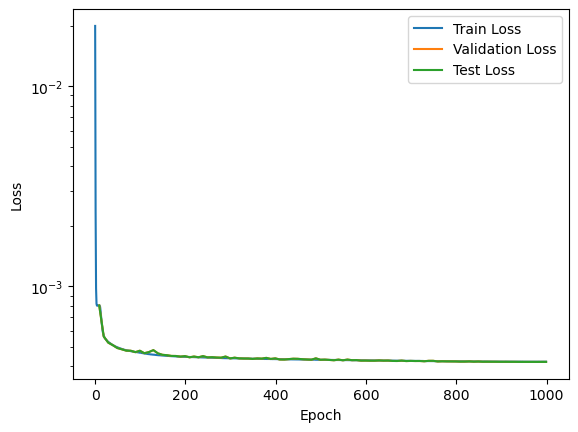

In [37]:
# Plotting
plt.plot(train_losses.numpy(), label='Train Loss')
plt.plot( np.arange(val_freq-1, num_epochs, val_freq),val_losses.numpy(), label='Validation Loss')
plt.plot(np.arange(test_freq-1, num_epochs, test_freq),test_losses.numpy(), label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

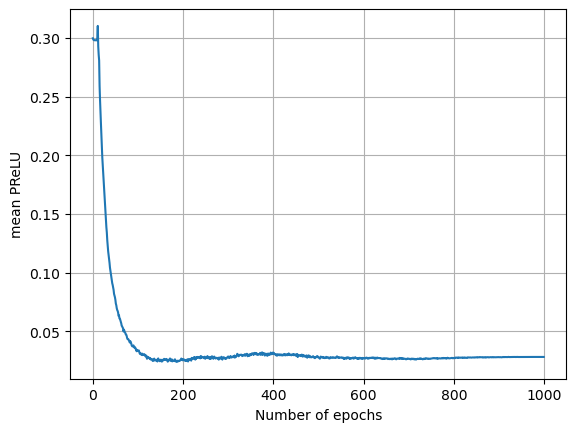

In [38]:
plt.plot(alphas.detach().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('mean PReLU')    
plt.grid(True)
plt.show()

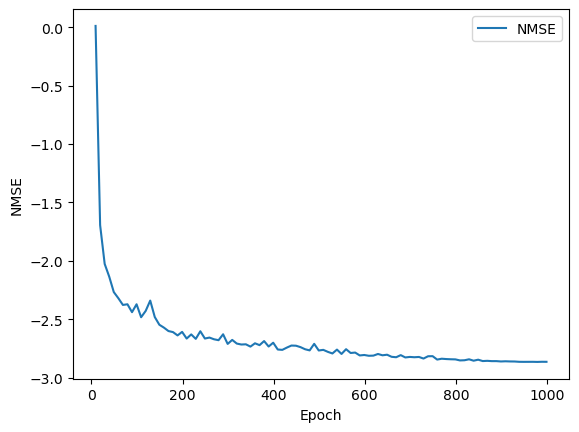

In [39]:
plt.plot(np.arange(test_freq-1, num_epochs, test_freq), test_nmses, label='NMSE')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.legend()
plt.show()

In [40]:
test_losses

tensor([0.0008, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004])

In [41]:
train_losses

tensor([0.0200, 0.0024, 0.0010, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 

In [42]:
val_losses

tensor([0.0008, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004])